In [1]:
import os
import torch
# Specify which GPUs to use
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
print(os.environ["CUDA_VISIBLE_DEVICES"])

# Ensure CUDA is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

0,1
Using device: cuda


# 1. Importing Libraries

In [2]:
# import smogn
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import gmean
from scipy.ndimage import gaussian_filter1d, convolve1d
from scipy.signal.windows import triang
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from numpy.linalg import pinv as ginv
import sys
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from numpy.linalg import inv as ginv
from sklearn.utils import resample
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

2024-08-17 19:37:27.773622: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-17 19:37:27.813460: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX512_FP16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-17 19:37:28.388617: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
%cd '/home//Imbalanced_Regression/imbalanced_imdb-wiki' 
sys.path.append('/home/Imbalanced_Regression/imbalanced_imdb-wiki')

from fds import FDS
from ranksim import batchwise_ranking_regularizer
from loss import *
from utils import *

regularization_weight = 100
interpolation_lambda = 2

In [4]:
def relevance_function(y, method='default'):
    """
    Define your relevance function here.
    For this example, we'll assume a simple relevance function based on z-score.
    """
    if method == 'default':
        mean_y = np.mean(y)
        std_y = np.std(y)
        relevance = np.abs((y - mean_y) / std_y)
        return relevance
    else:
        # Implement other relevance methods if needed
        pass

def calculate_ir(y, threshold=0.8, relevance_method='default'):
    """
    Calculate the Imbalance Ratio (IR) for a given target variable (y)
    and relevance threshold (threshold).
    """
    relevance_scores = relevance_function(y, method=relevance_method)
    n_rare = np.sum(relevance_scores >= threshold)
    n_total = len(y)
    n_non_rare = n_total - n_rare
    ir = n_rare / n_non_rare if n_non_rare > 0 else np.inf
    percentage_r = (n_rare / n_total) * 100
    return n_total, relevance_scores.shape[0], ir, percentage_r, n_rare

# 2. Loading data

## 1-1 Determine dataset

### Dataset 1: Boston Housing

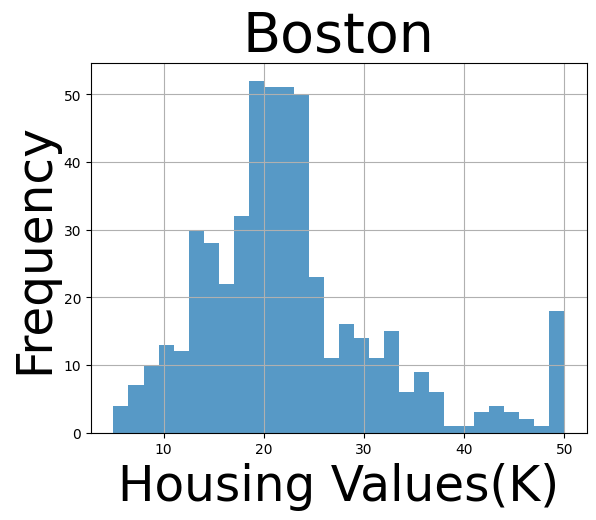

In [2235]:
# Load and prepare datasets
def load_and_prepare_data_Boston(url):
    data = pd.read_csv(url, index_col=False)
    data.drop(['Unnamed: 0'], axis = 1, inplace = True)
    X = data.drop('medv', axis=1).dropna().reset_index(drop=True).values
    y = data['medv'].dropna().reset_index(drop=True).values

    # Generate histogram for the target variable
    plt.hist(y, bins=30, alpha=0.75)
    plt.title('Boston', fontsize=40)
    plt.xlabel('Housing Values(K)',fontsize=35)
    plt.ylabel('Frequency',fontsize=35)
    plt.grid(True)
    plt.show()
    return data, X, y

# url = 'https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv'
url = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/Boston.csv'
df, X, y = load_and_prepare_data_Boston(url)

# Determine target/actual column
target_col = 'medv'
actual_col = 'medv'

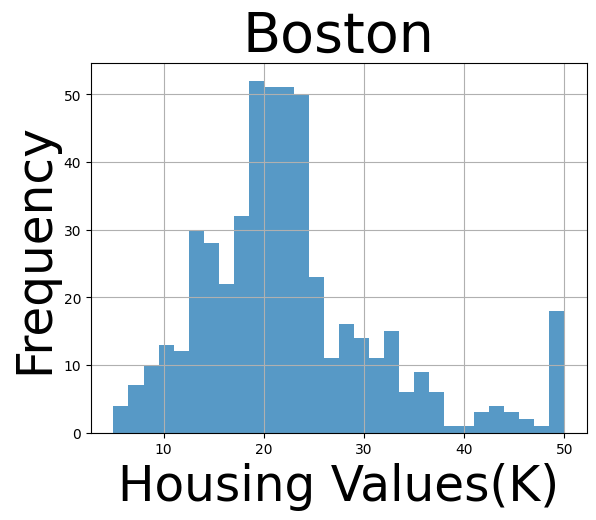

Total Instances (N): 506
Number of Variables (p_total): 506
Imbalance Ratio (IR): 0.567
Percentage of Rare Cases (%Rare): 36.17%
Number of Rare Cases (nRare): 183


In [2236]:
def display_statistics(url, target_col='medv', threshold=0.8):
    df, X, y = load_and_prepare_data_Boston(url)
    n_total, p_total, ir, percentage_r, n_rare = calculate_ir(y, threshold=threshold)

    print(f"Total Instances (N): {n_total}")
    print(f"Number of Variables (p_total): {p_total}")
    print(f"Imbalance Ratio (IR): {ir:.3f}")
    print(f"Percentage of Rare Cases (%Rare): {percentage_r:.2f}%")
    print(f"Number of Rare Cases (nRare): {n_rare}")

display_statistics(url)

### Dataset 2: California Housing

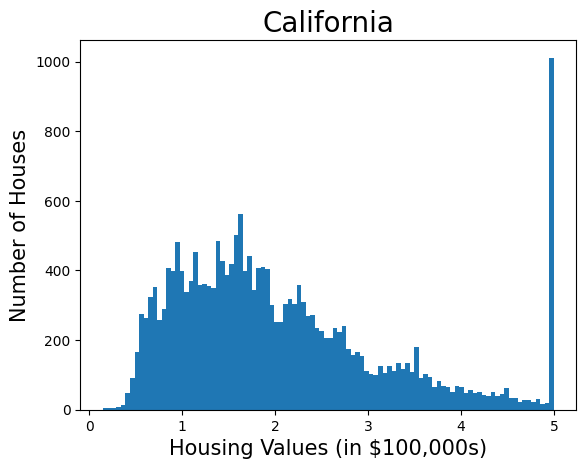

In [736]:
data = fetch_california_housing()
features = data.data
target = data.target.reshape(-1,1)
stacked = np.hstack((features,target))
df = pd.DataFrame(stacked,columns=data.feature_names+data.target_names)


# Determine target/actual column
target_col = 'MedHouseVal'
actual_col = 'MedHouseVal'


## Visualization
plt.hist(df['MedHouseVal'], bins=100)
# Add labels and title
plt.xlabel('Housing Values (in $100,000s)',fontsize=15)
plt.ylabel('Number of Houses', fontsize=15)
plt.title('California', fontsize=20)
# Show the plot
plt.show()


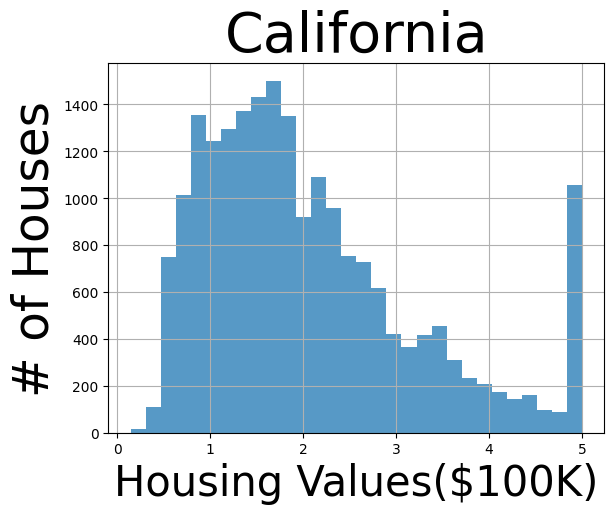

Total Instances (N): 20640
Number of Variables (p_total): 20640
Imbalance Ratio (IR): 0.722
Percentage of Rare Cases (%Rare): 41.91%
Number of Rare Cases (nRare): 8651


In [737]:
def load_and_prepare_data_California():
    data = fetch_california_housing()
    features = data.data
    target = data.target.reshape(-1, 1)
    stacked = np.hstack((features, target))
    df = pd.DataFrame(stacked, columns=data.feature_names + [data.target_names[0]])

    # Generate histogram for the target variable
    plt.hist(target, bins=30, alpha=0.75)
    plt.xlabel('Housing Values($100K)',fontsize=30)
    plt.ylabel('# of Houses', fontsize=35)
    plt.title('California', fontsize=40)
    plt.grid(True)
    plt.show()
    return df, features, target

def display_statistics_california(threshold=0.8):
    df, X, y = load_and_prepare_data_California()
    n_total, p_total, ir, percentage_r, n_rare = calculate_ir(y, threshold=threshold)

    print(f"Total Instances (N): {n_total}")
    print(f"Number of Variables (p_total): {p_total}")
    print(f"Imbalance Ratio (IR): {ir:.3f}")
    print(f"Percentage of Rare Cases (%Rare): {percentage_r:.2f}%")
    print(f"Number of Rare Cases (nRare): {n_rare}")

# Example usage
display_statistics_california()

In [738]:
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [739]:
X = df.drop('MedHouseVal', axis=1).dropna().reset_index(drop=True).values
y = df['MedHouseVal'].dropna().reset_index(drop=True).values

### Dataset 3: abalone

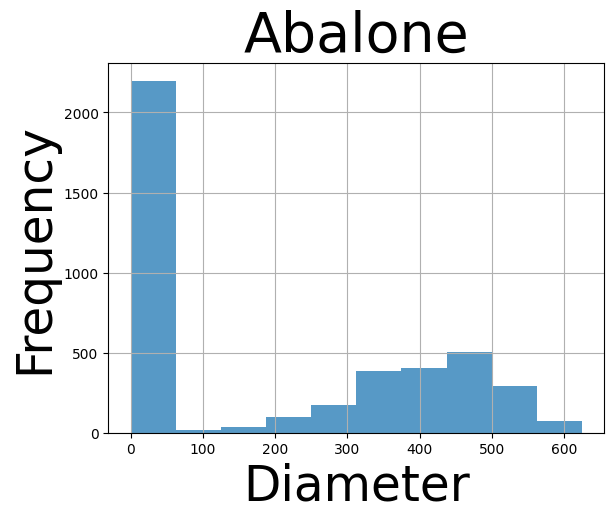

In [5]:
def load_and_prepare_data_abalone(url):
    data = pd.read_csv(url)

    # Move target column to the last position
    cols = list(data.columns)
    cols.append(cols.pop(cols.index('Diameter')))
    data = data[cols]

    X = data.drop('Diameter', axis=1).dropna().reset_index(drop=True).values
    y = data['Diameter'].dropna().reset_index(drop=True).values

    plt.hist(y, bins=10, alpha=0.75)
    plt.title('Abalone', fontsize=40)
    plt.xlabel('Diameter', fontsize=35)
    plt.ylabel('Frequency', fontsize=35)
    plt.grid(True)
    plt.show()
    return data, X, y

url = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/abalone.csv'
df, X, y = load_and_prepare_data_abalone(url)

# Determine target/actual column
target_col = 'Diameter'
actual_col = 'Diameter'

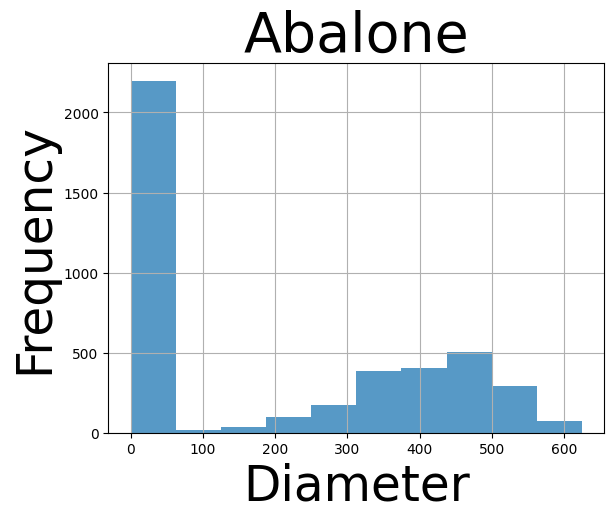

Total Instances (N): 4177
Number of Variables (p_total): 4177
Imbalance Ratio (IR): 5.630
Percentage of Rare Cases (%Rare): 84.92%
Number of Rare Cases (nRare): 3547


In [6]:
def display_statistics_abalone(url, target_col='Diameter', threshold=0.8):
    df, X, y = load_and_prepare_data_abalone(url)
    n_total, p_total, ir, percentage_r, n_rare = calculate_ir(y, threshold=threshold)

    print(f"Total Instances (N): {n_total}")
    print(f"Number of Variables (p_total): {p_total}")
    print(f"Imbalance Ratio (IR): {ir:.3f}")
    print(f"Percentage of Rare Cases (%Rare): {percentage_r:.2f}%")
    print(f"Number of Rare Cases (nRare): {n_rare}")

display_statistics_abalone(url)

### Dataset 4: forest fire


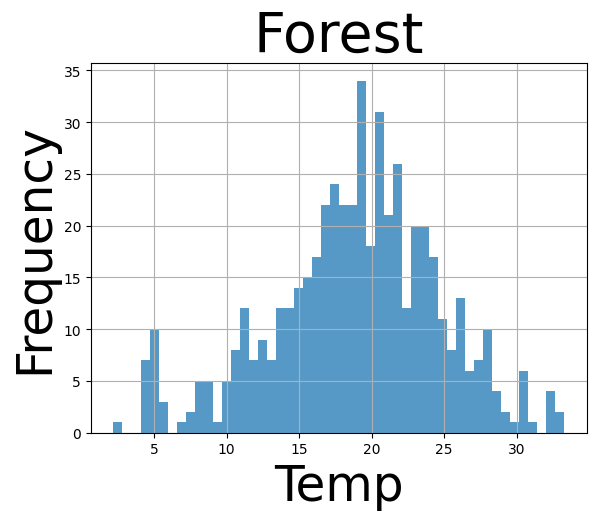

In [2392]:
def load_and_prepare_data_forest(url):
    data = pd.read_csv(url)

    # Move target column to the last position
    cols = list(data.columns)
    cols.append(cols.pop(cols.index('Temp')))
    data = data[cols]

    X = data.drop('Temp', axis=1).dropna().reset_index(drop=True).values
    y = data['Temp'].dropna().reset_index(drop=True).values

    plt.hist(y, bins=50, alpha=0.75)
    plt.title('Forest', fontsize=40)
    plt.xlabel('Temp', fontsize=35)
    plt.ylabel('Frequency', fontsize=35)
    plt.grid(True)
    plt.show()
    return data, X, y

url = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/forestFires_clean.csv'
df, X, y = load_and_prepare_data_forest(url)

# Determine target/actual column
target_col = 'Temp'
actual_col = 'Temp'

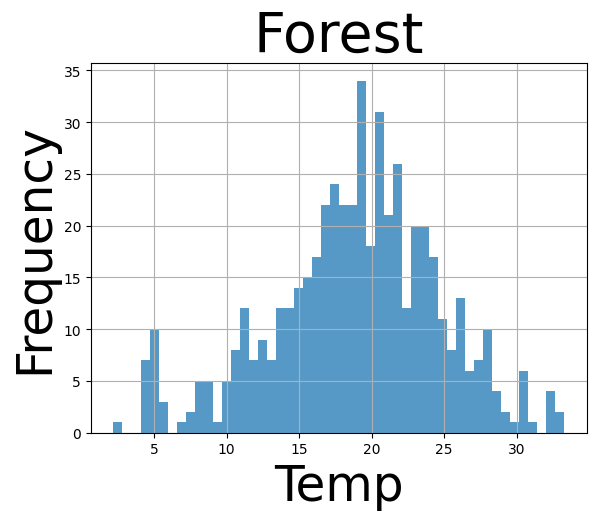

Total Instances (N): 517
Number of Variables (p_total): 517
Imbalance Ratio (IR): 0.652
Percentage of Rare Cases (%Rare): 39.46%
Number of Rare Cases (nRare): 204


In [2393]:
def display_statistics_forest(url, target_col='Temp', threshold=0.8):
    df, X, y = load_and_prepare_data_forest(url)
    n_total, p_total, ir, percentage_r, n_rare = calculate_ir(y, threshold=threshold)

    print(f"Total Instances (N): {n_total}")
    print(f"Number of Variables (p_total): {p_total}")
    print(f"Imbalance Ratio (IR): {ir:.3f}")
    print(f"Percentage of Rare Cases (%Rare): {percentage_r:.2f}%")
    print(f"Number of Rare Cases (nRare): {n_rare}")

display_statistics_forest(url)

### Dataset 5: Adult Income

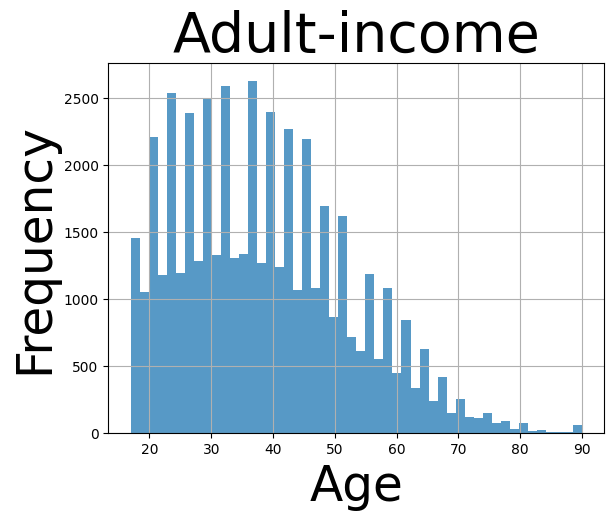

In [520]:
from sklearn.preprocessing import LabelEncoder

def load_and_prepare_data_adult_income(file_path):
    data = pd.read_csv(file_path)

    # Move target column to the last position
    cols = list(data.columns)
    cols.append(cols.pop(cols.index('age')))
    data = data[cols]

    # Drop rows with missing values
    data = data.dropna().reset_index(drop=True)

    # Convert categorical columns to numerical values
    label_encoders = {}
    for column in data.select_dtypes(include=['object']).columns:
        label_encoders[column] = LabelEncoder()
        data[column] = label_encoders[column].fit_transform(data[column])

    X = data.drop('age', axis=1).values
    y = data['age'].values

    # Plot the distribution of the target column
    plt.hist(y, bins=50, alpha=0.75)
    plt.title('Adult-income', fontsize=40)
    plt.xlabel('Age', fontsize=35)
    plt.ylabel('Frequency', fontsize=35)
    plt.grid(True)
    plt.show()

    return data, X, y

# Path to the Adult Income dataset
file_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/adult.csv'
df, X, y = load_and_prepare_data_adult_income(file_path)

# Determine target/actual column
target_col = 'age'
actual_col = 'age'


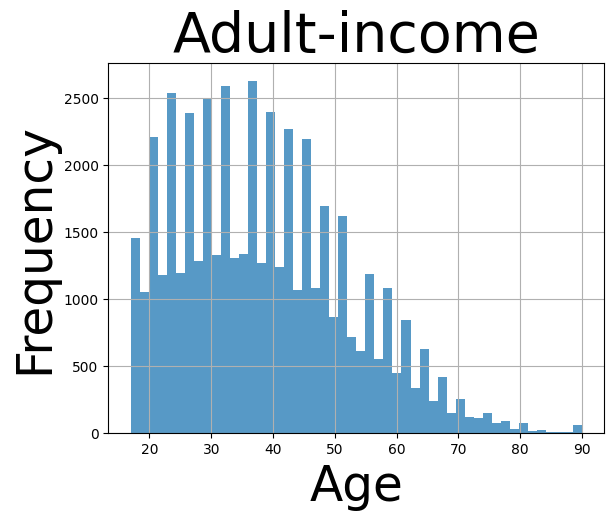

Total Instances (N): 48842
Number of Variables (p_total): 48842
Imbalance Ratio (IR): 0.867
Percentage of Rare Cases (%Rare): 46.45%
Number of Rare Cases (nRare): 22686


In [521]:
def display_statistics_adult_income(url, target_col='age', threshold=0.8):
    df, X, y = load_and_prepare_data_adult_income(url)
    n_total, p_total, ir, percentage_r, n_rare = calculate_ir(y, threshold=threshold)

    print(f"Total Instances (N): {n_total}")
    print(f"Number of Variables (p_total): {p_total}")
    print(f"Imbalance Ratio (IR): {ir:.3f}")
    print(f"Percentage of Rare Cases (%Rare): {percentage_r:.2f}%")
    print(f"Number of Rare Cases (nRare): {n_rare}")

display_statistics_adult_income(file_path)

### Dataset 6: kdd-coil-1

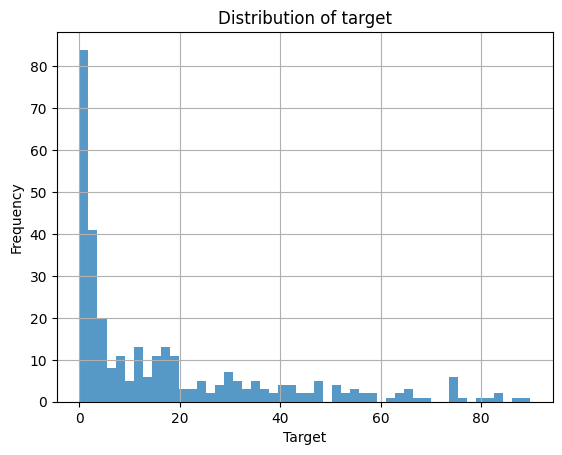

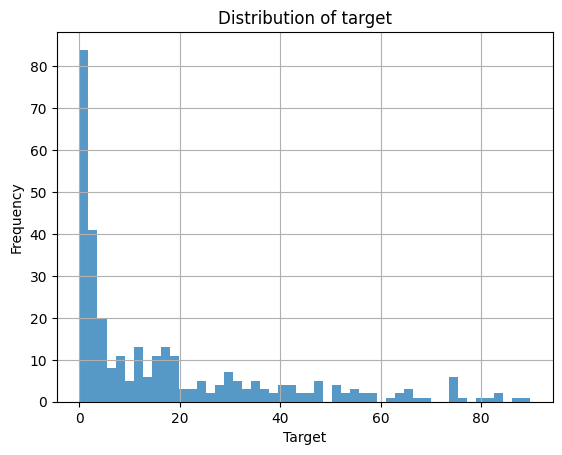

Total Instances (N): 316
Number of Variables (p_total): 18
Imbalance Ratio (IR): 0.812
Percentage of Rare Cases (%Rare): 83.54%
Number of Rare Cases (nRare): 264


In [1221]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

# Load and prepare data function
def load_and_prepare_data_power(filepath):
    data = pd.read_csv(filepath)

    # Move target column to the last position
    cols = list(data.columns)
    cols.append(cols.pop(cols.index('target')))
    data = data[cols]

    X = data.drop('target', axis=1).dropna().reset_index(drop=True).values
    y = data['target'].dropna().reset_index(drop=True).values

    plt.hist(y, bins=50, alpha=0.75)
    plt.title('Distribution of target')
    plt.xlabel('Target')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()
    return data, X, y

# Filepath to the available_power dataset
filepath = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/kdd_coil_1.csv'
df, X, y = load_and_prepare_data_power(filepath)

# Determine target/actual column
target_col = 'target'
actual_col = 'target'

# Display statistics function
def display_statistics_power(filepath, target_col='target', threshold=0.8):
    df, X, y = load_and_prepare_data_power(filepath)
    
    n_total = len(y)
    p_total = X.shape[1]
    ir = np.mean(y) / np.std(y)
    percentage_r = (np.sum(y > threshold) / n_total) * 100
    n_rare = np.sum(y > threshold)

    print(f"Total Instances (N): {n_total}")
    print(f"Number of Variables (p_total): {p_total}")
    print(f"Imbalance Ratio (IR): {ir:.3f}")
    print(f"Percentage of Rare Cases (%Rare): {percentage_r:.2f}%")
    print(f"Number of Rare Cases (nRare): {n_rare}")

display_statistics_power(filepath)

# Custom Dataset class
class PowerDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        feature = self.features[idx]
        target = self.targets[idx]
        return feature, target

# Split dataset into training and validation sets
train_indices, val_indices = train_test_split(np.arange(len(X)), test_size=0.2, random_state=42)

train_dataset = PowerDataset(X[train_indices], y[train_indices])
val_dataset = PowerDataset(X[val_indices], y[val_indices])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Regression model
class RegressionModel(nn.Module):
    def __init__(self, input_dim, return_features=False):
        super(RegressionModel, self).__init__()
        self.return_features = return_features
        self.features_reducer = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 32),
            nn.ReLU()
        )
        self.regressor = nn.Linear(32, 1)

    def forward(self, x):
        reduced_features = self.features_reducer(x)
        output = self.regressor(reduced_features)
        if self.return_features:
            return output, reduced_features
        return output

# Define the model, loss function, and optimizer
model = RegressionModel(input_dim=X.shape[1], return_features=True).cuda()



In [1222]:
df.head()

,onehotencoder__x0_autumn,onehotencoder__x0_spring,onehotencoder__x0_summer,onehotencoder__x0_winter,onehotencoder__x1_large_,onehotencoder__x1_medium,onehotencoder__x1_small_,onehotencoder__x2_high__,onehotencoder__x2_low___,onehotencoder__x2_medium,concentration_1,concentration_2,concentration_3,concentration_4,concentration_5,concentration_6,concentration_7,concentration_8,target
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,8.00,9.8,60.800,6.238,578.00000,105.000,170.00000,50.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,8.35,8.0,57.750,1.288,370.00000,428.750,558.75000,1.3,1.4
2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,8.10,11.4,40.020,5.330,346.66699,125.667,187.05701,15.6,3.3
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,8.07,4.8,77.364,2.302,98.18200,61.182,138.70000,1.4,3.1
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,8.06,9.0,55.350,10.416,233.70000,58.222,97.58000,10.5,9.2


### Dataset 7: lungcancer

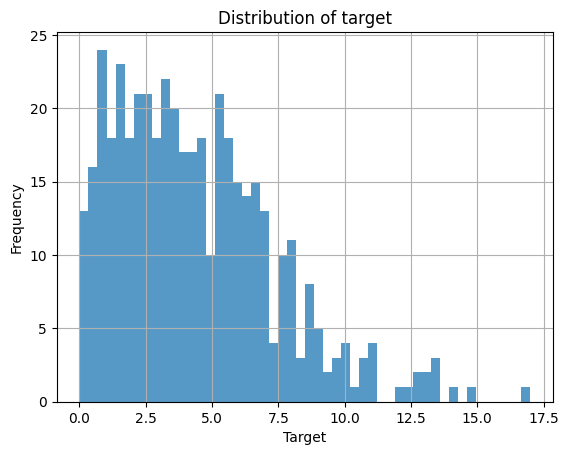

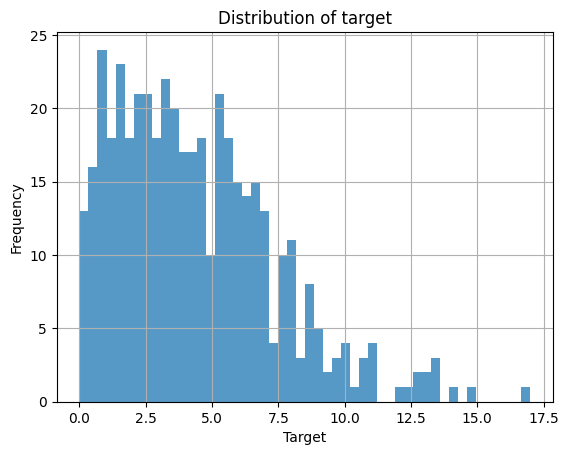

Total Instances (N): 442
Number of Variables (p_total): 24
Imbalance Ratio (IR): 1.453
Percentage of Rare Cases (%Rare): 90.95%
Number of Rare Cases (nRare): 402


In [1177]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

# Load and prepare data function
def load_and_prepare_data_lungcancer(filepath):
    data = pd.read_csv(filepath)

    # Move target column to the last position
    cols = list(data.columns)
    cols.append(cols.pop(cols.index('target')))
    data = data[cols]

    X = data.drop('target', axis=1).dropna().reset_index(drop=True).values
    y = data['target'].dropna().reset_index(drop=True).values

    plt.hist(y, bins=50, alpha=0.75)
    plt.title('Distribution of target')
    plt.xlabel('Target')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()
    return data, X, y

# Filepath to the lungcancer_shedden dataset
filepath = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/lungcancer_shedden.csv'
df, X, y = load_and_prepare_data_lungcancer(filepath)

# Determine target/actual column
target_col = 'target'
actual_col = 'target'

# Display statistics function
def display_statistics_lungcancer(filepath, target_col='target', threshold=0.8):
    df, X, y = load_and_prepare_data_lungcancer(filepath)
    
    n_total = len(y)
    p_total = X.shape[1]
    ir = np.mean(y) / np.std(y)
    percentage_r = (np.sum(y > threshold) / n_total) * 100
    n_rare = np.sum(y > threshold)

    print(f"Total Instances (N): {n_total}")
    print(f"Number of Variables (p_total): {p_total}")
    print(f"Imbalance Ratio (IR): {ir:.3f}")
    print(f"Percentage of Rare Cases (%Rare): {percentage_r:.2f}%")
    print(f"Number of Rare Cases (nRare): {n_rare}")

display_statistics_lungcancer(filepath)

# Custom Dataset class
class LungcancerDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        feature = self.features[idx]
        target = self.targets[idx]
        return feature, target

# Split dataset into training and validation sets
train_indices, val_indices = train_test_split(np.arange(len(X)), test_size=0.2, random_state=42)

train_dataset = LungcancerDataset(X[train_indices], y[train_indices])
val_dataset = LungcancerDataset(X[val_indices], y[val_indices])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Regression model
class RegressionModel(nn.Module):
    def __init__(self, input_dim, return_features=False):
        super(RegressionModel, self).__init__()
        self.return_features = return_features
        self.features_reducer = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 32),
            nn.ReLU()
        )
        self.regressor = nn.Linear(32, 1)

    def forward(self, x):
        reduced_features = self.features_reducer(x)
        output = self.regressor(reduced_features)
        if self.return_features:
            return output, reduced_features
        return output

# Define the model, loss function, and optimizer
model = RegressionModel(input_dim=X.shape[1], return_features=True).cuda()


## 1-2 Binning strategy

### Option 1: Square Root Choice

In [10]:
# Square Root Choice
def square_root_choice(y):
  return int(np.sqrt(len(y)))


K = square_root_choice(df[target_col])
print(K)

64


### Option 2: Sturge's Formula

In [2535]:
def sturges_rule(y):
    n = len(y)
    K = math.floor(1 + np.log2(n))
    return K

K = sturges_rule(df[target_col]) 
print(K)

13


### Option 3: Freedman–Diaconis rule

In [2494]:
def freedman_diaconis_rule(y):
    # Calculate the IQR (Interquartile Range)
    q25, q75 = np.percentile(y, [25, 75])
    iqr = q75 - q25
    
    # Calculate the bin width
    n = len(y)
    bin_width = 2 * iqr / np.cbrt(n)
    
    # Calculate the number of bins
    data_range = np.max(y) - np.min(y)
    K = math.ceil(data_range / bin_width)
    
    return K

# Example usage
K = freedman_diaconis_rule(df[target_col])
print(K)

KeyError: 'Diameter_equal_length'

# 3. Mix-Up Algorithm


## Step 1: Equal Length Approach

In [11]:
def discretize_equal_length(df, column, K):
    target_col = column + '_equal_length'
    min_val = df[column].min()
    max_val = df[column].max()
    # Calculate interval width
    interval_width = (max_val - min_val) / K
    # print(min_val)
    # print(interval_width)
    # Calculate threshold points
    thresholds = [min_val-0.0001]+[min_val + i * interval_width for i in range(1, K)]

    # print(thresholds)
    # Use the thresholds to discretize
    df[target_col] = pd.cut(df[column], bins=[-np.inf] + thresholds + [np.inf], labels=False)
    thresholds.append(np.inf)

    df['low_range'] = df[target_col].map(lambda x: thresholds[x-1])
    df['high_range'] = df[target_col].map(lambda x: thresholds[x])

    # Count number of samples per bin
    bin_counts = df[target_col].value_counts().sort_index()
    # print("Number of samples per bin:", bin_counts)

    return df

# Discretize the column 'y' using equal length
df1 = df.copy()
df1 = discretize_equal_length(df1,target_col, K)
target_col = target_col + '_equal_length'
#actual_col = 'medv'
df1.head()

,Rings,Sex,Length,Height,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight,Diameter,Diameter_equal_length,low_range,high_range
0,15,0,455.00,95.00,514.0000,0.2245,101.0000,0.15,365.00,38,361.366094,371.130312
1,7,0,0.35,0.09,0.2255,0.0995,0.0485,0.07,265.00,28,263.723906,273.488125
2,9,1,0.53,135.00,677.0000,0.2565,0.1415,0.21,0.42,1,0.089900,9.854219
3,10,0,0.44,125.00,516.0000,0.2155,114.0000,155.00,365.00,38,361.366094,371.130312
4,7,2,0.33,0.08,205.0000,0.0895,0.0395,55.00,255.00,27,253.959688,263.723906


## Step 2: Setting up benchmark distribution m_j



### **m_j = 2.0 times median**

In [12]:
def calculate_mj_with_median(df, target_col):
    # Calculate the total number of samples and range values
    total_samples = len(df1[target_col])
    min_val = df1[target_col].min()
    max_val = df1[target_col].max()

    # Bin the data
    counts, bin_edges = np.histogram(df[target_col], bins=K)

    # Calculate median number of samples per bin
    mj = int(np.median(counts))

    return mj

## Try another strategy: Median * 2.0
total_samples = len(df1[target_col])
mj = int(calculate_mj_with_median(df1, target_col) * 2.0)
print("mj:", mj)

# Number of samples per bin
num_samples_per_bin = mj

uniform_dist = np.array([])
for bin_value in range(1, K+1):
    # Generate num_samples_per_bin samples uniformly distributed in the range [bin_value, bin_value + 1]
    samples_in_bin = np.random.uniform(low=bin_value, high=bin_value, size=num_samples_per_bin)
    uniform_dist = np.concatenate((uniform_dist, samples_in_bin))


mj: 42


## Step 3 (Adjusting the original distribution)

### Option 1. **Samples in the nearest cells**

#### NC - helper function

In [13]:
def check_nc(dataframe, features, actual_col, low_range, high_range, original_index, synthetic_index, lambda_beta):
    synthetic_x = []
    y_actual = dataframe[actual_col]

    low_range_val = dataframe[low_range][original_index].values[0]
    high_range_val = dataframe[high_range][original_index].values[0]

    synthetic_y = lambda_beta * y_actual[original_index].values[0] + (1 - lambda_beta) * y_actual[synthetic_index].values[0]

    if low_range_val <= synthetic_y <= high_range_val:
        for feature in features:
            x_actual = dataframe[feature]
            synthetic = lambda_beta * x_actual[original_index].values[0] + (1 - lambda_beta) * x_actual[synthetic_index].values[0]
            synthetic_x.append(synthetic)

        synthetic_x.append(synthetic_y)
        return synthetic_x
    else:
        return None

def adjust_distribution_nc(target_dist, target_col, dataframe, synthetic_limit, actual_col, features, low_range, high_range):
    sampled_data = []
    generated_data = []

    target_col_index = dataframe.columns.tolist().index(target_col)
    scenario_freq = {'Equal_Case': 0, 'UnderSampling_Case': 0, 'OverSampling_Case': 0}
    unique_bins = dataframe[target_col].unique()

    for j in np.sort(unique_bins):
        target_dist_indices_bin = np.where(target_dist == j)[0]
        original_dist_indices_bin = np.where(dataframe[target_col] == j)[0]

        nj = len(original_dist_indices_bin)
        mj = len(target_dist_indices_bin)

        print(f'nj : {nj} for {j} bin value')
        print(f'mj : {mj} for {j} bin value')

        if nj == mj:
            sampled_data.append(dataframe.iloc[original_dist_indices_bin, : target_col_index])
            scenario_freq['Equal_Case'] += 1
            print(f'Equal Case: Bin {j} , nj: {len(sampled_data)}, mj: {mj}')

        elif nj > mj:
            mj_dynamic = int(max(mj, 0.90* nj))
            sampled_indices = np.random.choice(original_dist_indices_bin, mj_dynamic, replace=False)
            sampled_data.append(dataframe.iloc[sampled_indices.tolist(), :target_col_index])
            scenario_freq['UnderSampling_Case'] += 1
            print(f'UnderSampling Case: Bin {j} , nj: {len(sampled_indices)}, mj_dynamic: {mj_dynamic}')

        elif nj < mj:
            shorted_samples = mj - nj
            scenario_freq['OverSampling_Case'] += 1
            lower_nc, higher_nc = find_nearest_cells(unique_bins, j)

            lower_nc_indices = np.where(dataframe[target_col] == lower_nc)[0] if lower_nc is not None else []
            higher_nc_indices = np.where(dataframe[target_col] == higher_nc)[0] if higher_nc is not None else []

            lower_nc_indices = np.array(lower_nc_indices)
            higher_nc_indices = np.array(higher_nc_indices)

            generated_samples = []

            sampled_data.append(dataframe.iloc[original_dist_indices_bin, : target_col_index])

            while len(generated_samples) < synthetic_limit:
                lambda_beta = 1 / (1 + np.exp(-0.5 * (mj - nj)))  

                if lower_nc_indices.size > 0 and higher_nc_indices.size > 0:
                    prob = np.random.random()
                    if prob < 0.5:
                        synthetic_index = np.random.choice(lower_nc_indices, 1, replace=False)
                    else:
                        synthetic_index = np.random.choice(higher_nc_indices, 1, replace=False)
                elif lower_nc_indices.size > 0:
                    synthetic_index = np.random.choice(lower_nc_indices, 1, replace=False)
                elif higher_nc_indices.size > 0:
                    synthetic_index = np.random.choice(higher_nc_indices, 1, replace=False)
                else:
                    break

                original_random_index = np.random.choice(original_dist_indices_bin, 1, replace=False)
                synthetic_sample = check_nc(dataframe, features, actual_col, low_range, high_range, original_random_index, synthetic_index, lambda_beta)

                if synthetic_sample is not None:
                    synthetic_sample.append(j)
                    generated_samples.append(synthetic_sample)

            print(f'OverSampling Case: Bin {j} , nj: {len(generated_samples)}, mj: {mj}')
            generated_data.extend(generated_samples)

    return sampled_data, generated_data, scenario_freq

# Helper function to find nearest cells
def find_nearest_cells(available_bins, target):
    sorted_bins = np.sort(available_bins)
    lower_bins = sorted_bins[sorted_bins < target]
    upper_bins = sorted_bins[sorted_bins > target]

    lower_nearest = lower_bins[-1] if len(lower_bins) > 0 else None
    higher_nearest = upper_bins[0] if len(upper_bins) > 0 else None

    return lower_nearest, higher_nearest

#### NC - Excute

In [14]:
# total samples = n_j + factor * mj
factor = 5
synthetic_limit = factor * mj

In [509]:
df1.head()

,Rings,Sex,Length,Height,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight,Diameter,Diameter_equal_length,low_range,high_range
0,15,0,455.00,95.00,514.0000,0.2245,101.0000,0.15,365.00,38,361.366094,371.130312
1,7,0,0.35,0.09,0.2255,0.0995,0.0485,0.07,265.00,28,263.723906,273.488125
2,9,1,0.53,135.00,677.0000,0.2565,0.1415,0.21,0.42,1,0.089900,9.854219
3,10,0,0.44,125.00,516.0000,0.2155,114.0000,155.00,365.00,38,361.366094,371.130312
4,7,2,0.33,0.08,205.0000,0.0895,0.0395,55.00,255.00,27,253.959688,263.723906


In [15]:
### Adjusting the original distribution to the target distribution
target_dist = uniform_dist
features = df1.drop([actual_col,target_col,'low_range','high_range'], axis=1).columns.tolist()

In [16]:
sampled_data_nc,generated_data_nc, scenario_freq_nc = adjust_distribution_nc(target_dist, target_col,dataframe=df1,
                                                                             synthetic_limit=synthetic_limit, actual_col=actual_col,
                                                                             features= features, low_range='low_range', high_range='high_range')

nj : 2197 for 1 bin value
mj : 42 for 1 bin value
UnderSampling Case: Bin 1 , nj: 1977, mj_dynamic: 1977
nj : 1 for 6 bin value
mj : 42 for 6 bin value
OverSampling Case: Bin 6 , nj: 210, mj: 42
nj : 1 for 10 bin value
mj : 42 for 10 bin value
OverSampling Case: Bin 10 , nj: 210, mj: 42
nj : 4 for 11 bin value
mj : 42 for 11 bin value
OverSampling Case: Bin 11 , nj: 210, mj: 42
nj : 2 for 12 bin value
mj : 42 for 12 bin value
OverSampling Case: Bin 12 , nj: 210, mj: 42
nj : 7 for 13 bin value
mj : 42 for 13 bin value
OverSampling Case: Bin 13 , nj: 210, mj: 42
nj : 5 for 14 bin value
mj : 42 for 14 bin value
OverSampling Case: Bin 14 , nj: 210, mj: 42
nj : 5 for 15 bin value
mj : 42 for 15 bin value
OverSampling Case: Bin 15 , nj: 210, mj: 42
nj : 4 for 16 bin value
mj : 42 for 16 bin value
OverSampling Case: Bin 16 , nj: 210, mj: 42
nj : 4 for 17 bin value
mj : 42 for 17 bin value
OverSampling Case: Bin 17 , nj: 210, mj: 42
nj : 11 for 18 bin value
mj : 42 for 18 bin value
OverSamplin

In [17]:
sampled_df = pd.concat(sampled_data_nc, axis=0)
sampled_df.head()

,Rings,Sex,Length,Height,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight,Diameter
4000,7,2,455.00,135.0,0.5365,0.2855,0.0855,0.1325,0.35
3406,8,2,0.35,75.0,196.0000,82.0000,0.0400,64.0000,0.28
2808,9,1,705.00,205.0,1757.0000,0.8265,417.0000,461.0000,0.54
2158,14,0,0.56,195.0,0.8085,0.3025,0.1795,285.0000,0.42
1532,5,2,285.00,55.0,101.0000,0.0415,17.0000,0.0335,0.21


In [18]:
generated_df = pd.DataFrame(generated_data_nc,columns=df1.columns.tolist()[:-2])
generated_df.head()

,Rings,Sex,Length,Height,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight,Diameter,Diameter_equal_length
0,1.0,2.0,75.000001,0.01,2.000002,1.000001,0.0005,0.0015,55.0,6
1,1.0,2.0,75.000000,0.01,2.000000,1.000000,0.0005,0.0015,55.0,6
2,1.0,2.0,75.000000,0.01,2.000000,1.000000,0.0005,0.0015,55.0,6
3,1.0,2.0,75.000000,0.01,2.000000,1.000000,0.0005,0.0015,55.0,6
4,1.0,2.0,75.000000,0.01,2.000000,1.000000,0.0005,0.0015,55.0,6


##### **Filtering using Raking Weights**

In [19]:
def soft_nearest_neighbors_loss(anchors, positives, negatives, tau=2.45):
    """
    Soft-Nearest Neighbors Loss function.
    """
    pos_sim = cosine_similarity(anchors, positives) / tau
    neg_sim = cosine_similarity(anchors, negatives) / tau

    pos_exp = torch.exp(torch.tensor(pos_sim))
    neg_exp = torch.exp(torch.tensor(neg_sim))

    pos_loss = -torch.log(pos_exp / (pos_exp + neg_exp.sum(axis=1, keepdims=True)))
    loss = pos_loss.mean()

    return loss

def enhanced_raking(X, mx, d, Col, nume_col, cri=0, max_iter=100, tol=1e-5, reg=1e-8, tau=2.45):
    """
    Enhanced raking function with additional control over iteration, tolerance, and Soft-Nearest Neighbors Loss.
    """
    if Col in nume_col:
        mx = np.concatenate(([1], [mx]))
        D = np.empty([2, 2])
        pred = np.column_stack((np.repeat(1, X.shape[0]), X))
        lam = np.zeros((2, 1))

        for _ in range(max_iter):
            t_hat = np.matmul(d, pred).flatten()
            phi = np.matmul(d * (np.exp(np.matmul(pred, lam).flatten()) - 1), pred)

            D[0, 0] = np.sum(d * np.exp(np.matmul(pred, lam).flatten()))
            D[1, 0] = np.sum(d * np.exp(np.matmul(pred, lam).flatten()) * X)
            D[0, 1] = D[1, 0]
            D[1, 1] = np.sum(d * np.exp(np.matmul(pred, lam).flatten()) * (X ** 2))

            # Add regularization term to the diagonal
            D += reg * np.eye(D.shape[0])

            lam_new = lam + np.matmul(ginv(D), np.array([mx - t_hat - phi]).T)
            if np.sum(np.abs(lam_new - lam)) < tol:
                break
            lam = lam_new

        W = d * np.exp(np.matmul(pred, lam).flatten())
    else:
        X = np.array(X)
        W = np.empty([0])

        New_Value = np.unique(X)[~np.isin(np.unique(X), list(mx.keys()))]
        if len(New_Value) != 0:
            print(f"No such variable(s) in: {Col}")
            print(np.round(pd.DataFrame(X).value_counts() / X.shape[0], 3)[New_Value])

        subtotal = dict(zip(list(mx.keys()), [np.sum(d[np.where(X == x)[0]]) for x in mx.keys()]))

        for j in range(d.shape[0]):
            v = X[j]
            if v not in list(mx.keys()):
                W = np.concatenate((W, [d[j]]))
            else:
                W = np.concatenate((W, [d[j] * mx[v] / subtotal[v]]))
        W = W / np.sum(W)

    if np.sum(W) > 1:
        W = W / np.sum(W)

    return W

def enhanced_raking_weight_DE(df, ref, nume_col=None, N=10, tau=2.45):
    """
    Enhanced raking weights calculation with dynamic adjustment and Soft-Nearest Neighbors Loss.
    """
    if nume_col is None:
        nume_col = np.arange(df.shape[1])

    w = np.repeat(1 / df.shape[0], df.shape[0])

    for _ in range(N):
        for Col in range(len(ref)):
            w = enhanced_raking(df[:, Col], ref[Col], w, Col, nume_col, tau=tau)

    return w

def sampling(df, indices, size, seed, w=None, replace=True):
    """
    Function that samples 'df' of given size with weight 'w'.
    """
    np.random.seed(seed)
    sampleID = np.random.choice(indices, size, p=w, replace=replace)
    df_sampled = df[sampleID]
    return df_sampled, sampleID

def normalize_array(arr):
    total_sum = sum(arr)
    normalized_arr = [val / total_sum for val in arr]
    return normalized_arr

# Assume generated_df, sampled_df, df1, target_dist, actual_col, target_col are defined elsewhere
synthetic_minor = generated_df.drop([actual_col, target_col], axis=1).values
dist_minor = sampled_df.drop(actual_col, axis=1).values.mean(axis=0)
RW_min = enhanced_raking_weight_DE(synthetic_minor, dist_minor)
print(RW_min.shape)

unique_bins = df1[target_col].unique()
withdrawn_raking = []
shorted = 0

for j in np.sort(unique_bins):
    target_dist_indices_bin = np.where(target_dist == j)[0]
    original_dist_indices_bin = np.where(df1[target_col] == j)[0]
    generated_dist_indices_bin = np.where(generated_df[target_col] == j)[0]
    w_bin = normalize_array(RW_min[generated_dist_indices_bin])

    original_y_mean = df1.iloc[original_dist_indices_bin, -4].mean()
    nj = len(original_dist_indices_bin)
    mj = len(target_dist_indices_bin)
    synthetic_mj = len(generated_dist_indices_bin)

    if nj < mj:
        shorted += mj - nj
        synthetic_size = int(mj - nj)

        new_synthetic_minor, sampled_indices = sampling(synthetic_minor, generated_dist_indices_bin, synthetic_size, seed=0, w=w_bin)
        filtered_samples = np.concatenate((new_synthetic_minor, np.expand_dims(generated_df[actual_col].values[list(sampled_indices)], axis=1)), axis=1)

        # Calculate Soft-Nearest Neighbors Loss and adjust synthetic samples
        num_samples = min(len(synthetic_minor), len(filtered_samples))  # Align the size of anchors, positives, and negatives
        anchors = synthetic_minor[:num_samples]
        positives = filtered_samples[:num_samples, :-1]  # Exclude the target column
        negatives = synthetic_minor[:num_samples]

        anchors_tensor = torch.tensor(anchors, dtype=torch.float32)
        positives_tensor = torch.tensor(positives, dtype=torch.float32)
        negatives_tensor = torch.tensor(negatives, dtype=torch.float32)

        loss = soft_nearest_neighbors_loss(anchors_tensor, positives_tensor, negatives_tensor)
        synthetic_features_adjusted = positives - loss.detach().numpy()

        adjusted_samples = np.concatenate((synthetic_features_adjusted, np.expand_dims(filtered_samples[:num_samples, -1], axis=1)), axis=1)
        withdrawn_raking.append(pd.DataFrame(adjusted_samples, columns=sampled_df.columns.tolist()))

final_df_nc_raking = pd.concat([sampled_df, pd.concat(withdrawn_raking, axis=0)], axis=0)
final_df_nc_raking.sort_values(by=actual_col, inplace=True, ignore_index=True)

(7140,)


In [21]:
final_df_nc_raking = pd.concat([sampled_df, pd.concat(withdrawn_raking,axis=0)],axis=0)
final_df_nc_raking.sort_values(by=actual_col, inplace=True, ignore_index=True)

In [22]:
final_df_nc_raking.head()

,Rings,Sex,Length,Height,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight,Diameter
0,3.0,2.0,0.11,0.03,8.0000,0.0025,2.0000,3.0,0.09
1,3.0,2.0,0.13,0.03,13.0000,0.0045,3.0000,4.0,0.10
2,2.0,2.0,0.15,25.00,15.0000,0.0045,4.0000,5.0,0.10
3,3.0,0.0,155.00,0.04,0.0155,0.0065,3.0000,5.0,0.11
4,3.0,2.0,0.16,25.00,18.0000,0.0065,0.0055,5.0,0.11


### Option.2 Samples of similar features (Siamese Network)

#### Step:1 Train Siamese Network

In [23]:
# total samples = n_j + factor * mj
factor = 5
synthetic_limit = factor * mj

In [24]:
# Define a custom dataset
class TabularDataset(Dataset):
    def __init__(self, df):
        self.data = df.iloc[:, :-4].values  # Features
        self.targets = df.iloc[:, -3].values  # Targets
        self.actual_targets = df.iloc[:,-4].values
        self.low_range = df.iloc[:,-2].values
        self.high_range = df.iloc[:,-1].values

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x1 = self.data[idx]
        y1 = self.targets[idx]
        y1_act = self.actual_targets[idx]
        low_range = self.low_range[idx]
        high_range = self.high_range[idx]

        # Randomly select another instance
        idx2 = np.random.choice(len(self.data))
        x2 = self.data[idx2]
        y2 = self.targets[idx2]
        return x1, x2, y1, y2, y1_act, low_range, high_range

In [25]:
# Define the base network
class BaseNetwork(nn.Module):
    def __init__(self, input_dim, output_dim=16):  # Parameterize the output dimension
        super(BaseNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.fc3 = nn.Linear(32, output_dim)
        self.bn3 = nn.BatchNorm1d(output_dim)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.bn3(self.fc3(x))
        return x

# Define the Siamese network
class SiameseNetwork(nn.Module):
    def __init__(self, input_dim, output_dim=16):
        super(SiameseNetwork, self).__init__()
        self.base_network = BaseNetwork(input_dim,output_dim=output_dim)

    def forward(self, x1, x2):
        output1 = self.base_network(x1)
        output2 = self.base_network(x2)
        return output1, output2

# Loss function for Siamese network
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label1=torch.zeros(1), label2 = torch.zeros(1)):
        euclidean_distance = F.pairwise_distance(output1, output2)

        if not (label1.size() == 1 and label2.size() == 1):
            label = (label1 == label2).float()
            loss_contrastive = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        else:
          loss_contrastive = None

        return loss_contrastive, euclidean_distance

In [26]:
### Adjusting the original distribution to the target distribution
target_dist = uniform_dist
df1_siamese = df1.copy()

# # Create the dataset and dataloader
dataset = TabularDataset(df1_siamese)
dataloader = DataLoader(dataset, shuffle=True, batch_size=32)

In [27]:
# Initialize the model, loss function, and optimizer
embedding_size = 32  # Change this value as needed 32
features = df.shape[1] - 1
model_sn = SiameseNetwork(input_dim=features, output_dim=embedding_size)
criterion = ContrastiveLoss()
optimizer = optim.Adam(model_sn.parameters(), lr=0.0001)

In [28]:
# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    for x1, x2, label1, label2, label1_actual, low_range, high_range in dataloader:
        x1, x2, label1, label2 = x1.float(), x2.float(), label1.long(), label2.long()

        optimizer.zero_grad()
        output1, output2 = model_sn(x1, x2)
        loss,_ = criterion(output1, output2, label1, label2)
        loss.backward()
        optimizer.step()
    if (epoch+1) % 2 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [2/100], Loss: 39.3892
Epoch [4/100], Loss: 35.8844
Epoch [6/100], Loss: 29.7193
Epoch [8/100], Loss: 46.8894
Epoch [10/100], Loss: 36.2545
Epoch [12/100], Loss: 38.5011
Epoch [14/100], Loss: 39.6152
Epoch [16/100], Loss: 33.4795
Epoch [18/100], Loss: 25.6076
Epoch [20/100], Loss: 22.3195
Epoch [22/100], Loss: 29.9826
Epoch [24/100], Loss: 22.5704
Epoch [26/100], Loss: 25.2511
Epoch [28/100], Loss: 15.5529
Epoch [30/100], Loss: 13.8710
Epoch [32/100], Loss: 23.1435
Epoch [34/100], Loss: 19.2243
Epoch [36/100], Loss: 17.9772
Epoch [38/100], Loss: 19.2377
Epoch [40/100], Loss: 12.5784
Epoch [42/100], Loss: 11.3682
Epoch [44/100], Loss: 7.1596
Epoch [46/100], Loss: 11.1388
Epoch [48/100], Loss: 11.4934
Epoch [50/100], Loss: 7.5413
Epoch [52/100], Loss: 7.1459
Epoch [54/100], Loss: 7.1261
Epoch [56/100], Loss: 6.8350
Epoch [58/100], Loss: 4.8829
Epoch [60/100], Loss: 4.4656
Epoch [62/100], Loss: 2.3285
Epoch [64/100], Loss: 3.1417
Epoch [66/100], Loss: 3.3060
Epoch [68/100], Loss: 4.

#### Step: 2 - Generate Embeddings from Trained Network

In [29]:
feature_cols = df1.drop([actual_col, target_col, 'low_range', 'high_range'], axis=1).columns.tolist()
print(feature_cols)

['Rings', 'Sex', 'Length', 'Height', 'WholeWeight', 'ShuckedWeight', 'VisceraWeight', 'ShellWeight']


In [30]:
# Generate embeddings for the entire dataset and append respective labels
features = []
embeddings = []
labels = []
labels_actual = []
low_ranges = []
high_ranges = []

model_sn.eval()
with torch.no_grad():
    for x1,_, label1,_, label1_actual, low_range, high_range in dataloader:

        x1 = x1.float()
        embedding = model_sn.base_network(x1)

        features.append(x1)
        embeddings.append(embedding)
        labels.append(label1)
        labels_actual.append(label1_actual)
        low_ranges.append(low_range)
        high_ranges.append(high_range)

# Concatenate embeddings and labels
features = torch.cat(features).numpy()
embeddings = torch.cat(embeddings).numpy()
labels = torch.cat(labels).numpy().reshape(-1, 1)  # Reshape to ensure it's a column vector
labels_actual = torch.cat(labels_actual).numpy().reshape(-1, 1)  # Reshape to ensure it's a column vector
low_ranges = torch.cat(low_ranges).numpy().reshape(-1, 1)
high_ranges =  torch.cat(high_ranges).numpy().reshape(-1, 1)

# Stack embeddings and labels together
embedded_data = np.hstack((embeddings,features, labels_actual, labels, low_ranges, high_ranges))

# Convert to DataFrame
columns = [f'feature_{i+1}' for i in range(embeddings.shape[1])] + feature_cols + [actual_col, target_col, 'low_range', 'high_range']
df_embed = pd.DataFrame(embedded_data, columns=columns)

In [31]:
df_embed.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,Length,Height,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight,Diameter,Diameter_equal_length,low_range,high_range
0,0.014258,0.019721,0.029134,0.026060,0.012698,0.014993,0.019224,-0.012603,0.005160,0.015257,...,0.28,65.00,111.0000,0.0425,0.0285,0.0300,0.21,1.0,0.089900,9.854219
1,0.013916,0.012131,-0.004265,-0.014630,0.019988,0.006145,-0.002349,0.033142,0.025596,0.008809,...,675.00,195.00,1.7345,0.6845,0.3695,605.0000,545.00,56.0,537.122031,546.886250
2,0.019112,-0.010754,-0.002042,0.001124,0.030487,0.017183,0.017632,0.022499,0.020435,0.014943,...,545.00,0.14,737.0000,349.0000,0.1500,212.0000,0.41,1.0,0.089900,9.854219
3,0.024637,0.014770,0.019703,0.028061,0.006553,0.014113,0.021595,-0.003489,0.008901,0.017379,...,0.55,155.00,0.9175,0.2775,243.0000,335.0000,425.00,44.0,419.951406,429.715625
4,0.037988,0.020881,0.009344,0.027772,0.031934,0.060494,0.012115,0.018807,0.015350,0.010658,...,635.00,155.00,1145.0000,0.4775,0.3035,0.3155,0.49,1.0,0.089900,9.854219


#### Step:3 Feature Reduction (PCA) Via embeddings

In [32]:
# Separate features and labels
embeddings = df_embed.drop(columns= feature_cols + [actual_col, target_col, 'low_range', 'high_range']).values
features = df_embed[feature_cols].values
labels = df_embed[target_col].values
labels_actual = df_embed[actual_col].values
low_ranges = df_embed['low_range'].values
high_ranges = df_embed['high_range'].values

# Standardize the features
scaler = StandardScaler()
embed_standardized = scaler.fit_transform(embeddings)

In [33]:
# Check variance
variances = np.var(embed_standardized, axis=0)
print(f'Variances: {variances}')

Variances: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.]


In [34]:
# Apply PCA to capture maximum variance
pca = PCA()
embed_pca = pca.fit_transform(embed_standardized)

# Determine the number of components to keep 99% of the variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(cumulative_variance >= 0.99) + 1
print(f'Number of components to retain 99% variance: {n_components}')

if n_components <= 3:
  n_components = 4

# Apply PCA again with the determined number of components
pca = PCA(n_components=n_components)
embed_pca = pca.fit_transform(embed_standardized)

Number of components to retain 99% variance: 18


In [35]:
# Combine the PCA components with the labels
data_pca_with_labels = np.hstack((embed_pca, features ,labels_actual.reshape(-1,1), labels.reshape(-1, 1), low_ranges.reshape(-1,1), high_ranges.reshape(-1,1)))

# Create a new DataFrame with the PCA components and the labels
columns = [f'feature_{i+1}' for i in range(embed_pca.shape[1])] + feature_cols + [actual_col, target_col, 'low_range', 'high_range']
df_pca = pd.DataFrame(data_pca_with_labels, columns=columns)

In [36]:
df_pca.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,Length,Height,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight,Diameter,Diameter_equal_length,low_range,high_range
0,1.612523,-2.504332,1.033222,-1.327333,-0.433815,-0.979264,0.413102,-0.457674,-0.282452,-0.169708,...,0.28,65.00,111.0000,0.0425,0.0285,0.0300,0.21,1.0,0.089900,9.854219
1,-2.216340,0.284006,-3.778631,1.988188,5.197936,-0.353092,-0.821800,-1.153871,-1.844442,0.424646,...,675.00,195.00,1.7345,0.6845,0.3695,605.0000,545.00,56.0,537.122031,546.886250
2,0.257368,2.975454,-0.491176,-2.684881,0.035496,-1.775275,-1.806138,-0.548382,-0.772492,-1.187711,...,545.00,0.14,737.0000,349.0000,0.1500,212.0000,0.41,1.0,0.089900,9.854219
3,0.488948,-1.611173,-0.017989,-0.851361,-0.693694,1.806920,-1.736083,0.239065,1.037146,-0.543272,...,0.55,155.00,0.9175,0.2775,243.0000,335.0000,425.00,44.0,419.951406,429.715625
4,4.986982,0.977341,-2.937148,-1.926119,0.918028,1.878523,-0.993811,-1.147179,-0.865445,1.230544,...,635.00,155.00,1145.0000,0.4775,0.3035,0.3155,0.49,1.0,0.089900,9.854219


#### Step:4 Embeddings Distance



In [37]:
# another approach - the median for each bin as the cluster cente

# Ensure CUDA is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# List of features to use for both median calculation and distance computation
consistent_features = df_pca.columns.difference([target_col, actual_col, 'low_range', 'high_range'])

# Step 1: Calculate the median for each bin as the cluster center
unique_bins = np.sort(df_pca[target_col].unique())
cluster_centers = []

for bin in unique_bins:
    # Calculate the median for each feature in the bin using consistent features
    cluster_center = df_pca[df_pca[target_col] == bin][consistent_features].median()
    cluster_centers.append(cluster_center.values)

# Convert list of cluster centers to a NumPy array
cluster_centers = np.array(cluster_centers)
cluster_centers = torch.tensor(cluster_centers.astype(np.float32)).to(device)

# Step 2: Compute distances using cluster centers
distances = []
indices = []
target_bin = []

for i in tqdm(range(len(cluster_centers))):
    cluster = cluster_centers[i]
    target = unique_bins[i]
    df_pca_modified = df_pca[df_pca[target_col] != target]
    data_tensor = torch.tensor(df_pca_modified[consistent_features].values.astype(np.float32)).to(device)

    # Compute distances in a vectorized manner
    dists = torch.cdist(cluster.unsqueeze(0), data_tensor, p=2).squeeze(0)

    distances.extend(dists.cpu().numpy())
    indices.extend(df_pca_modified.index.tolist())
    target_bin.extend([target] * len(df_pca_modified))

distance_matrix = pd.DataFrame({'distance': distances, 'index': indices, 'target_bin': target_bin})
#distance_matrix.to_csv('distance_matrix.csv', index=False)


100%|██████████| 56/56 [00:00<00:00, 335.18it/s]


In [38]:
sorted_distance_matrix = distance_matrix.sort_values(by=[ 'target_bin','distance'], ascending=[True, True])
sorted_distance_matrix.head()

,distance,index,target_bin
1489,14.807578,3117,1.0
1789,17.008194,3755,1.0
1015,17.094534,2118,1.0
641,17.097382,1332,1.0
1554,17.098480,3257,1.0


#### Step: 5 Generation of UnderSampled bins

In [458]:
df1.head(1)

,Rings,Sex,Length,Height,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight,Diameter,Diameter_equal_length,low_range,high_range
0,15,0,455.0,95.0,514.0,0.2245,101.0,0.15,365.0,38,361.366094,371.130312


In [39]:
def check_nc(dataframe, features, actual_col, low_range, high_range, original_index, synthetic_index, lambda_beta):
    synthetic_x = []
    y_actual = dataframe[actual_col]

    low_range_val = dataframe[low_range].iloc[original_index]
    high_range_val = dataframe[high_range].iloc[original_index]

    synthetic_y = lambda_beta * y_actual.iloc[original_index] + (1 - lambda_beta) * y_actual.iloc[synthetic_index]

    if low_range_val <= synthetic_y <= high_range_val:
        for feature in features:
            x_actual = dataframe[feature]
            synthetic = lambda_beta * x_actual.iloc[original_index] + (1 - lambda_beta) * x_actual.iloc[synthetic_index]
            synthetic_x.append(synthetic)

    if len(synthetic_x) > 0:
        synthetic_x.append(synthetic_y)
        return synthetic_x
    else:
        return None

def adjust_distribution_fs(target_dist, target_col, dataframe, synthetic_limit, actual_col, features, low_range, high_range, distance_matrix):
    sampled_data = []
    generated_data = []

    target_col_index = dataframe.columns.tolist().index(target_col)

    scenario_freq = {'Equal_Case': 0, 'UnderSampling_Case': 0, 'OverSampling_Case': 0}

    unique_bins = dataframe[target_col].unique()

    for j in np.sort(unique_bins):
        target_dist_indices_bin = np.where(target_dist == j)[0]
        original_dist_indices_bin = np.where(dataframe[target_col] == j)[0]

        nj = len(original_dist_indices_bin)
        mj = len(target_dist_indices_bin)

        print(f'nj : {nj} for {j} bin value')
        print(f'mj : {mj} for {j} bin value')

        if nj == mj:
            sampled_data.append(dataframe.iloc[original_dist_indices_bin, : target_col_index])
            scenario_freq['Equal_Case'] += 1
            print(f'Equal Case: Bin {j} , nj: {len(sampled_data)}, mj: {mj}')

        elif nj > mj:
            mj_dynamic = int(max(mj, 0.90 * nj))
            sampled_indices = np.random.choice(original_dist_indices_bin, mj_dynamic, replace=False)
            sampled_data.append(dataframe.iloc[sampled_indices.tolist(), :target_col_index])
            scenario_freq['UnderSampling_Case'] += 1
            print(f'UnderSampling Case: Bin {j} , nj: {len(sampled_indices)}, mj_dynamic: {mj_dynamic}')

        elif nj < mj:
            shorted_samples = mj - nj
            scenario_freq['OverSampling_Case'] += 1
            generated_samples = []

            sampled_data.append(dataframe.iloc[original_dist_indices_bin, : target_col_index])

            attempts = 0
            while len(generated_samples) < synthetic_limit and attempts < synthetic_limit * 10:
                lambda_beta = 1 / (1 + np.exp(-0.5 * (mj - nj)))  

                closer_dist_index = distance_matrix[distance_matrix['target_bin'] == j]['index'].values[len(generated_samples) % len(distance_matrix)]
                original_random_index = np.random.choice(original_dist_indices_bin, 1, replace=False)[0]

                synthetic_data = check_nc(dataframe, features, actual_col, low_range, high_range, original_random_index, closer_dist_index, lambda_beta)

                if synthetic_data is not None:
                    synthetic_data.append(j)
                    generated_samples.append(synthetic_data)
                else:
                    attempts += 1

            print(f'OverSampling Case: Bin {j} , nj: {len(generated_samples)}, mj: {mj}')
            generated_data.extend(generated_samples)

    return sampled_data, generated_data, scenario_freq

### Adjusting the original distribution to the target distribution
target_dist = uniform_dist
features = df1.drop([actual_col,target_col, 'low_range', 'high_range'], axis=1).columns.tolist()


sampled_data_sn, generated_data_sn, scenario_freq_sn = adjust_distribution_fs(target_dist, target_col,
                                                                              dataframe=df1, synthetic_limit=synthetic_limit, actual_col=actual_col, features=features,
                                                                              low_range='low_range', high_range='high_range',
                                                                              distance_matrix=distance_matrix)

nj : 2197 for 1 bin value
mj : 42 for 1 bin value
UnderSampling Case: Bin 1 , nj: 1977, mj_dynamic: 1977
nj : 1 for 6 bin value
mj : 42 for 6 bin value
OverSampling Case: Bin 6 , nj: 210, mj: 42
nj : 1 for 10 bin value
mj : 42 for 10 bin value
OverSampling Case: Bin 10 , nj: 210, mj: 42
nj : 4 for 11 bin value
mj : 42 for 11 bin value
OverSampling Case: Bin 11 , nj: 210, mj: 42
nj : 2 for 12 bin value
mj : 42 for 12 bin value
OverSampling Case: Bin 12 , nj: 210, mj: 42
nj : 7 for 13 bin value
mj : 42 for 13 bin value
OverSampling Case: Bin 13 , nj: 210, mj: 42
nj : 5 for 14 bin value
mj : 42 for 14 bin value
OverSampling Case: Bin 14 , nj: 210, mj: 42
nj : 5 for 15 bin value
mj : 42 for 15 bin value
OverSampling Case: Bin 15 , nj: 210, mj: 42
nj : 4 for 16 bin value
mj : 42 for 16 bin value
OverSampling Case: Bin 16 , nj: 210, mj: 42
nj : 4 for 17 bin value
mj : 42 for 17 bin value
OverSampling Case: Bin 17 , nj: 210, mj: 42
nj : 11 for 18 bin value
mj : 42 for 18 bin value
OverSamplin

In [40]:
sampled_df_sn = pd.concat(sampled_data_sn, axis=0)
sampled_df_sn.head()

,Rings,Sex,Length,Height,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight,Diameter
2113,7,2,385.00,0.09,232.0000,0.0855,0.0495,0.0800,0.29
3894,12,0,495.00,135.00,0.6295,263.0000,0.1425,215.0000,0.38
2159,12,1,0.64,0.20,1.3905,0.6100,0.3315,0.4100,0.51
619,7,0,235.00,55.00,0.0515,18.0000,0.0105,0.0195,0.17
3679,10,0,0.61,0.19,1.0805,517.0000,0.2495,0.2935,0.45


In [41]:
generated_df_sn = pd.DataFrame(generated_data_sn ,columns=df1.columns.tolist()[:-2])
generated_df_sn.head()

,Rings,Sex,Length,Height,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight,Diameter,Diameter_equal_length
0,1.0,2.0,75.0,0.01,2.000001,1.0,0.0005,0.0015,55.0,6
1,1.0,2.0,75.0,0.01,2.000000,1.0,0.0005,0.0015,55.0,6
2,1.0,2.0,75.0,0.01,2.000001,1.0,0.0005,0.0015,55.0,6
3,1.0,2.0,75.0,0.01,2.000001,1.0,0.0005,0.0015,55.0,6
4,1.0,2.0,75.0,0.01,2.000000,1.0,0.0005,0.0015,55.0,6


##### Option: 2 Filtering using Raking Weights

In [42]:
# snn loss
def normalize_array(arr):
    return arr / np.sum(arr)

def enhanced_raking_weight_DE(synthetic_minor, dist_minor):
    # Example weight computation, should be replaced with actual logic
    return np.random.random(size=synthetic_minor.shape[0])

def sampling(df, indices, size, seed=0, w=None, replace=False):
    np.random.seed(seed)
    sampleID = np.random.choice(indices, size, p=w, replace=True)
    df_sampled = df[sampleID]
    return df_sampled, sampleID

def soft_nearest_neighbors_loss(anchors, positives, negatives):
    margin = 1.0
    positive_distances = torch.norm(anchors - positives, dim=1)
    negative_distances = torch.norm(anchors - negatives, dim=1)
    loss = torch.relu(positive_distances - negative_distances + margin).mean()
    return loss


synthetic_minor_sn = generated_df_sn.drop([actual_col, target_col], axis=1).values
dist_minor_sn = sampled_df_sn.drop(actual_col, axis=1).values.mean(axis=0)
RW_min_sn = enhanced_raking_weight_DE(synthetic_minor_sn, dist_minor_sn)
print(RW_min_sn.shape)

unique_bins = df1[target_col].unique()
withdrawn_sn_raking = []
shorted = 0

for j in np.sort(unique_bins):
    target_dist_indices_bin = np.where(target_dist == j)[0]
    original_dist_indices_bin = np.where(df1[target_col] == j)[0]
    generated_dist_indices_bin = np.where(generated_df_sn[target_col] == j)[0]

    if len(generated_dist_indices_bin) == 0:
        continue

    w_bin = normalize_array(RW_min_sn[generated_dist_indices_bin])

    original_y_mean = df1.iloc[original_dist_indices_bin, -4].mean()
    nj = len(original_dist_indices_bin)
    mj = len(target_dist_indices_bin)
    synthetic_mj = len(generated_dist_indices_bin)

    if nj < mj:
        shorted += mj - nj
        synthetic_size = int(mj - nj)

        new_synthetic_minor, sampled_indices = sampling(synthetic_minor_sn, generated_dist_indices_bin, synthetic_size, seed=0, w=w_bin)
        filtered_samples = np.concatenate((new_synthetic_minor, np.expand_dims(generated_df_sn[actual_col].values[list(sampled_indices)], axis=1)), axis=1)

        # Calculate Soft-Nearest Neighbors Loss and adjust synthetic samples
        num_samples = min(len(synthetic_minor_sn), len(filtered_samples))  # Align the size of anchors, positives, and negatives
        anchors = synthetic_minor_sn[:num_samples]
        positives = filtered_samples[:num_samples, :-1]  # Exclude the target column
        negatives = synthetic_minor_sn[:num_samples]

        anchors_tensor = torch.tensor(anchors, dtype=torch.float32)
        positives_tensor = torch.tensor(positives, dtype=torch.float32)
        negatives_tensor = torch.tensor(negatives, dtype=torch.float32)

        loss = soft_nearest_neighbors_loss(anchors_tensor, positives_tensor, negatives_tensor)
        synthetic_features_adjusted = positives - loss.detach().numpy()

        adjusted_samples = np.concatenate((synthetic_features_adjusted, np.expand_dims(filtered_samples[:num_samples, -1], axis=1)), axis=1)
        withdrawn_sn_raking.append(pd.DataFrame(adjusted_samples, columns=sampled_df_sn.columns.tolist()))

final_df_sn_raking = pd.concat([sampled_df_sn, pd.concat(withdrawn_sn_raking, axis=0)], axis=0)
final_df_sn_raking.sort_values(by=actual_col, inplace=True, ignore_index=True)

(6516,)


In [44]:
final_df_sn_raking.head()

,Rings,Sex,Length,Height,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight,Diameter
0,3.0,2.0,0.11,0.03,8.0000,0.0025,2.0000,3.0,0.09
1,3.0,2.0,0.13,0.03,13.0000,0.0045,3.0000,4.0,0.10
2,2.0,2.0,0.15,25.00,15.0000,0.0045,4.0000,5.0,0.10
3,3.0,2.0,0.16,25.00,18.0000,0.0065,0.0055,5.0,0.11
4,4.0,2.0,0.16,25.00,0.0195,0.0075,5.0000,6.0,0.11


# 4. Applying ML Models to adjusted distribution

## 4-1 Run helper functions

In [145]:
# synthetic data should not be in the test set. So we need to create a custom train_test_split function

def custom_train_test_split(final_df_nc, df, target_col, test_size=0.3, random_state=None):
    # Ensure input is DataFrame and not just array
    X = final_df_nc.drop(target_col, axis=1)
    y = final_df_nc[target_col]

    # Identify which rows in final_df_nc are from the original dataset
    # This example assumes that the original data can be identified by index or a unique identifier
    original_indices = df.index.intersection(final_df_nc.index)

    # Create boolean mask for synthetic data
    synthetic_mask = ~final_df_nc.index.isin(original_indices)

    # Split the original data into train and test
    X_original = X.loc[original_indices]
    y_original = y.loc[original_indices]
    X_train, X_test, y_train, y_test = train_test_split(
        X_original, y_original, test_size=test_size, random_state=random_state)

    # Include synthetic data in the training set
    X_synthetic = X.loc[synthetic_mask]
    y_synthetic = y.loc[synthetic_mask]

    # Append synthetic data to the training set
    X_train = pd.concat([X_train, X_synthetic])
    y_train = pd.concat([y_train, y_synthetic])

    # Convert DataFrame to numpy array for compatibility with PyTorch
    X_train = X_train.values.astype(np.float32)
    X_test = X_test.values.astype(np.float32)
    y_train = y_train.values.astype(np.float32)
    y_test = y_test.values.astype(np.float32)

    return X_train, X_test, y_train, y_test


In [146]:
# LDS/FDS SPECS: kernel kernel in ['gaussian', 'triang', 'laplace'], ks=5, sigma=2

config = dict(feature_dim=df1.shape[1]-1, start_update=0, start_smooth=1, kernel='gaussian', ks=5, sigma=2)

# main training function - mlp only
def train_models(X_train, y_train, lds=False, weights=None, fds=False):
    input_features = X_train.shape[1]
    models = {
        # 'cnn': CNNRegressor(num_features=input_features, output_dim=1, fds=fds),
        'mlp': MLPRegressor(input_features=input_features, hidden_dim=128, output_dim=1),
        #'mlp_mixer': MLPMixerRegressor(num_features=input_features, hidden_dim=128, num_layers=3, output_dim=1)
    }

    trained_models = {}
    for name, model in models.items():
        train_deep_learning_model(model, X_train, y_train, lds, weights, fds)  # Train PyTorch model
        trained_models[name] = model
    return trained_models

# for ablation study - three models comparison to prove robustness
def train_models_ablation_three(X_train, y_train, lds=False, weights=None, fds=False):
    input_features = X_train.shape[1]
    models = {
        'mlp': MLPRegressor(input_features=input_features, hidden_dim=128, output_dim=1),
        'mlp_mixer': MLPMixerRegressor(num_features=input_features, hidden_dim=128, num_layers=3, output_dim=1),
        'transformer': TransformerWithoutPositionalEncoding(num_features=input_features, dim=64, num_heads=4, ff_dim=128, num_layers=3, output_dim=1)
    }

    trained_models = {}
    for name, model in models.items():
        train_deep_learning_model(model, X_train, y_train, lds, weights, fds)  # Train PyTorch model
        trained_models[name] = model
    return trained_models

def train_deep_learning_model(model, X_train, y_train, lds, weights, fds=False, epochs=15, batch_size=32):
    model.train()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    X_train_tensor = torch.tensor(X_train.astype(np.float32))
    y_train_tensor = torch.tensor(y_train.astype(np.float32))

    if not lds and not fds:
        train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)

        for epoch in range(epochs):
            for data, targets in train_loader:
                if isinstance(model, CNNRegressor):
                    data = data.unsqueeze(1)  # Properly shape data for CNN
                optimizer.zero_grad()
                outputs = model(data)
                loss = criterion(outputs.squeeze(), targets)
                loss.backward()
                optimizer.step()

    elif lds and not fds:
        weight_tensor = torch.tensor(weights)
        train_loader_lds = DataLoader(TensorDataset(X_train_tensor, y_train_tensor, weight_tensor), batch_size=batch_size, shuffle=True)

        for epoch in range(epochs):
            for data, targets, weights in train_loader_lds:
                if isinstance(model, CNNRegressor):
                    data = data.unsqueeze(1)  # Properly shape data for CNN
                optimizer.zero_grad()
                outputs = model(data)
                loss = weighted_mse_loss_train(outputs.squeeze(), targets, weights)
                loss.backward()
                optimizer.step()

    elif not lds and fds:
        train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)

        for epoch in range(epochs):
            for data, targets in train_loader:
                if isinstance(model, CNNRegressor):
                    data = data.unsqueeze(1)  # Properly shape data for CNN
                optimizer.zero_grad()
                if hasattr(model, 'fds') and fds:
                    outputs = model(data, y=targets, epoch=epoch, fds=True)
                else:
                    outputs = model(data)
                loss = criterion(outputs.squeeze(), targets)
                loss.backward()
                optimizer.step()

            # update FDS statistics after each training epoch
            if epoch >= config['start_update'] and hasattr(model, 'fds') and fds:
                training_features, training_labels = X_train_tensor, y_train_tensor
                model.fds.update_last_epoch_stats(epoch)
                try:
                    model.fds.update_running_stats(training_features, training_labels, epoch)
                except:
                    pass

    elif lds and fds:
        weight_tensor = torch.tensor(weights)
        train_loader_lds_fds = DataLoader(TensorDataset(X_train_tensor, y_train_tensor, weight_tensor), batch_size=batch_size, shuffle=True)

        for epoch in range(epochs):
            for data, targets, weights in train_loader_lds_fds:
                if isinstance(model, CNNRegressor):
                    data = data.unsqueeze(1)  # Properly shape data for CNN
                optimizer.zero_grad()
                if hasattr(model, 'fds') and fds:
                    outputs = model(data, y=targets, epoch=epoch, fds=True)
                else:
                    outputs = model(data)
                loss = weighted_mse_loss_train(outputs.squeeze(), targets, weights)
                loss.backward()
                optimizer.step()

        # update FDS statistics after each training epoch
        if epoch >= config['start_update'] and hasattr(model, 'fds') and fds:
            training_features, training_labels = X_train_tensor, y_train_tensor
            model.fds.update_last_epoch_stats(epoch)
            try:
                model.fds.update_running_stats(training_features, training_labels, epoch)
            except:
                pass
#mlp
class MLPRegressor(nn.Module):
    def __init__(self, input_features, hidden_dim, output_dim):
        super(MLPRegressor, self).__init__()
        self.fc1 = nn.Linear(input_features, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

#mlp mixer 
class MLPMixerRegressor(nn.Module):
    def __init__(self, num_features, hidden_dim, num_layers, output_dim):
        super(MLPMixerRegressor, self).__init__()
        self.num_layers = num_layers
        
        self.token_mixers = nn.ModuleList([nn.Linear(num_features, num_features) for _ in range(num_layers)])
        self.channel_mixers = nn.ModuleList([nn.Linear(num_features, hidden_dim) for _ in range(num_layers)])
        self.channel_mixers_back = nn.ModuleList([nn.Linear(hidden_dim, num_features) for _ in range(num_layers)])
        
        self.layer_norms_token = nn.ModuleList([nn.LayerNorm(num_features) for _ in range(num_layers)])
        self.layer_norms_channel = nn.ModuleList([nn.LayerNorm(num_features) for _ in range(num_layers)])
        
        self.activations = nn.ModuleList([nn.GELU() for _ in range(num_layers)])
        self.final_layer = nn.Linear(num_features, output_dim)

    def forward(self, x, y=None, epoch=0, fds=False):
        for i in range(self.num_layers):
            x = x + self.token_mixers[i](self.layer_norms_token[i](x))
            y = self.channel_mixers[i](self.layer_norms_channel[i](x))
            y = self.activations[i](y)
            x = x + self.channel_mixers_back[i](y)
        return self.final_layer(x)



#cnn (no longer use)
class CNNRegressor(nn.Module):
    def __init__(self, num_features, output_dim, fds=False):
        super(CNNRegressor, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, padding=1)  # Assuming 1 channel input
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(2)
        self.flatten = nn.Flatten()
        # Calculate output size dynamically
        reduced_size = num_features // 4  # after two pooling operations
        self.fc = nn.Linear(128 * reduced_size, output_dim)

        if fds == False:
            pass
        elif fds == True:
            self.fds = FDS(**config)


    def forward(self, x, y=None, epoch=0, fds=False):

        if fds == False:
            pass
        elif fds == True:
            if epoch >= config['start_smooth']:
                x = self.fds.smooth(x, y, epoch)
            else:
                pass

        x = x.view(x.size(0), 1, -1)  # Reshape to [batch, channels, features]
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.flatten(x)
        x = self.fc(x)
        return x

# transformer without position encodings
class TransformerBlock(nn.Module):
    def __init__(self, dim, num_heads, ff_dim, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, dropout=dropout)
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
        self.ff = nn.Sequential(
            nn.Linear(dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, dim),
        )
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        attn_output, _ = self.attention(x, x, x)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.ff(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

class TransformerWithoutPositionalEncoding(nn.Module):
    def __init__(self, num_features, dim, num_heads, ff_dim, num_layers, output_dim, dropout=0.1):
        super(TransformerWithoutPositionalEncoding, self).__init__()
        self.embedding = nn.Linear(num_features, dim)
        self.transformer_blocks = nn.ModuleList(
            [TransformerBlock(dim, num_heads, ff_dim, dropout) for _ in range(num_layers)]
        )
        self.fc_out = nn.Linear(dim, output_dim)
    
    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(0)
        
        for transformer in self.transformer_blocks:
            x = transformer(x)
        
        x = x.squeeze(0)
        x = self.fc_out(x)
        return x

def evaluate_models(models, X_test, y_test, lds=False, weights=None):
    evaluations = {}
    # Check if we need to convert X_test for PyTorch models
    X_test_tensor = torch.tensor(X_test.astype(np.float32)) if any(isinstance(m, torch.nn.Module) for m in models.values()) else None

    for name, model in models.items():
        if isinstance(model, torch.nn.Module):
            model.eval()  # Set PyTorch models to evaluation mode
            with torch.no_grad():
                y_pred_tensor = model(X_test_tensor)
                y_pred = y_pred_tensor.detach().cpu().numpy().flatten()
        else:
            y_pred = model.predict(X_test)  # Scikit-learn models use predict directly on numpy arrays

        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        gm = gmean(np.abs(y_test - y_pred) + 1)  # G-mean calculation to adjust for zero offset

        evaluations[name] = {'RMSE': rmse, 'MAE': mae, 'MSE': mse, 'G-mean': gm}
        print(f"Metrics for {name}: RMSE={rmse:.2f}, MAE={mae:.2f}, MSE={mse:.2f}, G-mean={gm:.2f}")

    return evaluations

def evaluate_models_tail(models, X_test, y_test, quantile=0.2, lds=False, weights=None):
    evaluations = {}
    # Determine the threshold to define the tail distribution
    threshold = np.quantile(y_test, 1 - quantile)  # Adjusted for upper quantile if tail is defined as the highest values
    tail_indices = y_test >= threshold  # Assuming you want the upper tail

    # Handling data for PyTorch and scikit-learn models differently
    for name, model in models.items():
        if isinstance(model, torch.nn.Module):
            # Prepare tensor data for PyTorch models
            X_test_tensor = torch.tensor(X_test.astype(np.float32))
            X_test_tail = X_test_tensor[tail_indices]
            model.eval()  # Set the model to evaluation mode
            with torch.no_grad():  # Turn off gradients to speed up this part
                y_pred_tensor = model(X_test_tail)
                y_pred = y_pred_tensor.detach().cpu().numpy().flatten()  # Ensure output is on CPU and flatten
        else:
            # Directly use numpy arrays for scikit-learn models
            X_test_tail = X_test[tail_indices]  # Use numpy array directly
            y_pred = model.predict(X_test_tail)  # Predict using scikit-learn model

        y_test_tail = y_test[tail_indices]  # Filter tail data for metric calculation

        # Optionally handling weights if lds is True
        if lds:
            weights_tail = np.array(weights)[tail_indices]
            rmse = weighted_rmse_loss(y_test_tail, y_pred, weights_tail)
            mae = weighted_mae_loss(y_test_tail, y_pred, weights_tail)
            mse = weighted_mse_loss(y_test_tail, y_pred, weights_tail)
            gm = weighted_gmean_loss(y_test_tail, y_pred, weights_tail)
        else:
            rmse = np.sqrt(mean_squared_error(y_test_tail, y_pred))
            mae = mean_absolute_error(y_test_tail, y_pred)
            mse = mean_squared_error(y_test_tail, y_pred)
            gm = gmean(np.abs(y_test_tail - y_pred) + 1)  # Adjust for zero offset in gmean if needed

        evaluations[name] = {'RMSE': rmse, 'MAE': mae, 'MSE': mse, 'G-mean': gm}
        # Print each metric for the current model
        print(f"Metrics for {name} on tail distribution:")
        print(f"  RMSE: {rmse:.4f}")
        print(f"  MAE: {mae:.4f}")
        print(f"  MSE: {mse:.4f}")
        print(f"  G-mean: {gm:.4f}\n")

    return evaluations

# LDS
def get_lds_kernel_window(kernel, ks, sigma):
    assert kernel in ['gaussian', 'triang', 'laplace']
    half_ks = (ks - 1) // 2
    if kernel == 'gaussian':
        base_kernel = [0.] * half_ks + [1.] + [0.] * half_ks
        kernel_window = gaussian_filter1d(base_kernel, sigma=sigma) / max(gaussian_filter1d(base_kernel, sigma=sigma))
    elif kernel == 'triang':
        kernel_window = triang(ks)
    else:
        laplace = lambda x: np.exp(-abs(x) / sigma) / (2. * sigma)
        kernel_window = list(map(laplace, np.arange(-half_ks, half_ks + 1))) / max(map(laplace, np.arange(-half_ks, half_ks + 1)))

    return kernel_window

def prepare_weights(labels,reweight, max_target=None, lds_kernel='gaussian', lds_ks=5, lds_sigma=2):

        value_dict = {x: 0 for x in range(max_target)}
        labels = labels.tolist()
        # mbr
        for label in labels:
            value_dict[min(max_target - 1, int(label))] += 1
        if reweight == 'sqrt_inv':
            value_dict = {k: np.sqrt(v) for k, v in value_dict.items()}
        elif reweight == 'inverse':
            value_dict = {k: np.clip(v, 5, 1000) for k, v in value_dict.items()}  # clip weights for inverse re-weight
        num_per_label = [value_dict[min(max_target - 1, int(label))] for label in labels]
        if not len(num_per_label) or reweight == 'none':
            return None
        # print(f"Using re-weighting: [{reweight.upper()}]")

        lds_kernel_window = get_lds_kernel_window(lds_kernel, lds_ks, lds_sigma)
        print(f'Using LDS: [{lds_kernel.upper()}] ({lds_ks}/{lds_sigma})')
        smoothed_value = convolve1d(
            np.asarray([v for _, v in value_dict.items()]), weights=lds_kernel_window, mode='constant')
        num_per_label = [smoothed_value[min(max_target - 1, int(label))] for label in labels]

        weights = [np.float32(1 / x) for x in num_per_label]
        scaling = len(weights) / np.sum(weights)
        weights = [scaling * x for x in weights]
        return weights

def weighted_mse_loss_train(inputs, targets, weights=None):
    loss = (inputs - targets) ** 2
    if weights is not None:
        loss *= weights.expand_as(loss)
    loss = torch.mean(loss)
    return loss

def weighted_rmse_loss(inputs, targets, weights):
    loss = (inputs - targets) ** 2
    if weights is not None:
        loss.dtype = weights.dtype
        loss *= weights
    loss = np.sqrt(np.mean(loss))
    return loss

def weighted_mse_loss(inputs, targets, weights):
    loss = (inputs - targets) ** 2
    if weights is not None:
        loss.dtype = weights.dtype
        loss *= weights
    loss = np.mean(loss)
    return loss

def weighted_mae_loss(inputs, targets, weights):
    loss = inputs - targets
    if weights is not None:
        loss.dtype = weights.dtype
        loss *= weights
    loss = np.mean(np.abs(loss))
    return loss

def weighted_gmean_loss(inputs, targets, weights):
    loss = inputs - targets
    if weights is not None:
        loss.dtype = weights.dtype
        loss *= weights
    loss = gmean(np.abs(loss))
    return loss


# Convert evaluations to DataFrame and save to CSV
def save_combined_evaluations_to_csv(evaluations_dict, filename):
    """
    Save multiple evaluation metrics to a single CSV file, with labels for each type of evaluation.

    Args:
    evaluations_dict (dict): A dictionary where keys are labels like 'original', 'nc', 'lds', etc.,
                             and values are the corresponding evaluation dictionaries.
    filename (str): Path and name of the CSV file to save.
    """
    combined_df = pd.DataFrame()

    for label, evaluations in evaluations_dict.items():
        df = pd.DataFrame.from_dict(evaluations, orient='index')
        df['Evaluation_Type'] = label  # Add a column to distinguish different evaluations
        combined_df = pd.concat([combined_df, df])

    combined_df.to_csv(filename, index_label='Model')

# for ranksim/conr

from torchvision.models import efficientnet_b2, EfficientNet_B2_Weights

#Model
print('=====> Building model...')
# Load EfficientNetB2 model for feature extraction
efficientnet = efficientnet_b2(weights= EfficientNet_B2_Weights.IMAGENET1K_V1)
efficientnet.classifier = nn.Identity()  # Remove the classifier part

config1 = dict(feature_dim=df.shape[1]-1, start_update=0, start_smooth=1, kernel='gaussian', ks=5, sigma=2)

# Regression model
class RegressionModel(nn.Module):
    def __init__(self, input_dim, return_features=False, fds=False):
        super(RegressionModel, self).__init__()
        self.return_features = return_features
        self.features_reducer = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 32),
            nn.ReLU()
        )
        self.regressor = nn.Linear(32, 1)

        if fds == False:
            pass
        elif fds == True:
            self.fds = FDS(**config1)

    def forward(self, x, y= None, epoch=0, fds=False):

        if fds == False:
            pass
        elif fds == True:
            if epoch >= config1['start_smooth']:
                x = self.fds.smooth(x, y, epoch)
            else:
                pass
        reduced_features = self.features_reducer(x)
        output = self.regressor(reduced_features)
        if self.return_features:
            return output, reduced_features
        return output


class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()

    def forward(self, y_pred, y_true):
        return torch.sqrt(self.mse(y_pred, y_true))

# Function to validate ranksim model
def validate_ranksim(val_loader, model, lds=False, train_labels=None, prefix='Val'):
    loss_mse = 0
    loss_rmse = 0
    loss_mae = 0
    loss_gmean = 0

    criterion_mse = nn.MSELoss()
    criterion_rmse = RMSELoss()
    criterion_mae = nn.L1Loss()
    criterion_gmean = nn.L1Loss(reduction='none')

    model.eval()
    losses_all = []
    preds, labels = [], []

    with torch.no_grad():
        for X_val, y_val, weights in val_loader:
            X_val = X_val.cuda().float()
            y_val = y_val.cuda().unsqueeze(1).float()
            if lds:
                weights = weights.cuda().float()
            outputs,_ = model(X_val)

            if lds:
                weights = weights.detach().cpu().numpy()
                y_val = y_val.detach().cpu().numpy().flatten()
                outputs = outputs.detach().cpu().numpy().flatten()

                loss_mse += weighted_mse_loss(outputs, y_val, weights)
                loss_rmse += weighted_rmse_loss(outputs, y_val, weights)
                loss_mae += weighted_mae_loss(outputs, y_val, weights)
                loss_gmean += weighted_gmean_loss(outputs, y_val, weights)
            else:
                loss_mse += criterion_mse(outputs, y_val)
                loss_rmse += criterion_rmse(outputs, y_val)
                loss_mae += criterion_mae(outputs, y_val)
                try:
                    loss_gmean += criterion_gmean(outputs, y_val) + 1e-10
                except:
                    pass
                # losses_all.extend(loss_all.cpu().numpy())

    loss_mse /= len(val_loader)
    loss_rmse /= len(val_loader)
    loss_mae /= len(val_loader)
    loss_gmean /= len(val_loader)

    evaluations = {'RMSE': loss_rmse.item(), 'MAE': loss_mae.item(), 'MSE': loss_mse.item(), 'G-mean': loss_gmean.mean().item()}

    return evaluations


# Define the calculate_averages function
def calculate_averages(evaluations, is_ranksim=False, select_best=False):
    metrics = ['RMSE', 'MAE', 'MSE', 'G-mean']
    averages = {metric: [] for metric in metrics}

    if is_ranksim:
        for metric in metrics:
            if metric in evaluations:
                averages[metric].append(evaluations[metric])
    else:
        for method, method_evals in evaluations.items():
            if isinstance(method_evals, dict):
                for metric in metrics:
                    if metric in method_evals:
                        averages[metric].append(method_evals[metric])
                    else:
                        print(f"Error: {method} does not have {metric}")
            else:
                print(f"Error: {method} evaluations are not a dictionary")

    if select_best:
        best_averages = {metric: float('inf') if metric != 'G-mean' else float('-inf') for metric in metrics}
        for metric in metrics:
            for value in averages[metric]:
                if metric == 'G-mean':
                    if value > best_averages[metric]:
                        best_averages[metric] = value
                else:
                    if value < best_averages[metric]:
                        best_averages[metric] = value
        return best_averages

    return {metric: (sum(values) / len(values) if values else float('nan')) for metric, values in averages.items()}

# for ablation study - three models
def calculate_averages_ablation_three(evaluations):
    # Initialize a dictionary to store the MAE values for each model
    results = {'mlp': None, 'mlp_mixer': None, 'transformer': None}

    for model_name, metrics in evaluations.items():
        if isinstance(metrics, dict) and 'MAE' in metrics:
            results[model_name] = metrics['MAE']
        elif isinstance(metrics, float):  # In case MAE is directly provided as a scalar
            results[model_name] = metrics
        else:
            print(f"Error: {model_name} does not have valid MAE data")

    return results


# Function to split the dataset into evaluation and rest sets
def split_dataset(dataset, eval_ratio=5):
    num_samples = len(dataset)
    indices = np.arange(num_samples)
    np.random.shuffle(indices)

    eval_size = int(num_samples * eval_ratio)
    eval_indices = indices[:eval_size]
    rest_indices = indices[eval_size:]

    return eval_indices, rest_indices

def remove_zero_columns(df):
    columns_to_drop = [col for col in df.columns if (df[col] == 0).all()]
    df_cleaned = df.drop(columns=columns_to_drop)
    return df_cleaned

reg_model = RegressionModel(input_dim=X.shape[1], return_features=True, fds=False).cuda()
reg_model_fds = RegressionModel(input_dim=X.shape[1], return_features=True, fds=True).cuda()

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(
    list(reg_model.features_reducer.parameters()) + list(reg_model.regressor.parameters()),
    lr=1e-4
)
optimizer_fds = optim.Adam(
    list(reg_model_fds.features_reducer.parameters()) + list(reg_model_fds.regressor.parameters()),
    lr=1e-4
)

=====> Building model...


In [147]:
# Define the color palette from the provided image
color_palette = ['#E89C9A', '#F9F3A5', '#F5D47D', '#D17737', '#BBD6B1', '#427FDB', '#AECDE0', '#3C76AF']

# Define the plotting functions
def plot_average_comparisons(average_metrics, methods, dataset_name, title='Model Comparison', save_path='average_comparisons.png'):
    metrics = ['RMSE', 'MAE', 'MSE', 'G-mean']
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))

    for i, metric in enumerate(metrics):
        ax = axs[i // 2, i % 2]
        values = [average_metrics[method][metric] for method in methods]
        ax.bar(methods, values, color=color_palette[:len(methods)])
        ax.set_xlabel('Methods')
        ax.set_ylabel(metric)
        ax.set_title(f'{dataset_name} - Metric: {metric}')
        ax.set_xticks(range(len(methods)))
        ax.set_xticklabels(methods, rotation=45, ha='right')

    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()
    

def plot_distribution_comparison(y_original, y_combined, K, title='Distribution Comparison', dataset_name='IMDB-Wiki', save_path=None):
    """Plot the distributions of the original and combined datasets using histograms."""
    plt.figure(figsize=(10, 6))

    # Define the custom color palette
    color_palette_enhance = ['#E89C9A', '#3C76AF']  # Red and Blue

    # Calculate bins based on the entire data range and K bins
    bins = np.linspace(min(np.min(y_original), np.min(y_combined)),
                       max(np.max(y_original), np.max(y_combined)), K+1)

    # Plot histogram of the original data
    plt.hist(y_original, bins=bins, alpha=0.5, label=f'Original Dataset (n={len(y_original)})', color=color_palette_enhance[0])

    # Plot histogram of the combined data
    plt.hist(y_combined, bins=bins, alpha=0.5, label=f'Synthetic Dataset (n={len(y_combined)})', color=color_palette_enhance[1])

    # Set the title and labels with increased fontsize
    plt.title(f'{dataset_name} - {title}', fontsize=35)
    plt.xlabel('Target Variable', fontsize=25)
    plt.ylabel('Frequency', fontsize=25)
    
    # Increase the size of the legend
    plt.legend(fontsize=25, loc='lower left')
    
    # Increase the size of the ticks on both axes
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')  # bbox_inches='tight' to ensure the labels are not cut off
    plt.show()


In [148]:
def calculate_averages2(evaluations, is_ranksim=False, select_best=False):
    metrics = ['MAE']
    averages = {metric: [] for metric in metrics}

    if is_ranksim:
        for metric in metrics:
            if metric in evaluations:
                averages[metric].append(evaluations[metric])
    else:
        for method, method_evals in evaluations.items():
            if isinstance(method_evals, dict):
                for metric in metrics:
                    if metric in method_evals:
                        averages[metric].append(method_evals[metric])
                    else:
                        print(f"Error: {method} does not have {metric}")
            else:
                print(f"Error: {method} evaluations are not a dictionary")

    if select_best:
        best_averages = {metric: float('inf') for metric in metrics}
        for metric in metrics:
            for value in averages[metric]:
                if value < best_averages[metric]:
                    best_averages[metric] = value
        return best_averages

    return {metric: (sum(values) / len(values) if values else float('nan')) for metric, values in averages.items()}



# Define the color palette
color_palette_enhance = ['#E89C9A', '#3C76AF']  # Red and Blue

def plot_enhancement_comparisons(average_metrics, std_metrics, dataset_name, save_path_prefix):
    metric = 'MAE'
    comparisons = [
        ('LDS', 'nc_lds', 'LDS', 'LDS + NC'),
        ('LDS', 'fs_lds', 'LDS', 'LDS + FS'),
        ('FDS', 'nc_fds', 'FDS', 'FDS + NC'),
        ('FDS', 'fs_fds', 'FDS', 'FDS + FS')
    ]
    
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))  # Adjusting the figure size for better visualization
    for i, (base, enhanced, base_label, enhanced_label) in enumerate(comparisons):
        ax = axs[i // 2, i % 2]
        if base in average_metrics and enhanced in average_metrics:
            values = [average_metrics[base].get(metric, 0), average_metrics[enhanced].get(metric, 0)]
            errors = [std_metrics[base].get(metric, 0), std_metrics[enhanced].get(metric, 0)]
            bars = ax.bar([0, 1], values, yerr=errors, color=color_palette_enhance, width=0.5, capsize=5)
            ax.set_xticks([0, 1])
            ax.set_xticklabels([base_label, enhanced_label], rotation=0, ha='center', fontsize=35)  # Set rotation to 0
            
            # Set the starting point of ylim as half of the maximum value of the bars
            max_value = max(values)
            ax.set_ylim([max_value / 2, max_value * 1.2])
            
            # Annotate the difference with a horizontal line across the whole figure
            ax.axhline(y=values[1], color='grey', linestyle='--', linewidth=2)
            
            # ax.set_title(f'{metric} - {base_label} vs {enhanced_label}', fontsize=30)
            ax.set_ylabel(metric, fontsize=30)
            # Add legend
            ax.legend([bars[0], bars[1]], [base_label, enhanced_label], loc='lower left', fontsize=25)

    plt.suptitle(f'{dataset_name} - Enhancement Comparisons', fontsize=35)
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the main title
    save_path = os.path.join(save_path_prefix, f'{dataset_name}_{metric}.png')
    plt.savefig(save_path)
    plt.show()


In [149]:
#helper function for ablation study

def train_models_ablation(X_train, y_train, lds=False, weights=None, fds=False):
    input_features = X_train.shape[1]
    models = {
        'mlp': MLPRegressor(input_features=input_features, hidden_dim=128, output_dim=1)
    }

    trained_models = {}
    for name, model in models.items():
        train_deep_learning_model(model, X_train, y_train, lds, weights, fds)  # Train PyTorch model
        trained_models[name] = model
    return trained_models


def evaluate_models_tail(models, X_test, y_test, quantiles, lds=False, weights=None):
    results = {q: {} for q in quantiles}

    for quantile in quantiles:
        # Determine the threshold to define the tail distribution
        threshold = np.quantile(y_test, 1 - quantile)  # Adjusted for upper quantile if tail is defined as the highest values
        tail_indices = y_test >= threshold  # Assuming you want the upper tail

        # Handling data for PyTorch and scikit-learn models differently
        for name, model in models.items():
            if isinstance(model, torch.nn.Module):
                # Prepare tensor data for PyTorch models
                X_test_tensor = torch.tensor(X_test.astype(np.float32))
                X_test_tail = X_test_tensor[tail_indices]
                model.eval()  # Set the model to evaluation mode
                with torch.no_grad():  # Turn off gradients to speed up this part
                    y_pred_tensor = model(X_test_tail)
                    y_pred = y_pred_tensor.detach().cpu().numpy().flatten()  
            else:
                # Directly use numpy arrays for scikit-learn models
                X_test_tail = X_test[tail_indices]  # Use numpy array directly
                y_pred = model.predict(X_test_tail)  # Predict using scikit-learn model

            y_test_tail = y_test[tail_indices]  # Filter tail data for metric calculation

            # Optionally handling weights if lds is True
            if lds:
                weights_tail = np.array(weights)[tail_indices]
                rmse = weighted_rmse_loss(y_test_tail, y_pred, weights_tail)
                mae = weighted_mae_loss(y_test_tail, y_pred, weights_tail)
                mse = weighted_mse_loss(y_test_tail, y_pred, weights_tail)
                gm = weighted_gmean_loss(y_test_tail, y_pred, weights_tail)
            else:
                rmse = np.sqrt(mean_squared_error(y_test_tail, y_pred))
                mae = mean_absolute_error(y_test_tail, y_pred)
                mse = mean_squared_error(y_test_tail, y_pred)
                gm = gmean(np.abs(y_test_tail - y_pred) + 1)  # Adjust for zero offset in gmean if needed

            results[quantile][name] = {'RMSE': rmse, 'MAE': mae, 'MSE': mse, 'G-mean': gm}

            # Print each metric for the current model
            print(f"Metrics for {name} on tail distribution with quantile {quantile}:")
            print(f"  RMSE: {rmse:.4f}")
            print(f"  MAE: {mae:.4f}")
            print(f"  MSE: {mse:.4f}")
            print(f"  G-mean: {gm:.4f}\n")

    return results


def plot_ablation_study(evaluations, quantiles, dataset_name, save_path_prefix):
    plt.figure(figsize=(12, 8))
    
    # Define the color scheme
    colors = {
        'NC (ours)': '#E76F51',
        'FS (ours)': '#F4A261',
        'Vanilla': '#264653',
        'LDS': '#287271',
        'FDS': '#2A9D8F',
        'Ranksim': '#8AB17D',
        'ConR': '#E9C46A'
    }
    
    for model_name, metrics in evaluations.items():
        mae_values = [metrics[q]['MAE'] for q in quantiles]
        plt.plot(quantiles, mae_values, marker='s', label=model_name, color=colors.get(model_name, 'black'), linewidth=3)
    
    quantiles_labels = [f"{int(q * 100)}%" for q in quantiles]
    plt.xticks(ticks=quantiles, labels=quantiles_labels, fontsize=25)
    plt.yticks(fontsize=25)
    plt.xlabel('Quantile (%)', fontsize=25)
    plt.ylabel('MAE', fontsize=25)
    plt.title(f'{dataset_name} - Ablation Study on Tail Distribution', fontsize=30)
    plt.grid(True)
    plt.legend(fontsize=30, loc='lower left')
    plt.gca().invert_xaxis()  # Invert x-axis to show from 20% to 1%

    # Save the plot to the specified path
    save_path = os.path.join(save_path_prefix, f"{dataset_name}_ablation_tail_distribution.png")
    plt.savefig(save_path)
    plt.show()


    
def validate_ranksim_ablation(val_loader, model, lds=False, train_labels=None):
    evaluations = {}

    loss_mse = 0
    loss_rmse = 0
    loss_mae = 0
    loss_gmean = 0

    criterion_mse = nn.MSELoss()
    criterion_rmse = RMSELoss()
    criterion_mae = nn.L1Loss()
    criterion_gmean = nn.L1Loss(reduction='none')

    model.eval()
    preds, labels = [], []

    with torch.no_grad():
        for X_val, y_val, weights in val_loader:
            X_val = X_val.cuda().float()
            y_val = y_val.cuda().unsqueeze(1).float()
            if lds:
                weights = weights.cuda().float()
            outputs, _ = model(X_val)

            if lds:
                weights = weights.detach().cpu().numpy()
                y_val = y_val.detach().cpu().numpy().flatten()
                outputs = outputs.detach().cpu().numpy().flatten()

                loss_mse += weighted_mse_loss(outputs, y_val, weights)
                loss_rmse += weighted_rmse_loss(outputs, y_val, weights)
                loss_mae += weighted_mae_loss(outputs, y_val, weights)
                loss_gmean += weighted_gmean_loss(outputs, y_val, weights)
            else:
                loss_mse += criterion_mse(outputs, y_val)
                loss_rmse += criterion_rmse(outputs, y_val)
                loss_mae += criterion_mae(outputs, y_val)
                try:
                    loss_gmean += criterion_gmean(outputs, y_val) + 1e-10
                except:
                    pass

    loss_mse /= len(val_loader)
    loss_rmse /= len(val_loader)
    loss_mae /= len(val_loader)
    loss_gmean /= len(val_loader)

    evaluations['RMSE'] = loss_rmse.item()
    evaluations['MAE'] = loss_mae.item()
    evaluations['MSE'] = loss_mse.item()
    evaluations['G-mean'] = loss_gmean.mean().item()

    return evaluations

# used for ablation study 2 - three training models
def validate_ranksim_ablation_three(val_loader, models, lds=False, train_labels=None, prefix='Val'):
    evaluations = {'mlp': None, 'mlp_mixer': None, 'transformer': None}
    criterion_mae = nn.L1Loss()
    
    for model_name, model in models.items():
        loss_mae = 0
        model = model.cuda()  
        model.eval()
        
        with torch.no_grad():
            for X_val, y_val, weights in val_loader:
                X_val = X_val.cuda().float()  
                y_val = y_val.cuda().unsqueeze(1).float()  
                if lds:
                    weights = weights.cuda().float()

                outputs = model(X_val) if model_name != 'transformer' else model(X_val)[0]
                
                if lds:
                    weights = weights.detach().cpu().numpy()
                    y_val = y_val.detach().cpu().numpy().flatten()
                    outputs = outputs.detach().cpu().numpy().flatten()
                    loss_mae += weighted_mae_loss(outputs, y_val, weights)
                else:
                    loss_mae += criterion_mae(outputs, y_val)

        loss_mae /= len(val_loader)
        evaluations[model_name] = loss_mae.item()

    return evaluations


# for ablation study: random verus non-random
def apply_oversampling(X, y):
    # Concatenating X and y into a single DataFrame for Random Oversampling
    df = pd.concat([pd.DataFrame(X), pd.DataFrame(y, columns=['target'])], axis=1).dropna().reset_index(drop=True)
    try:
        ros = RandomOverSampler(random_state=42)
        X_ros, y_ros = ros.fit_resample(df.drop('target', axis=1), df['target'])

        # Convert back to numpy arrays
        X_ros, y_ros = X_ros.values, y_ros.values
        return X_ros, y_ros
    except Exception as e:
        print(f"Error during Random Oversampling application: {e}")
        return X, y  # Fallback to original data in case of error

def apply_undersampling(X, y):
    # Concatenating X and y into a single DataFrame for Random Undersampling
    df = pd.concat([pd.DataFrame(X), pd.DataFrame(y, columns=['target'])], axis=1).dropna().reset_index(drop=True)
    try:
        rus = RandomUnderSampler(random_state=42)
        X_rus, y_rus = rus.fit_resample(df.drop('target', axis=1), df['target'])

        # Convert back to numpy arrays
        X_rus, y_rus = X_rus.values, y_rus.values
        return X_rus, y_rus
    except Exception as e:
        print(f"Error during Random Undersampling application: {e}")
        return X, y  # Fallback to original data in case of error

## 4-2 Main function to execute

### 1 - Run Boston Housing

#### 1-1 - Main Training

In [1036]:
class BostonDataset(Dataset):
    def __init__(self, features, targets, weights, lds=False):
        self.features = features
        self.targets = targets
        self.weights = weights
        self.lds = lds

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
          feature = self.features[idx]
          target = self.targets[idx]
          weight = self.weights[idx]
          return feature, target, weight

Metrics for mlp: RMSE=7.73, MAE=5.14, MSE=59.83, G-mean=4.43
original dataset: {'mlp': {'RMSE': 7.734927065250161, 'MAE': 5.144673058233763, 'MSE': 59.82909670473947, 'G-mean': 4.433406716671682}}
Metrics for mlp: RMSE=4.77, MAE=3.79, MSE=22.77, G-mean=4.04
Nearest Cell dataset: {'mlp': {'RMSE': 4.7718935, 'MAE': 3.7942436, 'MSE': 22.770967, 'G-mean': 4.0360446}}
Metrics for mlp: RMSE=7.52, MAE=5.94, MSE=56.56, G-mean=5.46
Features Similarity dataset: {'mlp': {'RMSE': 7.5203295, 'MAE': 5.944809, 'MSE': 56.555355, 'G-mean': 5.4601374}}
Using LDS: [GAUSSIAN] (5/2)
Using LDS: [GAUSSIAN] (5/2)
Metrics for mlp: RMSE=12.75, MAE=11.47, MSE=162.57, G-mean=10.56
LDS dataset: {'mlp': {'RMSE': 12.750186482470511, 'MAE': 11.470688331754584, 'MSE': 162.56725533777373, 'G-mean': 10.556093972915988}}
Using LDS: [GAUSSIAN] (5/2)
Using LDS: [GAUSSIAN] (5/2)
Metrics for mlp: RMSE=5.97, MAE=4.57, MSE=35.64, G-mean=4.54
NC + LDS dataset: {'mlp': {'RMSE': 5.970191537418645, 'MAE': 4.567990634684262, 'MSE':

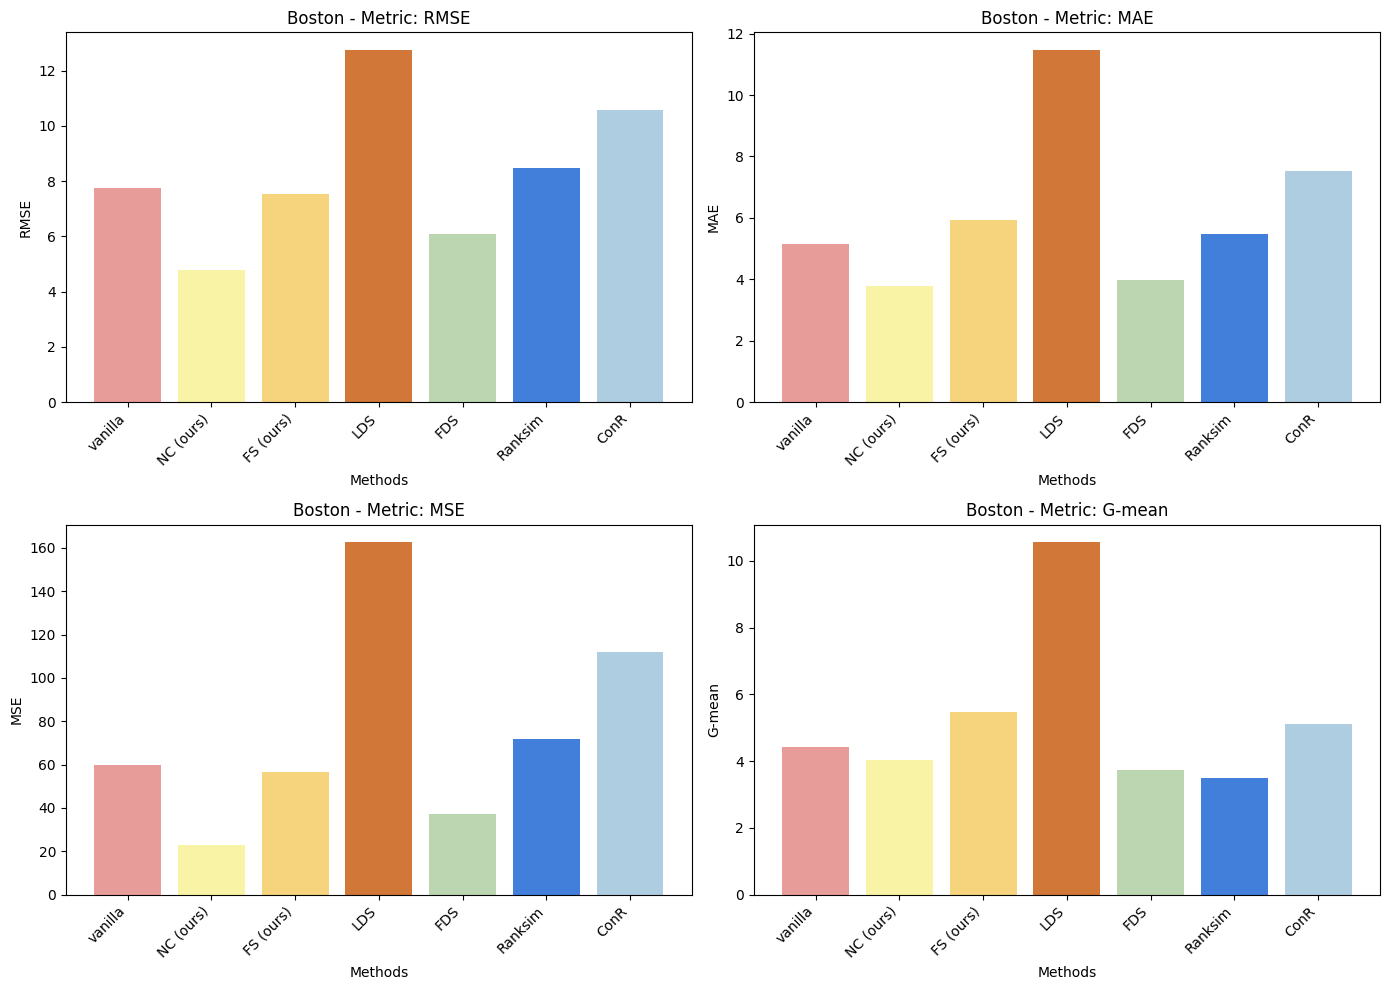

In [171]:
def main():

    X, y = df.drop([actual_col], axis=1).dropna().reset_index(drop=True).values, df[actual_col].dropna().reset_index(drop=True).values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    # Correct model instantiation
    input_features = X_train.shape[1]

    # Scenario 1: Original Dataset
    models_original = train_models(X_train, y_train)
    evaluations_original = evaluate_models(models_original, X_test, y_test)
    print("original dataset:", evaluations_original)

    # Scenario 2: NC (ours)
    final_df_nc_raking = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/Boston_final_df_nc_raking.csv")
    X_train_nc, X_test_nc, y_train_nc, y_test_nc = custom_train_test_split(final_df_nc_raking, df, actual_col, test_size=0.3, random_state=42)
    y_combined = np.concatenate([y_train_nc, y_test_nc]) # for plotting
    models_nc = train_models(X_train_nc, y_train_nc)
    evaluations_nc_raking = evaluate_models(models_nc, X_test_nc, y_test_nc)
    print("Nearest Cell dataset:", evaluations_nc_raking)

    # Scenario 3: FS (ours)
    final_df_fs_raking = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/Boston_final_df_sn_raking.csv")
    X_train_fs_raking, X_test_fs_raking, y_train_fs_raking, y_test_fs_raking = custom_train_test_split(final_df_fs_raking, df, actual_col, test_size=0.3, random_state=42)
    y_combined = np.concatenate([y_train_fs_raking, y_test_fs_raking]) # for plotting
    models_fs_raking = train_models(X_train_fs_raking, y_train_fs_raking)
    evaluations_fs_raking = evaluate_models(models_fs_raking, X_test_fs_raking, y_test_fs_raking)
    print("Features Similarity dataset:", evaluations_fs_raking)
    
    # Scenario 4: LDS (Label Distribution Smoothing)
    X, y = df1.drop([actual_col, target_col, 'high_range', 'low_range'], axis=1).dropna().reset_index(drop=True).values, df1[actual_col].dropna().reset_index(drop=True).values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    train_weights = prepare_weights(labels=y_train.astype(int), reweight=None, max_target=int(max(y_train)))
    test_weights = prepare_weights(labels=y_test.astype(int), reweight=None, max_target=int(max(y_test)))
    models_lds = train_models(X_train, y_train, lds=True, weights=train_weights)
    evaluations_lds = evaluate_models(models_lds, X_test, y_test, lds=True, weights=test_weights)
    print("LDS dataset:", evaluations_lds)

    # Scenario 4: NC + LDS (Label Distribution Smoothing)
    df_nc = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/Boston_final_df_nc_raking.csv")
    X, y = df_nc.drop([actual_col], axis=1).dropna().reset_index(drop=True).values, df_nc[actual_col].dropna().reset_index(drop=True).values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    train_weights = prepare_weights(labels=y_train.astype(int), reweight=None, max_target=int(max(y_train)))
    test_weights = prepare_weights(labels=y_test.astype(int), reweight=None, max_target=int(max(y_test)))
    models_nc_lds = train_models(X_train, y_train, lds=True, weights=train_weights)
    evaluations_nc_lds = evaluate_models(models_nc_lds, X_test, y_test, lds=True, weights=test_weights)
    print("NC + LDS dataset:", evaluations_nc_lds)

    # Scenario 4: FS + LDS (Label Distribution Smoothing)
    df_fs = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/Boston_final_df_sn_raking.csv")
    X, y = df_fs.drop([actual_col], axis=1).dropna().reset_index(drop=True).values, df_fs[actual_col].dropna().reset_index(drop=True).values  
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    train_weights = prepare_weights(labels=y_train.astype(int), reweight=None, max_target=int(max(y_train)))
    test_weights = prepare_weights(labels=y_test.astype(int), reweight=None, max_target=int(max(y_test)))
    models_fs_lds = train_models(X_train, y_train, lds=True, weights=train_weights)
    evaluations_fs_lds = evaluate_models(models_fs_lds, X_test, y_test, lds=True, weights=test_weights)
    print("FS + LDS dataset:", evaluations_fs_lds)

    # Scenario 5: FDS (Feature Distribution Smoothing)
    X, y = df1.drop([actual_col, target_col, 'high_range', 'low_range'], axis=1).dropna().reset_index(drop=True).values, df1[actual_col].dropna().reset_index(drop=True).values
    #X, y = df1.drop([actual_col], axis=1).dropna().reset_index(drop=True).values, df1[actual_col].dropna().reset_index(drop=True).values
    X_train_fds, X_test_fds, y_train_fds, y_test_fds = train_test_split(X, y, test_size=0.3, random_state=42)
    models_fds = train_models(X_train_fds, y_train_fds, fds=True)
    evaluations_fds = evaluate_models(models_fds, X_test_fds, y_test_fds)
    print("FDS dataset:", evaluations_fds)

    # Scenario 5: NC + FDS (Feature Distribution Smoothing)
    df_nc = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/Boston_final_df_nc_raking.csv")
    X, y = df_nc.drop([actual_col], axis=1).dropna().reset_index(drop=True).values, df_nc[actual_col].dropna().reset_index(drop=True).values
    X_train_fds, X_test_fds, y_train_fds, y_test_fds = train_test_split(X, y, test_size=0.3, random_state=42)
    models_nc_fds = train_models(X_train_fds, y_train_fds, fds=True)
    evaluations_nc_fds = evaluate_models(models_nc_fds, X_test_fds, y_test_fds)
    print("NC + FDS dataset:", evaluations_nc_fds)

    # Scenario 5: FS + FDS (Feature Distribution Smoothing)
    df_fs = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/Boston_final_df_sn_raking.csv")
    X, y = df_fs.drop([actual_col], axis=1).dropna().reset_index(drop=True).values, df_fs[actual_col].dropna().reset_index(drop=True).values
    X_train_fds, X_test_fds, y_train_fds, y_test_fds = train_test_split(X, y, test_size=0.3, random_state=42)
    models_fs_fds = train_models(X_train_fds, y_train_fds, fds=True)
    evaluations_fs_fds = evaluate_models(models_fs_fds, X_test_fds, y_test_fds)
    print("FS + FDS dataset:", evaluations_fs_fds)

    # Scenario 6: LDS + FDS
    X, y = df1.drop([actual_col, target_col, 'high_range', 'low_range'], axis=1).dropna().reset_index(drop=True).values, df1[actual_col].dropna().reset_index(drop=True).values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    train_weights = prepare_weights(labels=y_train.astype(int), reweight=None, max_target=int(max(y_train)))
    test_weights = prepare_weights(labels=y_test.astype(int), reweight=None, max_target=int(max(y_test)))
    models_lds_fds = train_models(X_train, y_train, lds=True, fds=True, weights=train_weights)
    evaluations_lds_fds = evaluate_models(models_lds_fds, X_test, y_test, lds=True, weights=test_weights)
    print("LDS + FDS dataset:", evaluations_lds_fds)

    # Scenario 6: NC + LDS + FDS
    df_nc = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/Boston_final_df_nc_raking.csv")
    X, y = df_nc.drop([actual_col], axis=1).dropna().reset_index(drop=True).values, df_nc[actual_col].dropna().reset_index(drop=True).values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    train_weights = prepare_weights(labels=y_train.astype(int), reweight=None, max_target=int(max(y_train)))
    test_weights = prepare_weights(labels=y_test.astype(int), reweight=None, max_target=int(max(y_test)))
    models_nc_lds_fds = train_models(X_train, y_train, lds=True, fds=True, weights=train_weights)
    evaluations_nc_lds_fds = evaluate_models(models_nc_lds_fds, X_test, y_test, lds=True, weights=test_weights)
    print("NC + LDS + FDS dataset:", evaluations_nc_lds_fds)

    # Scenario 6: FS + LDS + FDS
    df_fs = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/Boston_final_df_sn_raking.csv")
    X, y = df_fs.drop([actual_col], axis=1).dropna().reset_index(drop=True).values, df_fs[actual_col].dropna().reset_index(drop=True).values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    train_weights = prepare_weights(labels=y_train.astype(int), reweight=None, max_target=int(max(y_train)))
    test_weights = prepare_weights(labels=y_test.astype(int), reweight=None, max_target=int(max(y_test)))
    models_fs_lds_fds = train_models(X_train, y_train, lds=True, fds=True, weights=train_weights)
    evaluations_fs_lds_fds = evaluate_models(models_fs_lds_fds, X_test, y_test, lds=True, weights=test_weights)
    print("FS + LDS + FDS dataset:", evaluations_fs_lds_fds)

    # Scenario 7: Ranksim
    ranksim_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_boston_regression_model.pth'
    reg_model.load_state_dict(torch.load(ranksim_path))
    _, val_indices = train_test_split(np.arange(len(df)), test_size=0.3, random_state=42)
    X_orig = df.drop([actual_col], axis=1).dropna().reset_index(drop=True).values
    y_orig = df[actual_col].dropna().reset_index(drop=True).values
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = BostonDataset(X_orig[val_indices], y_orig[val_indices], weights=val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_ranksim = validate_ranksim(val_loader, reg_model, lds=False, train_labels=None, prefix='Val')
    print("Ranksim dataset:", evaluations_ranksim)

    # Scenario 7: NC + Ranksim
    ranksim_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_boston_nc_regression_model.pth'
    reg_model.load_state_dict(torch.load(ranksim_path))
    _, val_indices = train_test_split(np.arange(len(df)), test_size=0.3, random_state=42)
    X_orig = df.drop([actual_col], axis=1).dropna().reset_index(drop=True).values
    y_orig = df[actual_col].dropna().reset_index(drop=True).values
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = BostonDataset(X_orig[val_indices], y_orig[val_indices], weights=val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_nc_ranksim = validate_ranksim(val_loader, reg_model, lds=False, train_labels=None, prefix='Val')
    print("NC + Ranksim dataset:", evaluations_nc_ranksim)

    # Scenario 7: NC + Ranksim
    ranksim_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_boston_fs_regression_model.pth'
    reg_model.load_state_dict(torch.load(ranksim_path))
    _, val_indices = train_test_split(np.arange(len(df)), test_size=0.3, random_state=42)
    X_orig = df.drop([actual_col], axis=1).dropna().reset_index(drop=True).values
    y_orig = df[actual_col].dropna().reset_index(drop=True).values
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = BostonDataset(X_orig[val_indices], y_orig[val_indices], weights=val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_fs_ranksim = validate_ranksim(val_loader, reg_model, lds=False, train_labels=None, prefix='Val')
    print("FS + Ranksim dataset:", evaluations_fs_ranksim)

    # Scenario 8: Ranksim + LDS Validation
    ranksim_lds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_boston_regression_model_with_LDS.pth'
    reg_model.load_state_dict(torch.load(ranksim_lds_path))
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = BostonDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_ranksim_lds = validate_ranksim(val_loader, reg_model, lds=True, train_labels=None, prefix='Val')
    print("Ranksim + LDS dataset:", evaluations_ranksim_lds)

    # Scenario 8: NC + Ranksim + LDS Validation
    ranksim_lds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_boston_nc_regression_model_with_LDS.pth'
    reg_model.load_state_dict(torch.load(ranksim_lds_path))
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = BostonDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_nc_ranksim_lds = validate_ranksim(val_loader, reg_model, lds=True, train_labels=None, prefix='Val')
    print("NC + Ranksim + LDS dataset:", evaluations_nc_ranksim_lds)

    # Scenario 8: FS + Ranksim + LDS Validation
    ranksim_lds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_boston_fs_regression_model_with_LDS.pth'
    reg_model.load_state_dict(torch.load(ranksim_lds_path))
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = BostonDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_fs_ranksim_lds = validate_ranksim(val_loader, reg_model, lds=True, train_labels=None, prefix='Val')
    print("FS+ Ranksim + LDS dataset:", evaluations_fs_ranksim_lds)

    # Scenario 9: Ranksim + FDS Validation
    ranksim_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_boston_regression_model_with_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(ranksim_fds_path))
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = BostonDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_ranksim_fds = validate_ranksim(val_loader, reg_model_fds, lds=False, train_labels=None, prefix='Val')
    print("Ranksim + FDS dataset:", evaluations_ranksim_fds)

    # Scenario 9: NC + Ranksim + FDS Validation
    ranksim_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_boston_nc_regression_model_with_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(ranksim_fds_path))
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = BostonDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_nc_ranksim_fds = validate_ranksim(val_loader, reg_model_fds, lds=False, train_labels=None, prefix='Val')
    print("NC + Ranksim + FDS dataset:", evaluations_nc_ranksim_fds)

    # Scenario 9: FS + Ranksim + FDS Validation
    ranksim_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_boston_fs_regression_model_with_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(ranksim_fds_path))
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = BostonDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_fs_ranksim_fds = validate_ranksim(val_loader, reg_model_fds, lds=False, train_labels=None, prefix='Val')
    print("FS + Ranksim + FDS dataset:", evaluations_fs_ranksim_fds)
    
    # Scenario 10: Ranksim+ LDS + FDS Validation
    ranksim_lds_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_boston_regression_model_with_LDS_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(ranksim_lds_fds_path))
    # Split dataset into training and validation sets
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = BostonDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_ranksim_lds_fds = validate_ranksim(val_loader, reg_model_fds, lds=True, train_labels=None, prefix='Val')
    print("Ranksim + LDS + FDS dataset:", evaluations_ranksim_lds_fds)

    # Scenario 10: NC + Ranksim + LDS + FDS Validation
    ranksim_lds_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_boston_nc_regression_model_with_LDS_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(ranksim_lds_fds_path))
    # Split dataset into training and validation sets
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = BostonDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_nc_ranksim_lds_fds = validate_ranksim(val_loader, reg_model_fds, lds=True, train_labels=None, prefix='Val')
    print("NC + Ranksim + LDS + FDS dataset:", evaluations_nc_ranksim_lds_fds)

    # Scenario 10: FS + Ranksim + LDS + FDS Validation
    ranksim_lds_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_boston_fs_regression_model_with_LDS_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(ranksim_lds_fds_path))
    # Split dataset into training and validation sets
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = BostonDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_fs_ranksim_lds_fds = validate_ranksim(val_loader, reg_model_fds, lds=True, train_labels=None, prefix='Val')
    print("FS + Ranksim + LDS + FDS dataset:", evaluations_fs_ranksim_lds_fds)

    # Scenario 11: ConR
    conr_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_boston_regression_model_ConR.pth'
    reg_model.load_state_dict(torch.load(conr_path))
    _, val_indices = train_test_split(np.arange(len(df)), test_size=0.3, random_state=42)
    X_orig = df.drop([actual_col], axis=1).dropna().reset_index(drop=True).values
    y_orig = df[actual_col].dropna().reset_index(drop=True).values
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = BostonDataset(X_orig[val_indices], y_orig[val_indices], weights=val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_conr = validate_ranksim(val_loader, reg_model, lds=False, train_labels=None, prefix='Val')
    print("ConR dataset:", evaluations_conr)

    # Scenario 11: NC + ConR
    conr_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_boston_nc_regression_model_ConR.pth'
    reg_model.load_state_dict(torch.load(conr_path))
    _, val_indices = train_test_split(np.arange(len(df)), test_size=0.3, random_state=42)
    X_orig = df.drop([actual_col], axis=1).dropna().reset_index(drop=True).values
    y_orig = df[actual_col].dropna().reset_index(drop=True).values
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = BostonDataset(X_orig[val_indices], y_orig[val_indices], weights=val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_nc_conr = validate_ranksim(val_loader, reg_model, lds=False, train_labels=None, prefix='Val')
    print("NC + ConR dataset:", evaluations_nc_conr)
    
    # Scenario 11: FS + ConR
    conr_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_boston_fs_regression_model_ConR.pth'
    reg_model.load_state_dict(torch.load(conr_path))
    _, val_indices = train_test_split(np.arange(len(df)), test_size=0.3, random_state=42)
    X_orig = df.drop([actual_col], axis=1).dropna().reset_index(drop=True).values
    y_orig = df[actual_col].dropna().reset_index(drop=True).values
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = BostonDataset(X_orig[val_indices], y_orig[val_indices], weights=val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_fs_conr = validate_ranksim(val_loader, reg_model, lds=False, train_labels=None, prefix='Val')
    print("FS + ConR dataset:", evaluations_fs_conr)
            
    # Scenario 12: ConR + LDS Validation
    conr_lds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_boston_regression_model_ConR_with_LDS.pth'
    reg_model.load_state_dict(torch.load(conr_lds_path))
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = BostonDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_conr_lds = validate_ranksim(val_loader, reg_model, lds=True, train_labels=None, prefix='Val')
    print("ConR + LDS dataset:", evaluations_conr_lds)

    # Scenario 12: NC + ConR + LDS Validation
    conr_lds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_boston_nc_regression_model_ConR_with_LDS.pth'
    reg_model.load_state_dict(torch.load(conr_lds_path))
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = BostonDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_nc_conr_lds = validate_ranksim(val_loader, reg_model, lds=True, train_labels=None, prefix='Val')
    print("NC + ConR + LDS dataset:", evaluations_nc_conr_lds)

    # Scenario 12: FS + ConR + LDS Validation
    conr_lds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_boston_fs_regression_model_ConR_with_LDS.pth'
    reg_model.load_state_dict(torch.load(conr_lds_path))
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = BostonDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_fs_conr_lds = validate_ranksim(val_loader, reg_model, lds=True, train_labels=None, prefix='Val')
    print("FS + ConR + LDS dataset:", evaluations_fs_conr_lds)

    # Scenario 13: ConR + FDS Validation
    conr_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_boston_regression_model_ConR_with_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(conr_fds_path))
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = BostonDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_conr_fds = validate_ranksim(val_loader, reg_model_fds, lds=False, train_labels=None, prefix='Val')
    print("ConR + FDS dataset:", evaluations_conr_fds)

    # Scenario 13: NC + ConR + FDS Validation
    conr_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_boston_nc_regression_model_ConR_with_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(conr_fds_path))
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = BostonDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_nc_conr_fds = validate_ranksim(val_loader, reg_model_fds, lds=False, train_labels=None, prefix='Val')
    print("NC + ConR + FDS dataset:", evaluations_nc_conr_fds)

    # Scenario 13: FS + ConR + FDS Validation
    conr_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_boston_nc_regression_model_ConR_with_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(conr_fds_path))
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = BostonDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_fs_conr_fds = validate_ranksim(val_loader, reg_model_fds, lds=False, train_labels=None, prefix='Val')
    print("FS + ConR + FDS dataset:", evaluations_fs_conr_fds)
    
    # Scenario 14: ConR + LDS + FDS Validation
    conr_lds_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_boston_regression_model_ConR_with_LDS_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(conr_lds_fds_path))
    # Split dataset into training and validation sets
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = BostonDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_conr_lds_fds = validate_ranksim(val_loader, reg_model_fds, lds=True, train_labels=None, prefix='Val')
    print("Ranksim + LDS + FDS dataset:", evaluations_conr_lds_fds)

    # Scenario 14: NC + ConR + LDS + FDS Validation
    conr_lds_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_boston_nc_regression_model_ConR_with_LDS_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(conr_lds_fds_path))
    # Split dataset into training and validation sets
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = BostonDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_nc_conr_lds_fds = validate_ranksim(val_loader, reg_model_fds, lds=True, train_labels=None, prefix='Val')
    print("NC + Ranksim + LDS + FDS dataset:", evaluations_nc_conr_lds_fds)

    # Scenario 14: FS + ConR + LDS + FDS Validation
    conr_lds_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_boston_fs_regression_model_ConR_with_LDS_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(conr_lds_fds_path))
    # Split dataset into training and validation sets
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = BostonDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_fs_conr_lds_fds = validate_ranksim(val_loader, reg_model_fds, lds=True, train_labels=None, prefix='Val')
    print("FS + Ranksim + LDS + FDS dataset:", evaluations_fs_conr_lds_fds)

    # Calculate averages for each sampling method
    evaluations_dict = {
        'vanilla': evaluations_original,
        'NC (ours)': evaluations_nc_raking,
        'FS (ours)': evaluations_fs_raking,
        'LDS': evaluations_lds,
        'NC + LDS': evaluations_nc_lds,
        'FS + LDS': evaluations_fs_lds,
        'FDS': evaluations_fds,
        'NC + FDS': evaluations_nc_fds,
        'FS + FDS': evaluations_fs_fds,
        'LDS + FDS': evaluations_lds_fds,
        'NC + LDS + FDS': evaluations_nc_lds_fds,
        'FS + LDS + FDS': evaluations_nc_lds_fds,
        'Ranksim': evaluations_ranksim,
        'NC + Ranksim': evaluations_nc_ranksim,
        'FS + Ranksim': evaluations_fs_ranksim,
        'Ranksim + LDS': evaluations_ranksim_lds, 
        'NC + Ranksim + LDS': evaluations_nc_ranksim_lds, 
        'FS + Ranksim + LDS': evaluations_fs_ranksim_lds, 
        'Ranksim + FDS': evaluations_ranksim_fds,
        'NC + Ranksim + FDS': evaluations_nc_ranksim_fds,
        'FS + Ranksim + FDS': evaluations_fs_ranksim_fds,
        'Ranksim + LDS + FDS': evaluations_ranksim_lds_fds,  
        'NC + Ranksim + LDS + FDS': evaluations_nc_ranksim_lds_fds, 
        'FS + Ranksim + LDS + FDS': evaluations_fs_ranksim_lds_fds, 
        'ConR': evaluations_conr,
        'NC + ConR': evaluations_nc_conr,
        'FS + ConR': evaluations_fs_conr,
        "ConR + LDS": evaluations_conr_lds,
        "NC + ConR + LDS": evaluations_nc_conr_lds,
        "FS + ConR + LDS": evaluations_fs_conr_lds,
        "ConR + FDS": evaluations_conr_fds,
        "NC + ConR + FDS": evaluations_nc_conr_fds,
        "FS + ConR + FDS": evaluations_fs_conr_fds,
        "ConR + LDS + FDS": evaluations_conr_lds_fds,
        "NC + ConR + LDS + FDS": evaluations_nc_conr_lds_fds,
        "FS + ConR + LDS + FDS": evaluations_fs_conr_lds_fds
    }

    average_dict = {}
    for key, evaluations in evaluations_dict.items():
        average_dict[key] = calculate_averages(evaluations, is_ranksim=(key in ['Ranksim', 'ConR','Ranksim + LDS','Ranksim + FDS','Ranksim + LDS + FDS',
                                                                                "ConR + LDS","ConR + FDS","ConR + LDS + FDS", 'NC + Ranksim', 'FS + Ranksim', 
                                                                                'NC + Ranksim + LDS', 'FS + Ranksim + LDS', 'NC + Ranksim + FDS', 'FS + Ranksim + FDS', 
                                                                                'NC + Ranksim + LDS + FDS', 'FS + Ranksim + LDS + FDS', 'NC + ConR', 'FS + ConR', 
                                                                                "NC + ConR + LDS", "FS + ConR + LDS", "NC + ConR + FDS", "FS + ConR + FDS", 
                                                                                "NC + ConR + LDS + FDS", "FS + ConR + LDS + FDS"]), 
                                               select_best=False) #(key in ['NC_calibration', 'FS_calibration'])

     # Transform the dictionaries to match the expected structure for plotting
    average_dict_transformed = {method: {metric: average_dict[method][metric] for metric in ['RMSE', 'MAE', 'MSE', 'G-mean']} for method in evaluations_dict.keys()}

    # Create DataFrames for the averages
    average_df = pd.DataFrame(average_dict_transformed).T
    print(average_df)

    # Plot average comparisons
    methods = ['vanilla', 'NC (ours)', 'FS (ours)', 'LDS', 'FDS', 'Ranksim','ConR']
    plot_average_comparisons(average_dict, methods, dataset_name='Boston',
                             save_path='/home/Imbalanced_Regression/Results/boston_average_comparisons.png')
    
    # plot_distribution_comparison(y, y_combined, K, dataset_name='Boston', 
    #                              save_path='/home/Imbalanced_Regression/Results/Boston_dist_comparisons.png')
    
    # Export the DataFrame to a CSV file
    average_df.to_csv(f'/home/Imbalanced_Regression/Results/boston_K_{K}_mj_{mj}_average_evaluations.csv')
    # save_combined_evaluations_to_csv(evaluations_dict, f'/home/Imbalanced_Regression/Results/boston_K_{K}_mj_{mj}_combined_evaluations_v2.csv')


    # download the balanced dataset
    # final_df_nc_raking.to_csv('/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/Boston_final_df_nc_raking.csv', index=False)
    # final_df_sn_raking.to_csv('/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/Boston_final_df_sn_raking.csv', index=False)
    # files.download('Boston_final_df_nc_raking.csv')
    # files.download('Boston_final_df_sn_raking.csv')


if __name__ == "__main__":
    main()

#### 1-2 - Iterations

Metrics for mlp: RMSE=6.68, MAE=4.30, MSE=44.61, G-mean=3.88
evaluations_original: {'mlp': {'RMSE': 6.678969851281855, 'MAE': 4.295669136549297, 'MSE': 44.608638274331966, 'G-mean': 3.880743033508066}}
Using LDS: [GAUSSIAN] (5/2)
Using LDS: [GAUSSIAN] (5/2)
Metrics for mlp: RMSE=9.54, MAE=8.26, MSE=91.06, G-mean=7.75
evaluations_lds: {'mlp': {'RMSE': 9.542622307597203, 'MAE': 8.258434909895847, 'MSE': 91.06164050545175, 'G-mean': 7.748519116757764}}
Metrics for mlp: RMSE=6.46, MAE=4.21, MSE=41.70, G-mean=3.88
evaluations_fds: {'mlp': {'RMSE': 6.457880280085945, 'MAE': 4.210345285817196, 'MSE': 41.70421771192292, 'G-mean': 3.8772939471190058}}
Using LDS: [GAUSSIAN] (5/2)
Using LDS: [GAUSSIAN] (5/2)
Metrics for mlp: RMSE=9.88, MAE=8.80, MSE=97.54, G-mean=8.61
evaluations_nc_lds: {'mlp': {'RMSE': 9.876097, 'MAE': 8.801587, 'MSE': 97.53729, 'G-mean': 8.611878}}
Metrics for mlp: RMSE=6.33, MAE=5.22, MSE=40.11, G-mean=5.02
evaluations_nc_fds: {'mlp': {'RMSE': 6.3334436, 'MAE': 5.224593, 'MSE

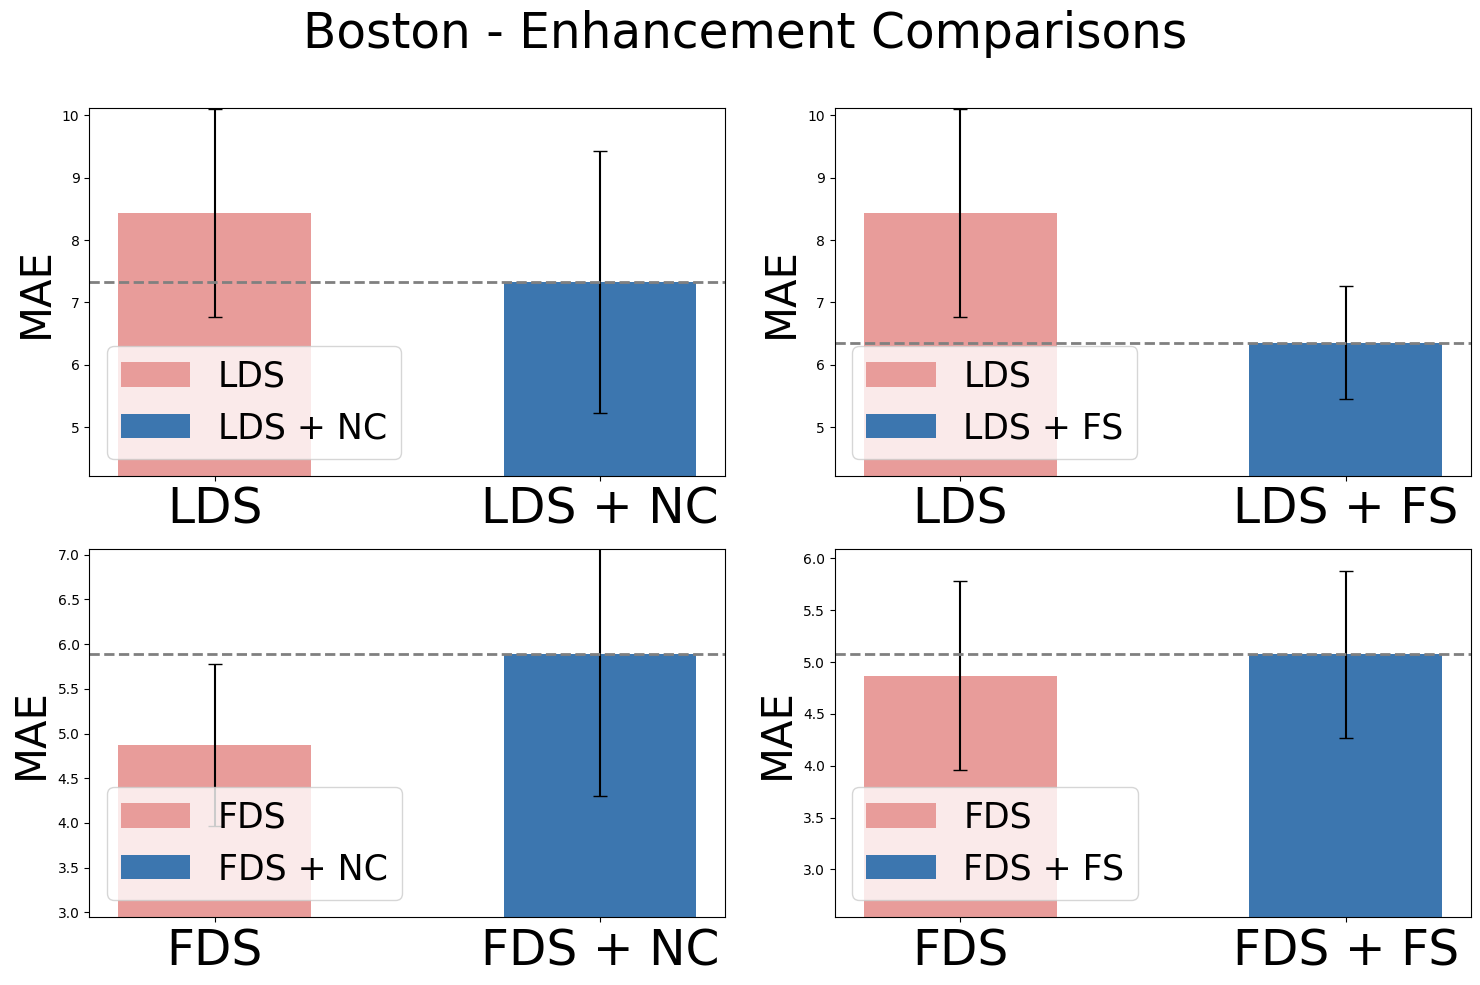

In [256]:
def main():
    iterations = 5
    results = []

    for iteration in range(iterations):
        X, y = df.drop([actual_col], axis=1).dropna().reset_index(drop=True).values, df[actual_col].dropna().reset_index(drop=True).values
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        input_features = X_train.shape[1]

        # Scenario 1: Original Dataset
        models_original = train_models(X_train, y_train)
        evaluations_original = evaluate_models(models_original, X_test, y_test)
        print(f"evaluations_original: {evaluations_original}")  # Debugging print statement
        if not isinstance(evaluations_original, dict):
            print(f"Error: evaluations_original is not a dictionary")
            continue
        
        # Scenario 4: LDS (Label Distribution Smoothing)
        X, y = df1.drop([actual_col, target_col, 'high_range', 'low_range'], axis=1).dropna().reset_index(drop=True).values, df1[actual_col].dropna().reset_index(drop=True).values
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        train_weights = prepare_weights(labels=y_train.astype(int), reweight=None, max_target=int(max(y_train)))
        test_weights = prepare_weights(labels=y_test.astype(int), reweight=None, max_target=int(max(y_test)))
        models_lds = train_models(X_train, y_train, lds=True, weights=train_weights)
        evaluations_lds = evaluate_models(models_lds, X_test, y_test, lds=True, weights=test_weights)
        print(f"evaluations_lds: {evaluations_lds}")  # Debugging print statement
        if not isinstance(evaluations_lds, dict):
            print(f"Error: evaluations_lds is not a dictionary")
            continue

        # Scenario 7: FDS (Feature Distribution Smoothing)
        X, y = df1.drop([actual_col, target_col, 'low_range', 'high_range'], axis=1).dropna().reset_index(drop=True).values, df1[actual_col].dropna().reset_index(drop=True).values
        X_train_fds, X_test_fds, y_train_fds, y_test_fds = train_test_split(X, y, test_size=0.3, random_state=42)
        models_fds = train_models(X_train_fds, y_train_fds, fds=True)
        evaluations_fds = evaluate_models(models_fds, X_test_fds, y_test_fds)
        print(f"evaluations_fds: {evaluations_fds}")  # Debugging print statement
        if not isinstance(evaluations_fds, dict):
            print(f"Error: evaluations_fds is not a dictionary")
            continue

        # Scenario 2: NC+LDS
        final_df_nc_raking = pd.read_csv('/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/Boston_final_df_nc_raking.csv')
        X_train_nc, X_test_nc, y_train_nc, y_test_nc = custom_train_test_split(final_df_nc_raking, df, actual_col, test_size=0.3, random_state=42)
        train_weights = prepare_weights(labels=y_train_nc.astype(int), reweight=None, max_target=int(max(y_train_nc)))
        test_weights = prepare_weights(labels=y_test_nc.astype(int), reweight=None, max_target=int(max(y_test_nc)))
        models_nc_lds = train_models(X_train_nc, y_train_nc, lds=True, weights=train_weights)
        evaluations_nc_lds = evaluate_models(models_nc_lds, X_test_nc, y_test_nc, lds=True, weights=test_weights)
        print(f"evaluations_nc_lds: {evaluations_nc_lds}")  # Debugging print statement
        if not isinstance(evaluations_nc_lds, dict):
            print(f"Error: evaluations_nc_lds is not a dictionary")
            continue

        # Scenario 3: NC+FDS
        X_train_nc, X_test_nc, y_train_nc, y_test_nc = custom_train_test_split(final_df_nc_raking, df, actual_col, test_size=0.3, random_state=42)
        models_nc_fds = train_models(X_train_nc, y_train_nc, fds=True)
        evaluations_nc_fds = evaluate_models(models_nc_fds, X_test_nc, y_test_nc)
        print(f"evaluations_nc_fds: {evaluations_nc_fds}")  # Debugging print statement
        if not isinstance(evaluations_nc_fds, dict):
            print(f"Error: evaluations_nc_fds is not a dictionary")
            continue

        # Scenario 4: FS+LDS
        final_df_sn_raking = pd.read_csv('/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/Boston_final_df_sn_raking.csv')
        X_train_sn_raking, X_test_sn_raking, y_train_sn_raking, y_test_sn_raking = custom_train_test_split(final_df_sn_raking, df, actual_col, test_size=0.3, random_state=42)
        train_weights = prepare_weights(labels=y_train_sn_raking.astype(int), reweight=None, max_target=int(max(y_train_sn_raking)))
        test_weights = prepare_weights(labels=y_test_sn_raking.astype(int), reweight=None, max_target=int(max(y_test_sn_raking)))
        models_fs_lds = train_models(X_train_sn_raking, y_train_sn_raking, lds=True, weights=train_weights)
        evaluations_fs_lds = evaluate_models(models_fs_lds, X_test_sn_raking, y_test_sn_raking, lds=True, weights=test_weights)
        print(f"evaluations_fs_lds: {evaluations_fs_lds}")  # Debugging print statement
        if not isinstance(evaluations_fs_lds, dict):
            print(f"Error: evaluations_fs_lds is not a dictionary")
            continue

        # Scenario 5: FS+FDS
        X_train_sn_raking, X_test_sn_raking, y_train_sn_raking, y_test_sn_raking = custom_train_test_split(final_df_sn_raking, df, actual_col, test_size=0.3, random_state=42)
        models_fs_fds = train_models(X_train_sn_raking, y_train_sn_raking, fds=True)
        evaluations_fs_fds = evaluate_models(models_fs_fds, X_test_sn_raking, y_test_sn_raking)
        print(f"evaluations_fs_fds: {evaluations_fs_fds}")  # Debugging print statement
        if not isinstance(evaluations_fs_fds, dict):
            print(f"Error: evaluations_fs_fds is not a dictionary")
            continue

        # Save all the results for the current iteration
        evaluations_dict = {
            'LDS': evaluations_lds,
            'nc_lds': evaluations_nc_lds,
            'fs_lds': evaluations_fs_lds,
            'FDS': evaluations_fds,
            'nc_fds': evaluations_nc_fds,
            'fs_fds': evaluations_fs_fds
        }

        for key, evaluations in evaluations_dict.items():
            average_metrics = calculate_averages2(evaluations, is_ranksim=False, select_best=False)
            if not isinstance(average_metrics, dict):
                print(f"Error: average_metrics for {key} is not a dictionary")
                continue
            for metric, value in average_metrics.items():
                result = {'iteration': iteration, 'scenario': key, 'metric': metric, 'value': value}
                print(f"Appending result: {result}")  # Debugging print statement
                results.append(result)
                    
    # Convert results to DataFrame and save
    results_df = pd.DataFrame(results)
    print(f"Results DataFrame:\n{results_df}")  # Debugging print statement

    # Calculate averages for each sampling method
    average_dict = {}
    std_dict = {}
    for key, group in results_df.groupby('scenario'):
        group_metrics = group.pivot_table(values='value', index='iteration', columns='metric').mean().to_dict()
        average_metrics = {metric: group_metrics.get('MAE', float('nan')) for metric in ['MAE']}
        std_metrics = {metric: group.pivot_table(values='value', index='iteration', columns='metric').std().to_dict().get('MAE', float('nan')) for metric in ['MAE']}
        average_dict[key] = average_metrics
        std_dict[key] = std_metrics

    # Plot comparisons
    plot_enhancement_comparisons(average_dict, std_dict, dataset_name='Boston', save_path_prefix='/home/Imbalanced_Regression/Results/Enhancement')

if __name__ == "__main__":
    main()

### 2 - Run California Housing

#### 2-1 - Main training

In [732]:
class CaliforniaDataset(Dataset):
    def __init__(self, features, targets, weights, lds=False):
        self.features = features
        self.targets = targets
        self.weights = weights
        self.lds = lds

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
          feature = self.features[idx]
          target = self.targets[idx]
          weight = self.weights[idx]
          return feature, target, weight

Metrics for mlp: RMSE=0.90, MAE=0.68, MSE=0.80, G-mean=1.60
original dataset: {'mlp': {'RMSE': 0.8954025705310864, 'MAE': 0.6795394428065088, 'MSE': 0.8017457633136772, 'G-mean': 1.597752316273555}}
Metrics for mlp: RMSE=0.66, MAE=0.49, MSE=0.43, G-mean=1.44
Nearest Cell dataset: {'mlp': {'RMSE': 0.6593827, 'MAE': 0.4930498, 'MSE': 0.43478552, 'G-mean': 1.4410412}}
Metrics for mlp: RMSE=0.89, MAE=0.63, MSE=0.79, G-mean=1.54
Features Similarity dataset: {'mlp': {'RMSE': 0.88907784, 'MAE': 0.6272593, 'MSE': 0.79045945, 'G-mean': 1.5409186}}
Using LDS: [GAUSSIAN] (5/2)
Using LDS: [GAUSSIAN] (5/2)
Metrics for mlp: RMSE=0.92, MAE=0.75, MSE=0.84, G-mean=1.68
LDS dataset: {'mlp': {'RMSE': 0.9191520273267414, 'MAE': 0.7525813794702431, 'MSE': 0.8448404493388588, 'G-mean': 1.6794559781688354}}
Using LDS: [GAUSSIAN] (5/2)
Using LDS: [GAUSSIAN] (5/2)
Metrics for mlp: RMSE=0.83, MAE=0.63, MSE=0.69, G-mean=1.56
NC + LDS dataset: {'mlp': {'RMSE': 0.832141771910307, 'MAE': 0.6317698369892404, 'MSE': 

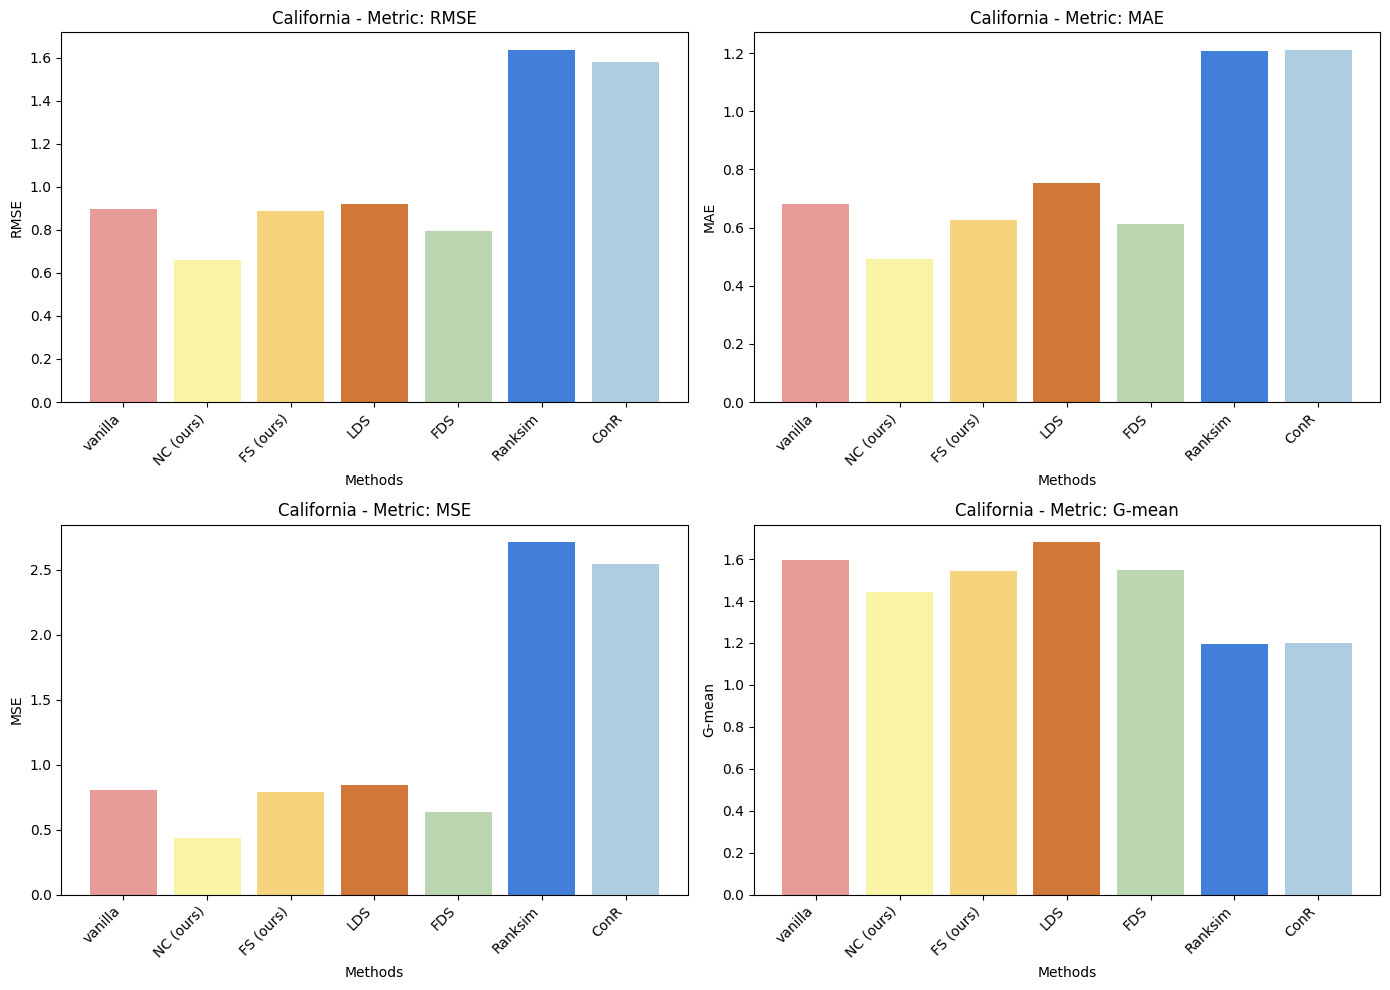

In [404]:
def main():

    X, y = df.drop([actual_col], axis=1).dropna().reset_index(drop=True).values, df[actual_col].dropna().reset_index(drop=True).values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    # Correct model instantiation
    input_features = X_train.shape[1]

    # Scenario 1: Original Dataset
    models_original = train_models(X_train, y_train)
    evaluations_original = evaluate_models(models_original, X_test, y_test)
    print("original dataset:", evaluations_original)

    # Scenario 2: Samples of nearest cells: Calibration Method
    final_df_nc_raking = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/California_final_df_nc_raking.csv")
    X_train_nc, X_test_nc, y_train_nc, y_test_nc = custom_train_test_split(final_df_nc_raking, df, actual_col, test_size=0.3, random_state=42)
    y_combined = np.concatenate([y_train_nc, y_test_nc]) # for plotting
    models_nc = train_models(X_train_nc, y_train_nc)
    evaluations_nc_raking = evaluate_models(models_nc, X_test_nc, y_test_nc)
    print("Nearest Cell dataset:", evaluations_nc_raking)

    # Scenario 3: Samples of Features Similarity: Calibration Method
    final_df_fs_raking = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/California_final_df_sn_raking.csv")
    X_train_fs_raking, X_test_fs_raking, y_train_fs_raking, y_test_fs_raking = custom_train_test_split(final_df_fs_raking, df, actual_col, test_size=0.3, random_state=42)
    y_combined = np.concatenate([y_train_fs_raking, y_test_fs_raking]) # for plotting
    models_fs_raking = train_models(X_train_fs_raking, y_train_fs_raking)
    evaluations_fs_raking = evaluate_models(models_fs_raking, X_test_fs_raking, y_test_fs_raking)
    print("Features Similarity dataset:", evaluations_fs_raking)
    
    # Scenario 4: LDS (Label Distribution Smoothing)
    X, y = df1.drop([actual_col, target_col, 'high_range', 'low_range'], axis=1).dropna().reset_index(drop=True).values, df1[actual_col].dropna().reset_index(drop=True).values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    train_weights = prepare_weights(labels=y_train.astype(int), reweight=None, max_target=int(max(y_train)))
    test_weights = prepare_weights(labels=y_test.astype(int), reweight=None, max_target=int(max(y_test)))
    models_lds = train_models(X_train, y_train, lds=True, weights=train_weights)
    evaluations_lds = evaluate_models(models_lds, X_test, y_test, lds=True, weights=test_weights)
    print("LDS dataset:", evaluations_lds)

    # Scenario 4: NC + LDS (Label Distribution Smoothing)
    df_nc = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/California_final_df_nc_raking.csv")
    X, y = df_nc.drop([actual_col], axis=1).dropna().reset_index(drop=True).values, df_nc[actual_col].dropna().reset_index(drop=True).values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    train_weights = prepare_weights(labels=y_train.astype(int), reweight=None, max_target=int(max(y_train)))
    test_weights = prepare_weights(labels=y_test.astype(int), reweight=None, max_target=int(max(y_test)))
    models_nc_lds = train_models(X_train, y_train, lds=True, weights=train_weights)
    evaluations_nc_lds = evaluate_models(models_nc_lds, X_test, y_test, lds=True, weights=test_weights)
    print("NC + LDS dataset:", evaluations_nc_lds)

    # Scenario 4: FS + LDS (Label Distribution Smoothing)
    df_fs = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/California_final_df_sn_raking.csv")
    X, y = df_fs.drop([actual_col], axis=1).dropna().reset_index(drop=True).values, df_fs[actual_col].dropna().reset_index(drop=True).values  
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    train_weights = prepare_weights(labels=y_train.astype(int), reweight=None, max_target=int(max(y_train)))
    test_weights = prepare_weights(labels=y_test.astype(int), reweight=None, max_target=int(max(y_test)))
    models_fs_lds = train_models(X_train, y_train, lds=True, weights=train_weights)
    evaluations_fs_lds = evaluate_models(models_fs_lds, X_test, y_test, lds=True, weights=test_weights)
    print("FS + LDS dataset:", evaluations_fs_lds)

    # Scenario 5: FDS (Feature Distribution Smoothing)
    X, y = df1.drop([actual_col, target_col, 'high_range', 'low_range'], axis=1).dropna().reset_index(drop=True).values, df1[actual_col].dropna().reset_index(drop=True).values
    X_train_fds, X_test_fds, y_train_fds, y_test_fds = train_test_split(X, y, test_size=0.3, random_state=42)
    models_fds = train_models(X_train_fds, y_train_fds, fds=True)
    evaluations_fds = evaluate_models(models_fds, X_test_fds, y_test_fds)
    print("FDS dataset:", evaluations_fds)

    # Scenario 5: NC + FDS (Feature Distribution Smoothing)
    df_nc = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/California_final_df_nc_raking.csv")
    X, y = df_nc.drop([actual_col], axis=1).dropna().reset_index(drop=True).values, df_nc[actual_col].dropna().reset_index(drop=True).values
    X_train_fds, X_test_fds, y_train_fds, y_test_fds = train_test_split(X, y, test_size=0.3, random_state=42)
    models_nc_fds = train_models(X_train_fds, y_train_fds, fds=True)
    evaluations_nc_fds = evaluate_models(models_nc_fds, X_test_fds, y_test_fds)
    print("NC + FDS dataset:", evaluations_nc_fds)

    # Scenario 5: FS + FDS (Feature Distribution Smoothing)
    df_fs = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/California_final_df_sn_raking.csv")
    X, y = df_fs.drop([actual_col], axis=1).dropna().reset_index(drop=True).values, df_fs[actual_col].dropna().reset_index(drop=True).values
    X_train_fds, X_test_fds, y_train_fds, y_test_fds = train_test_split(X, y, test_size=0.3, random_state=42)
    models_fs_fds = train_models(X_train_fds, y_train_fds, fds=True)
    evaluations_fs_fds = evaluate_models(models_fs_fds, X_test_fds, y_test_fds)
    print("FS + FDS dataset:", evaluations_fs_fds)

    # Scenario 6: LDS + FDS
    X, y = df1.drop([actual_col, target_col, 'high_range', 'low_range'], axis=1).dropna().reset_index(drop=True).values, df1[actual_col].dropna().reset_index(drop=True).values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    train_weights = prepare_weights(labels=y_train.astype(int), reweight=None, max_target=int(max(y_train)))
    test_weights = prepare_weights(labels=y_test.astype(int), reweight=None, max_target=int(max(y_test)))
    models_lds_fds = train_models(X_train, y_train, lds=True, fds=True, weights=train_weights)
    evaluations_lds_fds = evaluate_models(models_lds_fds, X_test, y_test, lds=True, weights=test_weights)
    print("LDS + FDS dataset:", evaluations_lds_fds)

    # Scenario 6: NC + LDS + FDS
    df_nc = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/California_final_df_nc_raking.csv")
    X, y = df_nc.drop([actual_col], axis=1).dropna().reset_index(drop=True).values, df_nc[actual_col].dropna().reset_index(drop=True).values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    train_weights = prepare_weights(labels=y_train.astype(int), reweight=None, max_target=int(max(y_train)))
    test_weights = prepare_weights(labels=y_test.astype(int), reweight=None, max_target=int(max(y_test)))
    models_nc_lds_fds = train_models(X_train, y_train, lds=True, fds=True, weights=train_weights)
    evaluations_nc_lds_fds = evaluate_models(models_nc_lds_fds, X_test, y_test, lds=True, weights=test_weights)
    print("NC + LDS + FDS dataset:", evaluations_nc_lds_fds)

    # Scenario 6: FS + LDS + FDS
    df_fs = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/California_final_df_sn_raking.csv")
    X, y = df_fs.drop([actual_col], axis=1).dropna().reset_index(drop=True).values, df_fs[actual_col].dropna().reset_index(drop=True).values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    train_weights = prepare_weights(labels=y_train.astype(int), reweight=None, max_target=int(max(y_train)))
    test_weights = prepare_weights(labels=y_test.astype(int), reweight=None, max_target=int(max(y_test)))
    models_fs_lds_fds = train_models(X_train, y_train, lds=True, fds=True, weights=train_weights)
    evaluations_fs_lds_fds = evaluate_models(models_fs_lds_fds, X_test, y_test, lds=True, weights=test_weights)
    print("FS + LDS + FDS dataset:", evaluations_fs_lds_fds)

    # Scenario 7: Ranksim
    ranksim_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_california_regression_model.pth'
    reg_model.load_state_dict(torch.load(ranksim_path))
    _, val_indices = train_test_split(np.arange(len(df)), test_size=0.3, random_state=42)
    X_orig = df.drop([actual_col], axis=1).dropna().reset_index(drop=True).values
    y_orig = df[actual_col].dropna().reset_index(drop=True).values
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = CaliforniaDataset(X_orig[val_indices], y_orig[val_indices], weights=val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_ranksim = validate_ranksim(val_loader, reg_model, lds=False, train_labels=None, prefix='Val')
    print("Ranksim dataset:", evaluations_ranksim)

    # Scenario 7: NC + Ranksim
    ranksim_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_california_nc_regression_model.pth'
    reg_model.load_state_dict(torch.load(ranksim_path))
    _, val_indices = train_test_split(np.arange(len(df)), test_size=0.3, random_state=42)
    X_orig = df.drop([actual_col], axis=1).dropna().reset_index(drop=True).values
    y_orig = df[actual_col].dropna().reset_index(drop=True).values
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = CaliforniaDataset(X_orig[val_indices], y_orig[val_indices], weights=val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_nc_ranksim = validate_ranksim(val_loader, reg_model, lds=False, train_labels=None, prefix='Val')
    print("NC + Ranksim dataset:", evaluations_nc_ranksim)

    # Scenario 7: NC + Ranksim
    ranksim_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_california_fs_regression_model.pth'
    reg_model.load_state_dict(torch.load(ranksim_path))
    _, val_indices = train_test_split(np.arange(len(df)), test_size=0.3, random_state=42)
    X_orig = df.drop([actual_col], axis=1).dropna().reset_index(drop=True).values
    y_orig = df[actual_col].dropna().reset_index(drop=True).values
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = CaliforniaDataset(X_orig[val_indices], y_orig[val_indices], weights=val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_fs_ranksim = validate_ranksim(val_loader, reg_model, lds=False, train_labels=None, prefix='Val')
    print("FS + Ranksim dataset:", evaluations_fs_ranksim)

    # Scenario 8: Ranksim + LDS Validation
    ranksim_lds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_california_regression_model_with_LDS.pth'
    reg_model.load_state_dict(torch.load(ranksim_lds_path))
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = CaliforniaDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_ranksim_lds = validate_ranksim(val_loader, reg_model, lds=True, train_labels=None, prefix='Val')
    print("Ranksim + LDS dataset:", evaluations_ranksim_lds)

    # Scenario 8: NC + Ranksim + LDS Validation
    ranksim_lds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_california_nc_regression_model_with_LDS.pth'
    reg_model.load_state_dict(torch.load(ranksim_lds_path))
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = CaliforniaDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_nc_ranksim_lds = validate_ranksim(val_loader, reg_model, lds=True, train_labels=None, prefix='Val')
    print("NC + Ranksim + LDS dataset:", evaluations_nc_ranksim_lds)

    # Scenario 8: FS + Ranksim + LDS Validation
    ranksim_lds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_california_fs_regression_model_with_LDS.pth'
    reg_model.load_state_dict(torch.load(ranksim_lds_path))
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = CaliforniaDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_fs_ranksim_lds = validate_ranksim(val_loader, reg_model, lds=True, train_labels=None, prefix='Val')
    print("FS+ Ranksim + LDS dataset:", evaluations_fs_ranksim_lds)

    # Scenario 9: Ranksim + FDS Validation
    ranksim_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_california_regression_model_with_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(ranksim_fds_path))
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = CaliforniaDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_ranksim_fds = validate_ranksim(val_loader, reg_model_fds, lds=False, train_labels=None, prefix='Val')
    print("Ranksim + FDS dataset:", evaluations_ranksim_fds)

    # Scenario 9: NC + Ranksim + FDS Validation
    ranksim_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_california_nc_regression_model_with_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(ranksim_fds_path))
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = CaliforniaDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_nc_ranksim_fds = validate_ranksim(val_loader, reg_model_fds, lds=False, train_labels=None, prefix='Val')
    print("NC + Ranksim + FDS dataset:", evaluations_nc_ranksim_fds)

    # Scenario 9: FS + Ranksim + FDS Validation
    ranksim_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_california_fs_regression_model_with_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(ranksim_fds_path))
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = CaliforniaDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_fs_ranksim_fds = validate_ranksim(val_loader, reg_model_fds, lds=False, train_labels=None, prefix='Val')
    print("FS + Ranksim + FDS dataset:", evaluations_fs_ranksim_fds)
    
    # Scenario 10: Ranksim+ LDS + FDS Validation
    ranksim_lds_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_california_regression_model_with_LDS_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(ranksim_lds_fds_path))
    # Split dataset into training and validation sets
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = CaliforniaDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_ranksim_lds_fds = validate_ranksim(val_loader, reg_model_fds, lds=True, train_labels=None, prefix='Val')
    print("Ranksim + LDS + FDS dataset:", evaluations_ranksim_lds_fds)

    # Scenario 10: NC + Ranksim + LDS + FDS Validation
    ranksim_lds_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_california_nc_regression_model_with_LDS_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(ranksim_lds_fds_path))
    # Split dataset into training and validation sets
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = CaliforniaDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_nc_ranksim_lds_fds = validate_ranksim(val_loader, reg_model_fds, lds=True, train_labels=None, prefix='Val')
    print("NC + Ranksim + LDS + FDS dataset:", evaluations_nc_ranksim_lds_fds)

    # Scenario 10: FS + Ranksim + LDS + FDS Validation
    ranksim_lds_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_california_fs_regression_model_with_LDS_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(ranksim_lds_fds_path))
    # Split dataset into training and validation sets
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = CaliforniaDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_fs_ranksim_lds_fds = validate_ranksim(val_loader, reg_model_fds, lds=True, train_labels=None, prefix='Val')
    print("FS + Ranksim + LDS + FDS dataset:", evaluations_fs_ranksim_lds_fds)

    # Scenario 11: ConR
    conr_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_california_regression_model_ConR.pth'
    reg_model.load_state_dict(torch.load(conr_path))
    _, val_indices = train_test_split(np.arange(len(df)), test_size=0.3, random_state=42)
    X_orig = df.drop([actual_col], axis=1).dropna().reset_index(drop=True).values
    y_orig = df[actual_col].dropna().reset_index(drop=True).values
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = CaliforniaDataset(X_orig[val_indices], y_orig[val_indices], weights=val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_conr = validate_ranksim(val_loader, reg_model, lds=False, train_labels=None, prefix='Val')
    print("ConR dataset:", evaluations_conr)

    # Scenario 11: NC + ConR
    conr_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_california_nc_regression_model_ConR.pth'
    reg_model.load_state_dict(torch.load(conr_path))
    _, val_indices = train_test_split(np.arange(len(df)), test_size=0.3, random_state=42)
    X_orig = df.drop([actual_col], axis=1).dropna().reset_index(drop=True).values
    y_orig = df[actual_col].dropna().reset_index(drop=True).values
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = CaliforniaDataset(X_orig[val_indices], y_orig[val_indices], weights=val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_nc_conr = validate_ranksim(val_loader, reg_model, lds=False, train_labels=None, prefix='Val')
    print("NC + ConR dataset:", evaluations_nc_conr)
    
    # Scenario 11: FS + ConR
    conr_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_california_fs_regression_model_ConR.pth'
    reg_model.load_state_dict(torch.load(conr_path))
    _, val_indices = train_test_split(np.arange(len(df)), test_size=0.3, random_state=42)
    X_orig = df.drop([actual_col], axis=1).dropna().reset_index(drop=True).values
    y_orig = df[actual_col].dropna().reset_index(drop=True).values
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = CaliforniaDataset(X_orig[val_indices], y_orig[val_indices], weights=val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_fs_conr = validate_ranksim(val_loader, reg_model, lds=False, train_labels=None, prefix='Val')
    print("FS + ConR dataset:", evaluations_fs_conr)
            
    # Scenario 12: ConR + LDS Validation
    conr_lds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_california_regression_model_ConR_with_LDS.pth'
    reg_model.load_state_dict(torch.load(conr_lds_path))
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = CaliforniaDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_conr_lds = validate_ranksim(val_loader, reg_model, lds=True, train_labels=None, prefix='Val')
    print("ConR + LDS dataset:", evaluations_conr_lds)

    # Scenario 12: NC + ConR + LDS Validation
    conr_lds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_california_nc_regression_model_ConR_with_LDS.pth'
    reg_model.load_state_dict(torch.load(conr_lds_path))
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = CaliforniaDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_nc_conr_lds = validate_ranksim(val_loader, reg_model, lds=True, train_labels=None, prefix='Val')
    print("NC + ConR + LDS dataset:", evaluations_nc_conr_lds)

    # Scenario 12: FS + ConR + LDS Validation
    conr_lds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_california_fs_regression_model_ConR_with_LDS.pth'
    reg_model.load_state_dict(torch.load(conr_lds_path))
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = CaliforniaDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_fs_conr_lds = validate_ranksim(val_loader, reg_model, lds=True, train_labels=None, prefix='Val')
    print("FS + ConR + LDS dataset:", evaluations_fs_conr_lds)

    # Scenario 13: ConR + FDS Validation
    conr_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_california_regression_model_ConR_with_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(conr_fds_path))
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = CaliforniaDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_conr_fds = validate_ranksim(val_loader, reg_model_fds, lds=False, train_labels=None, prefix='Val')
    print("ConR + FDS dataset:", evaluations_conr_fds)

    # Scenario 13: NC + ConR + FDS Validation
    conr_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_california_nc_regression_model_ConR_with_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(conr_fds_path))
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = CaliforniaDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_nc_conr_fds = validate_ranksim(val_loader, reg_model_fds, lds=False, train_labels=None, prefix='Val')
    print("NC + ConR + FDS dataset:", evaluations_nc_conr_fds)

    # Scenario 13: FS + ConR + FDS Validation
    conr_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_california_nc_regression_model_ConR_with_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(conr_fds_path))
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = CaliforniaDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_fs_conr_fds = validate_ranksim(val_loader, reg_model_fds, lds=False, train_labels=None, prefix='Val')
    print("FS + ConR + FDS dataset:", evaluations_fs_conr_fds)
    
    # Scenario 14: ConR + LDS + FDS Validation
    conr_lds_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_california_regression_model_ConR_with_LDS_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(conr_lds_fds_path))
    # Split dataset into training and validation sets
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = CaliforniaDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_conr_lds_fds = validate_ranksim(val_loader, reg_model_fds, lds=True, train_labels=None, prefix='Val')
    print("Ranksim + LDS + FDS dataset:", evaluations_conr_lds_fds)

    # Scenario 14: NC + ConR + LDS + FDS Validation
    conr_lds_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_california_nc_regression_model_ConR_with_LDS_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(conr_lds_fds_path))
    # Split dataset into training and validation sets
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = CaliforniaDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_nc_conr_lds_fds = validate_ranksim(val_loader, reg_model_fds, lds=True, train_labels=None, prefix='Val')
    print("NC + Ranksim + LDS + FDS dataset:", evaluations_nc_conr_lds_fds)

    # Scenario 14: FS + ConR + LDS + FDS Validation
    conr_lds_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_california_fs_regression_model_ConR_with_LDS_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(conr_lds_fds_path))
    # Split dataset into training and validation sets
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = CaliforniaDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_fs_conr_lds_fds = validate_ranksim(val_loader, reg_model_fds, lds=True, train_labels=None, prefix='Val')
    print("FS + Ranksim + LDS + FDS dataset:", evaluations_fs_conr_lds_fds)

    # Calculate averages for each sampling method
    evaluations_dict = {
        'vanilla': evaluations_original,
        'NC (ours)': evaluations_nc_raking,
        'FS (ours)': evaluations_fs_raking,
        'LDS': evaluations_lds,
        'NC + LDS': evaluations_nc_lds,
        'FS + LDS': evaluations_fs_lds,
        'FDS': evaluations_fds,
        'NC + FDS': evaluations_nc_fds,
        'FS + FDS': evaluations_fs_fds,
        'LDS + FDS': evaluations_lds_fds,
        'NC + LDS + FDS': evaluations_nc_lds_fds,
        'FS + LDS + FDS': evaluations_nc_lds_fds,
        'Ranksim': evaluations_ranksim,
        'NC + Ranksim': evaluations_nc_ranksim,
        'FS + Ranksim': evaluations_fs_ranksim,
        'Ranksim + LDS': evaluations_ranksim_lds, 
        'NC + Ranksim + LDS': evaluations_nc_ranksim_lds, 
        'FS + Ranksim + LDS': evaluations_fs_ranksim_lds, 
        'Ranksim + FDS': evaluations_ranksim_fds,
        'NC + Ranksim + FDS': evaluations_nc_ranksim_fds,
        'FS + Ranksim + FDS': evaluations_fs_ranksim_fds,
        'Ranksim + LDS + FDS': evaluations_ranksim_lds_fds,  
        'NC + Ranksim + LDS + FDS': evaluations_nc_ranksim_lds_fds, 
        'FS + Ranksim + LDS + FDS': evaluations_fs_ranksim_lds_fds, 
        'ConR': evaluations_conr,
        'NC + ConR': evaluations_nc_conr,
        'FS + ConR': evaluations_fs_conr,
        "ConR + LDS": evaluations_conr_lds,
        "NC + ConR + LDS": evaluations_nc_conr_lds,
        "FS + ConR + LDS": evaluations_fs_conr_lds,
        "ConR + FDS": evaluations_conr_fds,
        "NC + ConR + FDS": evaluations_nc_conr_fds,
        "FS + ConR + FDS": evaluations_fs_conr_fds,
        "ConR + LDS + FDS": evaluations_conr_lds_fds,
        "NC + ConR + LDS + FDS": evaluations_nc_conr_lds_fds,
        "FS + ConR + LDS + FDS": evaluations_fs_conr_lds_fds
    }

    average_dict = {}
    for key, evaluations in evaluations_dict.items():
        average_dict[key] = calculate_averages(evaluations, is_ranksim=(key in ['Ranksim', 'ConR','Ranksim + LDS','Ranksim + FDS','Ranksim + LDS + FDS',
                                                                                "ConR + LDS","ConR + FDS","ConR + LDS + FDS", 'NC + Ranksim', 'FS + Ranksim', 
                                                                                'NC + Ranksim + LDS', 'FS + Ranksim + LDS', 'NC + Ranksim + FDS', 'FS + Ranksim + FDS', 
                                                                                'NC + Ranksim + LDS + FDS', 'FS + Ranksim + LDS + FDS', 'NC + ConR', 'FS + ConR', 
                                                                                "NC + ConR + LDS", "FS + ConR + LDS", "NC + ConR + FDS", "FS + ConR + FDS", 
                                                                                "NC + ConR + LDS + FDS", "FS + ConR + LDS + FDS"]), 
                                               select_best=False) #(key in ['NC_calibration', 'FS_calibration'])

     # Transform the dictionaries to match the expected structure for plotting
    average_dict_transformed = {method: {metric: average_dict[method][metric] for metric in ['RMSE', 'MAE', 'MSE', 'G-mean']} for method in evaluations_dict.keys()}

    # Create DataFrames for the averages
    average_df = pd.DataFrame(average_dict_transformed).T
    print(average_df)

    # Plot average comparisons
    methods = ['vanilla', 'NC (ours)', 'FS (ours)', 'LDS', 'FDS', 'Ranksim','ConR']
    plot_average_comparisons(average_dict, methods, dataset_name='California',
                             save_path='/home/Imbalanced_Regression/Results/California_average_comparisons.png')
    
    # plot_distribution_comparison(y, y_combined, K, dataset_name='Boston', 
    #                              save_path='/home/Imbalanced_Regression/Results/Boston_dist_comparisons.png')
    
    # Export the DataFrame to a CSV file
    average_df.to_csv(f'/home/Imbalanced_Regression/Results/California_K_{K}_mj_{mj}_average_evaluations.csv')
    save_combined_evaluations_to_csv(evaluations_dict, f'/home/Imbalanced_Regression/Results/California_K_{K}_mj_{mj}_combined_evaluations.csv')
    # files.download(f'Boston_K_{K}_mj_{mj}_average_evaluations.csv')


    # download the balanced dataset
    # final_df_nc_raking.to_csv('/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/Boston_final_df_nc_raking.csv', index=False)
    # final_df_sn_raking.to_csv('/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/Boston_final_df_sn_raking.csv', index=False)

if __name__ == "__main__":
    main()


#### 2-2 - Iterations

Metrics for mlp: RMSE=0.76, MAE=0.58, MSE=0.58, G-mean=1.52
evaluations_original: {'mlp': {'RMSE': 0.7622725759329932, 'MAE': 0.5798562439925032, 'MSE': 0.5810594800195209, 'G-mean': 1.5173483655275724}}
Using LDS: [GAUSSIAN] (5/2)
Using LDS: [GAUSSIAN] (5/2)
Metrics for mlp: RMSE=0.89, MAE=0.73, MSE=0.80, G-mean=1.66
evaluations_lds: {'mlp': {'RMSE': 0.8924593841337077, 'MAE': 0.7256600088593201, 'MSE': 0.7964837523283168, 'G-mean': 1.6554766045101152}}
Metrics for mlp: RMSE=0.84, MAE=0.67, MSE=0.70, G-mean=1.61
evaluations_fds: {'mlp': {'RMSE': 0.8395935979579094, 'MAE': 0.6725454689909968, 'MSE': 0.7049174097319076, 'G-mean': 1.6071121787771714}}
Using LDS: [GAUSSIAN] (5/2)
Using LDS: [GAUSSIAN] (5/2)
Metrics for mlp: RMSE=0.69, MAE=0.52, MSE=0.47, G-mean=1.47
evaluations_nc_lds: {'mlp': {'RMSE': 0.68605167, 'MAE': 0.5240002, 'MSE': 0.47066686, 'G-mean': 1.4709795}}
Metrics for mlp: RMSE=0.70, MAE=0.52, MSE=0.50, G-mean=1.46
evaluations_nc_fds: {'mlp': {'RMSE': 0.70392907, 'MAE': 0.

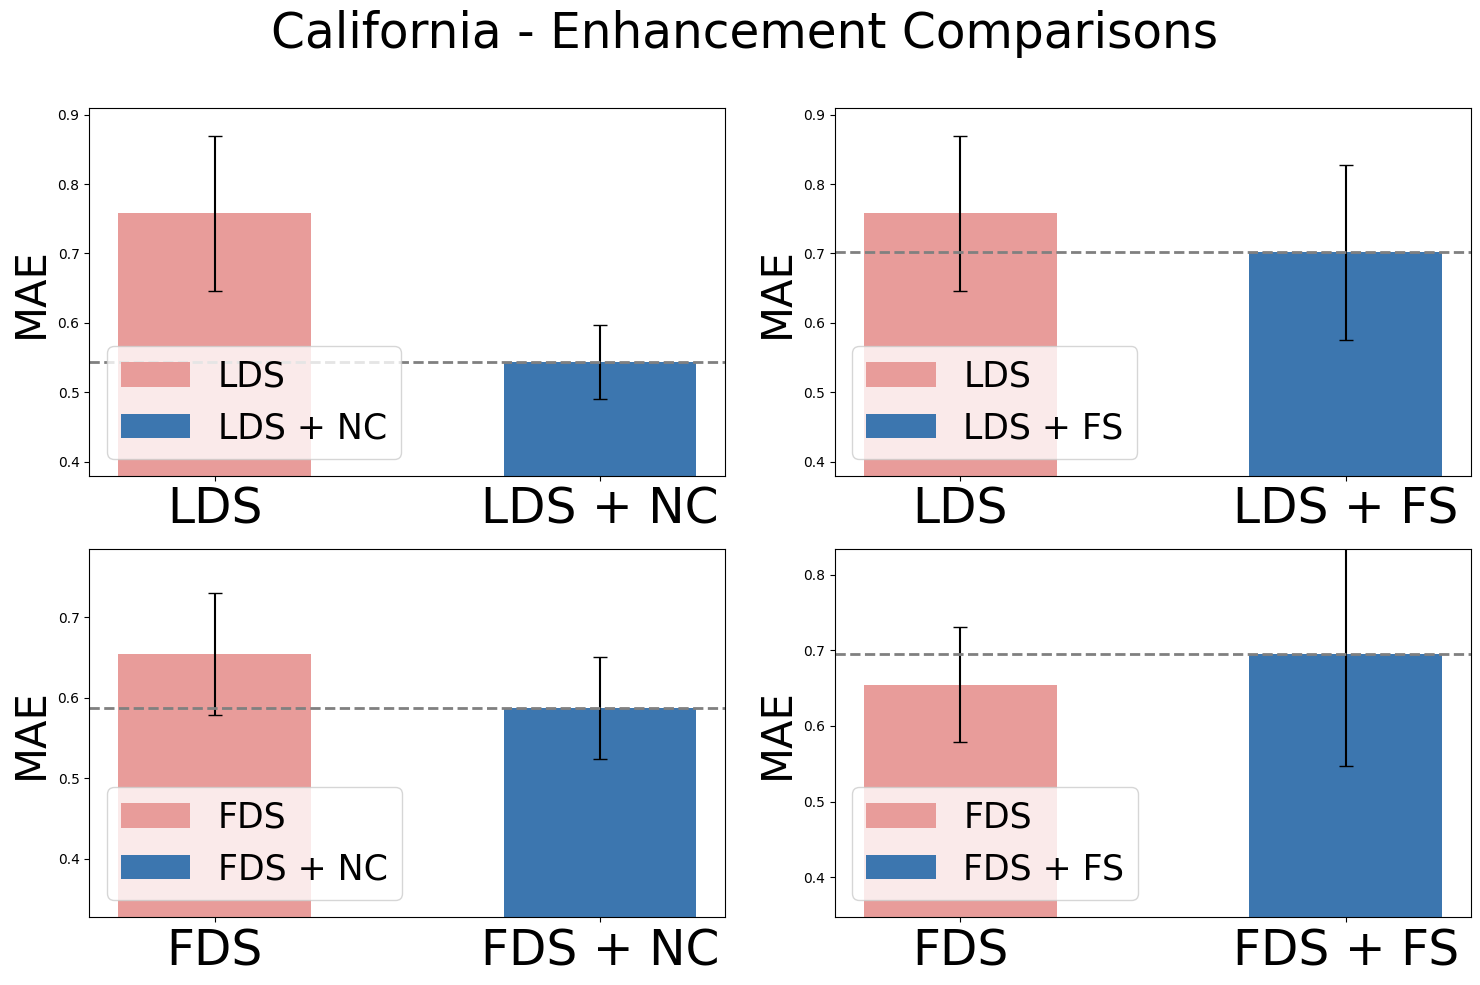

In [272]:
def main():
    iterations = 5
    results = []

    for iteration in range(iterations):
        X, y = df.drop([actual_col], axis=1).dropna().reset_index(drop=True).values, df[actual_col].dropna().reset_index(drop=True).values
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        input_features = X_train.shape[1]

        # Scenario 1: Original Dataset
        models_original = train_models(X_train, y_train)
        evaluations_original = evaluate_models(models_original, X_test, y_test)
        print(f"evaluations_original: {evaluations_original}")  # Debugging print statement
        if not isinstance(evaluations_original, dict):
            print(f"Error: evaluations_original is not a dictionary")
            continue
        
        # Scenario 4: LDS (Label Distribution Smoothing)
        X, y = df1.drop([actual_col, target_col, 'high_range', 'low_range'], axis=1).dropna().reset_index(drop=True).values, df1[actual_col].dropna().reset_index(drop=True).values
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        train_weights = prepare_weights(labels=y_train.astype(int), reweight=None, max_target=int(max(y_train)))
        test_weights = prepare_weights(labels=y_test.astype(int), reweight=None, max_target=int(max(y_test)))
        models_lds = train_models(X_train, y_train, lds=True, weights=train_weights)
        evaluations_lds = evaluate_models(models_lds, X_test, y_test, lds=True, weights=test_weights)
        print(f"evaluations_lds: {evaluations_lds}")  # Debugging print statement
        if not isinstance(evaluations_lds, dict):
            print(f"Error: evaluations_lds is not a dictionary")
            continue

        # Scenario 7: FDS (Feature Distribution Smoothing)
        X, y = df1.drop([actual_col, target_col, 'low_range', 'high_range'], axis=1).dropna().reset_index(drop=True).values, df1[actual_col].dropna().reset_index(drop=True).values
        X_train_fds, X_test_fds, y_train_fds, y_test_fds = train_test_split(X, y, test_size=0.3, random_state=42)
        models_fds = train_models(X_train_fds, y_train_fds, fds=True)
        evaluations_fds = evaluate_models(models_fds, X_test_fds, y_test_fds)
        print(f"evaluations_fds: {evaluations_fds}")  # Debugging print statement
        if not isinstance(evaluations_fds, dict):
            print(f"Error: evaluations_fds is not a dictionary")
            continue

        # Scenario 2: NC+LDS
        final_df_nc_raking = pd.read_csv('/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/California_final_df_nc_raking.csv')
        X_train_nc, X_test_nc, y_train_nc, y_test_nc = custom_train_test_split(final_df_nc_raking, df, actual_col, test_size=0.3, random_state=42)
        train_weights = prepare_weights(labels=y_train_nc.astype(int), reweight=None, max_target=int(max(y_train_nc)))
        test_weights = prepare_weights(labels=y_test_nc.astype(int), reweight=None, max_target=int(max(y_test_nc)))
        models_nc_lds = train_models(X_train_nc, y_train_nc, lds=True, weights=train_weights)
        evaluations_nc_lds = evaluate_models(models_nc_lds, X_test_nc, y_test_nc, lds=True, weights=test_weights)
        print(f"evaluations_nc_lds: {evaluations_nc_lds}")  # Debugging print statement
        if not isinstance(evaluations_nc_lds, dict):
            print(f"Error: evaluations_nc_lds is not a dictionary")
            continue

        # Scenario 3: NC+FDS
        X_train_nc, X_test_nc, y_train_nc, y_test_nc = custom_train_test_split(final_df_nc_raking, df, actual_col, test_size=0.3, random_state=42)
        models_nc_fds = train_models(X_train_nc, y_train_nc, fds=True)
        evaluations_nc_fds = evaluate_models(models_nc_fds, X_test_nc, y_test_nc)
        print(f"evaluations_nc_fds: {evaluations_nc_fds}")  # Debugging print statement
        if not isinstance(evaluations_nc_fds, dict):
            print(f"Error: evaluations_nc_fds is not a dictionary")
            continue

        # Scenario 4: FS+LDS
        final_df_sn_raking = pd.read_csv('/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/California_final_df_sn_raking.csv')
        X_train_sn_raking, X_test_sn_raking, y_train_sn_raking, y_test_sn_raking = custom_train_test_split(final_df_sn_raking, df, actual_col, test_size=0.3, random_state=42)
        train_weights = prepare_weights(labels=y_train_sn_raking.astype(int), reweight=None, max_target=int(max(y_train_sn_raking)))
        test_weights = prepare_weights(labels=y_test_sn_raking.astype(int), reweight=None, max_target=int(max(y_test_sn_raking)))
        models_fs_lds = train_models(X_train_sn_raking, y_train_sn_raking, lds=True, weights=train_weights)
        evaluations_fs_lds = evaluate_models(models_fs_lds, X_test_sn_raking, y_test_sn_raking, lds=True, weights=test_weights)
        print(f"evaluations_fs_lds: {evaluations_fs_lds}")  # Debugging print statement
        if not isinstance(evaluations_fs_lds, dict):
            print(f"Error: evaluations_fs_lds is not a dictionary")
            continue

        # Scenario 5: FS+FDS
        X_train_sn_raking, X_test_sn_raking, y_train_sn_raking, y_test_sn_raking = custom_train_test_split(final_df_sn_raking, df, actual_col, test_size=0.3, random_state=42)
        models_fs_fds = train_models(X_train_sn_raking, y_train_sn_raking, fds=True)
        evaluations_fs_fds = evaluate_models(models_fs_fds, X_test_sn_raking, y_test_sn_raking)
        print(f"evaluations_fs_fds: {evaluations_fs_fds}")  # Debugging print statement
        if not isinstance(evaluations_fs_fds, dict):
            print(f"Error: evaluations_fs_fds is not a dictionary")
            continue

        # Save all the results for the current iteration
        evaluations_dict = {
            'LDS': evaluations_lds,
            'nc_lds': evaluations_nc_lds,
            'fs_lds': evaluations_fs_lds,
            'FDS': evaluations_fds,
            'nc_fds': evaluations_nc_fds,
            'fs_fds': evaluations_fs_fds
        }

        for key, evaluations in evaluations_dict.items():
            average_metrics = calculate_averages2(evaluations, is_ranksim=False, select_best=False)
            if not isinstance(average_metrics, dict):
                print(f"Error: average_metrics for {key} is not a dictionary")
                continue
            for metric, value in average_metrics.items():
                result = {'iteration': iteration, 'scenario': key, 'metric': metric, 'value': value}
                print(f"Appending result: {result}")  # Debugging print statement
                results.append(result)
                    
    # Convert results to DataFrame and save
    results_df = pd.DataFrame(results)
    print(f"Results DataFrame:\n{results_df}")  # Debugging print statement

    # Calculate averages for each sampling method
    average_dict = {}
    std_dict = {}
    for key, group in results_df.groupby('scenario'):
        group_metrics = group.pivot_table(values='value', index='iteration', columns='metric').mean().to_dict()
        average_metrics = {metric: group_metrics.get('MAE', float('nan')) for metric in ['MAE']}
        std_metrics = {metric: group.pivot_table(values='value', index='iteration', columns='metric').std().to_dict().get('MAE', float('nan')) for metric in ['MAE']}
        average_dict[key] = average_metrics
        std_dict[key] = std_metrics

    # Plot comparisons
    plot_enhancement_comparisons(average_dict, std_dict, dataset_name='California', save_path_prefix='/home/Imbalanced_Regression/Results/Enhancement')

if __name__ == "__main__":
    main()


### 3 - Run abalone

#### 3-1 - Main training

In [889]:
class AbaloneDataset(Dataset):
    def __init__(self, features, targets, weights, lds=False):
        self.features = features
        self.targets = targets
        self.weights = weights
        self.lds = lds

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
          feature = self.features[idx]
          target = self.targets[idx]
          weight = self.weights[idx]
          return feature, target, weight

Metrics for mlp: RMSE=214.16, MAE=202.88, MSE=45865.95, G-mean=190.09
original dataset: {'mlp': {'RMSE': 214.16338103975252, 'MAE': 202.88138503395578, 'MSE': 45865.95377837823, 'G-mean': 190.09288209926964}}
Metrics for mlp: RMSE=204.88, MAE=182.94, MSE=41974.43, G-mean=152.12
Nearest Cell dataset: {'mlp': {'RMSE': 204.87662, 'MAE': 182.93701, 'MSE': 41974.43, 'G-mean': 152.12021}}
Metrics for mlp: RMSE=196.64, MAE=176.41, MSE=38665.96, G-mean=139.13
Features Similarity dataset: {'mlp': {'RMSE': 196.63661, 'MAE': 176.4145, 'MSE': 38665.957, 'G-mean': 139.13138}}
Using LDS: [GAUSSIAN] (5/2)
Using LDS: [GAUSSIAN] (5/2)
Metrics for mlp: RMSE=289.46, MAE=217.54, MSE=83785.18, G-mean=98.39
LDS dataset: {'mlp': {'RMSE': 289.45670216563354, 'MAE': 217.5392801905971, 'MSE': 83785.1824286043, 'G-mean': 98.38762014006846}}
Using LDS: [GAUSSIAN] (5/2)
Using LDS: [GAUSSIAN] (5/2)
Metrics for mlp: RMSE=260.31, MAE=181.02, MSE=67761.42, G-mean=66.00
NC + LDS dataset: {'mlp': {'RMSE': 260.3102382767

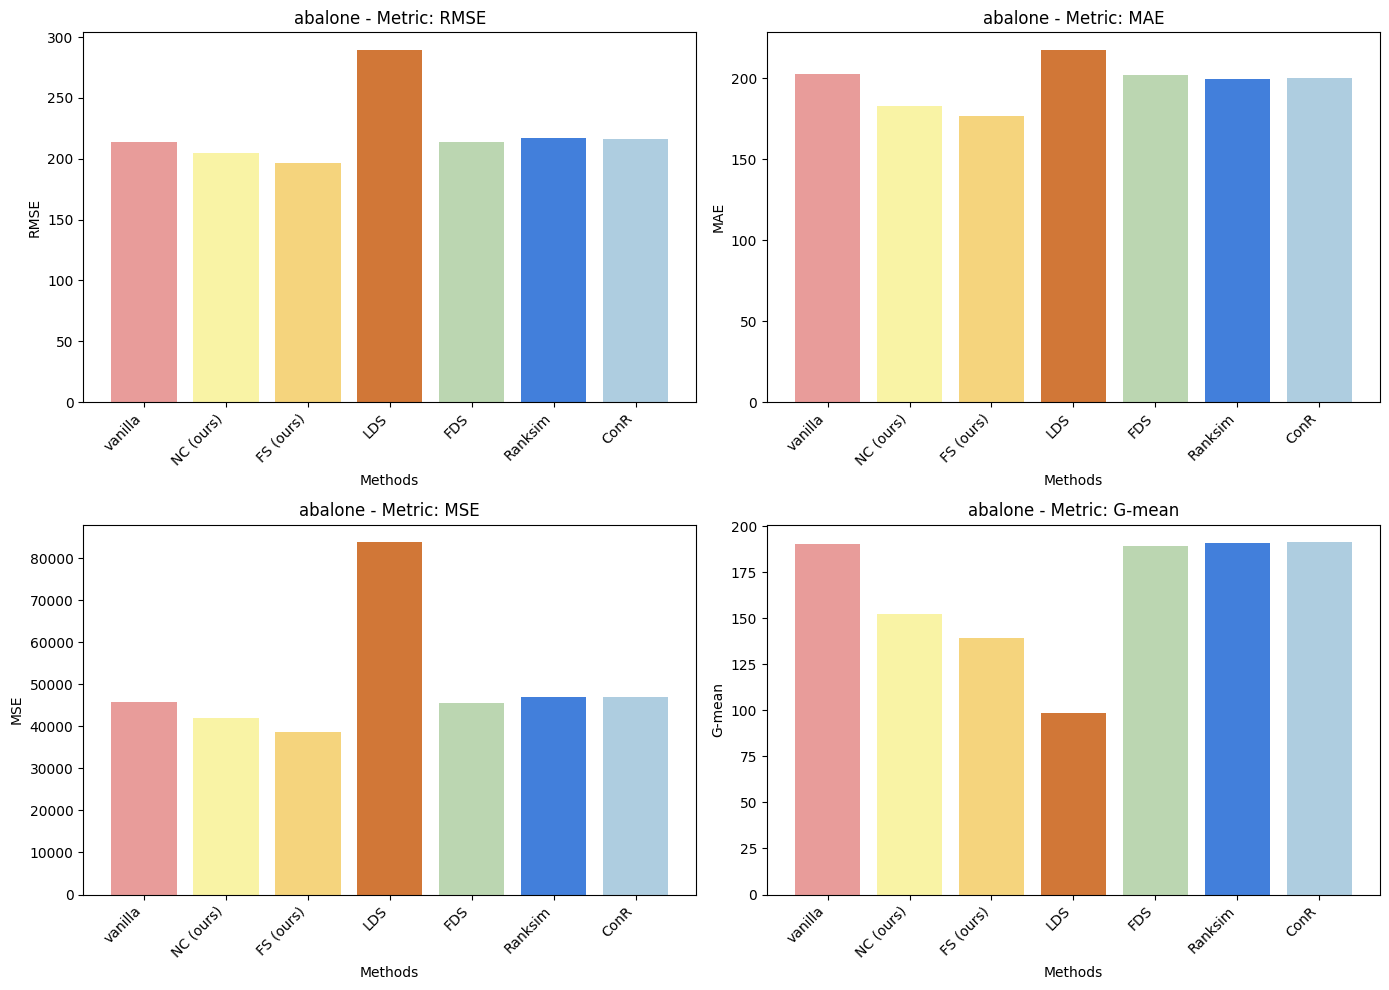

In [190]:
def main():

    X, y = df.drop([actual_col], axis=1).dropna().reset_index(drop=True).values, df[actual_col].dropna().reset_index(drop=True).values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    # Correct model instantiation
    input_features = X_train.shape[1]

    # Scenario 1: Original Dataset
    models_original = train_models(X_train, y_train)
    evaluations_original = evaluate_models(models_original, X_test, y_test)
    print("original dataset:", evaluations_original)

    # Scenario 2: Samples of nearest cells: Calibration Method
    final_df_nc_raking = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/abalone_final_df_nc_raking.csv")
    X_train_nc, X_test_nc, y_train_nc, y_test_nc = custom_train_test_split(final_df_nc_raking, df, actual_col, test_size=0.3, random_state=42)
    y_combined = np.concatenate([y_train_nc, y_test_nc]) # for plotting
    models_nc = train_models(X_train_nc, y_train_nc)
    evaluations_nc_raking = evaluate_models(models_nc, X_test_nc, y_test_nc)
    print("Nearest Cell dataset:", evaluations_nc_raking)

    # Scenario 3: Samples of Features Similarity: Calibration Method
    final_df_fs_raking = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/abalone_final_df_sn_raking.csv")
    X_train_fs_raking, X_test_fs_raking, y_train_fs_raking, y_test_fs_raking = custom_train_test_split(final_df_fs_raking, df, actual_col, test_size=0.3, random_state=42)
    y_combined = np.concatenate([y_train_fs_raking, y_test_fs_raking]) # for plotting
    models_fs_raking = train_models(X_train_fs_raking, y_train_fs_raking)
    evaluations_fs_raking = evaluate_models(models_fs_raking, X_test_fs_raking, y_test_fs_raking)
    print("Features Similarity dataset:", evaluations_fs_raking)
    
    # Scenario 4: LDS (Label Distribution Smoothing)
    X, y = df1.drop([actual_col, target_col, 'high_range', 'low_range'], axis=1).dropna().reset_index(drop=True).values, df1[actual_col].dropna().reset_index(drop=True).values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    train_weights = prepare_weights(labels=y_train.astype(int), reweight=None, max_target=int(max(y_train)))
    test_weights = prepare_weights(labels=y_test.astype(int), reweight=None, max_target=int(max(y_test)))
    models_lds = train_models(X_train, y_train, lds=True, weights=train_weights)
    evaluations_lds = evaluate_models(models_lds, X_test, y_test, lds=True, weights=test_weights)
    print("LDS dataset:", evaluations_lds)

    # Scenario 4: NC + LDS (Label Distribution Smoothing)
    df_nc = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/abalone_final_df_nc_raking.csv")
    X, y = df_nc.drop([actual_col], axis=1).dropna().reset_index(drop=True).values, df_nc[actual_col].dropna().reset_index(drop=True).values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    train_weights = prepare_weights(labels=y_train.astype(int), reweight=None, max_target=int(max(y_train)))
    test_weights = prepare_weights(labels=y_test.astype(int), reweight=None, max_target=int(max(y_test)))
    models_nc_lds = train_models(X_train, y_train, lds=True, weights=train_weights)
    evaluations_nc_lds = evaluate_models(models_nc_lds, X_test, y_test, lds=True, weights=test_weights)
    print("NC + LDS dataset:", evaluations_nc_lds)

    # Scenario 4: FS + LDS (Label Distribution Smoothing)
    df_fs = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/abalone_final_df_sn_raking.csv")
    X, y = df_fs.drop([actual_col], axis=1).dropna().reset_index(drop=True).values, df_fs[actual_col].dropna().reset_index(drop=True).values  
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    train_weights = prepare_weights(labels=y_train.astype(int), reweight=None, max_target=int(max(y_train)))
    test_weights = prepare_weights(labels=y_test.astype(int), reweight=None, max_target=int(max(y_test)))
    models_fs_lds = train_models(X_train, y_train, lds=True, weights=train_weights)
    evaluations_fs_lds = evaluate_models(models_fs_lds, X_test, y_test, lds=True, weights=test_weights)
    print("FS + LDS dataset:", evaluations_fs_lds)

    # Scenario 5: FDS (Feature Distribution Smoothing)
    X, y = df1.drop([actual_col, target_col, 'high_range', 'low_range'], axis=1).dropna().reset_index(drop=True).values, df1[actual_col].dropna().reset_index(drop=True).values
    X_train_fds, X_test_fds, y_train_fds, y_test_fds = train_test_split(X, y, test_size=0.3, random_state=42)
    models_fds = train_models(X_train_fds, y_train_fds, fds=True)
    evaluations_fds = evaluate_models(models_fds, X_test_fds, y_test_fds)
    print("FDS dataset:", evaluations_fds)

    # Scenario 5: NC + FDS (Feature Distribution Smoothing)
    df_nc = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/abalone_final_df_nc_raking.csv")
    X, y = df_nc.drop([actual_col], axis=1).dropna().reset_index(drop=True).values, df_nc[actual_col].dropna().reset_index(drop=True).values
    X_train_fds, X_test_fds, y_train_fds, y_test_fds = train_test_split(X, y, test_size=0.3, random_state=42)
    models_nc_fds = train_models(X_train_fds, y_train_fds, fds=True)
    evaluations_nc_fds = evaluate_models(models_nc_fds, X_test_fds, y_test_fds)
    print("NC + FDS dataset:", evaluations_nc_fds)

    # Scenario 5: FS + FDS (Feature Distribution Smoothing)
    df_fs = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/abalone_final_df_sn_raking.csv")
    X, y = df_fs.drop([actual_col], axis=1).dropna().reset_index(drop=True).values, df_fs[actual_col].dropna().reset_index(drop=True).values
    X_train_fds, X_test_fds, y_train_fds, y_test_fds = train_test_split(X, y, test_size=0.3, random_state=42)
    models_fs_fds = train_models(X_train_fds, y_train_fds, fds=True)
    evaluations_fs_fds = evaluate_models(models_fs_fds, X_test_fds, y_test_fds)
    print("FS + FDS dataset:", evaluations_fs_fds)

    # Scenario 6: LDS + FDS
    X, y = df1.drop([actual_col, target_col, 'high_range', 'low_range'], axis=1).dropna().reset_index(drop=True).values, df1[actual_col].dropna().reset_index(drop=True).values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    train_weights = prepare_weights(labels=y_train.astype(int), reweight=None, max_target=int(max(y_train)))
    test_weights = prepare_weights(labels=y_test.astype(int), reweight=None, max_target=int(max(y_test)))
    models_lds_fds = train_models(X_train, y_train, lds=True, fds=True, weights=train_weights)
    evaluations_lds_fds = evaluate_models(models_lds_fds, X_test, y_test, lds=True, weights=test_weights)
    print("LDS + FDS dataset:", evaluations_lds_fds)

    # Scenario 6: NC + LDS + FDS
    df_nc = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/abalone_final_df_nc_raking.csv")
    X, y = df_nc.drop([actual_col], axis=1).dropna().reset_index(drop=True).values, df_nc[actual_col].dropna().reset_index(drop=True).values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    train_weights = prepare_weights(labels=y_train.astype(int), reweight=None, max_target=int(max(y_train)))
    test_weights = prepare_weights(labels=y_test.astype(int), reweight=None, max_target=int(max(y_test)))
    models_nc_lds_fds = train_models(X_train, y_train, lds=True, fds=True, weights=train_weights)
    evaluations_nc_lds_fds = evaluate_models(models_nc_lds_fds, X_test, y_test, lds=True, weights=test_weights)
    print("NC + LDS + FDS dataset:", evaluations_nc_lds_fds)

    # Scenario 6: FS + LDS + FDS
    df_fs = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/abalone_final_df_sn_raking.csv")
    X, y = df_fs.drop([actual_col], axis=1).dropna().reset_index(drop=True).values, df_fs[actual_col].dropna().reset_index(drop=True).values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    train_weights = prepare_weights(labels=y_train.astype(int), reweight=None, max_target=int(max(y_train)))
    test_weights = prepare_weights(labels=y_test.astype(int), reweight=None, max_target=int(max(y_test)))
    models_fs_lds_fds = train_models(X_train, y_train, lds=True, fds=True, weights=train_weights)
    evaluations_fs_lds_fds = evaluate_models(models_fs_lds_fds, X_test, y_test, lds=True, weights=test_weights)
    print("FS + LDS + FDS dataset:", evaluations_fs_lds_fds)

    # Scenario 7: Ranksim
    ranksim_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_abalone_regression_model.pth'
    reg_model.load_state_dict(torch.load(ranksim_path))
    _, val_indices = train_test_split(np.arange(len(df)), test_size=0.3, random_state=42)
    X_orig = df.drop([actual_col], axis=1).dropna().reset_index(drop=True).values
    y_orig = df[actual_col].dropna().reset_index(drop=True).values
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = AbaloneDataset(X_orig[val_indices], y_orig[val_indices], weights=val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_ranksim = validate_ranksim(val_loader, reg_model, lds=False, train_labels=None, prefix='Val')
    print("Ranksim dataset:", evaluations_ranksim)

    # Scenario 7: NC + Ranksim
    ranksim_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_abalone_nc_regression_model.pth'
    reg_model.load_state_dict(torch.load(ranksim_path))
    _, val_indices = train_test_split(np.arange(len(df)), test_size=0.3, random_state=42)
    X_orig = df.drop([actual_col], axis=1).dropna().reset_index(drop=True).values
    y_orig = df[actual_col].dropna().reset_index(drop=True).values
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = AbaloneDataset(X_orig[val_indices], y_orig[val_indices], weights=val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_nc_ranksim = validate_ranksim(val_loader, reg_model, lds=False, train_labels=None, prefix='Val')
    print("NC + Ranksim dataset:", evaluations_nc_ranksim)

    # Scenario 7: NC + Ranksim
    ranksim_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_abalone_fs_regression_model.pth'
    reg_model.load_state_dict(torch.load(ranksim_path))
    _, val_indices = train_test_split(np.arange(len(df)), test_size=0.3, random_state=42)
    X_orig = df.drop([actual_col], axis=1).dropna().reset_index(drop=True).values
    y_orig = df[actual_col].dropna().reset_index(drop=True).values
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = AbaloneDataset(X_orig[val_indices], y_orig[val_indices], weights=val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_fs_ranksim = validate_ranksim(val_loader, reg_model, lds=False, train_labels=None, prefix='Val')
    print("FS + Ranksim dataset:", evaluations_fs_ranksim)

    # Scenario 8: Ranksim + LDS Validation
    ranksim_lds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_abalone_regression_model_with_LDS.pth'
    reg_model.load_state_dict(torch.load(ranksim_lds_path))
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = AbaloneDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_ranksim_lds = validate_ranksim(val_loader, reg_model, lds=True, train_labels=None, prefix='Val')
    print("Ranksim + LDS dataset:", evaluations_ranksim_lds)

    # Scenario 8: NC + Ranksim + LDS Validation
    ranksim_lds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_abalone_nc_regression_model_with_LDS.pth'
    reg_model.load_state_dict(torch.load(ranksim_lds_path))
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = AbaloneDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_nc_ranksim_lds = validate_ranksim(val_loader, reg_model, lds=True, train_labels=None, prefix='Val')
    print("NC + Ranksim + LDS dataset:", evaluations_nc_ranksim_lds)

    # Scenario 8: FS + Ranksim + LDS Validation
    ranksim_lds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_abalone_fs_regression_model_with_LDS.pth'
    reg_model.load_state_dict(torch.load(ranksim_lds_path))
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = AbaloneDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_fs_ranksim_lds = validate_ranksim(val_loader, reg_model, lds=True, train_labels=None, prefix='Val')
    print("FS+ Ranksim + LDS dataset:", evaluations_fs_ranksim_lds)

    # Scenario 9: Ranksim + FDS Validation
    ranksim_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_abalone_regression_model_with_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(ranksim_fds_path))
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = AbaloneDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_ranksim_fds = validate_ranksim(val_loader, reg_model_fds, lds=False, train_labels=None, prefix='Val')
    print("Ranksim + FDS dataset:", evaluations_ranksim_fds)

    # Scenario 9: NC + Ranksim + FDS Validation
    ranksim_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_abalone_nc_regression_model_with_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(ranksim_fds_path))
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = AbaloneDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_nc_ranksim_fds = validate_ranksim(val_loader, reg_model_fds, lds=False, train_labels=None, prefix='Val')
    print("NC + Ranksim + FDS dataset:", evaluations_nc_ranksim_fds)

    # Scenario 9: FS + Ranksim + FDS Validation
    ranksim_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_abalone_fs_regression_model_with_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(ranksim_fds_path))
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = AbaloneDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_fs_ranksim_fds = validate_ranksim(val_loader, reg_model_fds, lds=False, train_labels=None, prefix='Val')
    print("FS + Ranksim + FDS dataset:", evaluations_fs_ranksim_fds)
    
    # Scenario 10: Ranksim+ LDS + FDS Validation
    ranksim_lds_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_abalone_regression_model_with_LDS_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(ranksim_lds_fds_path))
    # Split dataset into training and validation sets
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = AbaloneDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_ranksim_lds_fds = validate_ranksim(val_loader, reg_model_fds, lds=True, train_labels=None, prefix='Val')
    print("Ranksim + LDS + FDS dataset:", evaluations_ranksim_lds_fds)

    # Scenario 10: NC + Ranksim + LDS + FDS Validation
    ranksim_lds_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_abalone_nc_regression_model_with_LDS_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(ranksim_lds_fds_path))
    # Split dataset into training and validation sets
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = AbaloneDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_nc_ranksim_lds_fds = validate_ranksim(val_loader, reg_model_fds, lds=True, train_labels=None, prefix='Val')
    print("NC + Ranksim + LDS + FDS dataset:", evaluations_nc_ranksim_lds_fds)

    # Scenario 10: FS + Ranksim + LDS + FDS Validation
    ranksim_lds_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_abalone_fs_regression_model_with_LDS_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(ranksim_lds_fds_path))
    # Split dataset into training and validation sets
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = AbaloneDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_fs_ranksim_lds_fds = validate_ranksim(val_loader, reg_model_fds, lds=True, train_labels=None, prefix='Val')
    print("FS + Ranksim + LDS + FDS dataset:", evaluations_fs_ranksim_lds_fds)

    # Scenario 11: ConR
    conr_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_abalone_regression_model_ConR.pth'
    reg_model.load_state_dict(torch.load(conr_path))
    _, val_indices = train_test_split(np.arange(len(df)), test_size=0.3, random_state=42)
    X_orig = df.drop([actual_col], axis=1).dropna().reset_index(drop=True).values
    y_orig = df[actual_col].dropna().reset_index(drop=True).values
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = AbaloneDataset(X_orig[val_indices], y_orig[val_indices], weights=val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_conr = validate_ranksim(val_loader, reg_model, lds=False, train_labels=None, prefix='Val')
    print("ConR dataset:", evaluations_conr)

    # Scenario 11: NC + ConR
    conr_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_abalone_nc_regression_model_ConR.pth'
    reg_model.load_state_dict(torch.load(conr_path))
    _, val_indices = train_test_split(np.arange(len(df)), test_size=0.3, random_state=42)
    X_orig = df.drop([actual_col], axis=1).dropna().reset_index(drop=True).values
    y_orig = df[actual_col].dropna().reset_index(drop=True).values
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = AbaloneDataset(X_orig[val_indices], y_orig[val_indices], weights=val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_nc_conr = validate_ranksim(val_loader, reg_model, lds=False, train_labels=None, prefix='Val')
    print("NC + ConR dataset:", evaluations_nc_conr)
    
    # Scenario 11: FS + ConR
    conr_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_abalone_fs_regression_model_ConR.pth'
    reg_model.load_state_dict(torch.load(conr_path))
    _, val_indices = train_test_split(np.arange(len(df)), test_size=0.3, random_state=42)
    X_orig = df.drop([actual_col], axis=1).dropna().reset_index(drop=True).values
    y_orig = df[actual_col].dropna().reset_index(drop=True).values
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = AbaloneDataset(X_orig[val_indices], y_orig[val_indices], weights=val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_fs_conr = validate_ranksim(val_loader, reg_model, lds=False, train_labels=None, prefix='Val')
    print("FS + ConR dataset:", evaluations_fs_conr)
            
    # Scenario 12: ConR + LDS Validation
    conr_lds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_abalone_regression_model_ConR_with_LDS.pth'
    reg_model.load_state_dict(torch.load(conr_lds_path))
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = AbaloneDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_conr_lds = validate_ranksim(val_loader, reg_model, lds=True, train_labels=None, prefix='Val')
    print("ConR + LDS dataset:", evaluations_conr_lds)

    # Scenario 12: NC + ConR + LDS Validation
    conr_lds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_abalone_nc_regression_model_ConR_with_LDS.pth'
    reg_model.load_state_dict(torch.load(conr_lds_path))
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = AbaloneDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_nc_conr_lds = validate_ranksim(val_loader, reg_model, lds=True, train_labels=None, prefix='Val')
    print("NC + ConR + LDS dataset:", evaluations_nc_conr_lds)

    # Scenario 12: FS + ConR + LDS Validation
    conr_lds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_abalone_fs_regression_model_ConR_with_LDS.pth'
    reg_model.load_state_dict(torch.load(conr_lds_path))
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = AbaloneDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_fs_conr_lds = validate_ranksim(val_loader, reg_model, lds=True, train_labels=None, prefix='Val')
    print("FS + ConR + LDS dataset:", evaluations_fs_conr_lds)

    # Scenario 13: ConR + FDS Validation
    conr_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_abalone_regression_model_ConR_with_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(conr_fds_path))
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = AbaloneDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_conr_fds = validate_ranksim(val_loader, reg_model_fds, lds=False, train_labels=None, prefix='Val')
    print("ConR + FDS dataset:", evaluations_conr_fds)

    # Scenario 13: NC + ConR + FDS Validation
    conr_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_abalone_nc_regression_model_ConR_with_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(conr_fds_path))
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = AbaloneDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_nc_conr_fds = validate_ranksim(val_loader, reg_model_fds, lds=False, train_labels=None, prefix='Val')
    print("NC + ConR + FDS dataset:", evaluations_nc_conr_fds)

    # Scenario 13: FS + ConR + FDS Validation
    conr_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_abalone_nc_regression_model_ConR_with_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(conr_fds_path))
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = AbaloneDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_fs_conr_fds = validate_ranksim(val_loader, reg_model_fds, lds=False, train_labels=None, prefix='Val')
    print("FS + ConR + FDS dataset:", evaluations_fs_conr_fds)
    
    # Scenario 14: ConR + LDS + FDS Validation
    conr_lds_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_abalone_regression_model_ConR_with_LDS_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(conr_lds_fds_path))
    # Split dataset into training and validation sets
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = AbaloneDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_conr_lds_fds = validate_ranksim(val_loader, reg_model_fds, lds=True, train_labels=None, prefix='Val')
    print("Ranksim + LDS + FDS dataset:", evaluations_conr_lds_fds)

    # Scenario 14: NC + ConR + LDS + FDS Validation
    conr_lds_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_abalone_nc_regression_model_ConR_with_LDS_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(conr_lds_fds_path))
    # Split dataset into training and validation sets
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = AbaloneDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_nc_conr_lds_fds = validate_ranksim(val_loader, reg_model_fds, lds=True, train_labels=None, prefix='Val')
    print("NC + Ranksim + LDS + FDS dataset:", evaluations_nc_conr_lds_fds)

    # Scenario 14: FS + ConR + LDS + FDS Validation
    conr_lds_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_abalone_fs_regression_model_ConR_with_LDS_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(conr_lds_fds_path))
    # Split dataset into training and validation sets
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = AbaloneDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_fs_conr_lds_fds = validate_ranksim(val_loader, reg_model_fds, lds=True, train_labels=None, prefix='Val')
    print("FS + Ranksim + LDS + FDS dataset:", evaluations_fs_conr_lds_fds)

    # Calculate averages for each sampling method
    evaluations_dict = {
        'vanilla': evaluations_original,
        'NC (ours)': evaluations_nc_raking,
        'FS (ours)': evaluations_fs_raking,
        'LDS': evaluations_lds,
        'NC + LDS': evaluations_nc_lds,
        'FS + LDS': evaluations_fs_lds,
        'FDS': evaluations_fds,
        'NC + FDS': evaluations_nc_fds,
        'FS + FDS': evaluations_fs_fds,
        'LDS + FDS': evaluations_lds_fds,
        'NC + LDS + FDS': evaluations_nc_lds_fds,
        'FS + LDS + FDS': evaluations_nc_lds_fds,
        'Ranksim': evaluations_ranksim,
        'NC + Ranksim': evaluations_nc_ranksim,
        'FS + Ranksim': evaluations_fs_ranksim,
        'Ranksim + LDS': evaluations_ranksim_lds, 
        'NC + Ranksim + LDS': evaluations_nc_ranksim_lds, 
        'FS + Ranksim + LDS': evaluations_fs_ranksim_lds, 
        'Ranksim + FDS': evaluations_ranksim_fds,
        'NC + Ranksim + FDS': evaluations_nc_ranksim_fds,
        'FS + Ranksim + FDS': evaluations_fs_ranksim_fds,
        'Ranksim + LDS + FDS': evaluations_ranksim_lds_fds,  
        'NC + Ranksim + LDS + FDS': evaluations_nc_ranksim_lds_fds, 
        'FS + Ranksim + LDS + FDS': evaluations_fs_ranksim_lds_fds, 
        'ConR': evaluations_conr,
        'NC + ConR': evaluations_nc_conr,
        'FS + ConR': evaluations_fs_conr,
        "ConR + LDS": evaluations_conr_lds,
        "NC + ConR + LDS": evaluations_nc_conr_lds,
        "FS + ConR + LDS": evaluations_fs_conr_lds,
        "ConR + FDS": evaluations_conr_fds,
        "NC + ConR + FDS": evaluations_nc_conr_fds,
        "FS + ConR + FDS": evaluations_fs_conr_fds,
        "ConR + LDS + FDS": evaluations_conr_lds_fds,
        "NC + ConR + LDS + FDS": evaluations_nc_conr_lds_fds,
        "FS + ConR + LDS + FDS": evaluations_fs_conr_lds_fds
    }

    average_dict = {}
    for key, evaluations in evaluations_dict.items():
        average_dict[key] = calculate_averages(evaluations, is_ranksim=(key in ['Ranksim', 'ConR','Ranksim + LDS','Ranksim + FDS','Ranksim + LDS + FDS',
                                                                                "ConR + LDS","ConR + FDS","ConR + LDS + FDS", 'NC + Ranksim', 'FS + Ranksim', 
                                                                                'NC + Ranksim + LDS', 'FS + Ranksim + LDS', 'NC + Ranksim + FDS', 'FS + Ranksim + FDS', 
                                                                                'NC + Ranksim + LDS + FDS', 'FS + Ranksim + LDS + FDS', 'NC + ConR', 'FS + ConR', 
                                                                                "NC + ConR + LDS", "FS + ConR + LDS", "NC + ConR + FDS", "FS + ConR + FDS", 
                                                                                "NC + ConR + LDS + FDS", "FS + ConR + LDS + FDS"]), 
                                               select_best=False) #(key in ['NC_calibration', 'FS_calibration'])

     # Transform the dictionaries to match the expected structure for plotting
    average_dict_transformed = {method: {metric: average_dict[method][metric] for metric in ['RMSE', 'MAE', 'MSE', 'G-mean']} for method in evaluations_dict.keys()}

    # Create DataFrames for the averages
    average_df = pd.DataFrame(average_dict_transformed).T
    print(average_df)

    # Plot average comparisons
    methods = ['vanilla', 'NC (ours)', 'FS (ours)', 'LDS', 'FDS', 'Ranksim','ConR']
    plot_average_comparisons(average_dict, methods, dataset_name='abalone',
                             save_path='/home/Imbalanced_Regression/Results/abalone_average_comparisons_test.png')
    
    # plot_distribution_comparison(y, y_combined, K, dataset_name='Boston', 
    #                              save_path='/home/Imbalanced_Regression/Results/Boston_dist_comparisons.png')
    
    # Export the DataFrame to a CSV file
    average_df.to_csv(f'/home/Imbalanced_Regression/Results/abalone_K_{K}_mj_{mj}_average_evaluations.csv')
    # save_combined_evaluations_to_csv(evaluations_dict, f'/home/Imbalanced_Regression/Results/abalone_K_{K}_mj_{mj}_combined_evaluations.csv')
    # files.download(f'Boston_K_{K}_mj_{mj}_average_evaluations.csv')


    # download the balanced dataset
    # final_df_nc_raking.to_csv('/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/Boston_final_df_nc_raking.csv', index=False)
    # final_df_sn_raking.to_csv('/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/Boston_final_df_sn_raking.csv', index=False)


if __name__ == "__main__":
    main()


#### 3-2 - Iterations

Metrics for mlp: RMSE=215.55, MAE=203.18, MSE=46460.30, G-mean=190.09
evaluations_original: {'mlp': {'RMSE': 215.54652000806726, 'MAE': 203.17554372614077, 'MSE': 46460.30228758814, 'G-mean': 190.08835468374153}}
Using LDS: [GAUSSIAN] (5/2)
Using LDS: [GAUSSIAN] (5/2)
Metrics for mlp: RMSE=288.10, MAE=217.11, MSE=83002.39, G-mean=102.21
evaluations_lds: {'mlp': {'RMSE': 288.1013534467916, 'MAE': 217.10780623197175, 'MSE': 83002.38985787316, 'G-mean': 102.20881243807473}}
Metrics for mlp: RMSE=212.93, MAE=201.51, MSE=45340.48, G-mean=188.68
evaluations_fds: {'mlp': {'RMSE': 212.93305189623325, 'MAE': 201.50678260206985, 'MSE': 45340.48458984397, 'G-mean': 188.6767752642457}}
Using LDS: [GAUSSIAN] (5/2)
Using LDS: [GAUSSIAN] (5/2)
Metrics for mlp: RMSE=281.53, MAE=204.10, MSE=79258.70, G-mean=80.50
evaluations_nc_lds: {'mlp': {'RMSE': 281.5292, 'MAE': 204.09732, 'MSE': 79258.695, 'G-mean': 80.4996}}
Metrics for mlp: RMSE=206.98, MAE=183.96, MSE=42840.63, G-mean=154.91
evaluations_nc_fds:

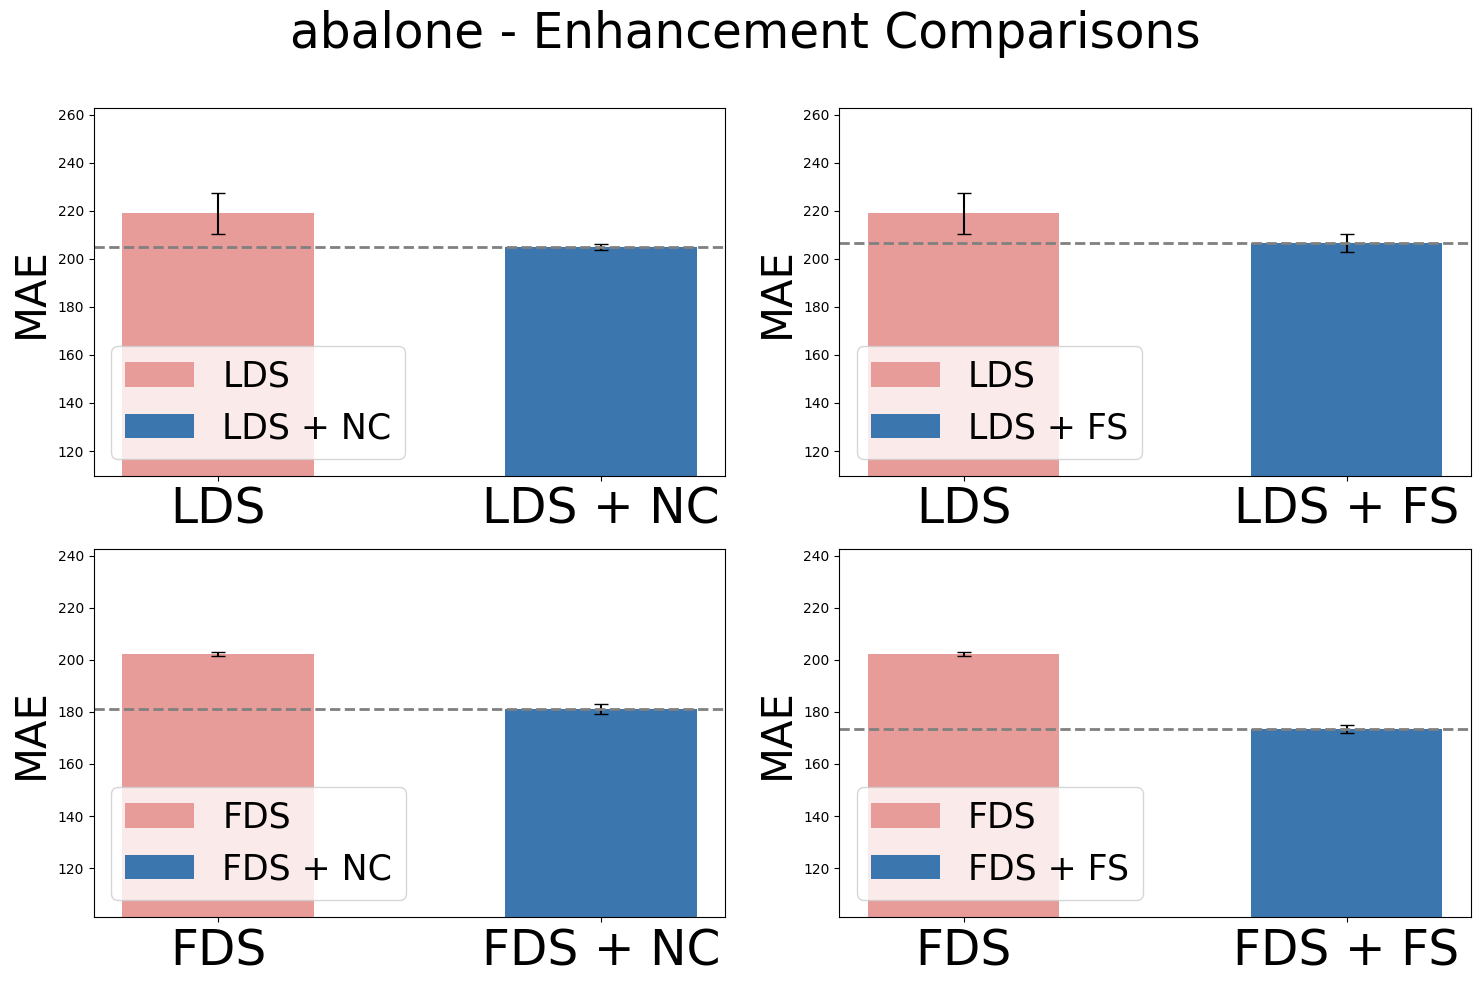

In [165]:
def main():
    iterations = 5
    results = []

    for iteration in range(iterations):
        X, y = df.drop([actual_col], axis=1).dropna().reset_index(drop=True).values, df[actual_col].dropna().reset_index(drop=True).values
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        input_features = X_train.shape[1]

        # Scenario 1: Original Dataset
        models_original = train_models(X_train, y_train)
        evaluations_original = evaluate_models(models_original, X_test, y_test)
        print(f"evaluations_original: {evaluations_original}")  # Debugging print statement
        if not isinstance(evaluations_original, dict):
            print(f"Error: evaluations_original is not a dictionary")
            continue
        
        # Scenario 4: LDS (Label Distribution Smoothing)
        X, y = df1.drop([actual_col, target_col, 'high_range', 'low_range'], axis=1).dropna().reset_index(drop=True).values, df1[actual_col].dropna().reset_index(drop=True).values
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        train_weights = prepare_weights(labels=y_train.astype(int), reweight=None, max_target=int(max(y_train)))
        test_weights = prepare_weights(labels=y_test.astype(int), reweight=None, max_target=int(max(y_test)))
        models_lds = train_models(X_train, y_train, lds=True, weights=train_weights)
        evaluations_lds = evaluate_models(models_lds, X_test, y_test, lds=True, weights=test_weights)
        print(f"evaluations_lds: {evaluations_lds}")  # Debugging print statement
        if not isinstance(evaluations_lds, dict):
            print(f"Error: evaluations_lds is not a dictionary")
            continue

        # Scenario 7: FDS (Feature Distribution Smoothing)
        X, y = df1.drop([actual_col, target_col, 'low_range', 'high_range'], axis=1).dropna().reset_index(drop=True).values, df1[actual_col].dropna().reset_index(drop=True).values
        X_train_fds, X_test_fds, y_train_fds, y_test_fds = train_test_split(X, y, test_size=0.3, random_state=42)
        models_fds = train_models(X_train_fds, y_train_fds, fds=True)
        evaluations_fds = evaluate_models(models_fds, X_test_fds, y_test_fds)
        print(f"evaluations_fds: {evaluations_fds}")  # Debugging print statement
        if not isinstance(evaluations_fds, dict):
            print(f"Error: evaluations_fds is not a dictionary")
            continue

        # Scenario 2: NC+LDS
        final_df_nc_raking = pd.read_csv('/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/abalone_final_df_nc_raking.csv')
        X_train_nc, X_test_nc, y_train_nc, y_test_nc = custom_train_test_split(final_df_nc_raking, df, actual_col, test_size=0.3, random_state=42)
        train_weights = prepare_weights(labels=y_train_nc.astype(int), reweight=None, max_target=int(max(y_train_nc)))
        test_weights = prepare_weights(labels=y_test_nc.astype(int), reweight=None, max_target=int(max(y_test_nc)))
        models_nc_lds = train_models(X_train_nc, y_train_nc, lds=True, weights=train_weights)
        evaluations_nc_lds = evaluate_models(models_nc_lds, X_test_nc, y_test_nc, lds=True, weights=test_weights)
        print(f"evaluations_nc_lds: {evaluations_nc_lds}")  # Debugging print statement
        if not isinstance(evaluations_nc_lds, dict):
            print(f"Error: evaluations_nc_lds is not a dictionary")
            continue

        # Scenario 3: NC+FDS
        X_train_nc, X_test_nc, y_train_nc, y_test_nc = custom_train_test_split(final_df_nc_raking, df, actual_col, test_size=0.3, random_state=42)
        models_nc_fds = train_models(X_train_nc, y_train_nc, fds=True)
        evaluations_nc_fds = evaluate_models(models_nc_fds, X_test_nc, y_test_nc)
        print(f"evaluations_nc_fds: {evaluations_nc_fds}")  # Debugging print statement
        if not isinstance(evaluations_nc_fds, dict):
            print(f"Error: evaluations_nc_fds is not a dictionary")
            continue

        # Scenario 4: FS+LDS
        final_df_sn_raking = pd.read_csv('/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/abalone_final_df_sn_raking.csv')
        X_train_sn_raking, X_test_sn_raking, y_train_sn_raking, y_test_sn_raking = custom_train_test_split(final_df_sn_raking, df, actual_col, test_size=0.3, random_state=42)
        train_weights = prepare_weights(labels=y_train_sn_raking.astype(int), reweight=None, max_target=int(max(y_train_sn_raking)))
        test_weights = prepare_weights(labels=y_test_sn_raking.astype(int), reweight=None, max_target=int(max(y_test_sn_raking)))
        models_fs_lds = train_models(X_train_sn_raking, y_train_sn_raking, lds=True, weights=train_weights)
        evaluations_fs_lds = evaluate_models(models_fs_lds, X_test_sn_raking, y_test_sn_raking, lds=True, weights=test_weights)
        print(f"evaluations_fs_lds: {evaluations_fs_lds}")  # Debugging print statement
        if not isinstance(evaluations_fs_lds, dict):
            print(f"Error: evaluations_fs_lds is not a dictionary")
            continue

        # Scenario 5: FS+FDS
        X_train_sn_raking, X_test_sn_raking, y_train_sn_raking, y_test_sn_raking = custom_train_test_split(final_df_sn_raking, df, actual_col, test_size=0.3, random_state=42)
        models_fs_fds = train_models(X_train_sn_raking, y_train_sn_raking, fds=True)
        evaluations_fs_fds = evaluate_models(models_fs_fds, X_test_sn_raking, y_test_sn_raking)
        print(f"evaluations_fs_fds: {evaluations_fs_fds}")  # Debugging print statement
        if not isinstance(evaluations_fs_fds, dict):
            print(f"Error: evaluations_fs_fds is not a dictionary")
            continue

        # Save all the results for the current iteration
        evaluations_dict = {
            'LDS': evaluations_lds,
            'nc_lds': evaluations_nc_lds,
            'fs_lds': evaluations_fs_lds,
            'FDS': evaluations_fds,
            'nc_fds': evaluations_nc_fds,
            'fs_fds': evaluations_fs_fds
        }

        for key, evaluations in evaluations_dict.items():
            average_metrics = calculate_averages2(evaluations, is_ranksim=False, select_best=False)
            if not isinstance(average_metrics, dict):
                print(f"Error: average_metrics for {key} is not a dictionary")
                continue
            for metric, value in average_metrics.items():
                result = {'iteration': iteration, 'scenario': key, 'metric': metric, 'value': value}
                print(f"Appending result: {result}")  # Debugging print statement
                results.append(result)
                    
    # Convert results to DataFrame and save
    results_df = pd.DataFrame(results)
    print(f"Results DataFrame:\n{results_df}")  # Debugging print statement

    # Calculate averages for each sampling method
    average_dict = {}
    std_dict = {}
    for key, group in results_df.groupby('scenario'):
        group_metrics = group.pivot_table(values='value', index='iteration', columns='metric').mean().to_dict()
        average_metrics = {metric: group_metrics.get('MAE', float('nan')) for metric in ['MAE']}
        std_metrics = {metric: group.pivot_table(values='value', index='iteration', columns='metric').std().to_dict().get('MAE', float('nan')) for metric in ['MAE']}
        average_dict[key] = average_metrics
        std_dict[key] = std_metrics

    # Plot comparisons
    plot_enhancement_comparisons(average_dict, std_dict, dataset_name='abalone', save_path_prefix='/home/Imbalanced_Regression/Results/Enhancement')

if __name__ == "__main__":
    main()


#### 3-3 - Ablation Sutdy: tail distribution

Metrics for mlp: RMSE=212.33, MAE=201.18, MSE=45082.57, G-mean=188.93
Original dataset: {'mlp': {'RMSE': 212.3265711913875, 'MAE': 201.1793775820694, 'MSE': 45082.57283389135, 'G-mean': 188.92705199329532}}
Metrics for mlp: RMSE=202.04, MAE=180.93, MSE=40820.72, G-mean=148.19
Nearest Cell dataset: {'mlp': {'RMSE': 202.04138, 'MAE': 180.93121, 'MSE': 40820.72, 'G-mean': 148.18785}}
Metrics for mlp: RMSE=194.71, MAE=175.11, MSE=37912.20, G-mean=137.79
Features Similarity dataset: {'mlp': {'RMSE': 194.71056, 'MAE': 175.113, 'MSE': 37912.203, 'G-mean': 137.794}}
Using LDS: [GAUSSIAN] (5/2)
Using LDS: [GAUSSIAN] (5/2)
Metrics for mlp: RMSE=282.01, MAE=215.98, MSE=79530.45, G-mean=115.58
LDS dataset: {'mlp': {'RMSE': 282.0114404212535, 'MAE': 215.97954293185632, 'MSE': 79530.45252847021, 'G-mean': 115.58308589866016}}
Metrics for mlp: RMSE=214.13, MAE=202.22, MSE=45852.71, G-mean=189.17
FDS dataset: {'mlp': {'RMSE': 214.13246549133993, 'MAE': 202.21748713479656, 'MSE': 45852.71277739989, 'G-

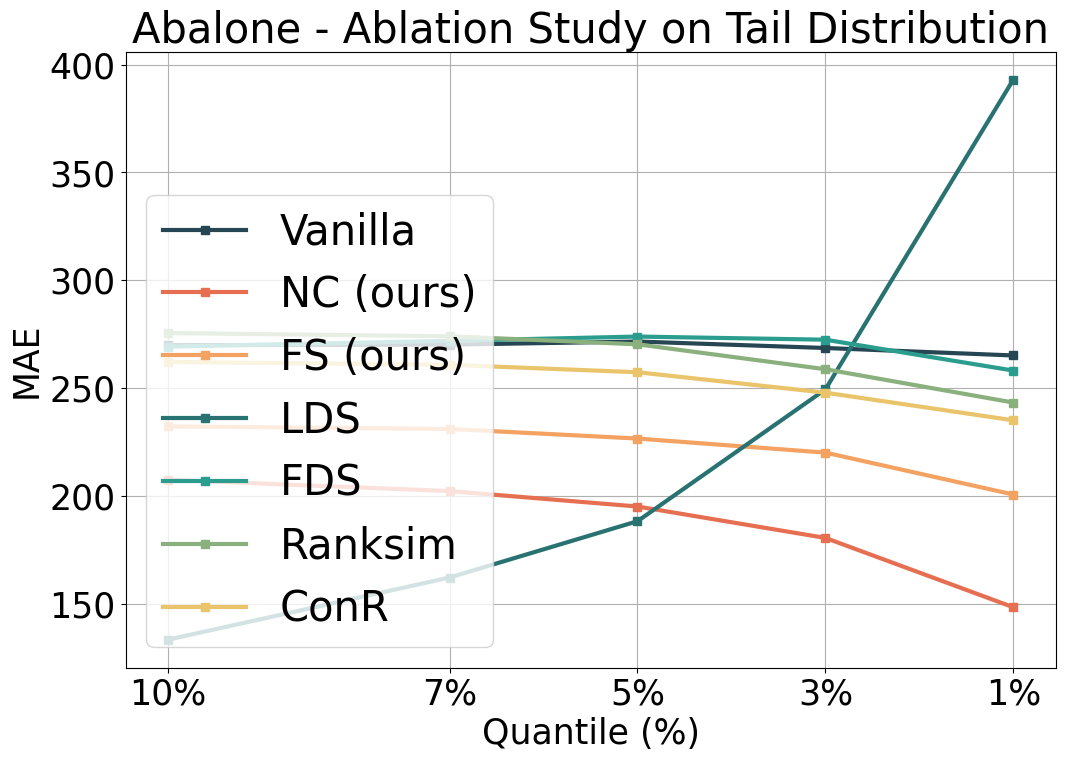

In [2584]:
def main():
    # Assuming df and df1 are defined before this point
    X, y = df.drop([actual_col], axis=1).dropna().reset_index(drop=True).values, df[actual_col].dropna().reset_index(drop=True).values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    input_features = X_train.shape[1]

    # Scenario 1: Original Dataset
    models_original = train_models_ablation(X_train, y_train)
    evaluations_original = evaluate_models(models_original, X_test, y_test)
    print("Original dataset:", evaluations_original)

    # Scenario 2: Samples of nearest cells: Calibration Method
    final_df_nc_raking = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/abalone_final_df_nc_raking.csv")
    X_train_nc, X_test_nc, y_train_nc, y_test_nc = custom_train_test_split(final_df_nc_raking, df, actual_col, test_size=0.3, random_state=42)
    models_nc = train_models_ablation(X_train_nc, y_train_nc)
    evaluations_nc_raking = evaluate_models(models_nc, X_test_nc, y_test_nc)
    print("Nearest Cell dataset:", evaluations_nc_raking)

    # Scenario 3: Samples of Features Similarity: Calibration Method
    final_df_fs_raking = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/abalone_final_df_sn_raking.csv")
    X_train_fs_raking, X_test_fs_raking, y_train_fs_raking, y_test_fs_raking = custom_train_test_split(final_df_fs_raking, df, actual_col, test_size=0.3, random_state=42)
    models_fs_raking = train_models_ablation(X_train_fs_raking, y_train_fs_raking)
    evaluations_fs_raking = evaluate_models(models_fs_raking, X_test_fs_raking, y_test_fs_raking)
    print("Features Similarity dataset:", evaluations_fs_raking)

    # Scenario 4: LDS (Label Distribution Smoothing)
    X, y = df1.drop([actual_col, target_col, 'high_range', 'low_range'], axis=1).dropna().reset_index(drop=True).values, df1[actual_col].dropna().reset_index(drop=True).values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    train_weights = prepare_weights(labels=y_train.astype(int), reweight=None, max_target=int(max(y_train)))
    test_weights = prepare_weights(labels=y_test.astype(int), reweight=None, max_target=int(max(y_test)))
    models_lds = train_models_ablation(X_train, y_train, lds=True, weights=train_weights)
    evaluations_lds = evaluate_models(models_lds, X_test, y_test, lds=True, weights=test_weights)
    print("LDS dataset:", evaluations_lds)

    # Scenario 5: FDS (Feature Distribution Smoothing)
    X, y = df1.drop([actual_col, target_col, 'high_range', 'low_range'], axis=1).dropna().reset_index(drop=True).values, df1[actual_col].dropna().reset_index(drop=True).values
    X_train_fds, X_test_fds, y_train_fds, y_test_fds = train_test_split(X, y, test_size=0.3, random_state=42)
    models_fds = train_models_ablation(X_train_fds, y_train_fds, fds=True)
    evaluations_fds = evaluate_models(models_fds, X_test_fds, y_test_fds)
    print("FDS dataset:", evaluations_fds)

    # Create models dictionary for evaluation
    models = {
        'Vanilla': models_original['mlp'],
        'NC (ours)': models_nc['mlp'],
        'FS (ours)': models_fs_raking['mlp'],
        'LDS': models_lds['mlp'],
        'FDS': models_fds['mlp']
    }

    # Loop through quantiles
    quantiles = [0.10, 0.07, 0.05, 0.03, 0.01]
    results = {name: {} for name in models.keys()}
    for q in quantiles:
        tail_results = evaluate_models_tail(models, X_test, y_test, quantiles=[q], lds=False)  # Default lds=False
        for model_name, metrics in tail_results[q].items():
            if model_name not in results:
                results[model_name] = {}
            results[model_name][q] = metrics

    # Specifically handle LDS model
    for q in quantiles:
        tail_results_lds = evaluate_models_tail({'LDS': models['LDS']}, X_test, y_test, quantiles=[q], lds=True, weights=test_weights)
        for model_name, metrics in tail_results_lds[q].items():
            results[model_name][q] = metrics

    # Manually process Ranksim and ConR for the tail data
    # Scenario 7: Ranksim
    ranksim_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_abalone_regression_model.pth'
    reg_model.load_state_dict(torch.load(ranksim_path))
    _, val_indices = train_test_split(np.arange(len(df)), test_size=0.3, random_state=42)
    X_orig = df.drop([actual_col], axis=1).dropna().reset_index(drop=True).values
    y_orig = df[actual_col].dropna().reset_index(drop=True).values
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = AbaloneDataset(X_orig[val_indices], y_orig[val_indices], weights=val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_ranksim = validate_ranksim_ablation(val_loader, reg_model, lds=False)
    print("Ranksim dataset:", evaluations_ranksim)

    # Scenario 11: ConR
    conr_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_abalone_regression_model_ConR.pth'
    reg_model.load_state_dict(torch.load(conr_path))
    _, val_indices = train_test_split(np.arange(len(df)), test_size=0.3, random_state=42)
    X_orig = df.drop([actual_col], axis=1).dropna().reset_index(drop=True).values
    y_orig = df[actual_col].dropna().reset_index(drop=True).values
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = AbaloneDataset(X_orig[val_indices], y_orig[val_indices], weights=val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_conr = validate_ranksim_ablation(val_loader, reg_model, lds=False)
    print("ConR dataset:", evaluations_conr)

    reg_model.load_state_dict(torch.load(ranksim_path))
    ranksim_results = {}
    for q in quantiles:
        threshold = np.quantile(y_orig, 1 - q)  # Calculate threshold for the tail
        tail_indices = y_orig >= threshold
        tail_dataset = AbaloneDataset(X_orig[tail_indices], y_orig[tail_indices], weights=99 * np.ones(len(y_orig[tail_indices])), lds=False)
        tail_loader = DataLoader(tail_dataset, batch_size=64, shuffle=False)
        evaluation = validate_ranksim_ablation(tail_loader, reg_model, lds=False)
        ranksim_results[q] = evaluation
    results['Ranksim'] = ranksim_results

    reg_model.load_state_dict(torch.load(conr_path))
    conr_results = {}
    for q in quantiles:
        threshold = np.quantile(y_orig, 1 - q)  # Calculate threshold for the tail
        tail_indices = y_orig >= threshold
        tail_dataset = AbaloneDataset(X_orig[tail_indices], y_orig[tail_indices], weights=99 * np.ones(len(y_orig[tail_indices])), lds=False)
        tail_loader = DataLoader(tail_dataset, batch_size=64, shuffle=False)
        evaluation = validate_ranksim_ablation(tail_loader, reg_model, lds=False)
        conr_results[q] = evaluation
    results['ConR'] = conr_results

    # Debug: Print results structure
    print("Results dictionary structure:")
    for name, evaluation in results.items():
        print(f"Model name: {name}, Evaluations: {evaluation}")

    # Plotting the results
    quantiles_percent = [10, 7, 5, 3, 1]
    plot_ablation_study(results, quantiles, dataset_name='Abalone',save_path_prefix='/home/Imbalanced_Regression/Results/Ablation')

if __name__ == "__main__":
    main()


#### 3-4 - synthetic data

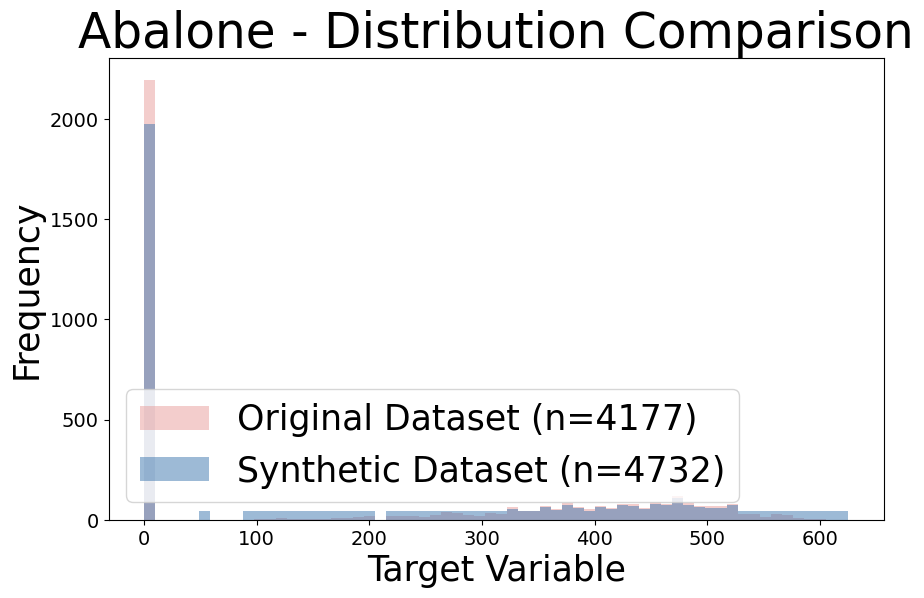

In [324]:
def main():

    X, y = df.drop([actual_col], axis=1).dropna().reset_index(drop=True).values, df[actual_col].dropna().reset_index(drop=True).values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    # Correct model instantiation
    input_features = X_train.shape[1]


    # Scenario 2: Samples of nearest cells: Calibration Method
    final_df_nc_raking = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/abalone_final_df_nc_raking.csv")
    X_train_nc, X_test_nc, y_train_nc, y_test_nc = custom_train_test_split(final_df_nc_raking, df, actual_col, test_size=0.3, random_state=42)
    y_combined = np.concatenate([y_train_nc, y_test_nc]) # for plotting


    plot_distribution_comparison(y, y_combined, K, dataset_name='Abalone', 
                                 save_path='/home/Imbalanced_Regression/Results/Distribution Comparison/Abalone_dist_comparisons.png')

if __name__ == "__main__":
    main()

#### 3-5 ablation study: 3 models

In [ ]:
def main():
    X, y = df.drop([actual_col], axis=1).dropna().reset_index(drop=True).values, df[actual_col].dropna().reset_index(drop=True).values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Scenario 1: Original Dataset
    models_original = train_models_ablation_three(X_train, y_train)
    evaluations_original = evaluate_models(models_original, X_test, y_test)
    print("Original dataset:", evaluations_original)

    # Scenario 2: NC (ours)
    final_df_nc_raking = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/abalone_final_df_nc_raking.csv")
    X_train_nc, X_test_nc, y_train_nc, y_test_nc = custom_train_test_split(final_df_nc_raking, df, actual_col, test_size=0.3, random_state=42)
    models_nc = train_models_ablation_three(X_train_nc, y_train_nc)
    evaluations_nc_raking = evaluate_models(models_nc, X_test_nc, y_test_nc)
    print("Nearest Cell dataset:", evaluations_nc_raking)

    # Scenario 3: FS (ours)
    final_df_fs_raking = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/abalone_final_df_sn_raking.csv")
    X_train_fs_raking, X_test_fs_raking, y_train_fs_raking, y_test_fs_raking = custom_train_test_split(final_df_fs_raking, df, actual_col, test_size=0.3, random_state=42)
    models_fs_raking = train_models_ablation_three(X_train_fs_raking, y_train_fs_raking)
    evaluations_fs_raking = evaluate_models(models_fs_raking, X_test_fs_raking, y_test_fs_raking)
    print("Features Similarity dataset:", evaluations_fs_raking)

    # Scenario 4: LDS (Label Distribution Smoothing)
    X, y = df1.drop([actual_col, target_col, 'high_range', 'low_range'], axis=1).dropna().reset_index(drop=True).values, df1[actual_col].dropna().reset_index(drop=True).values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    train_weights = prepare_weights(labels=y_train.astype(int), reweight=None, max_target=int(max(y_train)))
    test_weights = prepare_weights(labels=y_test.astype(int), reweight=None, max_target=int(max(y_test)))
    models_lds = train_models_ablation_three(X_train, y_train, lds=True, weights=train_weights)
    evaluations_lds = evaluate_models(models_lds, X_test, y_test, lds=True, weights=test_weights)
    print("LDS dataset:", evaluations_lds)

    # Scenario 5: FDS (Feature Distribution Smoothing)
    X, y = df1.drop([actual_col, target_col, 'high_range', 'low_range'], axis=1).dropna().reset_index(drop=True).values, df1[actual_col].dropna().reset_index(drop=True).values
    X_train_fds, X_test_fds, y_train_fds, y_test_fds = train_test_split(X, y, test_size=0.3, random_state=42)
    models_fds = train_models_ablation_three(X_train_fds, y_train_fds, fds=True)
    evaluations_fds = evaluate_models(models_fds, X_test_fds, y_test_fds)
    print("FDS dataset:", evaluations_fds)

    # Scenario 6: Ranksim Validation
    ranksim_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_abalone_regression_model.pth'
    reg_model = RegressionModel(input_dim=X.shape[1], return_features=True, fds=False).cuda()
    reg_model.load_state_dict(torch.load(ranksim_path))
    _, val_indices = train_test_split(np.arange(len(df)), test_size=0.3, random_state=42)
    X_orig = df.drop([actual_col], axis=1).dropna().reset_index(drop=True).values
    y_orig = df[actual_col].dropna().reset_index(drop=True).values
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = AbaloneDataset(X_orig[val_indices], y_orig[val_indices], weights=val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    
    models_ranksim = {
        'mlp': models_original['mlp'],
        'mlp_mixer': models_original['mlp_mixer'],
        'transformer': reg_model
    }
    
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_ranksim = validate_ranksim_ablation_three(val_loader, models_ranksim, lds=False)
    print("Ranksim dataset:", evaluations_ranksim)


    # Scenario 7: ConR Validation
    conr_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_abalone_regression_model_ConR.pth'
    reg_model.load_state_dict(torch.load(conr_path))
    _, val_indices = train_test_split(np.arange(len(df)), test_size=0.3, random_state=42)
    X_orig = df.drop([actual_col], axis=1).dropna().reset_index(drop=True).values
    y_orig = df[actual_col].dropna().reset_index(drop=True).values
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = AbaloneDataset(X_orig[val_indices], y_orig[val_indices], weights=val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    
    models_conr = {
        'mlp': models_original['mlp'],
        'mlp_mixer': models_original['mlp_mixer'],
        'transformer': reg_model
    }
    
    evaluations_conr = validate_ranksim_ablation_three(val_loader, models_conr, lds=False)
    print("ConR dataset:", evaluations_conr)


    # Calculate MAE for each sampling method
    evaluations_dict = {
        'vanilla': evaluations_original,
        'NC (ours)': evaluations_nc_raking,
        'FS (ours)': evaluations_fs_raking,
        'LDS': evaluations_lds,
        'FDS': evaluations_fds,
        'Ranksim': evaluations_ranksim,
        'ConR': evaluations_conr
    }

    results_dict = {}
    for key, evaluations in evaluations_dict.items():
        results_dict[key] = calculate_averages_ablation_three(evaluations)

    # Convert results_dict to a DataFrame for better readability and saving
    results_df = pd.DataFrame(results_dict).T
    results_df.columns = ['mlp', 'mlp_mixer', 'transformer']
    print(results_df)

    # Export the DataFrame to a CSV file
    results_df.to_csv(f'/home/Imbalanced_Regression/Results/Ablation2/abalone_ablation_threemodels_evaluations.csv')

if __name__ == "__main__":
    main()


#### 3-6 ablation study: different binning strategy

In [2585]:
def main():

    X, y = df.drop([actual_col], axis=1).dropna().reset_index(drop=True).values, df[actual_col].dropna().reset_index(drop=True).values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    # Correct model instantiation
    input_features = X_train.shape[1]

    # Scenario 1: Original Dataset
    models_original = train_models(X_train, y_train)
    evaluations_original = evaluate_models(models_original, X_test, y_test)
    print("original dataset:", evaluations_original)

    # Scenario 2: Samples of nearest cells: Calibration Method
    final_df_nc_raking = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/abalone_final_df_nc_raking.csv")
    X_train_nc, X_test_nc, y_train_nc, y_test_nc = custom_train_test_split(final_df_nc_raking, df, actual_col, test_size=0.3, random_state=42)
    y_combined = np.concatenate([y_train_nc, y_test_nc]) # for plotting
    models_nc = train_models(X_train_nc, y_train_nc)
    evaluations_nc_raking = evaluate_models(models_nc, X_test_nc, y_test_nc)
    print("Nearest Cell dataset:", evaluations_nc_raking)

    # Scenario 3: Samples of Features Similarity: Calibration Method
    final_df_fs_raking = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/abalone_final_df_sn_raking.csv")
    X_train_fs_raking, X_test_fs_raking, y_train_fs_raking, y_test_fs_raking = custom_train_test_split(final_df_fs_raking, df, actual_col, test_size=0.3, random_state=42)
    y_combined = np.concatenate([y_train_fs_raking, y_test_fs_raking]) # for plotting
    models_fs_raking = train_models(X_train_fs_raking, y_train_fs_raking)
    evaluations_fs_raking = evaluate_models(models_fs_raking, X_test_fs_raking, y_test_fs_raking)
    print("Features Similarity dataset:", evaluations_fs_raking)

    # Scenario 2: Samples of nearest cells: Calibration Method - sturge
    final_df_nc_raking = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/abalone_final_df_nc_raking_sturge.csv")
    X_train_nc, X_test_nc, y_train_nc, y_test_nc = custom_train_test_split(final_df_nc_raking, df, actual_col, test_size=0.3, random_state=42)
    y_combined = np.concatenate([y_train_nc, y_test_nc]) # for plotting
    models_nc = train_models(X_train_nc, y_train_nc)
    evaluations_nc_raking_sturge = evaluate_models(models_nc, X_test_nc, y_test_nc)
    print("Nearest Cell dataset:", evaluations_nc_raking)

    # Scenario 3: Samples of Features Similarity: Calibration Method - sturge
    final_df_fs_raking = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/abalone_final_df_sn_raking_sturge.csv")
    X_train_fs_raking, X_test_fs_raking, y_train_fs_raking, y_test_fs_raking = custom_train_test_split(final_df_fs_raking, df, actual_col, test_size=0.3, random_state=42)
    y_combined = np.concatenate([y_train_fs_raking, y_test_fs_raking]) # for plotting
    models_fs_raking = train_models(X_train_fs_raking, y_train_fs_raking)
    evaluations_fs_raking_sturge = evaluate_models(models_fs_raking, X_test_fs_raking, y_test_fs_raking)
    print("Features Similarity dataset:", evaluations_fs_raking)

    # Scenario 2: Samples of nearest cells: Calibration Method - freedman diaconis rule
    final_df_nc_raking = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/abalone_final_df_nc_raking_fd.csv")
    X_train_nc, X_test_nc, y_train_nc, y_test_nc = custom_train_test_split(final_df_nc_raking, df, actual_col, test_size=0.3, random_state=42)
    y_combined = np.concatenate([y_train_nc, y_test_nc]) # for plotting
    models_nc = train_models(X_train_nc, y_train_nc)
    evaluations_nc_raking_fd = evaluate_models(models_nc, X_test_nc, y_test_nc)
    print("Nearest Cell dataset:", evaluations_nc_raking)

    # Scenario 3: Samples of Features Similarity: Calibration Method - freedman diaconis rule
    final_df_fs_raking = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/abalone_final_df_sn_raking_fd.csv")
    X_train_fs_raking, X_test_fs_raking, y_train_fs_raking, y_test_fs_raking = custom_train_test_split(final_df_fs_raking, df, actual_col, test_size=0.3, random_state=42)
    y_combined = np.concatenate([y_train_fs_raking, y_test_fs_raking]) # for plotting
    models_fs_raking = train_models(X_train_fs_raking, y_train_fs_raking)
    evaluations_fs_raking_fd = evaluate_models(models_fs_raking, X_test_fs_raking, y_test_fs_raking)
    print("Features Similarity dataset:", evaluations_fs_raking)
    
    # Calculate averages for each sampling method
    evaluations_dict = {
        'vanilla': evaluations_original,
        'NC (ours)': evaluations_nc_raking,
        'FS (ours)': evaluations_fs_raking,
        'NC_sturge': evaluations_nc_raking_sturge,
        'FS_sturge': evaluations_fs_raking_sturge,
        'NC_fd': evaluations_nc_raking_fd,
        'FS_fd': evaluations_fs_raking_fd
    }

    average_dict = {}
    for key, evaluations in evaluations_dict.items():
        average_dict[key] = calculate_averages(evaluations, is_ranksim=(key in ['Ranksim', 'ConR','Ranksim + LDS','Ranksim + FDS','Ranksim + LDS + FDS',
                                                                                "ConR + LDS","ConR + FDS","ConR + LDS + FDS", 'NC + Ranksim', 'FS + Ranksim', 
                                                                                'NC + Ranksim + LDS', 'FS + Ranksim + LDS', 'NC + Ranksim + FDS', 'FS + Ranksim + FDS', 
                                                                                'NC + Ranksim + LDS + FDS', 'FS + Ranksim + LDS + FDS', 'NC + ConR', 'FS + ConR', 
                                                                                "NC + ConR + LDS", "FS + ConR + LDS", "NC + ConR + FDS", "FS + ConR + FDS", 
                                                                                "NC + ConR + LDS + FDS", "FS + ConR + LDS + FDS"]), 
                                               select_best=False) #(key in ['NC_calibration', 'FS_calibration'])

     # Transform the dictionaries to match the expected structure for plotting
    average_dict_transformed = {method: {metric: average_dict[method][metric] for metric in ['RMSE', 'MAE', 'MSE', 'G-mean']} for method in evaluations_dict.keys()}

    # Create DataFrames for the averages
    average_df = pd.DataFrame(average_dict_transformed).T
    print(average_df)


    # Export the DataFrame to a CSV file
    average_df.to_csv(f'/home/Imbalanced_Regression/Results/abalone_K_{K}_mj_{mj}_average_evaluations_binning strategies.csv')


if __name__ == "__main__":
    main()

Metrics for mlp: RMSE=214.87, MAE=202.22, MSE=46170.24, G-mean=187.80
original dataset: {'mlp': {'RMSE': 214.87261415517062, 'MAE': 202.21751652682605, 'MSE': 46170.24031387683, 'G-mean': 187.80465278248192}}
Metrics for mlp: RMSE=202.10, MAE=181.60, MSE=40845.54, G-mean=151.63
Nearest Cell dataset: {'mlp': {'RMSE': 202.10278, 'MAE': 181.60023, 'MSE': 40845.535, 'G-mean': 151.6295}}
Metrics for mlp: RMSE=199.55, MAE=178.15, MSE=39819.54, G-mean=139.61
Features Similarity dataset: {'mlp': {'RMSE': 199.54834, 'MAE': 178.15306, 'MSE': 39819.54, 'G-mean': 139.60953}}
Metrics for mlp: RMSE=206.21, MAE=186.44, MSE=42522.48, G-mean=158.92
Nearest Cell dataset: {'mlp': {'RMSE': 202.10278, 'MAE': 181.60023, 'MSE': 40845.535, 'G-mean': 151.6295}}
Metrics for mlp: RMSE=201.41, MAE=183.29, MSE=40564.65, G-mean=146.94
Features Similarity dataset: {'mlp': {'RMSE': 199.54834, 'MAE': 178.15306, 'MSE': 39819.54, 'G-mean': 139.60953}}
Metrics for mlp: RMSE=203.82, MAE=186.01, MSE=41541.48, G-mean=158.84

#### 3-7 ablation study: random vs non-random

In [2573]:
def main():

    X, y = df.drop([actual_col], axis=1).dropna().reset_index(drop=True).values, df[actual_col].dropna().reset_index(drop=True).values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    # Correct model instantiation
    input_features = X_train.shape[1]

    # Scenario 1: Original Dataset
    models_original = train_models(X_train, y_train)
    evaluations_original = evaluate_models(models_original, X_test, y_test)
    print("original dataset:", evaluations_original)

    # Scenario 8: Random Oversampling
    X_train_ros, y_train_ros = apply_oversampling(X_train, y_train)
    models_ros = train_models(X_train_ros, y_train_ros)
    evaluations_ros = evaluate_models(models_ros, X_test, y_test)
    print("Random Oversampling dataset:", evaluations_ros)

    # Scenario 9: Random Undersampling
    X_train_rus, y_train_rus = apply_undersampling(X_train, y_train)
    models_rus = train_models(X_train_rus, y_train_rus)
    evaluations_rus = evaluate_models(models_rus, X_test, y_test)
    print("Random Undersampling dataset:", evaluations_rus)

    # Scenario 2: Samples of nearest cells: Calibration Method
    final_df_nc_raking = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/abalone_final_df_nc_raking.csv")
    X_train_nc, X_test_nc, y_train_nc, y_test_nc = custom_train_test_split(final_df_nc_raking, df, actual_col, test_size=0.3, random_state=42)
    y_combined = np.concatenate([y_train_nc, y_test_nc]) # for plotting
    models_nc = train_models(X_train_nc, y_train_nc)
    evaluations_nc_raking = evaluate_models(models_nc, X_test_nc, y_test_nc)
    print("Nearest Cell dataset:", evaluations_nc_raking)

    # Scenario 3: Samples of Features Similarity: Calibration Method
    final_df_fs_raking = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/abalone_final_df_sn_raking.csv")
    X_train_fs_raking, X_test_fs_raking, y_train_fs_raking, y_test_fs_raking = custom_train_test_split(final_df_fs_raking, df, actual_col, test_size=0.3, random_state=42)
    y_combined = np.concatenate([y_train_fs_raking, y_test_fs_raking]) # for plotting
    models_fs_raking = train_models(X_train_fs_raking, y_train_fs_raking)
    evaluations_fs_raking = evaluate_models(models_fs_raking, X_test_fs_raking, y_test_fs_raking)
    print("Features Similarity dataset:", evaluations_fs_raking)


    # Calculate averages for each sampling method
    evaluations_dict = {
        'vanilla': evaluations_original,
        'Random Undersampling': evaluations_rus,
        'Random Oversampling': evaluations_ros,
        'NC (ours)': evaluations_nc_raking,
        'FS (ours)': evaluations_fs_raking
    }

    average_dict = {}
    for key, evaluations in evaluations_dict.items():
        average_dict[key] = calculate_averages(evaluations, is_ranksim=(key in ['Ranksim', 'ConR','Ranksim + LDS','Ranksim + FDS','Ranksim + LDS + FDS',
                                                                                "ConR + LDS","ConR + FDS","ConR + LDS + FDS", 'NC + Ranksim', 'FS + Ranksim', 
                                                                                'NC + Ranksim + LDS', 'FS + Ranksim + LDS', 'NC + Ranksim + FDS', 'FS + Ranksim + FDS', 
                                                                                'NC + Ranksim + LDS + FDS', 'FS + Ranksim + LDS + FDS', 'NC + ConR', 'FS + ConR', 
                                                                                "NC + ConR + LDS", "FS + ConR + LDS", "NC + ConR + FDS", "FS + ConR + FDS", 
                                                                                "NC + ConR + LDS + FDS", "FS + ConR + LDS + FDS"]), 
                                               select_best=False) #(key in ['NC_calibration', 'FS_calibration'])

     # Transform the dictionaries to match the expected structure for plotting
    average_dict_transformed = {method: {metric: average_dict[method][metric] for metric in ['RMSE', 'MAE', 'MSE', 'G-mean']} for method in evaluations_dict.keys()}

    # Create DataFrames for the averages
    average_df = pd.DataFrame(average_dict_transformed).T
    print(average_df)


    # Export the DataFrame to a CSV file
    average_df.to_csv(f'/home/Imbalanced_Regression/Results/abalone_K_{K}_mj_{mj}_average_evaluations_random.csv')


if __name__ == "__main__":
    main()

Metrics for mlp: RMSE=216.02, MAE=203.45, MSE=46664.80, G-mean=189.80
original dataset: {'mlp': {'RMSE': 216.02037071858763, 'MAE': 203.44574756141674, 'MSE': 46664.800565396035, 'G-mean': 189.80368155042126}}
Error during Random Oversampling application: Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.
Metrics for mlp: RMSE=214.63, MAE=202.13, MSE=46066.31, G-mean=188.33
Random Oversampling dataset: {'mlp': {'RMSE': 214.63064412820287, 'MAE': 202.1257236094984, 'MSE': 46066.313398887265, 'G-mean': 188.32599250268348}}
Error during Random Undersampling application: Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.
Metrics for mlp: RMSE=213.61, MAE=201.39, MSE=45630.72, G-mean=187.32
Random Undersampling dataset: {'mlp': {'RMSE': 213.61348433890322, 'MAE': 201.38792662679862, 'MSE': 45

#### 3-8 ablation study: various mj

In [283]:
def main():

    X, y = df.drop([actual_col], axis=1).dropna().reset_index(drop=True).values, df[actual_col].dropna().reset_index(drop=True).values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    # Correct model instantiation
    input_features = X_train.shape[1]

    # Scenario 1: Original Dataset
    models_original = train_models(X_train, y_train)
    evaluations_original = evaluate_models(models_original, X_test, y_test)
    print("original dataset:", evaluations_original)

    # Scenario 2: NC (ours) 2 * median
    final_df_nc_raking = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/abalone_final_df_nc_raking.csv")
    X_train_nc, X_test_nc, y_train_nc, y_test_nc = custom_train_test_split(final_df_nc_raking, df, actual_col, test_size=0.3, random_state=42)
    y_combined = np.concatenate([y_train_nc, y_test_nc]) # for plotting
    models_nc = train_models(X_train_nc, y_train_nc)
    evaluations_nc_raking = evaluate_models(models_nc, X_test_nc, y_test_nc)
    print("Nearest Cell dataset:", evaluations_nc_raking)

    # Scenario 3: FS (ours) 2 * median
    final_df_fs_raking = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/abalone_final_df_sn_raking.csv")
    X_train_fs_raking, X_test_fs_raking, y_train_fs_raking, y_test_fs_raking = custom_train_test_split(final_df_fs_raking, df, actual_col, test_size=0.3, random_state=42)
    y_combined = np.concatenate([y_train_fs_raking, y_test_fs_raking]) # for plotting
    models_fs_raking = train_models(X_train_fs_raking, y_train_fs_raking)
    evaluations_fs_raking = evaluate_models(models_fs_raking, X_test_fs_raking, y_test_fs_raking)
    print("Features Similarity dataset:", evaluations_fs_raking)

    # Scenario 2: NC (ours) 3* median
    final_df_nc_raking = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/abalone_final_df_nc_raking_3median.csv")
    X_train_nc, X_test_nc, y_train_nc, y_test_nc = custom_train_test_split(final_df_nc_raking, df, actual_col, test_size=0.3, random_state=42)
    y_combined = np.concatenate([y_train_nc, y_test_nc]) # for plotting
    models_nc = train_models(X_train_nc, y_train_nc)
    evaluations_nc_raking_3median = evaluate_models(models_nc, X_test_nc, y_test_nc)
    print("Nearest Cell dataset:", evaluations_nc_raking)

    # Scenario 3: FS (ours) 3* median
    final_df_fs_raking = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/abalone_final_df_sn_raking_3median.csv")
    X_train_fs_raking, X_test_fs_raking, y_train_fs_raking, y_test_fs_raking = custom_train_test_split(final_df_fs_raking, df, actual_col, test_size=0.3, random_state=42)
    y_combined = np.concatenate([y_train_fs_raking, y_test_fs_raking]) # for plotting
    models_fs_raking = train_models(X_train_fs_raking, y_train_fs_raking)
    evaluations_fs_raking_3median = evaluate_models(models_fs_raking, X_test_fs_raking, y_test_fs_raking)
    print("Features Similarity dataset:", evaluations_fs_raking)    
    
    # Scenario 2: NC (ours) median
    final_df_nc_raking = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/abalone_final_df_nc_raking_median.csv")
    X_train_nc, X_test_nc, y_train_nc, y_test_nc = custom_train_test_split(final_df_nc_raking, df, actual_col, test_size=0.3, random_state=42)
    y_combined = np.concatenate([y_train_nc, y_test_nc]) # for plotting
    models_nc = train_models(X_train_nc, y_train_nc)
    evaluations_nc_raking_median = evaluate_models(models_nc, X_test_nc, y_test_nc)
    print("Nearest Cell dataset:", evaluations_nc_raking)

    # Scenario 3: FS (ours) median
    final_df_fs_raking = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/abalone_final_df_sn_raking_median.csv")
    X_train_fs_raking, X_test_fs_raking, y_train_fs_raking, y_test_fs_raking = custom_train_test_split(final_df_fs_raking, df, actual_col, test_size=0.3, random_state=42)
    y_combined = np.concatenate([y_train_fs_raking, y_test_fs_raking]) # for plotting
    models_fs_raking = train_models(X_train_fs_raking, y_train_fs_raking)
    evaluations_fs_raking_median = evaluate_models(models_fs_raking, X_test_fs_raking, y_test_fs_raking)
    print("Features Similarity dataset:", evaluations_fs_raking)    

    # Scenario 2: NC (ours) mean
    final_df_nc_raking = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/abalone_final_df_nc_raking_mean.csv")
    X_train_nc, X_test_nc, y_train_nc, y_test_nc = custom_train_test_split(final_df_nc_raking, df, actual_col, test_size=0.3, random_state=42)
    y_combined = np.concatenate([y_train_nc, y_test_nc]) # for plotting
    models_nc = train_models(X_train_nc, y_train_nc)
    evaluations_nc_raking_mean = evaluate_models(models_nc, X_test_nc, y_test_nc)
    print("Nearest Cell dataset:", evaluations_nc_raking)

    # Scenario 3: FS (ours) mean
    final_df_fs_raking = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/abalone_final_df_sn_raking_mean.csv")
    X_train_fs_raking, X_test_fs_raking, y_train_fs_raking, y_test_fs_raking = custom_train_test_split(final_df_fs_raking, df, actual_col, test_size=0.3, random_state=42)
    y_combined = np.concatenate([y_train_fs_raking, y_test_fs_raking]) # for plotting
    models_fs_raking = train_models(X_train_fs_raking, y_train_fs_raking)
    evaluations_fs_raking_mean = evaluate_models(models_fs_raking, X_test_fs_raking, y_test_fs_raking)
    print("Features Similarity dataset:", evaluations_fs_raking)    

    # Scenario 2: NC (ours) 2 * mean
    final_df_nc_raking = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/abalone_final_df_nc_raking_2mean.csv")
    X_train_nc, X_test_nc, y_train_nc, y_test_nc = custom_train_test_split(final_df_nc_raking, df, actual_col, test_size=0.3, random_state=42)
    y_combined = np.concatenate([y_train_nc, y_test_nc]) # for plotting
    models_nc = train_models(X_train_nc, y_train_nc)
    evaluations_nc_raking_2mean = evaluate_models(models_nc, X_test_nc, y_test_nc)
    print("Nearest Cell dataset:", evaluations_nc_raking)

    # Scenario 3: FS (ours) 2 * mean
    final_df_fs_raking = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/abalone_final_df_sn_raking_2mean.csv")
    X_train_fs_raking, X_test_fs_raking, y_train_fs_raking, y_test_fs_raking = custom_train_test_split(final_df_fs_raking, df, actual_col, test_size=0.3, random_state=42)
    y_combined = np.concatenate([y_train_fs_raking, y_test_fs_raking]) # for plotting
    models_fs_raking = train_models(X_train_fs_raking, y_train_fs_raking)
    evaluations_fs_raking_2mean = evaluate_models(models_fs_raking, X_test_fs_raking, y_test_fs_raking)
    print("Features Similarity dataset:", evaluations_fs_raking)   
    
    # Calculate averages for each sampling method
    evaluations_dict = {
        'vanilla': evaluations_original,
        'NC_median': evaluations_nc_raking_median,
        'FS_median': evaluations_fs_raking_median,        
        'NC (ours)': evaluations_nc_raking,
        'FS (ours)': evaluations_fs_raking,
        'NC_3median': evaluations_nc_raking_3median,
        'FS_3median': evaluations_fs_raking_3median,
        'NC_mean': evaluations_nc_raking_mean,
        'FS_mean': evaluations_fs_raking_mean,      
        'NC_2mean': evaluations_nc_raking_2mean,
        'FS_2mean': evaluations_fs_raking_2mean     
    }

    average_dict = {}
    for key, evaluations in evaluations_dict.items():
        average_dict[key] = calculate_averages(evaluations, is_ranksim=(key in ['Ranksim', 'ConR','Ranksim + LDS','Ranksim + FDS','Ranksim + LDS + FDS',
                                                                                "ConR + LDS","ConR + FDS","ConR + LDS + FDS", 'NC + Ranksim', 'FS + Ranksim', 
                                                                                'NC + Ranksim + LDS', 'FS + Ranksim + LDS', 'NC + Ranksim + FDS', 'FS + Ranksim + FDS', 
                                                                                'NC + Ranksim + LDS + FDS', 'FS + Ranksim + LDS + FDS', 'NC + ConR', 'FS + ConR', 
                                                                                "NC + ConR + LDS", "FS + ConR + LDS", "NC + ConR + FDS", "FS + ConR + FDS", 
                                                                                "NC + ConR + LDS + FDS", "FS + ConR + LDS + FDS"]), 
                                               select_best=False) #(key in ['NC_calibration', 'FS_calibration'])

     # Transform the dictionaries to match the expected structure for plotting
    average_dict_transformed = {method: {metric: average_dict[method][metric] for metric in ['RMSE', 'MAE', 'MSE', 'G-mean']} for method in evaluations_dict.keys()}

    # Create DataFrames for the averages
    average_df = pd.DataFrame(average_dict_transformed).T
    print(average_df)

    # Export the DataFrame to a CSV file
    average_df.to_csv(f'/home/Imbalanced_Regression/Results/abalone_K_{K}_mj_{mj}_average_evaluations_various mj.csv')


if __name__ == "__main__":
    main()

Metrics for mlp: RMSE=214.38, MAE=202.56, MSE=45959.33, G-mean=189.47
original dataset: {'mlp': {'RMSE': 214.38127525808096, 'MAE': 202.56093981656159, 'MSE': 45959.33118128108, 'G-mean': 189.46990639908137}}
Metrics for mlp: RMSE=202.21, MAE=180.57, MSE=40888.32, G-mean=147.51
Nearest Cell dataset: {'mlp': {'RMSE': 202.2086, 'MAE': 180.56668, 'MSE': 40888.32, 'G-mean': 147.51204}}
Metrics for mlp: RMSE=198.14, MAE=177.86, MSE=39257.69, G-mean=140.09
Features Similarity dataset: {'mlp': {'RMSE': 198.13554, 'MAE': 177.85847, 'MSE': 39257.69, 'G-mean': 140.09161}}
Metrics for mlp: RMSE=208.49, MAE=192.87, MSE=43469.10, G-mean=174.83
Nearest Cell dataset: {'mlp': {'RMSE': 202.2086, 'MAE': 180.56668, 'MSE': 40888.32, 'G-mean': 147.51204}}
Metrics for mlp: RMSE=205.55, MAE=189.66, MSE=42251.30, G-mean=168.36
Features Similarity dataset: {'mlp': {'RMSE': 198.13554, 'MAE': 177.85847, 'MSE': 39257.69, 'G-mean': 140.09161}}
Metrics for mlp: RMSE=209.83, MAE=194.22, MSE=44030.39, G-mean=176.66
N

#### 3-9 ablation study: different loss strategies

In [543]:
def main():

    X, y = df.drop([actual_col], axis=1).dropna().reset_index(drop=True).values, df[actual_col].dropna().reset_index(drop=True).values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    # Correct model instantiation
    input_features = X_train.shape[1]

    # Scenario 1: Original Dataset
    models_original = train_models(X_train, y_train)
    evaluations_original = evaluate_models(models_original, X_test, y_test)
    print("original dataset:", evaluations_original)

    # Scenario 2: NC (ours) snn loss
    final_df_nc_raking = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/abalone_final_df_nc_raking.csv")
    X_train_nc, X_test_nc, y_train_nc, y_test_nc = custom_train_test_split(final_df_nc_raking, df, actual_col, test_size=0.3, random_state=42)
    y_combined = np.concatenate([y_train_nc, y_test_nc]) # for plotting
    models_nc = train_models(X_train_nc, y_train_nc)
    evaluations_nc_raking = evaluate_models(models_nc, X_test_nc, y_test_nc)
    print("Nearest Cell dataset:", evaluations_nc_raking)

    # Scenario 3: FS (ours) snn loss
    final_df_fs_raking = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/abalone_final_df_sn_raking.csv")
    X_train_fs_raking, X_test_fs_raking, y_train_fs_raking, y_test_fs_raking = custom_train_test_split(final_df_fs_raking, df, actual_col, test_size=0.3, random_state=42)
    y_combined = np.concatenate([y_train_fs_raking, y_test_fs_raking]) # for plotting
    models_fs_raking = train_models(X_train_fs_raking, y_train_fs_raking)
    evaluations_fs_raking = evaluate_models(models_fs_raking, X_test_fs_raking, y_test_fs_raking)
    print("Features Similarity dataset:", evaluations_fs_raking)

    # Scenario 2: NC (ours) triplet
    final_df_nc_raking = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/abalone_final_df_nc_raking_triplet.csv")
    X_train_nc, X_test_nc, y_train_nc, y_test_nc = custom_train_test_split(final_df_nc_raking, df, actual_col, test_size=0.3, random_state=42)
    y_combined = np.concatenate([y_train_nc, y_test_nc]) # for plotting
    models_nc = train_models(X_train_nc, y_train_nc)
    evaluations_nc_raking_triplet = evaluate_models(models_nc, X_test_nc, y_test_nc)
    print("Nearest Cell dataset:", evaluations_nc_raking)

    # Scenario 3: FS (ours) triplet
    final_df_fs_raking = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/abalone_final_df_sn_raking_triplet.csv")
    X_train_fs_raking, X_test_fs_raking, y_train_fs_raking, y_test_fs_raking = custom_train_test_split(final_df_fs_raking, df, actual_col, test_size=0.3, random_state=42)
    y_combined = np.concatenate([y_train_fs_raking, y_test_fs_raking]) # for plotting
    models_fs_raking = train_models(X_train_fs_raking, y_train_fs_raking)
    evaluations_fs_raking_triplet = evaluate_models(models_fs_raking, X_test_fs_raking, y_test_fs_raking)
    print("Features Similarity dataset:", evaluations_fs_raking)    
    
    # Scenario 2: NC (ours) contrastive
    final_df_nc_raking = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/abalone_final_df_nc_raking_contrastive.csv")
    X_train_nc, X_test_nc, y_train_nc, y_test_nc = custom_train_test_split(final_df_nc_raking, df, actual_col, test_size=0.3, random_state=42)
    y_combined = np.concatenate([y_train_nc, y_test_nc]) # for plotting
    models_nc = train_models(X_train_nc, y_train_nc)
    evaluations_nc_raking_contrastive = evaluate_models(models_nc, X_test_nc, y_test_nc)
    print("Nearest Cell dataset:", evaluations_nc_raking)

    # Scenario 3: FS (ours) contrastive
    final_df_fs_raking = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/abalone_final_df_sn_raking_contrastive.csv")
    X_train_fs_raking, X_test_fs_raking, y_train_fs_raking, y_test_fs_raking = custom_train_test_split(final_df_fs_raking, df, actual_col, test_size=0.3, random_state=42)
    y_combined = np.concatenate([y_train_fs_raking, y_test_fs_raking]) # for plotting
    models_fs_raking = train_models(X_train_fs_raking, y_train_fs_raking)
    evaluations_fs_raking_contrastive = evaluate_models(models_fs_raking, X_test_fs_raking, y_test_fs_raking)
    print("Features Similarity dataset:", evaluations_fs_raking)    


    
    # Calculate averages for each sampling method
    evaluations_dict = {
        'vanilla': evaluations_original, 
        'NC (ours)': evaluations_nc_raking,
        'FS (ours)': evaluations_fs_raking,
        'NC_triplet': evaluations_nc_raking_triplet,
        'FS_triplet': evaluations_fs_raking_triplet,
        'NC_contrastive': evaluations_nc_raking_contrastive,
        'FS_contrastive': evaluations_fs_raking_contrastive
    }

    average_dict = {}
    for key, evaluations in evaluations_dict.items():
        average_dict[key] = calculate_averages(evaluations, is_ranksim=(key in ['Ranksim', 'ConR','Ranksim + LDS','Ranksim + FDS','Ranksim + LDS + FDS',
                                                                                "ConR + LDS","ConR + FDS","ConR + LDS + FDS", 'NC + Ranksim', 'FS + Ranksim', 
                                                                                'NC + Ranksim + LDS', 'FS + Ranksim + LDS', 'NC + Ranksim + FDS', 'FS + Ranksim + FDS', 
                                                                                'NC + Ranksim + LDS + FDS', 'FS + Ranksim + LDS + FDS', 'NC + ConR', 'FS + ConR', 
                                                                                "NC + ConR + LDS", "FS + ConR + LDS", "NC + ConR + FDS", "FS + ConR + FDS", 
                                                                                "NC + ConR + LDS + FDS", "FS + ConR + LDS + FDS"]), 
                                               select_best=False) #(key in ['NC_calibration', 'FS_calibration'])

     # Transform the dictionaries to match the expected structure for plotting
    average_dict_transformed = {method: {metric: average_dict[method][metric] for metric in ['RMSE', 'MAE', 'MSE', 'G-mean']} for method in evaluations_dict.keys()}

    # Create DataFrames for the averages
    average_df = pd.DataFrame(average_dict_transformed).T
    print(average_df)

    # Export the DataFrame to a CSV file
    average_df.to_csv(f'/home/Imbalanced_Regression/Results/abalone_K_{K}_mj_{mj}_average_evaluations_loss.csv')


if __name__ == "__main__":
    main()

Metrics for mlp: RMSE=214.16, MAE=202.49, MSE=45866.31, G-mean=190.08
original dataset: {'mlp': {'RMSE': 214.1642223413902, 'MAE': 202.49097359616218, 'MSE': 45866.31413109242, 'G-mean': 190.0775431454434}}
Metrics for mlp: RMSE=198.97, MAE=179.42, MSE=39589.28, G-mean=150.51
Nearest Cell dataset: {'mlp': {'RMSE': 198.97055, 'MAE': 179.42287, 'MSE': 39589.277, 'G-mean': 150.51366}}
Metrics for mlp: RMSE=193.14, MAE=172.93, MSE=37303.54, G-mean=132.37
Features Similarity dataset: {'mlp': {'RMSE': 193.14124, 'MAE': 172.92741, 'MSE': 37303.54, 'G-mean': 132.37448}}
Metrics for mlp: RMSE=196.58, MAE=176.84, MSE=38644.59, G-mean=139.78
Nearest Cell dataset: {'mlp': {'RMSE': 198.97055, 'MAE': 179.42287, 'MSE': 39589.277, 'G-mean': 150.51366}}
Metrics for mlp: RMSE=196.75, MAE=176.53, MSE=38709.74, G-mean=138.27
Features Similarity dataset: {'mlp': {'RMSE': 193.14124, 'MAE': 172.92741, 'MSE': 37303.54, 'G-mean': 132.37448}}
Metrics for mlp: RMSE=204.51, MAE=191.85, MSE=41823.51, G-mean=177.24

### 4 - Run forest fire

#### 4-1 - Main training

In [73]:
class ForestDataset(Dataset):
    def __init__(self, features, targets, weights, lds=False):
        self.features = features
        self.targets = targets
        self.weights = weights
        self.lds = lds

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
          feature = self.features[idx]
          target = self.targets[idx]
          weight = self.weights[idx]
          return feature, target, weight

Metrics for mlp: RMSE=3.74, MAE=2.94, MSE=14.01, G-mean=3.33
original dataset: {'mlp': {'RMSE': 3.7431254178756888, 'MAE': 2.9368699150207718, 'MSE': 14.01098789394705, 'G-mean': 3.332575312900908}}
Metrics for mlp: RMSE=4.52, MAE=3.52, MSE=20.42, G-mean=3.62
Nearest Cell dataset: {'mlp': {'RMSE': 4.5183845, 'MAE': 3.5171387, 'MSE': 20.4158, 'G-mean': 3.6150901}}
Metrics for mlp: RMSE=3.21, MAE=2.54, MSE=10.30, G-mean=3.04
Features Similarity dataset: {'mlp': {'RMSE': 3.2095418, 'MAE': 2.5377154, 'MSE': 10.301158, 'G-mean': 3.0420294}}
Using LDS: [GAUSSIAN] (5/2)
Using LDS: [GAUSSIAN] (5/2)
Metrics for mlp: RMSE=3.84, MAE=2.97, MSE=14.77, G-mean=3.30
LDS dataset: {'mlp': {'RMSE': 3.84269430684433, 'MAE': 2.9664420861464285, 'MSE': 14.766299535853827, 'G-mean': 3.29749774054049}}
Using LDS: [GAUSSIAN] (5/2)
Using LDS: [GAUSSIAN] (5/2)
Metrics for mlp: RMSE=3.71, MAE=2.83, MSE=13.76, G-mean=3.23
NC + LDS dataset: {'mlp': {'RMSE': 3.7100075416479195, 'MAE': 2.8312991029058603, 'MSE': 13.7

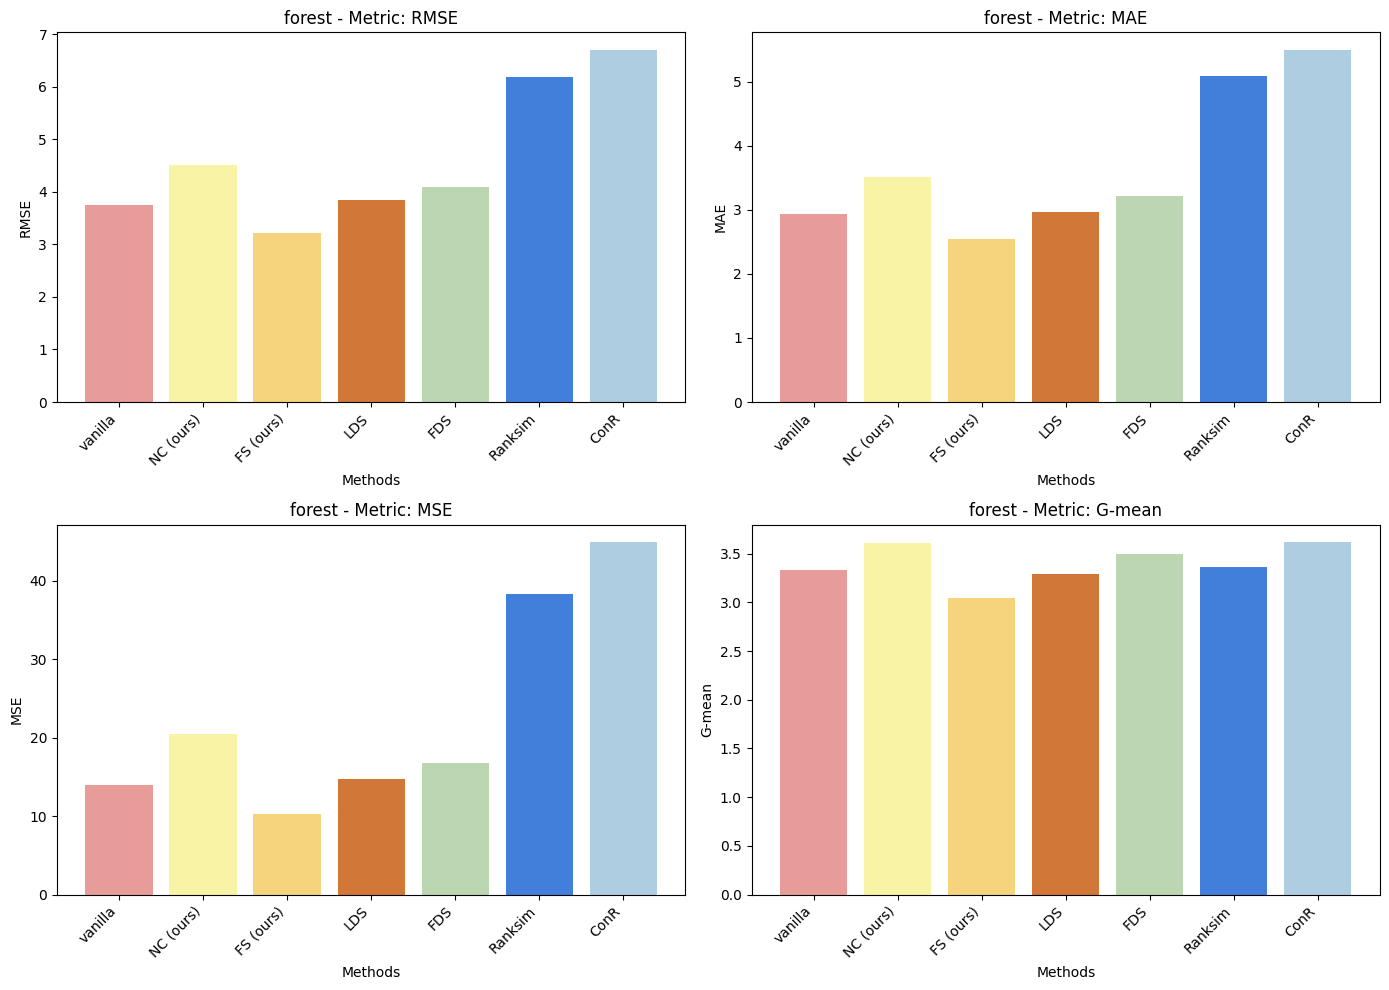

In [200]:
def main():

    X, y = df.drop([actual_col], axis=1).dropna().reset_index(drop=True).values, df[actual_col].dropna().reset_index(drop=True).values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    # Correct model instantiation
    input_features = X_train.shape[1]
    models = {
        'cnn': CNNRegressor(num_features=input_features, output_dim=1),
        # 'rnn': RNNRegressor(input_dim=input_features, hidden_dim=50, output_dim=1),
        # 'lstm': LSTMRegressor(input_dim=input_features, hidden_dim=50, output_dim=1),
        'regression': LinearRegression()
    }

    # Scenario 1: Original Dataset
    models_original = train_models(X_train, y_train)
    evaluations_original = evaluate_models(models_original, X_test, y_test)
    print("original dataset:", evaluations_original)

    # Scenario 2: Samples of nearest cells: Calibration Method
    final_df_nc_raking = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/forest_final_df_nc_raking.csv")
    X_train_nc, X_test_nc, y_train_nc, y_test_nc = custom_train_test_split(final_df_nc_raking, df, actual_col, test_size=0.3, random_state=42)
    y_combined = np.concatenate([y_train_nc, y_test_nc]) # for plotting
    models_nc = train_models(X_train_nc, y_train_nc)
    evaluations_nc_raking = evaluate_models(models_nc, X_test_nc, y_test_nc)
    print("Nearest Cell dataset:", evaluations_nc_raking)

    # Scenario 3: Samples of Features Similarity: Calibration Method
    final_df_fs_raking = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/forest_final_df_sn_raking.csv")
    X_train_fs_raking, X_test_fs_raking, y_train_fs_raking, y_test_fs_raking = custom_train_test_split(final_df_fs_raking, df, actual_col, test_size=0.3, random_state=42)
    y_combined = np.concatenate([y_train_fs_raking, y_test_fs_raking]) # for plotting
    models_fs_raking = train_models(X_train_fs_raking, y_train_fs_raking)
    evaluations_fs_raking = evaluate_models(models_fs_raking, X_test_fs_raking, y_test_fs_raking)
    print("Features Similarity dataset:", evaluations_fs_raking)
    
    # Scenario 4: LDS (Label Distribution Smoothing)
    X, y = df1.drop([actual_col, target_col, 'high_range', 'low_range'], axis=1).dropna().reset_index(drop=True).values, df1[actual_col].dropna().reset_index(drop=True).values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    train_weights = prepare_weights(labels=y_train.astype(int), reweight=None, max_target=int(max(y_train)))
    test_weights = prepare_weights(labels=y_test.astype(int), reweight=None, max_target=int(max(y_test)))
    models_lds = train_models(X_train, y_train, lds=True, weights=train_weights)
    evaluations_lds = evaluate_models(models_lds, X_test, y_test, lds=True, weights=test_weights)
    print("LDS dataset:", evaluations_lds)

    # Scenario 4: NC + LDS (Label Distribution Smoothing)
    df_nc = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/forest_final_df_nc_raking.csv")
    X, y = df_nc.drop([actual_col], axis=1).dropna().reset_index(drop=True).values, df_nc[actual_col].dropna().reset_index(drop=True).values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    train_weights = prepare_weights(labels=y_train.astype(int), reweight=None, max_target=int(max(y_train)))
    test_weights = prepare_weights(labels=y_test.astype(int), reweight=None, max_target=int(max(y_test)))
    models_nc_lds = train_models(X_train, y_train, lds=True, weights=train_weights)
    evaluations_nc_lds = evaluate_models(models_nc_lds, X_test, y_test, lds=True, weights=test_weights)
    print("NC + LDS dataset:", evaluations_nc_lds)

    # Scenario 4: FS + LDS (Label Distribution Smoothing)
    df_fs = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/forest_final_df_sn_raking.csv")
    X, y = df_fs.drop([actual_col], axis=1).dropna().reset_index(drop=True).values, df_fs[actual_col].dropna().reset_index(drop=True).values  
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    train_weights = prepare_weights(labels=y_train.astype(int), reweight=None, max_target=int(max(y_train)))
    test_weights = prepare_weights(labels=y_test.astype(int), reweight=None, max_target=int(max(y_test)))
    models_fs_lds = train_models(X_train, y_train, lds=True, weights=train_weights)
    evaluations_fs_lds = evaluate_models(models_fs_lds, X_test, y_test, lds=True, weights=test_weights)
    print("FS + LDS dataset:", evaluations_fs_lds)

    # Scenario 5: FDS (Feature Distribution Smoothing)
    X, y = df1.drop([actual_col, target_col, 'high_range', 'low_range'], axis=1).dropna().reset_index(drop=True).values, df1[actual_col].dropna().reset_index(drop=True).values
    X_train_fds, X_test_fds, y_train_fds, y_test_fds = train_test_split(X, y, test_size=0.3, random_state=42)
    models_fds = train_models(X_train_fds, y_train_fds, fds=True)
    evaluations_fds = evaluate_models(models_fds, X_test_fds, y_test_fds)
    print("FDS dataset:", evaluations_fds)

    # Scenario 5: NC + FDS (Feature Distribution Smoothing)
    df_nc = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/forest_final_df_nc_raking.csv")
    X, y = df_nc.drop([actual_col], axis=1).dropna().reset_index(drop=True).values, df_nc[actual_col].dropna().reset_index(drop=True).values
    X_train_fds, X_test_fds, y_train_fds, y_test_fds = train_test_split(X, y, test_size=0.3, random_state=42)
    models_nc_fds = train_models(X_train_fds, y_train_fds, fds=True)
    evaluations_nc_fds = evaluate_models(models_nc_fds, X_test_fds, y_test_fds)
    print("NC + FDS dataset:", evaluations_nc_fds)

    # Scenario 5: FS + FDS (Feature Distribution Smoothing)
    df_fs = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/forest_final_df_sn_raking.csv")
    X, y = df_fs.drop([actual_col], axis=1).dropna().reset_index(drop=True).values, df_fs[actual_col].dropna().reset_index(drop=True).values
    X_train_fds, X_test_fds, y_train_fds, y_test_fds = train_test_split(X, y, test_size=0.3, random_state=42)
    models_fs_fds = train_models(X_train_fds, y_train_fds, fds=True)
    evaluations_fs_fds = evaluate_models(models_fs_fds, X_test_fds, y_test_fds)
    print("FS + FDS dataset:", evaluations_fs_fds)

    # Scenario 6: LDS + FDS
    X, y = df1.drop([actual_col, target_col, 'high_range', 'low_range'], axis=1).dropna().reset_index(drop=True).values, df1[actual_col].dropna().reset_index(drop=True).values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    train_weights = prepare_weights(labels=y_train.astype(int), reweight=None, max_target=int(max(y_train)))
    test_weights = prepare_weights(labels=y_test.astype(int), reweight=None, max_target=int(max(y_test)))
    models_lds_fds = train_models(X_train, y_train, lds=True, fds=True, weights=train_weights)
    evaluations_lds_fds = evaluate_models(models_lds_fds, X_test, y_test, lds=True, weights=test_weights)
    print("LDS + FDS dataset:", evaluations_lds_fds)

    # Scenario 6: NC + LDS + FDS
    df_nc = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/forest_final_df_nc_raking.csv")
    X, y = df_nc.drop([actual_col], axis=1).dropna().reset_index(drop=True).values, df_nc[actual_col].dropna().reset_index(drop=True).values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    train_weights = prepare_weights(labels=y_train.astype(int), reweight=None, max_target=int(max(y_train)))
    test_weights = prepare_weights(labels=y_test.astype(int), reweight=None, max_target=int(max(y_test)))
    models_nc_lds_fds = train_models(X_train, y_train, lds=True, fds=True, weights=train_weights)
    evaluations_nc_lds_fds = evaluate_models(models_nc_lds_fds, X_test, y_test, lds=True, weights=test_weights)
    print("NC + LDS + FDS dataset:", evaluations_nc_lds_fds)

    # Scenario 6: FS + LDS + FDS
    df_fs = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/forest_final_df_sn_raking.csv")
    X, y = df_fs.drop([actual_col], axis=1).dropna().reset_index(drop=True).values, df_fs[actual_col].dropna().reset_index(drop=True).values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    train_weights = prepare_weights(labels=y_train.astype(int), reweight=None, max_target=int(max(y_train)))
    test_weights = prepare_weights(labels=y_test.astype(int), reweight=None, max_target=int(max(y_test)))
    models_fs_lds_fds = train_models(X_train, y_train, lds=True, fds=True, weights=train_weights)
    evaluations_fs_lds_fds = evaluate_models(models_fs_lds_fds, X_test, y_test, lds=True, weights=test_weights)
    print("FS + LDS + FDS dataset:", evaluations_fs_lds_fds)

    # Scenario 7: Ranksim
    ranksim_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_forest_regression_model.pth'
    reg_model.load_state_dict(torch.load(ranksim_path))
    _, val_indices = train_test_split(np.arange(len(df)), test_size=0.3, random_state=42)
    X_orig = df.drop([actual_col], axis=1).dropna().reset_index(drop=True).values
    y_orig = df[actual_col].dropna().reset_index(drop=True).values
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = ForestDataset(X_orig[val_indices], y_orig[val_indices], weights=val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_ranksim = validate_ranksim(val_loader, reg_model, lds=False, train_labels=None, prefix='Val')
    print("Ranksim dataset:", evaluations_ranksim)

    # Scenario 7: NC + Ranksim
    ranksim_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_forest_nc_regression_model.pth'
    reg_model.load_state_dict(torch.load(ranksim_path))
    _, val_indices = train_test_split(np.arange(len(df)), test_size=0.3, random_state=42)
    X_orig = df.drop([actual_col], axis=1).dropna().reset_index(drop=True).values
    y_orig = df[actual_col].dropna().reset_index(drop=True).values
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = ForestDataset(X_orig[val_indices], y_orig[val_indices], weights=val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_nc_ranksim = validate_ranksim(val_loader, reg_model, lds=False, train_labels=None, prefix='Val')
    print("NC + Ranksim dataset:", evaluations_nc_ranksim)

    # Scenario 7: NC + Ranksim
    ranksim_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_forest_fs_regression_model.pth'
    reg_model.load_state_dict(torch.load(ranksim_path))
    _, val_indices = train_test_split(np.arange(len(df)), test_size=0.3, random_state=42)
    X_orig = df.drop([actual_col], axis=1).dropna().reset_index(drop=True).values
    y_orig = df[actual_col].dropna().reset_index(drop=True).values
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = ForestDataset(X_orig[val_indices], y_orig[val_indices], weights=val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_fs_ranksim = validate_ranksim(val_loader, reg_model, lds=False, train_labels=None, prefix='Val')
    print("FS + Ranksim dataset:", evaluations_fs_ranksim)

    # Scenario 8: Ranksim + LDS Validation
    ranksim_lds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_forest_regression_model_with_LDS.pth'
    reg_model.load_state_dict(torch.load(ranksim_lds_path))
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = ForestDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_ranksim_lds = validate_ranksim(val_loader, reg_model, lds=True, train_labels=None, prefix='Val')
    print("Ranksim + LDS dataset:", evaluations_ranksim_lds)

    # Scenario 8: NC + Ranksim + LDS Validation
    ranksim_lds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_forest_nc_regression_model_with_LDS.pth'
    reg_model.load_state_dict(torch.load(ranksim_lds_path))
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = ForestDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_nc_ranksim_lds = validate_ranksim(val_loader, reg_model, lds=True, train_labels=None, prefix='Val')
    print("NC + Ranksim + LDS dataset:", evaluations_nc_ranksim_lds)

    # Scenario 8: FS + Ranksim + LDS Validation
    ranksim_lds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_forest_fs_regression_model_with_LDS.pth'
    reg_model.load_state_dict(torch.load(ranksim_lds_path))
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = ForestDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_fs_ranksim_lds = validate_ranksim(val_loader, reg_model, lds=True, train_labels=None, prefix='Val')
    print("FS+ Ranksim + LDS dataset:", evaluations_fs_ranksim_lds)

    # Scenario 9: Ranksim + FDS Validation
    ranksim_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_forest_regression_model_with_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(ranksim_fds_path))
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = ForestDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_ranksim_fds = validate_ranksim(val_loader, reg_model_fds, lds=False, train_labels=None, prefix='Val')
    print("Ranksim + FDS dataset:", evaluations_ranksim_fds)

    # Scenario 9: NC + Ranksim + FDS Validation
    ranksim_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_forest_nc_regression_model_with_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(ranksim_fds_path))
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = ForestDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_nc_ranksim_fds = validate_ranksim(val_loader, reg_model_fds, lds=False, train_labels=None, prefix='Val')
    print("NC + Ranksim + FDS dataset:", evaluations_nc_ranksim_fds)

    # Scenario 9: FS + Ranksim + FDS Validation
    ranksim_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_forest_fs_regression_model_with_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(ranksim_fds_path))
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = ForestDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_fs_ranksim_fds = validate_ranksim(val_loader, reg_model_fds, lds=False, train_labels=None, prefix='Val')
    print("FS + Ranksim + FDS dataset:", evaluations_fs_ranksim_fds)
    
    # Scenario 10: Ranksim+ LDS + FDS Validation
    ranksim_lds_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_forest_regression_model_with_LDS_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(ranksim_lds_fds_path))
    # Split dataset into training and validation sets
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = ForestDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_ranksim_lds_fds = validate_ranksim(val_loader, reg_model_fds, lds=True, train_labels=None, prefix='Val')
    print("Ranksim + LDS + FDS dataset:", evaluations_ranksim_lds_fds)

    # Scenario 10: NC + Ranksim + LDS + FDS Validation
    ranksim_lds_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_forest_nc_regression_model_with_LDS_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(ranksim_lds_fds_path))
    # Split dataset into training and validation sets
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = ForestDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_nc_ranksim_lds_fds = validate_ranksim(val_loader, reg_model_fds, lds=True, train_labels=None, prefix='Val')
    print("NC + Ranksim + LDS + FDS dataset:", evaluations_nc_ranksim_lds_fds)

    # Scenario 10: FS + Ranksim + LDS + FDS Validation
    ranksim_lds_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_forest_fs_regression_model_with_LDS_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(ranksim_lds_fds_path))
    # Split dataset into training and validation sets
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = ForestDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_fs_ranksim_lds_fds = validate_ranksim(val_loader, reg_model_fds, lds=True, train_labels=None, prefix='Val')
    print("FS + Ranksim + LDS + FDS dataset:", evaluations_fs_ranksim_lds_fds)

    # Scenario 11: ConR
    conr_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_forest_regression_model_ConR.pth'
    reg_model.load_state_dict(torch.load(conr_path))
    _, val_indices = train_test_split(np.arange(len(df)), test_size=0.3, random_state=42)
    X_orig = df.drop([actual_col], axis=1).dropna().reset_index(drop=True).values
    y_orig = df[actual_col].dropna().reset_index(drop=True).values
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = ForestDataset(X_orig[val_indices], y_orig[val_indices], weights=val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_conr = validate_ranksim(val_loader, reg_model, lds=False, train_labels=None, prefix='Val')
    print("ConR dataset:", evaluations_conr)

    # Scenario 11: NC + ConR
    conr_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_forest_nc_regression_model_ConR.pth'
    reg_model.load_state_dict(torch.load(conr_path))
    _, val_indices = train_test_split(np.arange(len(df)), test_size=0.3, random_state=42)
    X_orig = df.drop([actual_col], axis=1).dropna().reset_index(drop=True).values
    y_orig = df[actual_col].dropna().reset_index(drop=True).values
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = ForestDataset(X_orig[val_indices], y_orig[val_indices], weights=val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_nc_conr = validate_ranksim(val_loader, reg_model, lds=False, train_labels=None, prefix='Val')
    print("NC + ConR dataset:", evaluations_nc_conr)
    
    # Scenario 11: FS + ConR
    conr_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_forest_fs_regression_model_ConR.pth'
    reg_model.load_state_dict(torch.load(conr_path))
    _, val_indices = train_test_split(np.arange(len(df)), test_size=0.3, random_state=42)
    X_orig = df.drop([actual_col], axis=1).dropna().reset_index(drop=True).values
    y_orig = df[actual_col].dropna().reset_index(drop=True).values
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = ForestDataset(X_orig[val_indices], y_orig[val_indices], weights=val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_fs_conr = validate_ranksim(val_loader, reg_model, lds=False, train_labels=None, prefix='Val')
    print("FS + ConR dataset:", evaluations_fs_conr)
            
    # Scenario 12: ConR + LDS Validation
    conr_lds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_forest_regression_model_ConR_with_LDS.pth'
    reg_model.load_state_dict(torch.load(conr_lds_path))
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = ForestDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_conr_lds = validate_ranksim(val_loader, reg_model, lds=True, train_labels=None, prefix='Val')
    print("ConR + LDS dataset:", evaluations_conr_lds)

    # Scenario 12: NC + ConR + LDS Validation
    conr_lds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_forest_nc_regression_model_ConR_with_LDS.pth'
    reg_model.load_state_dict(torch.load(conr_lds_path))
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = ForestDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_nc_conr_lds = validate_ranksim(val_loader, reg_model, lds=True, train_labels=None, prefix='Val')
    print("NC + ConR + LDS dataset:", evaluations_nc_conr_lds)

    # Scenario 12: FS + ConR + LDS Validation
    conr_lds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_forest_fs_regression_model_ConR_with_LDS.pth'
    reg_model.load_state_dict(torch.load(conr_lds_path))
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = ForestDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_fs_conr_lds = validate_ranksim(val_loader, reg_model, lds=True, train_labels=None, prefix='Val')
    print("FS + ConR + LDS dataset:", evaluations_fs_conr_lds)

    # Scenario 13: ConR + FDS Validation
    conr_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_forest_regression_model_ConR_with_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(conr_fds_path))
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = ForestDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_conr_fds = validate_ranksim(val_loader, reg_model_fds, lds=False, train_labels=None, prefix='Val')
    print("ConR + FDS dataset:", evaluations_conr_fds)

    # Scenario 13: NC + ConR + FDS Validation
    conr_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_forest_nc_regression_model_ConR_with_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(conr_fds_path))
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = ForestDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_nc_conr_fds = validate_ranksim(val_loader, reg_model_fds, lds=False, train_labels=None, prefix='Val')
    print("NC + ConR + FDS dataset:", evaluations_nc_conr_fds)

    # Scenario 13: FS + ConR + FDS Validation
    conr_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_forest_nc_regression_model_ConR_with_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(conr_fds_path))
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = ForestDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_fs_conr_fds = validate_ranksim(val_loader, reg_model_fds, lds=False, train_labels=None, prefix='Val')
    print("FS + ConR + FDS dataset:", evaluations_fs_conr_fds)
    
    # Scenario 14: ConR + LDS + FDS Validation
    conr_lds_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_forest_regression_model_ConR_with_LDS_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(conr_lds_fds_path))
    # Split dataset into training and validation sets
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = ForestDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_conr_lds_fds = validate_ranksim(val_loader, reg_model_fds, lds=True, train_labels=None, prefix='Val')
    print("Ranksim + LDS + FDS dataset:", evaluations_conr_lds_fds)

    # Scenario 14: NC + ConR + LDS + FDS Validation
    conr_lds_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_forest_nc_regression_model_ConR_with_LDS_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(conr_lds_fds_path))
    # Split dataset into training and validation sets
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = ForestDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_nc_conr_lds_fds = validate_ranksim(val_loader, reg_model_fds, lds=True, train_labels=None, prefix='Val')
    print("NC + Ranksim + LDS + FDS dataset:", evaluations_nc_conr_lds_fds)

    # Scenario 14: FS + ConR + LDS + FDS Validation
    conr_lds_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_forest_fs_regression_model_ConR_with_LDS_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(conr_lds_fds_path))
    # Split dataset into training and validation sets
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = ForestDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_fs_conr_lds_fds = validate_ranksim(val_loader, reg_model_fds, lds=True, train_labels=None, prefix='Val')
    print("FS + Ranksim + LDS + FDS dataset:", evaluations_fs_conr_lds_fds)

    # Calculate averages for each sampling method
    evaluations_dict = {
        'vanilla': evaluations_original,
        'NC (ours)': evaluations_nc_raking,
        'FS (ours)': evaluations_fs_raking,
        'LDS': evaluations_lds,
        'NC + LDS': evaluations_nc_lds,
        'FS + LDS': evaluations_fs_lds,
        'FDS': evaluations_fds,
        'NC + FDS': evaluations_nc_fds,
        'FS + FDS': evaluations_fs_fds,
        'LDS + FDS': evaluations_lds_fds,
        'NC + LDS + FDS': evaluations_nc_lds_fds,
        'FS + LDS + FDS': evaluations_nc_lds_fds,
        'Ranksim': evaluations_ranksim,
        'NC + Ranksim': evaluations_nc_ranksim,
        'FS + Ranksim': evaluations_fs_ranksim,
        'Ranksim + LDS': evaluations_ranksim_lds, 
        'NC + Ranksim + LDS': evaluations_nc_ranksim_lds, 
        'FS + Ranksim + LDS': evaluations_fs_ranksim_lds, 
        'Ranksim + FDS': evaluations_ranksim_fds,
        'NC + Ranksim + FDS': evaluations_nc_ranksim_fds,
        'FS + Ranksim + FDS': evaluations_fs_ranksim_fds,
        'Ranksim + LDS + FDS': evaluations_ranksim_lds_fds,  
        'NC + Ranksim + LDS + FDS': evaluations_nc_ranksim_lds_fds, 
        'FS + Ranksim + LDS + FDS': evaluations_fs_ranksim_lds_fds, 
        'ConR': evaluations_conr,
        'NC + ConR': evaluations_nc_conr,
        'FS + ConR': evaluations_fs_conr,
        "ConR + LDS": evaluations_conr_lds,
        "NC + ConR + LDS": evaluations_nc_conr_lds,
        "FS + ConR + LDS": evaluations_fs_conr_lds,
        "ConR + FDS": evaluations_conr_fds,
        "NC + ConR + FDS": evaluations_nc_conr_fds,
        "FS + ConR + FDS": evaluations_fs_conr_fds,
        "ConR + LDS + FDS": evaluations_conr_lds_fds,
        "NC + ConR + LDS + FDS": evaluations_nc_conr_lds_fds,
        "FS + ConR + LDS + FDS": evaluations_fs_conr_lds_fds
    }

    average_dict = {}
    for key, evaluations in evaluations_dict.items():
        average_dict[key] = calculate_averages(evaluations, is_ranksim=(key in ['Ranksim', 'ConR','Ranksim + LDS','Ranksim + FDS','Ranksim + LDS + FDS',
                                                                                "ConR + LDS","ConR + FDS","ConR + LDS + FDS", 'NC + Ranksim', 'FS + Ranksim', 
                                                                                'NC + Ranksim + LDS', 'FS + Ranksim + LDS', 'NC + Ranksim + FDS', 'FS + Ranksim + FDS', 
                                                                                'NC + Ranksim + LDS + FDS', 'FS + Ranksim + LDS + FDS', 'NC + ConR', 'FS + ConR', 
                                                                                "NC + ConR + LDS", "FS + ConR + LDS", "NC + ConR + FDS", "FS + ConR + FDS", 
                                                                                "NC + ConR + LDS + FDS", "FS + ConR + LDS + FDS"]), 
                                               select_best=False) #(key in ['NC_calibration', 'FS_calibration'])

     # Transform the dictionaries to match the expected structure for plotting
    average_dict_transformed = {method: {metric: average_dict[method][metric] for metric in ['RMSE', 'MAE', 'MSE', 'G-mean']} for method in evaluations_dict.keys()}

    # Create DataFrames for the averages
    average_df = pd.DataFrame(average_dict_transformed).T
    print(average_df)

    # Plot average comparisons
    methods = ['vanilla', 'NC (ours)', 'FS (ours)', 'LDS', 'FDS', 'Ranksim','ConR']
    plot_average_comparisons(average_dict, methods, dataset_name='forest',
                             save_path='/home/Imbalanced_Regression/Results/forest_average_comparisons.png')
    
    # plot_distribution_comparison(y, y_combined, K, dataset_name='Boston', 
    #                              save_path='/home/Imbalanced_Regression/Results/Boston_dist_comparisons.png')
    
    # Export the DataFrame to a CSV file
    average_df.to_csv(f'/home/Imbalanced_Regression/Results/forest_K_{K}_mj_{mj}_average_evaluations.csv')
    # save_combined_evaluations_to_csv(evaluations_dict, f'/home/Imbalanced_Regression/Results/forest_K_{K}_mj_{mj}_combined_evaluations.csv')
    # files.download(f'Boston_K_{K}_mj_{mj}_average_evaluations.csv')


    # download the balanced dataset
    # final_df_nc_raking.to_csv('/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/Boston_final_df_nc_raking.csv', index=False)
    # final_df_sn_raking.to_csv('/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/Boston_final_df_sn_raking.csv', index=False)


if __name__ == "__main__":
    main()


#### 4-2 - Iterations

Metrics for mlp: RMSE=3.69, MAE=2.97, MSE=13.64, G-mean=3.41
evaluations_original: {'mlp': {'RMSE': 3.693788108373562, 'MAE': 2.9712946048149695, 'MSE': 13.64407058956194, 'G-mean': 3.4146171450358285}}
Using LDS: [GAUSSIAN] (5/2)
Using LDS: [GAUSSIAN] (5/2)
Metrics for mlp: RMSE=3.81, MAE=2.85, MSE=14.51, G-mean=3.20
evaluations_lds: {'mlp': {'RMSE': 3.808556559855955, 'MAE': 2.8535915038524533, 'MSE': 14.505103069621827, 'G-mean': 3.1985036170240067}}
Metrics for mlp: RMSE=3.51, MAE=2.78, MSE=12.33, G-mean=3.27
evaluations_fds: {'mlp': {'RMSE': 3.5120655108840753, 'MAE': 2.7838457211469994, 'MSE': 12.334604152741422, 'G-mean': 3.2662454385661985}}
Using LDS: [GAUSSIAN] (5/2)
Using LDS: [GAUSSIAN] (5/2)
Metrics for mlp: RMSE=2.78, MAE=2.05, MSE=7.75, G-mean=2.63
evaluations_nc_lds: {'mlp': {'RMSE': 2.7831643, 'MAE': 2.0541205, 'MSE': 7.7460036, 'G-mean': 2.626314}}
Metrics for mlp: RMSE=3.96, MAE=3.07, MSE=15.71, G-mean=3.34
evaluations_nc_fds: {'mlp': {'RMSE': 3.9637175, 'MAE': 3.072

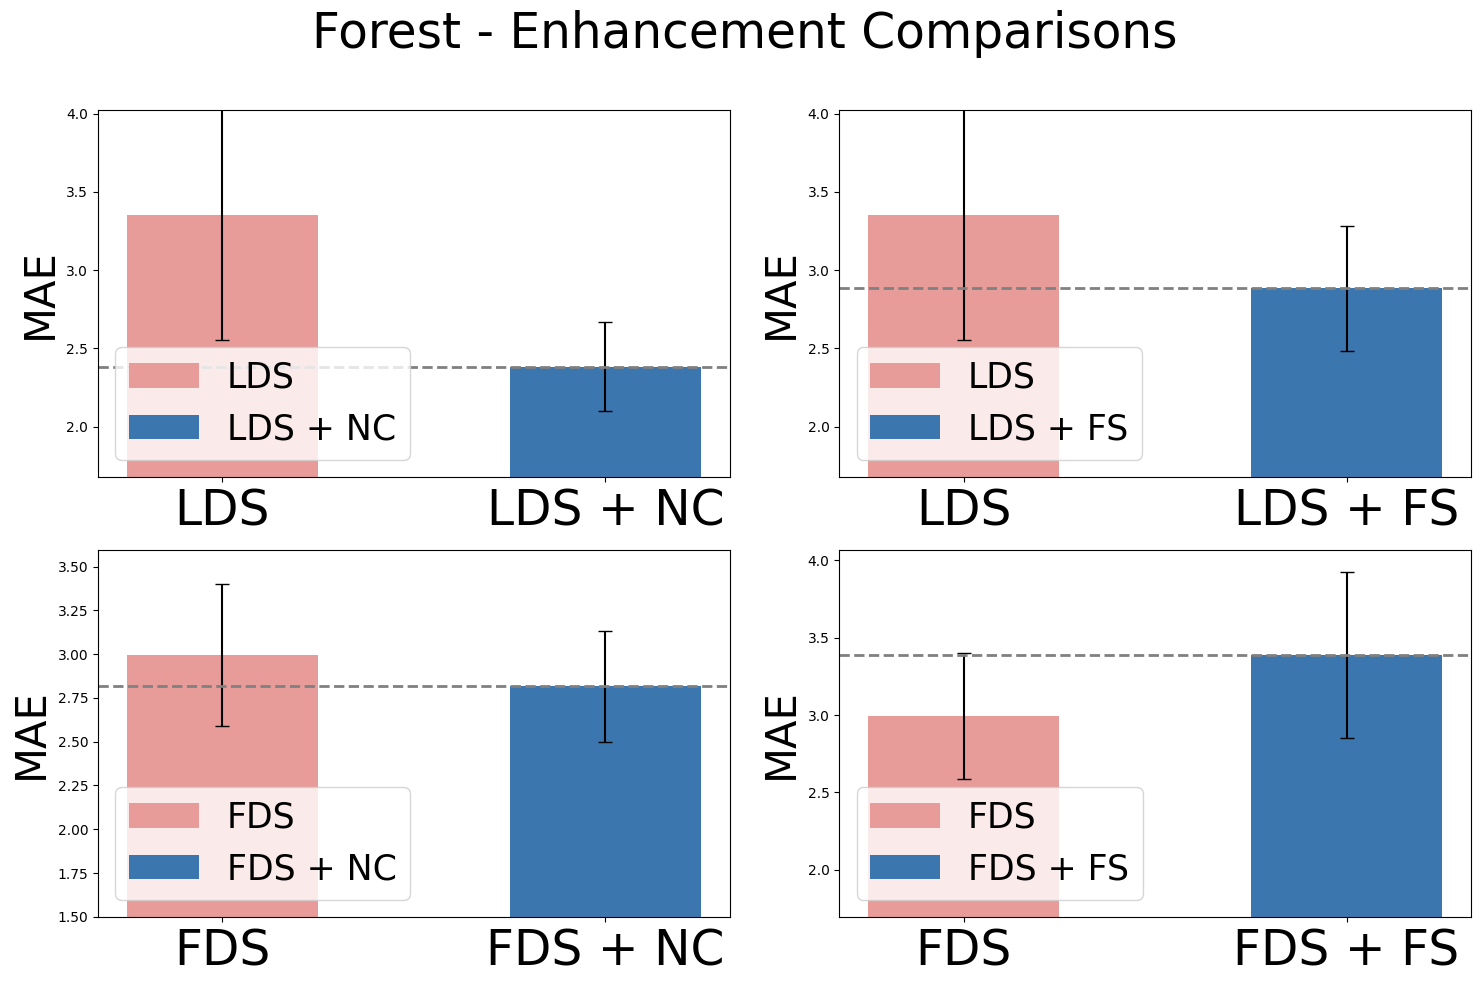

In [285]:
def main():
    iterations = 5
    results = []

    for iteration in range(iterations):
        X, y = df.drop([actual_col], axis=1).dropna().reset_index(drop=True).values, df[actual_col].dropna().reset_index(drop=True).values
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        input_features = X_train.shape[1]

        # Scenario 1: Original Dataset
        models_original = train_models(X_train, y_train)
        evaluations_original = evaluate_models(models_original, X_test, y_test)
        print(f"evaluations_original: {evaluations_original}")  # Debugging print statement
        if not isinstance(evaluations_original, dict):
            print(f"Error: evaluations_original is not a dictionary")
            continue
        
        # Scenario 4: LDS (Label Distribution Smoothing)
        X, y = df1.drop([actual_col, target_col, 'high_range', 'low_range'], axis=1).dropna().reset_index(drop=True).values, df1[actual_col].dropna().reset_index(drop=True).values
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        train_weights = prepare_weights(labels=y_train.astype(int), reweight=None, max_target=int(max(y_train)))
        test_weights = prepare_weights(labels=y_test.astype(int), reweight=None, max_target=int(max(y_test)))
        models_lds = train_models(X_train, y_train, lds=True, weights=train_weights)
        evaluations_lds = evaluate_models(models_lds, X_test, y_test, lds=True, weights=test_weights)
        print(f"evaluations_lds: {evaluations_lds}")  # Debugging print statement
        if not isinstance(evaluations_lds, dict):
            print(f"Error: evaluations_lds is not a dictionary")
            continue

        # Scenario 7: FDS (Feature Distribution Smoothing)
        X, y = df1.drop([actual_col, target_col, 'low_range', 'high_range'], axis=1).dropna().reset_index(drop=True).values, df1[actual_col].dropna().reset_index(drop=True).values
        X_train_fds, X_test_fds, y_train_fds, y_test_fds = train_test_split(X, y, test_size=0.3, random_state=42)
        models_fds = train_models(X_train_fds, y_train_fds, fds=True)
        evaluations_fds = evaluate_models(models_fds, X_test_fds, y_test_fds)
        print(f"evaluations_fds: {evaluations_fds}")  # Debugging print statement
        if not isinstance(evaluations_fds, dict):
            print(f"Error: evaluations_fds is not a dictionary")
            continue

        # Scenario 2: NC+LDS
        final_df_nc_raking = pd.read_csv('/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/forest_final_df_nc_raking.csv')
        X_train_nc, X_test_nc, y_train_nc, y_test_nc = custom_train_test_split(final_df_nc_raking, df, actual_col, test_size=0.3, random_state=42)
        train_weights = prepare_weights(labels=y_train_nc.astype(int), reweight=None, max_target=int(max(y_train_nc)))
        test_weights = prepare_weights(labels=y_test_nc.astype(int), reweight=None, max_target=int(max(y_test_nc)))
        models_nc_lds = train_models(X_train_nc, y_train_nc, lds=True, weights=train_weights)
        evaluations_nc_lds = evaluate_models(models_nc_lds, X_test_nc, y_test_nc, lds=True, weights=test_weights)
        print(f"evaluations_nc_lds: {evaluations_nc_lds}")  # Debugging print statement
        if not isinstance(evaluations_nc_lds, dict):
            print(f"Error: evaluations_nc_lds is not a dictionary")
            continue

        # Scenario 3: NC+FDS
        X_train_nc, X_test_nc, y_train_nc, y_test_nc = custom_train_test_split(final_df_nc_raking, df, actual_col, test_size=0.3, random_state=42)
        models_nc_fds = train_models(X_train_nc, y_train_nc, fds=True)
        evaluations_nc_fds = evaluate_models(models_nc_fds, X_test_nc, y_test_nc)
        print(f"evaluations_nc_fds: {evaluations_nc_fds}")  # Debugging print statement
        if not isinstance(evaluations_nc_fds, dict):
            print(f"Error: evaluations_nc_fds is not a dictionary")
            continue

        # Scenario 4: FS+LDS
        final_df_sn_raking = pd.read_csv('/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/forest_final_df_sn_raking.csv')
        X_train_sn_raking, X_test_sn_raking, y_train_sn_raking, y_test_sn_raking = custom_train_test_split(final_df_sn_raking, df, actual_col, test_size=0.3, random_state=42)
        train_weights = prepare_weights(labels=y_train_sn_raking.astype(int), reweight=None, max_target=int(max(y_train_sn_raking)))
        test_weights = prepare_weights(labels=y_test_sn_raking.astype(int), reweight=None, max_target=int(max(y_test_sn_raking)))
        models_fs_lds = train_models(X_train_sn_raking, y_train_sn_raking, lds=True, weights=train_weights)
        evaluations_fs_lds = evaluate_models(models_fs_lds, X_test_sn_raking, y_test_sn_raking, lds=True, weights=test_weights)
        print(f"evaluations_fs_lds: {evaluations_fs_lds}")  # Debugging print statement
        if not isinstance(evaluations_fs_lds, dict):
            print(f"Error: evaluations_fs_lds is not a dictionary")
            continue

        # Scenario 5: FS+FDS
        X_train_sn_raking, X_test_sn_raking, y_train_sn_raking, y_test_sn_raking = custom_train_test_split(final_df_sn_raking, df, actual_col, test_size=0.3, random_state=42)
        models_fs_fds = train_models(X_train_sn_raking, y_train_sn_raking, fds=True)
        evaluations_fs_fds = evaluate_models(models_fs_fds, X_test_sn_raking, y_test_sn_raking)
        print(f"evaluations_fs_fds: {evaluations_fs_fds}")  # Debugging print statement
        if not isinstance(evaluations_fs_fds, dict):
            print(f"Error: evaluations_fs_fds is not a dictionary")
            continue

        # Save all the results for the current iteration
        evaluations_dict = {
            'LDS': evaluations_lds,
            'nc_lds': evaluations_nc_lds,
            'fs_lds': evaluations_fs_lds,
            'FDS': evaluations_fds,
            'nc_fds': evaluations_nc_fds,
            'fs_fds': evaluations_fs_fds
        }

        for key, evaluations in evaluations_dict.items():
            average_metrics = calculate_averages2(evaluations, is_ranksim=False, select_best=False)
            if not isinstance(average_metrics, dict):
                print(f"Error: average_metrics for {key} is not a dictionary")
                continue
            for metric, value in average_metrics.items():
                result = {'iteration': iteration, 'scenario': key, 'metric': metric, 'value': value}
                print(f"Appending result: {result}")  # Debugging print statement
                results.append(result)
                    
    # Convert results to DataFrame and save
    results_df = pd.DataFrame(results)
    print(f"Results DataFrame:\n{results_df}")  # Debugging print statement

    # Calculate averages for each sampling method
    average_dict = {}
    std_dict = {}
    for key, group in results_df.groupby('scenario'):
        group_metrics = group.pivot_table(values='value', index='iteration', columns='metric').mean().to_dict()
        average_metrics = {metric: group_metrics.get('MAE', float('nan')) for metric in ['MAE']}
        std_metrics = {metric: group.pivot_table(values='value', index='iteration', columns='metric').std().to_dict().get('MAE', float('nan')) for metric in ['MAE']}
        average_dict[key] = average_metrics
        std_dict[key] = std_metrics

    # Plot comparisons
    plot_enhancement_comparisons(average_dict, std_dict, dataset_name='Forest', save_path_prefix='/home/Imbalanced_Regression/Results/Enhancement')

if __name__ == "__main__":
    main()


### 5 - Run adult income

#### 7-1 - main training

In [357]:
class AdultincomeDataset(Dataset):
    def __init__(self, features, targets, weights, lds=False):
        self.features = features
        self.targets = targets
        self.weights = weights
        self.lds = lds

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
          feature = self.features[idx]
          target = self.targets[idx]
          weight = self.weights[idx]
          return feature, target, weight

Metrics for mlp: RMSE=33.40, MAE=26.92, MSE=1115.68, G-mean=20.47
original dataset: {'mlp': {'RMSE': 33.401803708764625, 'MAE': 26.924361351772454, 'MSE': 1115.6804909988423, 'G-mean': 20.47231824925212}}
Metrics for mlp: RMSE=12.71, MAE=10.11, MSE=161.56, G-mean=8.56
Nearest Cell dataset: {'mlp': {'RMSE': 12.710731, 'MAE': 10.1145735, 'MSE': 161.56268, 'G-mean': 8.560155}}
Metrics for mlp: RMSE=13.11, MAE=10.60, MSE=171.94, G-mean=8.94
Features Similarity dataset: {'mlp': {'RMSE': 13.112654, 'MAE': 10.595288, 'MSE': 171.94168, 'G-mean': 8.944615}}
Using LDS: [GAUSSIAN] (5/2)
Using LDS: [GAUSSIAN] (5/2)
Metrics for mlp: RMSE=22.22, MAE=17.31, MSE=493.81, G-mean=13.24
LDS dataset: {'mlp': {'RMSE': 22.221776904649836, 'MAE': 17.30641582171144, 'MSE': 493.8073688000288, 'G-mean': 13.23523449648423}}
Using LDS: [GAUSSIAN] (5/2)
Using LDS: [GAUSSIAN] (5/2)
Metrics for mlp: RMSE=15.27, MAE=12.45, MSE=233.23, G-mean=10.33
NC + LDS dataset: {'mlp': {'RMSE': 15.271897245523437, 'MAE': 12.449992

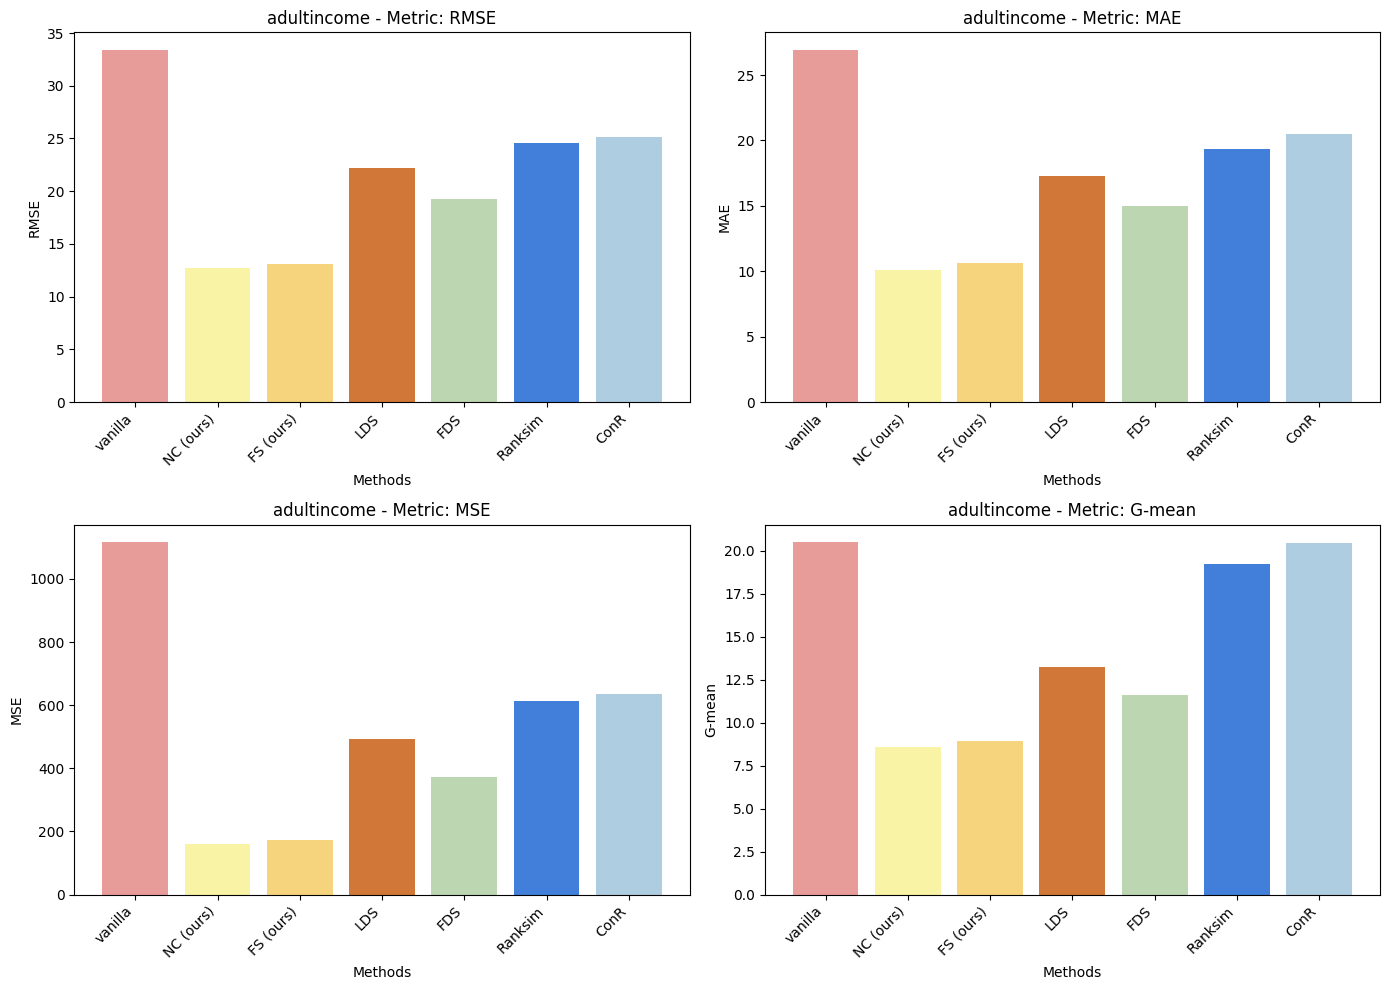

In [230]:
def main():

    X, y = df.drop([actual_col], axis=1).dropna().reset_index(drop=True).values, df[actual_col].dropna().reset_index(drop=True).values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    # Correct model instantiation
    input_features = X_train.shape[1]


    # Scenario 1: Original Dataset
    models_original = train_models(X_train, y_train)
    evaluations_original = evaluate_models(models_original, X_test, y_test)
    print("original dataset:", evaluations_original)

    # Scenario 2: Samples of nearest cells: Calibration Method
    final_df_nc_raking = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/adultincome_final_df_nc_raking.csv")
    X_train_nc, X_test_nc, y_train_nc, y_test_nc = custom_train_test_split(final_df_nc_raking, df, actual_col, test_size=0.3, random_state=42)
    y_combined = np.concatenate([y_train_nc, y_test_nc]) # for plotting
    models_nc = train_models(X_train_nc, y_train_nc)
    evaluations_nc_raking = evaluate_models(models_nc, X_test_nc, y_test_nc)
    print("Nearest Cell dataset:", evaluations_nc_raking)

    # Scenario 3: Samples of Features Similarity: Calibration Method
    final_df_fs_raking = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/adultincome_final_df_sn_raking.csv")
    X_train_fs_raking, X_test_fs_raking, y_train_fs_raking, y_test_fs_raking = custom_train_test_split(final_df_fs_raking, df, actual_col, test_size=0.3, random_state=42)
    y_combined = np.concatenate([y_train_fs_raking, y_test_fs_raking]) # for plotting
    models_fs_raking = train_models(X_train_fs_raking, y_train_fs_raking)
    evaluations_fs_raking = evaluate_models(models_fs_raking, X_test_fs_raking, y_test_fs_raking)
    print("Features Similarity dataset:", evaluations_fs_raking)
    
    # Scenario 4: LDS (Label Distribution Smoothing)
    X, y = df1.drop([actual_col, target_col, 'high_range', 'low_range'], axis=1).dropna().reset_index(drop=True).values, df1[actual_col].dropna().reset_index(drop=True).values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    train_weights = prepare_weights(labels=y_train.astype(int), reweight=None, max_target=int(max(y_train)))
    test_weights = prepare_weights(labels=y_test.astype(int), reweight=None, max_target=int(max(y_test)))
    models_lds = train_models(X_train, y_train, lds=True, weights=train_weights)
    evaluations_lds = evaluate_models(models_lds, X_test, y_test, lds=True, weights=test_weights)
    print("LDS dataset:", evaluations_lds)

    # Scenario 4: NC + LDS (Label Distribution Smoothing)
    df_nc = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/adultincome_final_df_nc_raking.csv")
    X, y = df_nc.drop([actual_col], axis=1).dropna().reset_index(drop=True).values, df_nc[actual_col].dropna().reset_index(drop=True).values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    train_weights = prepare_weights(labels=y_train.astype(int), reweight=None, max_target=int(max(y_train)))
    test_weights = prepare_weights(labels=y_test.astype(int), reweight=None, max_target=int(max(y_test)))
    models_nc_lds = train_models(X_train, y_train, lds=True, weights=train_weights)
    evaluations_nc_lds = evaluate_models(models_nc_lds, X_test, y_test, lds=True, weights=test_weights)
    print("NC + LDS dataset:", evaluations_nc_lds)

    # Scenario 4: FS + LDS (Label Distribution Smoothing)
    df_fs = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/adultincome_final_df_sn_raking.csv")
    X, y = df_fs.drop([actual_col], axis=1).dropna().reset_index(drop=True).values, df_fs[actual_col].dropna().reset_index(drop=True).values  
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    train_weights = prepare_weights(labels=y_train.astype(int), reweight=None, max_target=int(max(y_train)))
    test_weights = prepare_weights(labels=y_test.astype(int), reweight=None, max_target=int(max(y_test)))
    models_fs_lds = train_models(X_train, y_train, lds=True, weights=train_weights)
    evaluations_fs_lds = evaluate_models(models_fs_lds, X_test, y_test, lds=True, weights=test_weights)
    print("FS + LDS dataset:", evaluations_fs_lds)

    # Scenario 5: FDS (Feature Distribution Smoothing)
    X, y = df1.drop([actual_col, target_col, 'high_range', 'low_range'], axis=1).dropna().reset_index(drop=True).values, df1[actual_col].dropna().reset_index(drop=True).values
    X_train_fds, X_test_fds, y_train_fds, y_test_fds = train_test_split(X, y, test_size=0.3, random_state=42)
    models_fds = train_models(X_train_fds, y_train_fds, fds=True)
    evaluations_fds = evaluate_models(models_fds, X_test_fds, y_test_fds)
    print("FDS dataset:", evaluations_fds)

    # Scenario 5: NC + FDS (Feature Distribution Smoothing)
    df_nc = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/adultincome_final_df_nc_raking.csv")
    X, y = df_nc.drop([actual_col], axis=1).dropna().reset_index(drop=True).values, df_nc[actual_col].dropna().reset_index(drop=True).values
    X_train_fds, X_test_fds, y_train_fds, y_test_fds = train_test_split(X, y, test_size=0.3, random_state=42)
    models_nc_fds = train_models(X_train_fds, y_train_fds, fds=True)
    evaluations_nc_fds = evaluate_models(models_nc_fds, X_test_fds, y_test_fds)
    print("NC + FDS dataset:", evaluations_nc_fds)

    # Scenario 5: FS + FDS (Feature Distribution Smoothing)
    df_fs = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/adultincome_final_df_sn_raking.csv")
    X, y = df_fs.drop([actual_col], axis=1).dropna().reset_index(drop=True).values, df_fs[actual_col].dropna().reset_index(drop=True).values
    X_train_fds, X_test_fds, y_train_fds, y_test_fds = train_test_split(X, y, test_size=0.3, random_state=42)
    models_fs_fds = train_models(X_train_fds, y_train_fds, fds=True)
    evaluations_fs_fds = evaluate_models(models_fs_fds, X_test_fds, y_test_fds)
    print("FS + FDS dataset:", evaluations_fs_fds)

    # Scenario 6: LDS + FDS
    X, y = df1.drop([actual_col, target_col, 'high_range', 'low_range'], axis=1).dropna().reset_index(drop=True).values, df1[actual_col].dropna().reset_index(drop=True).values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    train_weights = prepare_weights(labels=y_train.astype(int), reweight=None, max_target=int(max(y_train)))
    test_weights = prepare_weights(labels=y_test.astype(int), reweight=None, max_target=int(max(y_test)))
    models_lds_fds = train_models(X_train, y_train, lds=True, fds=True, weights=train_weights)
    evaluations_lds_fds = evaluate_models(models_lds_fds, X_test, y_test, lds=True, weights=test_weights)
    print("LDS + FDS dataset:", evaluations_lds_fds)

    # Scenario 6: NC + LDS + FDS
    df_nc = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/adultincome_final_df_nc_raking.csv")
    X, y = df_nc.drop([actual_col], axis=1).dropna().reset_index(drop=True).values, df_nc[actual_col].dropna().reset_index(drop=True).values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    train_weights = prepare_weights(labels=y_train.astype(int), reweight=None, max_target=int(max(y_train)))
    test_weights = prepare_weights(labels=y_test.astype(int), reweight=None, max_target=int(max(y_test)))
    models_nc_lds_fds = train_models(X_train, y_train, lds=True, fds=True, weights=train_weights)
    evaluations_nc_lds_fds = evaluate_models(models_nc_lds_fds, X_test, y_test, lds=True, weights=test_weights)
    print("NC + LDS + FDS dataset:", evaluations_nc_lds_fds)

    # Scenario 6: FS + LDS + FDS
    df_fs = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/adultincome_final_df_sn_raking.csv")
    X, y = df_fs.drop([actual_col], axis=1).dropna().reset_index(drop=True).values, df_fs[actual_col].dropna().reset_index(drop=True).values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    train_weights = prepare_weights(labels=y_train.astype(int), reweight=None, max_target=int(max(y_train)))
    test_weights = prepare_weights(labels=y_test.astype(int), reweight=None, max_target=int(max(y_test)))
    models_fs_lds_fds = train_models(X_train, y_train, lds=True, fds=True, weights=train_weights)
    evaluations_fs_lds_fds = evaluate_models(models_fs_lds_fds, X_test, y_test, lds=True, weights=test_weights)
    print("FS + LDS + FDS dataset:", evaluations_fs_lds_fds)

    # Scenario 7: Ranksim
    ranksim_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_adult_income_regression_model.pth'
    reg_model.load_state_dict(torch.load(ranksim_path))
    _, val_indices = train_test_split(np.arange(len(df)), test_size=0.3, random_state=42)
    X_orig = df.drop([actual_col], axis=1).dropna().reset_index(drop=True).values
    y_orig = df[actual_col].dropna().reset_index(drop=True).values
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = AdultincomeDataset(X_orig[val_indices], y_orig[val_indices], weights=val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_ranksim = validate_ranksim(val_loader, reg_model, lds=False, train_labels=None, prefix='Val')
    print("Ranksim dataset:", evaluations_ranksim)

    # Scenario 7: NC + Ranksim
    ranksim_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_adult_income_nc_regression_model.pth'
    reg_model.load_state_dict(torch.load(ranksim_path))
    _, val_indices = train_test_split(np.arange(len(df)), test_size=0.3, random_state=42)
    X_orig = df.drop([actual_col], axis=1).dropna().reset_index(drop=True).values
    y_orig = df[actual_col].dropna().reset_index(drop=True).values
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = AdultincomeDataset(X_orig[val_indices], y_orig[val_indices], weights=val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_nc_ranksim = validate_ranksim(val_loader, reg_model, lds=False, train_labels=None, prefix='Val')
    print("NC + Ranksim dataset:", evaluations_nc_ranksim)

    # Scenario 7: NC + Ranksim
    ranksim_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_adult_income_fs_regression_model.pth'
    reg_model.load_state_dict(torch.load(ranksim_path))
    _, val_indices = train_test_split(np.arange(len(df)), test_size=0.3, random_state=42)
    X_orig = df.drop([actual_col], axis=1).dropna().reset_index(drop=True).values
    y_orig = df[actual_col].dropna().reset_index(drop=True).values
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = AdultincomeDataset(X_orig[val_indices], y_orig[val_indices], weights=val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_fs_ranksim = validate_ranksim(val_loader, reg_model, lds=False, train_labels=None, prefix='Val')
    print("FS + Ranksim dataset:", evaluations_fs_ranksim)

    # Scenario 8: Ranksim + LDS Validation
    ranksim_lds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_adult_income_regression_model_with_LDS.pth'
    reg_model.load_state_dict(torch.load(ranksim_lds_path))
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = AdultincomeDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_ranksim_lds = validate_ranksim(val_loader, reg_model, lds=True, train_labels=None, prefix='Val')
    print("Ranksim + LDS dataset:", evaluations_ranksim_lds)

    # Scenario 8: NC + Ranksim + LDS Validation
    ranksim_lds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_adult_income_nc_regression_model_with_LDS.pth'
    reg_model.load_state_dict(torch.load(ranksim_lds_path))
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = AdultincomeDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_nc_ranksim_lds = validate_ranksim(val_loader, reg_model, lds=True, train_labels=None, prefix='Val')
    print("NC + Ranksim + LDS dataset:", evaluations_nc_ranksim_lds)

    # Scenario 8: FS + Ranksim + LDS Validation
    ranksim_lds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_adult_income_fs_regression_model_with_LDS.pth'
    reg_model.load_state_dict(torch.load(ranksim_lds_path))
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = AdultincomeDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_fs_ranksim_lds = validate_ranksim(val_loader, reg_model, lds=True, train_labels=None, prefix='Val')
    print("FS+ Ranksim + LDS dataset:", evaluations_fs_ranksim_lds)

    # Scenario 9: Ranksim + FDS Validation
    ranksim_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_adult_income_regression_model_with_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(ranksim_fds_path))
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = AdultincomeDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_ranksim_fds = validate_ranksim(val_loader, reg_model_fds, lds=False, train_labels=None, prefix='Val')
    print("Ranksim + FDS dataset:", evaluations_ranksim_fds)

    # Scenario 9: NC + Ranksim + FDS Validation
    ranksim_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_adult_income_nc_regression_model_with_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(ranksim_fds_path))
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = AdultincomeDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_nc_ranksim_fds = validate_ranksim(val_loader, reg_model_fds, lds=False, train_labels=None, prefix='Val')
    print("NC + Ranksim + FDS dataset:", evaluations_nc_ranksim_fds)

    # Scenario 9: FS + Ranksim + FDS Validation
    ranksim_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_adult_income_fs_regression_model_with_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(ranksim_fds_path))
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = AdultincomeDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_fs_ranksim_fds = validate_ranksim(val_loader, reg_model_fds, lds=False, train_labels=None, prefix='Val')
    print("FS + Ranksim + FDS dataset:", evaluations_fs_ranksim_fds)
    
    # Scenario 10: Ranksim+ LDS + FDS Validation
    ranksim_lds_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_adult_income_regression_model_with_LDS_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(ranksim_lds_fds_path))
    # Split dataset into training and validation sets
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = AdultincomeDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_ranksim_lds_fds = validate_ranksim(val_loader, reg_model_fds, lds=True, train_labels=None, prefix='Val')
    print("Ranksim + LDS + FDS dataset:", evaluations_ranksim_lds_fds)

    # Scenario 10: NC + Ranksim + LDS + FDS Validation
    ranksim_lds_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_adult_income_nc_regression_model_with_LDS_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(ranksim_lds_fds_path))
    # Split dataset into training and validation sets
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = AdultincomeDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_nc_ranksim_lds_fds = validate_ranksim(val_loader, reg_model_fds, lds=True, train_labels=None, prefix='Val')
    print("NC + Ranksim + LDS + FDS dataset:", evaluations_nc_ranksim_lds_fds)

    # Scenario 10: FS + Ranksim + LDS + FDS Validation
    ranksim_lds_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_adult_income_fs_regression_model_with_LDS_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(ranksim_lds_fds_path))
    # Split dataset into training and validation sets
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = AdultincomeDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_fs_ranksim_lds_fds = validate_ranksim(val_loader, reg_model_fds, lds=True, train_labels=None, prefix='Val')
    print("FS + Ranksim + LDS + FDS dataset:", evaluations_fs_ranksim_lds_fds)

    # Scenario 11: ConR
    conr_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_adult_income_regression_model_ConR.pth'
    reg_model.load_state_dict(torch.load(conr_path))
    _, val_indices = train_test_split(np.arange(len(df)), test_size=0.3, random_state=42)
    X_orig = df.drop([actual_col], axis=1).dropna().reset_index(drop=True).values
    y_orig = df[actual_col].dropna().reset_index(drop=True).values
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = AdultincomeDataset(X_orig[val_indices], y_orig[val_indices], weights=val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_conr = validate_ranksim(val_loader, reg_model, lds=False, train_labels=None, prefix='Val')
    print("ConR dataset:", evaluations_conr)

    # Scenario 11: NC + ConR
    conr_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_adult_income_nc_regression_model_ConR.pth'
    reg_model.load_state_dict(torch.load(conr_path))
    _, val_indices = train_test_split(np.arange(len(df)), test_size=0.3, random_state=42)
    X_orig = df.drop([actual_col], axis=1).dropna().reset_index(drop=True).values
    y_orig = df[actual_col].dropna().reset_index(drop=True).values
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = AdultincomeDataset(X_orig[val_indices], y_orig[val_indices], weights=val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_nc_conr = validate_ranksim(val_loader, reg_model, lds=False, train_labels=None, prefix='Val')
    print("NC + ConR dataset:", evaluations_nc_conr)
    
    # Scenario 11: FS + ConR
    conr_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_adult_income_fs_regression_model_ConR.pth'
    reg_model.load_state_dict(torch.load(conr_path))
    _, val_indices = train_test_split(np.arange(len(df)), test_size=0.3, random_state=42)
    X_orig = df.drop([actual_col], axis=1).dropna().reset_index(drop=True).values
    y_orig = df[actual_col].dropna().reset_index(drop=True).values
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = AdultincomeDataset(X_orig[val_indices], y_orig[val_indices], weights=val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_fs_conr = validate_ranksim(val_loader, reg_model, lds=False, train_labels=None, prefix='Val')
    print("FS + ConR dataset:", evaluations_fs_conr)
            
    # Scenario 12: ConR + LDS Validation
    conr_lds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_adult_income_regression_model_ConR_with_LDS.pth'
    reg_model.load_state_dict(torch.load(conr_lds_path))
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = AdultincomeDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_conr_lds = validate_ranksim(val_loader, reg_model, lds=True, train_labels=None, prefix='Val')
    print("ConR + LDS dataset:", evaluations_conr_lds)

    # Scenario 12: NC + ConR + LDS Validation
    conr_lds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_adult_income_nc_regression_model_ConR_with_LDS.pth'
    reg_model.load_state_dict(torch.load(conr_lds_path))
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = AdultincomeDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_nc_conr_lds = validate_ranksim(val_loader, reg_model, lds=True, train_labels=None, prefix='Val')
    print("NC + ConR + LDS dataset:", evaluations_nc_conr_lds)

    # Scenario 12: FS + ConR + LDS Validation
    conr_lds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_adult_income_fs_regression_model_ConR_with_LDS.pth'
    reg_model.load_state_dict(torch.load(conr_lds_path))
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = AdultincomeDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_fs_conr_lds = validate_ranksim(val_loader, reg_model, lds=True, train_labels=None, prefix='Val')
    print("FS + ConR + LDS dataset:", evaluations_fs_conr_lds)

    # Scenario 13: ConR + FDS Validation
    conr_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_adult_income_regression_model_ConR_with_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(conr_fds_path))
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = AdultincomeDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_conr_fds = validate_ranksim(val_loader, reg_model_fds, lds=False, train_labels=None, prefix='Val')
    print("ConR + FDS dataset:", evaluations_conr_fds)

    # Scenario 13: NC + ConR + FDS Validation
    conr_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_adult_income_nc_regression_model_ConR_with_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(conr_fds_path))
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = AdultincomeDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_nc_conr_fds = validate_ranksim(val_loader, reg_model_fds, lds=False, train_labels=None, prefix='Val')
    print("NC + ConR + FDS dataset:", evaluations_nc_conr_fds)

    # Scenario 13: FS + ConR + FDS Validation
    conr_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_adult_income_nc_regression_model_ConR_with_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(conr_fds_path))
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = AdultincomeDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_fs_conr_fds = validate_ranksim(val_loader, reg_model_fds, lds=False, train_labels=None, prefix='Val')
    print("FS + ConR + FDS dataset:", evaluations_fs_conr_fds)
    
    # Scenario 14: ConR + LDS + FDS Validation
    conr_lds_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_adult_income_regression_model_ConR_with_LDS_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(conr_lds_fds_path))
    # Split dataset into training and validation sets
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = AdultincomeDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_conr_lds_fds = validate_ranksim(val_loader, reg_model_fds, lds=True, train_labels=None, prefix='Val')
    print("Ranksim + LDS + FDS dataset:", evaluations_conr_lds_fds)

    # Scenario 14: NC + ConR + LDS + FDS Validation
    conr_lds_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_adult_income_nc_regression_model_ConR_with_LDS_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(conr_lds_fds_path))
    # Split dataset into training and validation sets
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = AdultincomeDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_nc_conr_lds_fds = validate_ranksim(val_loader, reg_model_fds, lds=True, train_labels=None, prefix='Val')
    print("NC + Ranksim + LDS + FDS dataset:", evaluations_nc_conr_lds_fds)

    # Scenario 14: FS + ConR + LDS + FDS Validation
    conr_lds_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_adult_income_fs_regression_model_ConR_with_LDS_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(conr_lds_fds_path))
    # Split dataset into training and validation sets
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = AdultincomeDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_fs_conr_lds_fds = validate_ranksim(val_loader, reg_model_fds, lds=True, train_labels=None, prefix='Val')
    print("FS + Ranksim + LDS + FDS dataset:", evaluations_fs_conr_lds_fds)

    # Calculate averages for each sampling method
    evaluations_dict = {
        'vanilla': evaluations_original,
        'NC (ours)': evaluations_nc_raking,
        'FS (ours)': evaluations_fs_raking,
        'LDS': evaluations_lds,
        'NC + LDS': evaluations_nc_lds,
        'FS + LDS': evaluations_fs_lds,
        'FDS': evaluations_fds,
        'NC + FDS': evaluations_nc_fds,
        'FS + FDS': evaluations_fs_fds,
        'LDS + FDS': evaluations_lds_fds,
        'NC + LDS + FDS': evaluations_nc_lds_fds,
        'FS + LDS + FDS': evaluations_nc_lds_fds,
        'Ranksim': evaluations_ranksim,
        'NC + Ranksim': evaluations_nc_ranksim,
        'FS + Ranksim': evaluations_fs_ranksim,
        'Ranksim + LDS': evaluations_ranksim_lds, 
        'NC + Ranksim + LDS': evaluations_nc_ranksim_lds, 
        'FS + Ranksim + LDS': evaluations_fs_ranksim_lds, 
        'Ranksim + FDS': evaluations_ranksim_fds,
        'NC + Ranksim + FDS': evaluations_nc_ranksim_fds,
        'FS + Ranksim + FDS': evaluations_fs_ranksim_fds,
        'Ranksim + LDS + FDS': evaluations_ranksim_lds_fds,  
        'NC + Ranksim + LDS + FDS': evaluations_nc_ranksim_lds_fds, 
        'FS + Ranksim + LDS + FDS': evaluations_fs_ranksim_lds_fds, 
        'ConR': evaluations_conr,
        'NC + ConR': evaluations_nc_conr,
        'FS + ConR': evaluations_fs_conr,
        "ConR + LDS": evaluations_conr_lds,
        "NC + ConR + LDS": evaluations_nc_conr_lds,
        "FS + ConR + LDS": evaluations_fs_conr_lds,
        "ConR + FDS": evaluations_conr_fds,
        "NC + ConR + FDS": evaluations_nc_conr_fds,
        "FS + ConR + FDS": evaluations_fs_conr_fds,
        "ConR + LDS + FDS": evaluations_conr_lds_fds,
        "NC + ConR + LDS + FDS": evaluations_nc_conr_lds_fds,
        "FS + ConR + LDS + FDS": evaluations_fs_conr_lds_fds
    }

    average_dict = {}
    for key, evaluations in evaluations_dict.items():
        average_dict[key] = calculate_averages(evaluations, is_ranksim=(key in ['Ranksim', 'ConR','Ranksim + LDS','Ranksim + FDS','Ranksim + LDS + FDS',
                                                                                "ConR + LDS","ConR + FDS","ConR + LDS + FDS", 'NC + Ranksim', 'FS + Ranksim', 
                                                                                'NC + Ranksim + LDS', 'FS + Ranksim + LDS', 'NC + Ranksim + FDS', 'FS + Ranksim + FDS', 
                                                                                'NC + Ranksim + LDS + FDS', 'FS + Ranksim + LDS + FDS', 'NC + ConR', 'FS + ConR', 
                                                                                "NC + ConR + LDS", "FS + ConR + LDS", "NC + ConR + FDS", "FS + ConR + FDS", 
                                                                                "NC + ConR + LDS + FDS", "FS + ConR + LDS + FDS"]), 
                                               select_best=False) #(key in ['NC_calibration', 'FS_calibration'])

     # Transform the dictionaries to match the expected structure for plotting
    average_dict_transformed = {method: {metric: average_dict[method][metric] for metric in ['RMSE', 'MAE', 'MSE', 'G-mean']} for method in evaluations_dict.keys()}

    # Create DataFrames for the averages
    average_df = pd.DataFrame(average_dict_transformed).T
    print(average_df)

    # Plot average comparisons
    methods = ['vanilla', 'NC (ours)', 'FS (ours)', 'LDS', 'FDS', 'Ranksim','ConR']
    plot_average_comparisons(average_dict, methods, dataset_name='adultincome',
                             save_path='/home/Imbalanced_Regression/Results/adultincome_average_comparisons.png')
    
    # plot_distribution_comparison(y, y_combined, K, dataset_name='Boston', 
    #                              save_path='/home/Imbalanced_Regression/Results/Boston_dist_comparisons.png')
    
    # Export the DataFrame to a CSV file
    average_df.to_csv(f'/home/Imbalanced_Regression/Results/adultincome_K_{K}_mj_{mj}_average_evaluations.csv')
    #save_combined_evaluations_to_csv(evaluations_dict, f'/home/Imbalanced_Regression/Results/adultincome_K_{K}_mj_{mj}_combined_evaluations.csv')


    # download the balanced dataset
    # final_df_nc_raking.to_csv('/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/Boston_final_df_nc_raking.csv', index=False)
    # final_df_sn_raking.to_csv('/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/Boston_final_df_sn_raking.csv', index=False)


if __name__ == "__main__":
    main()


#### 7-2 - iterations

Metrics for mlp: RMSE=17.71, MAE=14.31, MSE=313.79, G-mean=11.63
evaluations_original: {'mlp': {'RMSE': 17.71411514927481, 'MAE': 14.313265242772177, 'MSE': 313.7898755217673, 'G-mean': 11.632322196781518}}
Using LDS: [GAUSSIAN] (5/2)
Using LDS: [GAUSSIAN] (5/2)
Metrics for mlp: RMSE=25.22, MAE=19.24, MSE=635.85, G-mean=14.43
evaluations_lds: {'mlp': {'RMSE': 25.2160225546495, 'MAE': 19.23575227532152, 'MSE': 635.8477934765922, 'G-mean': 14.427309017049254}}
Metrics for mlp: RMSE=18.58, MAE=13.91, MSE=345.09, G-mean=10.12
evaluations_fds: {'mlp': {'RMSE': 18.576572341329072, 'MAE': 13.905039436490286, 'MSE': 345.08903995263233, 'G-mean': 10.118595970570755}}
Using LDS: [GAUSSIAN] (5/2)
Using LDS: [GAUSSIAN] (5/2)
Metrics for mlp: RMSE=19.16, MAE=16.07, MSE=367.05, G-mean=13.33
evaluations_nc_lds: {'mlp': {'RMSE': 19.158627, 'MAE': 16.073313, 'MSE': 367.05295, 'G-mean': 13.327095}}
Metrics for mlp: RMSE=12.80, MAE=10.48, MSE=163.90, G-mean=9.03
evaluations_nc_fds: {'mlp': {'RMSE': 12.80

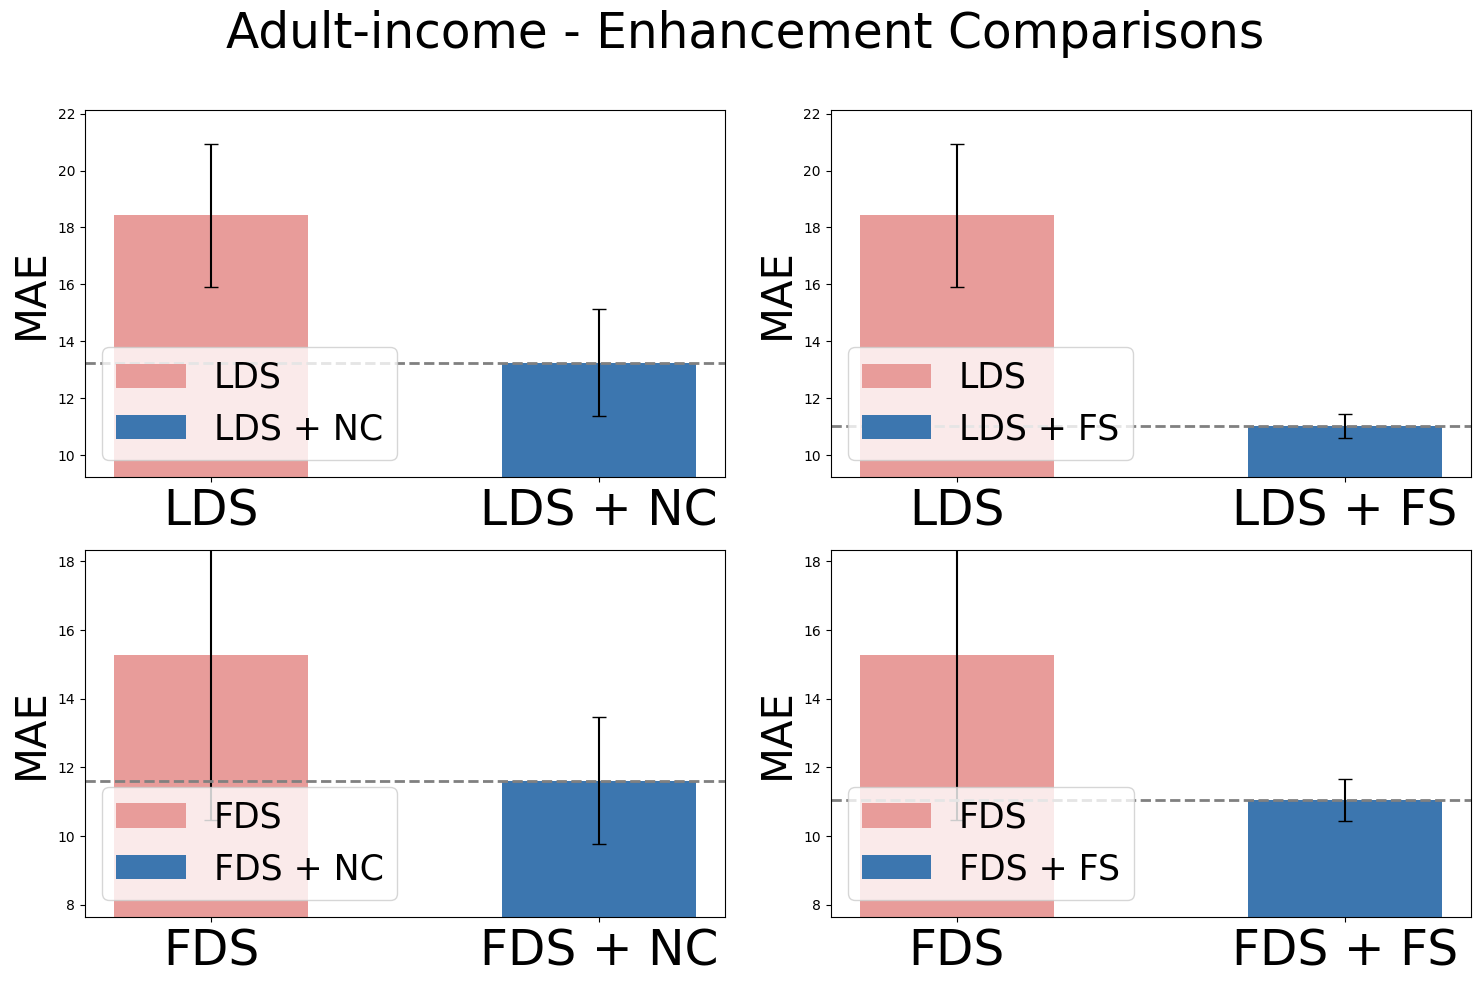

In [358]:
def main():
    iterations = 5
    results = []

    for iteration in range(iterations):
        X, y = df.drop([actual_col], axis=1).dropna().reset_index(drop=True).values, df[actual_col].dropna().reset_index(drop=True).values
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        input_features = X_train.shape[1]

        # Scenario 1: Original Dataset
        models_original = train_models(X_train, y_train)
        evaluations_original = evaluate_models(models_original, X_test, y_test)
        print(f"evaluations_original: {evaluations_original}")  # Debugging print statement
        if not isinstance(evaluations_original, dict):
            print(f"Error: evaluations_original is not a dictionary")
            continue
        
        # Scenario 4: LDS (Label Distribution Smoothing)
        X, y = df1.drop([actual_col, target_col, 'high_range', 'low_range'], axis=1).dropna().reset_index(drop=True).values, df1[actual_col].dropna().reset_index(drop=True).values
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        train_weights = prepare_weights(labels=y_train.astype(int), reweight=None, max_target=int(max(y_train)))
        test_weights = prepare_weights(labels=y_test.astype(int), reweight=None, max_target=int(max(y_test)))
        models_lds = train_models(X_train, y_train, lds=True, weights=train_weights)
        evaluations_lds = evaluate_models(models_lds, X_test, y_test, lds=True, weights=test_weights)
        print(f"evaluations_lds: {evaluations_lds}")  # Debugging print statement
        if not isinstance(evaluations_lds, dict):
            print(f"Error: evaluations_lds is not a dictionary")
            continue

        # Scenario 7: FDS (Feature Distribution Smoothing)
        X, y = df1.drop([actual_col, target_col, 'low_range', 'high_range'], axis=1).dropna().reset_index(drop=True).values, df1[actual_col].dropna().reset_index(drop=True).values
        X_train_fds, X_test_fds, y_train_fds, y_test_fds = train_test_split(X, y, test_size=0.3, random_state=42)
        models_fds = train_models(X_train_fds, y_train_fds, fds=True)
        evaluations_fds = evaluate_models(models_fds, X_test_fds, y_test_fds)
        print(f"evaluations_fds: {evaluations_fds}")  # Debugging print statement
        if not isinstance(evaluations_fds, dict):
            print(f"Error: evaluations_fds is not a dictionary")
            continue

        # Scenario 2: NC+LDS
        final_df_nc_raking = pd.read_csv('/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/adultincome_final_df_nc_raking.csv')
        X_train_nc, X_test_nc, y_train_nc, y_test_nc = custom_train_test_split(final_df_nc_raking, df, actual_col, test_size=0.3, random_state=42)
        train_weights = prepare_weights(labels=y_train_nc.astype(int), reweight=None, max_target=int(max(y_train_nc)))
        test_weights = prepare_weights(labels=y_test_nc.astype(int), reweight=None, max_target=int(max(y_test_nc)))
        models_nc_lds = train_models(X_train_nc, y_train_nc, lds=True, weights=train_weights)
        evaluations_nc_lds = evaluate_models(models_nc_lds, X_test_nc, y_test_nc, lds=True, weights=test_weights)
        print(f"evaluations_nc_lds: {evaluations_nc_lds}")  # Debugging print statement
        if not isinstance(evaluations_nc_lds, dict):
            print(f"Error: evaluations_nc_lds is not a dictionary")
            continue

        # Scenario 3: NC+FDS
        X_train_nc, X_test_nc, y_train_nc, y_test_nc = custom_train_test_split(final_df_nc_raking, df, actual_col, test_size=0.3, random_state=42)
        models_nc_fds = train_models(X_train_nc, y_train_nc, fds=True)
        evaluations_nc_fds = evaluate_models(models_nc_fds, X_test_nc, y_test_nc)
        print(f"evaluations_nc_fds: {evaluations_nc_fds}")  # Debugging print statement
        if not isinstance(evaluations_nc_fds, dict):
            print(f"Error: evaluations_nc_fds is not a dictionary")
            continue

        # Scenario 4: FS+LDS
        final_df_sn_raking = pd.read_csv('/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/adultincome_final_df_sn_raking.csv')
        X_train_sn_raking, X_test_sn_raking, y_train_sn_raking, y_test_sn_raking = custom_train_test_split(final_df_sn_raking, df, actual_col, test_size=0.3, random_state=42)
        train_weights = prepare_weights(labels=y_train_sn_raking.astype(int), reweight=None, max_target=int(max(y_train_sn_raking)))
        test_weights = prepare_weights(labels=y_test_sn_raking.astype(int), reweight=None, max_target=int(max(y_test_sn_raking)))
        models_fs_lds = train_models(X_train_sn_raking, y_train_sn_raking, lds=True, weights=train_weights)
        evaluations_fs_lds = evaluate_models(models_fs_lds, X_test_sn_raking, y_test_sn_raking, lds=True, weights=test_weights)
        print(f"evaluations_fs_lds: {evaluations_fs_lds}")  # Debugging print statement
        if not isinstance(evaluations_fs_lds, dict):
            print(f"Error: evaluations_fs_lds is not a dictionary")
            continue

        # Scenario 5: FS+FDS
        X_train_sn_raking, X_test_sn_raking, y_train_sn_raking, y_test_sn_raking = custom_train_test_split(final_df_sn_raking, df, actual_col, test_size=0.3, random_state=42)
        models_fs_fds = train_models(X_train_sn_raking, y_train_sn_raking, fds=True)
        evaluations_fs_fds = evaluate_models(models_fs_fds, X_test_sn_raking, y_test_sn_raking)
        print(f"evaluations_fs_fds: {evaluations_fs_fds}")  # Debugging print statement
        if not isinstance(evaluations_fs_fds, dict):
            print(f"Error: evaluations_fs_fds is not a dictionary")
            continue

        # Save all the results for the current iteration
        evaluations_dict = {
            'LDS': evaluations_lds,
            'nc_lds': evaluations_nc_lds,
            'fs_lds': evaluations_fs_lds,
            'FDS': evaluations_fds,
            'nc_fds': evaluations_nc_fds,
            'fs_fds': evaluations_fs_fds
        }

        for key, evaluations in evaluations_dict.items():
            average_metrics = calculate_averages2(evaluations, is_ranksim=False, select_best=False)
            if not isinstance(average_metrics, dict):
                print(f"Error: average_metrics for {key} is not a dictionary")
                continue
            for metric, value in average_metrics.items():
                result = {'iteration': iteration, 'scenario': key, 'metric': metric, 'value': value}
                print(f"Appending result: {result}")  # Debugging print statement
                results.append(result)
                    
    # Convert results to DataFrame and save
    results_df = pd.DataFrame(results)
    print(f"Results DataFrame:\n{results_df}")  # Debugging print statement

    # Calculate averages for each sampling method
    average_dict = {}
    std_dict = {}
    for key, group in results_df.groupby('scenario'):
        group_metrics = group.pivot_table(values='value', index='iteration', columns='metric').mean().to_dict()
        average_metrics = {metric: group_metrics.get('MAE', float('nan')) for metric in ['MAE']}
        std_metrics = {metric: group.pivot_table(values='value', index='iteration', columns='metric').std().to_dict().get('MAE', float('nan')) for metric in ['MAE']}
        average_dict[key] = average_metrics
        std_dict[key] = std_metrics

    # Plot comparisons
    plot_enhancement_comparisons(average_dict, std_dict, dataset_name='Adult-income', save_path_prefix='/home/Imbalanced_Regression/Results/Enhancement')

if __name__ == "__main__":
    main()


### 6 - Run kdd-coil-1

#### 8-1 - main training

In [373]:
class KddDataset(Dataset):
    def __init__(self, features, targets, weights, lds=False):
        self.features = features
        self.targets = targets
        self.weights = weights
        self.lds = lds

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
          feature = self.features[idx]
          target = self.targets[idx]
          weight = self.weights[idx]
          return feature, target, weight

Metrics for mlp: RMSE=15.61, MAE=11.50, MSE=243.58, G-mean=8.71
original dataset: {'mlp': {'RMSE': 15.606947374943637, 'MAE': 11.49930342661707, 'MSE': 243.57680636426008, 'G-mean': 8.711503106022098}}
Metrics for mlp: RMSE=14.23, MAE=10.95, MSE=202.38, G-mean=8.79
Nearest Cell dataset: {'mlp': {'RMSE': 14.225926, 'MAE': 10.950478, 'MSE': 202.37697, 'G-mean': 8.788144}}
Metrics for mlp: RMSE=15.40, MAE=12.29, MSE=237.12, G-mean=9.86
Features Similarity dataset: {'mlp': {'RMSE': 15.3986635, 'MAE': 12.289607, 'MSE': 237.11884, 'G-mean': 9.861794}}
Using LDS: [GAUSSIAN] (5/2)
Using LDS: [GAUSSIAN] (5/2)
Metrics for mlp: RMSE=31.99, MAE=27.45, MSE=1023.19, G-mean=23.09
LDS dataset: {'mlp': {'RMSE': 31.98733257374048, 'MAE': 27.453499250913918, 'MSE': 1023.1894451830788, 'G-mean': 23.089993306852158}}
Using LDS: [GAUSSIAN] (5/2)
Using LDS: [GAUSSIAN] (5/2)
Metrics for mlp: RMSE=22.29, MAE=18.22, MSE=497.04, G-mean=14.16
NC + LDS dataset: {'mlp': {'RMSE': 22.294332690009554, 'MAE': 18.216137

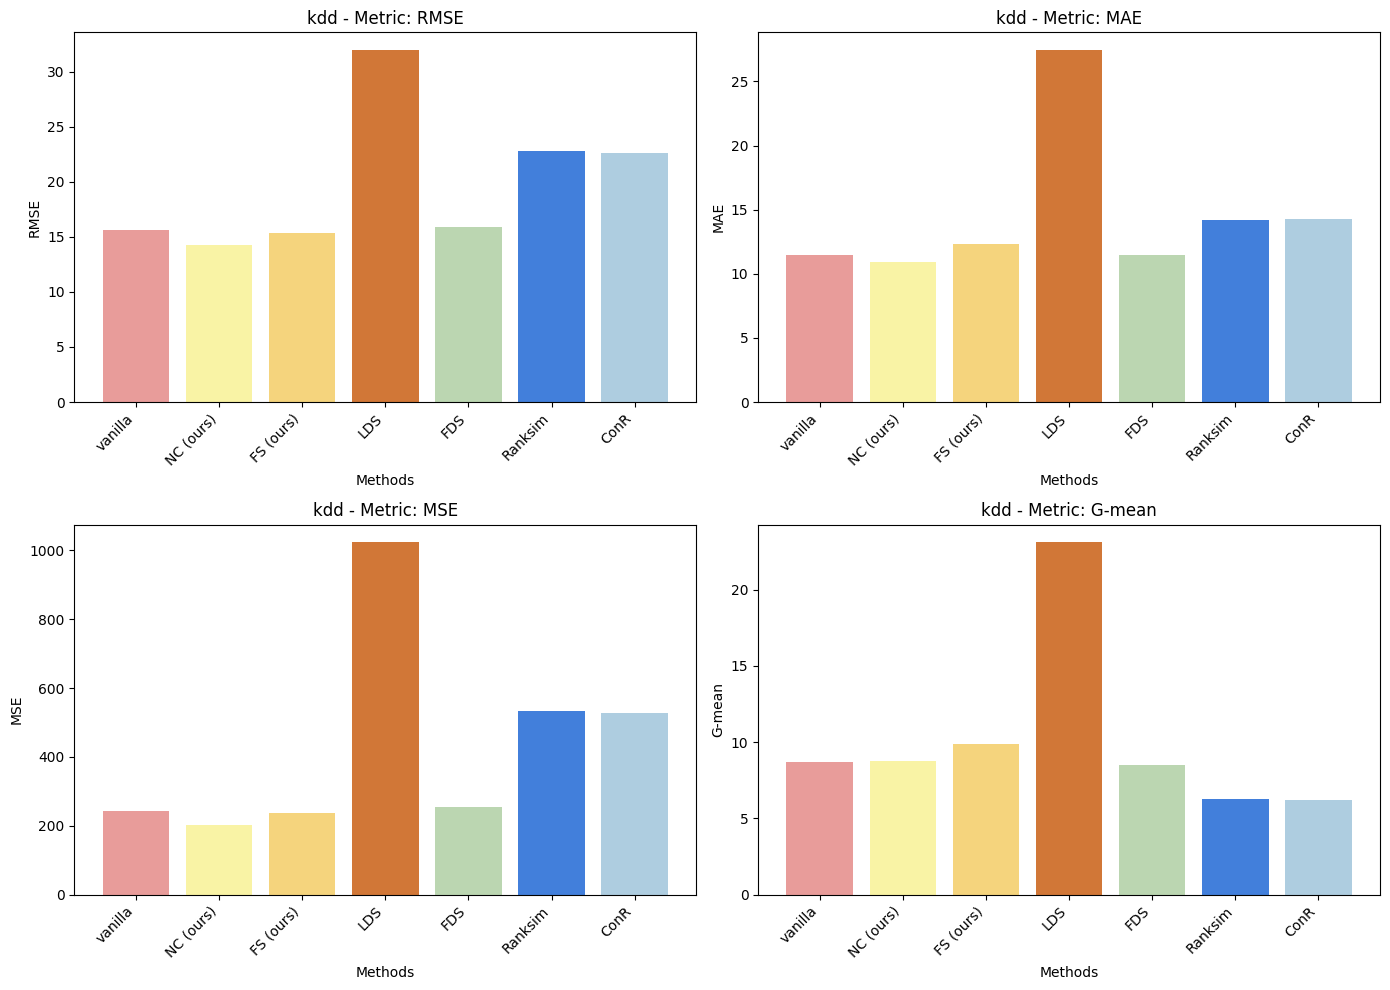

In [364]:
def main():

    X, y = df.drop([actual_col], axis=1).dropna().reset_index(drop=True).values, df[actual_col].dropna().reset_index(drop=True).values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    # Correct model instantiation
    input_features = X_train.shape[1]


    # Scenario 1: Original Dataset
    models_original = train_models(X_train, y_train)
    evaluations_original = evaluate_models(models_original, X_test, y_test)
    print("original dataset:", evaluations_original)

    # Scenario 2: Samples of nearest cells: Calibration Method
    final_df_nc_raking = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/kdd_final_df_nc_raking.csv")
    X_train_nc, X_test_nc, y_train_nc, y_test_nc = custom_train_test_split(final_df_nc_raking, df, actual_col, test_size=0.3, random_state=42)
    y_combined = np.concatenate([y_train_nc, y_test_nc]) # for plotting
    models_nc = train_models(X_train_nc, y_train_nc)
    evaluations_nc_raking = evaluate_models(models_nc, X_test_nc, y_test_nc)
    print("Nearest Cell dataset:", evaluations_nc_raking)

    # Scenario 3: Samples of Features Similarity: Calibration Method
    final_df_fs_raking = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/kdd_final_df_sn_raking.csv")
    X_train_fs_raking, X_test_fs_raking, y_train_fs_raking, y_test_fs_raking = custom_train_test_split(final_df_fs_raking, df, actual_col, test_size=0.3, random_state=42)
    y_combined = np.concatenate([y_train_fs_raking, y_test_fs_raking]) # for plotting
    models_fs_raking = train_models(X_train_fs_raking, y_train_fs_raking)
    evaluations_fs_raking = evaluate_models(models_fs_raking, X_test_fs_raking, y_test_fs_raking)
    print("Features Similarity dataset:", evaluations_fs_raking)
    
    # Scenario 4: LDS (Label Distribution Smoothing)
    X, y = df1.drop([actual_col, target_col, 'high_range', 'low_range'], axis=1).dropna().reset_index(drop=True).values, df1[actual_col].dropna().reset_index(drop=True).values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    train_weights = prepare_weights(labels=y_train.astype(int), reweight=None, max_target=int(max(y_train)))
    test_weights = prepare_weights(labels=y_test.astype(int), reweight=None, max_target=int(max(y_test)))
    models_lds = train_models(X_train, y_train, lds=True, weights=train_weights)
    evaluations_lds = evaluate_models(models_lds, X_test, y_test, lds=True, weights=test_weights)
    print("LDS dataset:", evaluations_lds)

    # Scenario 4: NC + LDS (Label Distribution Smoothing)
    df_nc = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/kdd_final_df_nc_raking.csv")
    X, y = df_nc.drop([actual_col], axis=1).dropna().reset_index(drop=True).values, df_nc[actual_col].dropna().reset_index(drop=True).values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    train_weights = prepare_weights(labels=y_train.astype(int), reweight=None, max_target=int(max(y_train)))
    test_weights = prepare_weights(labels=y_test.astype(int), reweight=None, max_target=int(max(y_test)))
    models_nc_lds = train_models(X_train, y_train, lds=True, weights=train_weights)
    evaluations_nc_lds = evaluate_models(models_nc_lds, X_test, y_test, lds=True, weights=test_weights)
    print("NC + LDS dataset:", evaluations_nc_lds)

    # Scenario 4: FS + LDS (Label Distribution Smoothing)
    df_fs = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/kdd_final_df_sn_raking.csv")
    X, y = df_fs.drop([actual_col], axis=1).dropna().reset_index(drop=True).values, df_fs[actual_col].dropna().reset_index(drop=True).values  
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    train_weights = prepare_weights(labels=y_train.astype(int), reweight=None, max_target=int(max(y_train)))
    test_weights = prepare_weights(labels=y_test.astype(int), reweight=None, max_target=int(max(y_test)))
    models_fs_lds = train_models(X_train, y_train, lds=True, weights=train_weights)
    evaluations_fs_lds = evaluate_models(models_fs_lds, X_test, y_test, lds=True, weights=test_weights)
    print("FS + LDS dataset:", evaluations_fs_lds)

    # Scenario 5: FDS (Feature Distribution Smoothing)
    X, y = df1.drop([actual_col, target_col, 'high_range', 'low_range'], axis=1).dropna().reset_index(drop=True).values, df1[actual_col].dropna().reset_index(drop=True).values
    X_train_fds, X_test_fds, y_train_fds, y_test_fds = train_test_split(X, y, test_size=0.3, random_state=42)
    models_fds = train_models(X_train_fds, y_train_fds, fds=True)
    evaluations_fds = evaluate_models(models_fds, X_test_fds, y_test_fds)
    print("FDS dataset:", evaluations_fds)

    # Scenario 5: NC + FDS (Feature Distribution Smoothing)
    df_nc = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/kdd_final_df_nc_raking.csv")
    X, y = df_nc.drop([actual_col], axis=1).dropna().reset_index(drop=True).values, df_nc[actual_col].dropna().reset_index(drop=True).values
    X_train_fds, X_test_fds, y_train_fds, y_test_fds = train_test_split(X, y, test_size=0.3, random_state=42)
    models_nc_fds = train_models(X_train_fds, y_train_fds, fds=True)
    evaluations_nc_fds = evaluate_models(models_nc_fds, X_test_fds, y_test_fds)
    print("NC + FDS dataset:", evaluations_nc_fds)

    # Scenario 5: FS + FDS (Feature Distribution Smoothing)
    df_fs = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/kdd_final_df_sn_raking.csv")
    X, y = df_fs.drop([actual_col], axis=1).dropna().reset_index(drop=True).values, df_fs[actual_col].dropna().reset_index(drop=True).values
    X_train_fds, X_test_fds, y_train_fds, y_test_fds = train_test_split(X, y, test_size=0.3, random_state=42)
    models_fs_fds = train_models(X_train_fds, y_train_fds, fds=True)
    evaluations_fs_fds = evaluate_models(models_fs_fds, X_test_fds, y_test_fds)
    print("FS + FDS dataset:", evaluations_fs_fds)

    # Scenario 6: LDS + FDS
    X, y = df1.drop([actual_col, target_col, 'high_range', 'low_range'], axis=1).dropna().reset_index(drop=True).values, df1[actual_col].dropna().reset_index(drop=True).values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    train_weights = prepare_weights(labels=y_train.astype(int), reweight=None, max_target=int(max(y_train)))
    test_weights = prepare_weights(labels=y_test.astype(int), reweight=None, max_target=int(max(y_test)))
    models_lds_fds = train_models(X_train, y_train, lds=True, fds=True, weights=train_weights)
    evaluations_lds_fds = evaluate_models(models_lds_fds, X_test, y_test, lds=True, weights=test_weights)
    print("LDS + FDS dataset:", evaluations_lds_fds)

    # Scenario 6: NC + LDS + FDS
    df_nc = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/kdd_final_df_nc_raking.csv")
    X, y = df_nc.drop([actual_col], axis=1).dropna().reset_index(drop=True).values, df_nc[actual_col].dropna().reset_index(drop=True).values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    train_weights = prepare_weights(labels=y_train.astype(int), reweight=None, max_target=int(max(y_train)))
    test_weights = prepare_weights(labels=y_test.astype(int), reweight=None, max_target=int(max(y_test)))
    models_nc_lds_fds = train_models(X_train, y_train, lds=True, fds=True, weights=train_weights)
    evaluations_nc_lds_fds = evaluate_models(models_nc_lds_fds, X_test, y_test, lds=True, weights=test_weights)
    print("NC + LDS + FDS dataset:", evaluations_nc_lds_fds)

    # Scenario 6: FS + LDS + FDS
    df_fs = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/kdd_final_df_sn_raking.csv")
    X, y = df_fs.drop([actual_col], axis=1).dropna().reset_index(drop=True).values, df_fs[actual_col].dropna().reset_index(drop=True).values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    train_weights = prepare_weights(labels=y_train.astype(int), reweight=None, max_target=int(max(y_train)))
    test_weights = prepare_weights(labels=y_test.astype(int), reweight=None, max_target=int(max(y_test)))
    models_fs_lds_fds = train_models(X_train, y_train, lds=True, fds=True, weights=train_weights)
    evaluations_fs_lds_fds = evaluate_models(models_fs_lds_fds, X_test, y_test, lds=True, weights=test_weights)
    print("FS + LDS + FDS dataset:", evaluations_fs_lds_fds)

    # Scenario 7: Ranksim
    ranksim_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_kdd_regression_model.pth'
    reg_model.load_state_dict(torch.load(ranksim_path))
    _, val_indices = train_test_split(np.arange(len(df)), test_size=0.3, random_state=42)
    X_orig = df.drop([actual_col], axis=1).dropna().reset_index(drop=True).values
    y_orig = df[actual_col].dropna().reset_index(drop=True).values
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = KddDataset(X_orig[val_indices], y_orig[val_indices], weights=val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_ranksim = validate_ranksim(val_loader, reg_model, lds=False, train_labels=None, prefix='Val')
    print("Ranksim dataset:", evaluations_ranksim)

    # Scenario 7: NC + Ranksim
    ranksim_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_kdd_nc_regression_model.pth'
    reg_model.load_state_dict(torch.load(ranksim_path))
    _, val_indices = train_test_split(np.arange(len(df)), test_size=0.3, random_state=42)
    X_orig = df.drop([actual_col], axis=1).dropna().reset_index(drop=True).values
    y_orig = df[actual_col].dropna().reset_index(drop=True).values
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = KddDataset(X_orig[val_indices], y_orig[val_indices], weights=val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_nc_ranksim = validate_ranksim(val_loader, reg_model, lds=False, train_labels=None, prefix='Val')
    print("NC + Ranksim dataset:", evaluations_nc_ranksim)

    # Scenario 7: NC + Ranksim
    ranksim_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_kdd_fs_regression_model.pth'
    reg_model.load_state_dict(torch.load(ranksim_path))
    _, val_indices = train_test_split(np.arange(len(df)), test_size=0.3, random_state=42)
    X_orig = df.drop([actual_col], axis=1).dropna().reset_index(drop=True).values
    y_orig = df[actual_col].dropna().reset_index(drop=True).values
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = KddDataset(X_orig[val_indices], y_orig[val_indices], weights=val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_fs_ranksim = validate_ranksim(val_loader, reg_model, lds=False, train_labels=None, prefix='Val')
    print("FS + Ranksim dataset:", evaluations_fs_ranksim)

    # Scenario 8: Ranksim + LDS Validation
    ranksim_lds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_kdd_regression_model_with_LDS.pth'
    reg_model.load_state_dict(torch.load(ranksim_lds_path))
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = KddDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_ranksim_lds = validate_ranksim(val_loader, reg_model, lds=True, train_labels=None, prefix='Val')
    print("Ranksim + LDS dataset:", evaluations_ranksim_lds)

    # Scenario 8: NC + Ranksim + LDS Validation
    ranksim_lds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_kdd_nc_regression_model_with_LDS.pth'
    reg_model.load_state_dict(torch.load(ranksim_lds_path))
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = KddDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_nc_ranksim_lds = validate_ranksim(val_loader, reg_model, lds=True, train_labels=None, prefix='Val')
    print("NC + Ranksim + LDS dataset:", evaluations_nc_ranksim_lds)

    # Scenario 8: FS + Ranksim + LDS Validation
    ranksim_lds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_kdd_fs_regression_model_with_LDS.pth'
    reg_model.load_state_dict(torch.load(ranksim_lds_path))
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = KddDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_fs_ranksim_lds = validate_ranksim(val_loader, reg_model, lds=True, train_labels=None, prefix='Val')
    print("FS+ Ranksim + LDS dataset:", evaluations_fs_ranksim_lds)

    # Scenario 9: Ranksim + FDS Validation
    ranksim_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_kdd_regression_model_with_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(ranksim_fds_path))
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = KddDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_ranksim_fds = validate_ranksim(val_loader, reg_model_fds, lds=False, train_labels=None, prefix='Val')
    print("Ranksim + FDS dataset:", evaluations_ranksim_fds)

    # Scenario 9: NC + Ranksim + FDS Validation
    ranksim_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_kdd_nc_regression_model_with_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(ranksim_fds_path))
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = KddDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_nc_ranksim_fds = validate_ranksim(val_loader, reg_model_fds, lds=False, train_labels=None, prefix='Val')
    print("NC + Ranksim + FDS dataset:", evaluations_nc_ranksim_fds)

    # Scenario 9: FS + Ranksim + FDS Validation
    ranksim_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_kdd_fs_regression_model_with_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(ranksim_fds_path))
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = KddDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_fs_ranksim_fds = validate_ranksim(val_loader, reg_model_fds, lds=False, train_labels=None, prefix='Val')
    print("FS + Ranksim + FDS dataset:", evaluations_fs_ranksim_fds)
    
    # Scenario 10: Ranksim+ LDS + FDS Validation
    ranksim_lds_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_kdd_regression_model_with_LDS_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(ranksim_lds_fds_path))
    # Split dataset into training and validation sets
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = KddDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_ranksim_lds_fds = validate_ranksim(val_loader, reg_model_fds, lds=True, train_labels=None, prefix='Val')
    print("Ranksim + LDS + FDS dataset:", evaluations_ranksim_lds_fds)

    # Scenario 10: NC + Ranksim + LDS + FDS Validation
    ranksim_lds_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_kdd_nc_regression_model_with_LDS_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(ranksim_lds_fds_path))
    # Split dataset into training and validation sets
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = KddDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_nc_ranksim_lds_fds = validate_ranksim(val_loader, reg_model_fds, lds=True, train_labels=None, prefix='Val')
    print("NC + Ranksim + LDS + FDS dataset:", evaluations_nc_ranksim_lds_fds)

    # Scenario 10: FS + Ranksim + LDS + FDS Validation
    ranksim_lds_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_kdd_fs_regression_model_with_LDS_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(ranksim_lds_fds_path))
    # Split dataset into training and validation sets
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = KddDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_fs_ranksim_lds_fds = validate_ranksim(val_loader, reg_model_fds, lds=True, train_labels=None, prefix='Val')
    print("FS + Ranksim + LDS + FDS dataset:", evaluations_fs_ranksim_lds_fds)

    # Scenario 11: ConR
    conr_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_kdd_regression_model_ConR.pth'
    reg_model.load_state_dict(torch.load(conr_path))
    _, val_indices = train_test_split(np.arange(len(df)), test_size=0.3, random_state=42)
    X_orig = df.drop([actual_col], axis=1).dropna().reset_index(drop=True).values
    y_orig = df[actual_col].dropna().reset_index(drop=True).values
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = KddDataset(X_orig[val_indices], y_orig[val_indices], weights=val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_conr = validate_ranksim(val_loader, reg_model, lds=False, train_labels=None, prefix='Val')
    print("ConR dataset:", evaluations_conr)

    # Scenario 11: NC + ConR
    conr_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_kdd_nc_regression_model_ConR.pth'
    reg_model.load_state_dict(torch.load(conr_path))
    _, val_indices = train_test_split(np.arange(len(df)), test_size=0.3, random_state=42)
    X_orig = df.drop([actual_col], axis=1).dropna().reset_index(drop=True).values
    y_orig = df[actual_col].dropna().reset_index(drop=True).values
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = KddDataset(X_orig[val_indices], y_orig[val_indices], weights=val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_nc_conr = validate_ranksim(val_loader, reg_model, lds=False, train_labels=None, prefix='Val')
    print("NC + ConR dataset:", evaluations_nc_conr)
    
    # Scenario 11: FS + ConR
    conr_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_kdd_fs_regression_model_ConR.pth'
    reg_model.load_state_dict(torch.load(conr_path))
    _, val_indices = train_test_split(np.arange(len(df)), test_size=0.3, random_state=42)
    X_orig = df.drop([actual_col], axis=1).dropna().reset_index(drop=True).values
    y_orig = df[actual_col].dropna().reset_index(drop=True).values
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = KddDataset(X_orig[val_indices], y_orig[val_indices], weights=val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_fs_conr = validate_ranksim(val_loader, reg_model, lds=False, train_labels=None, prefix='Val')
    print("FS + ConR dataset:", evaluations_fs_conr)
            
    # Scenario 12: ConR + LDS Validation
    conr_lds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_kdd_regression_model_ConR_with_LDS.pth'
    reg_model.load_state_dict(torch.load(conr_lds_path))
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = KddDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_conr_lds = validate_ranksim(val_loader, reg_model, lds=True, train_labels=None, prefix='Val')
    print("ConR + LDS dataset:", evaluations_conr_lds)

    # Scenario 12: NC + ConR + LDS Validation
    conr_lds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_kdd_nc_regression_model_ConR_with_LDS.pth'
    reg_model.load_state_dict(torch.load(conr_lds_path))
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = KddDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_nc_conr_lds = validate_ranksim(val_loader, reg_model, lds=True, train_labels=None, prefix='Val')
    print("NC + ConR + LDS dataset:", evaluations_nc_conr_lds)

    # Scenario 12: FS + ConR + LDS Validation
    conr_lds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_kdd_fs_regression_model_ConR_with_LDS.pth'
    reg_model.load_state_dict(torch.load(conr_lds_path))
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = KddDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_fs_conr_lds = validate_ranksim(val_loader, reg_model, lds=True, train_labels=None, prefix='Val')
    print("FS + ConR + LDS dataset:", evaluations_fs_conr_lds)

    # Scenario 13: ConR + FDS Validation
    conr_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_kdd_regression_model_ConR_with_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(conr_fds_path))
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = KddDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_conr_fds = validate_ranksim(val_loader, reg_model_fds, lds=False, train_labels=None, prefix='Val')
    print("ConR + FDS dataset:", evaluations_conr_fds)

    # Scenario 13: NC + ConR + FDS Validation
    conr_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_kdd_nc_regression_model_ConR_with_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(conr_fds_path))
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = KddDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_nc_conr_fds = validate_ranksim(val_loader, reg_model_fds, lds=False, train_labels=None, prefix='Val')
    print("NC + ConR + FDS dataset:", evaluations_nc_conr_fds)

    # Scenario 13: FS + ConR + FDS Validation
    conr_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_kdd_nc_regression_model_ConR_with_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(conr_fds_path))
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = KddDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_fs_conr_fds = validate_ranksim(val_loader, reg_model_fds, lds=False, train_labels=None, prefix='Val')
    print("FS + ConR + FDS dataset:", evaluations_fs_conr_fds)
    
    # Scenario 14: ConR + LDS + FDS Validation
    conr_lds_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_kdd_regression_model_ConR_with_LDS_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(conr_lds_fds_path))
    # Split dataset into training and validation sets
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = KddDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_conr_lds_fds = validate_ranksim(val_loader, reg_model_fds, lds=True, train_labels=None, prefix='Val')
    print("Ranksim + LDS + FDS dataset:", evaluations_conr_lds_fds)

    # Scenario 14: NC + ConR + LDS + FDS Validation
    conr_lds_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_kdd_nc_regression_model_ConR_with_LDS_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(conr_lds_fds_path))
    # Split dataset into training and validation sets
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = KddDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_nc_conr_lds_fds = validate_ranksim(val_loader, reg_model_fds, lds=True, train_labels=None, prefix='Val')
    print("NC + Ranksim + LDS + FDS dataset:", evaluations_nc_conr_lds_fds)

    # Scenario 14: FS + ConR + LDS + FDS Validation
    conr_lds_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_kdd_fs_regression_model_ConR_with_LDS_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(conr_lds_fds_path))
    # Split dataset into training and validation sets
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = KddDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_fs_conr_lds_fds = validate_ranksim(val_loader, reg_model_fds, lds=True, train_labels=None, prefix='Val')
    print("FS + Ranksim + LDS + FDS dataset:", evaluations_fs_conr_lds_fds)

    # Calculate averages for each sampling method
    evaluations_dict = {
        'vanilla': evaluations_original,
        'NC (ours)': evaluations_nc_raking,
        'FS (ours)': evaluations_fs_raking,
        'LDS': evaluations_lds,
        'NC + LDS': evaluations_nc_lds,
        'FS + LDS': evaluations_fs_lds,
        'FDS': evaluations_fds,
        'NC + FDS': evaluations_nc_fds,
        'FS + FDS': evaluations_fs_fds,
        'LDS + FDS': evaluations_lds_fds,
        'NC + LDS + FDS': evaluations_nc_lds_fds,
        'FS + LDS + FDS': evaluations_nc_lds_fds,
        'Ranksim': evaluations_ranksim,
        'NC + Ranksim': evaluations_nc_ranksim,
        'FS + Ranksim': evaluations_fs_ranksim,
        'Ranksim + LDS': evaluations_ranksim_lds, 
        'NC + Ranksim + LDS': evaluations_nc_ranksim_lds, 
        'FS + Ranksim + LDS': evaluations_fs_ranksim_lds, 
        'Ranksim + FDS': evaluations_ranksim_fds,
        'NC + Ranksim + FDS': evaluations_nc_ranksim_fds,
        'FS + Ranksim + FDS': evaluations_fs_ranksim_fds,
        'Ranksim + LDS + FDS': evaluations_ranksim_lds_fds,  
        'NC + Ranksim + LDS + FDS': evaluations_nc_ranksim_lds_fds, 
        'FS + Ranksim + LDS + FDS': evaluations_fs_ranksim_lds_fds, 
        'ConR': evaluations_conr,
        'NC + ConR': evaluations_nc_conr,
        'FS + ConR': evaluations_fs_conr,
        "ConR + LDS": evaluations_conr_lds,
        "NC + ConR + LDS": evaluations_nc_conr_lds,
        "FS + ConR + LDS": evaluations_fs_conr_lds,
        "ConR + FDS": evaluations_conr_fds,
        "NC + ConR + FDS": evaluations_nc_conr_fds,
        "FS + ConR + FDS": evaluations_fs_conr_fds,
        "ConR + LDS + FDS": evaluations_conr_lds_fds,
        "NC + ConR + LDS + FDS": evaluations_nc_conr_lds_fds,
        "FS + ConR + LDS + FDS": evaluations_fs_conr_lds_fds
    }

    average_dict = {}
    for key, evaluations in evaluations_dict.items():
        average_dict[key] = calculate_averages(evaluations, is_ranksim=(key in ['Ranksim', 'ConR','Ranksim + LDS','Ranksim + FDS','Ranksim + LDS + FDS',
                                                                                "ConR + LDS","ConR + FDS","ConR + LDS + FDS", 'NC + Ranksim', 'FS + Ranksim', 
                                                                                'NC + Ranksim + LDS', 'FS + Ranksim + LDS', 'NC + Ranksim + FDS', 'FS + Ranksim + FDS', 
                                                                                'NC + Ranksim + LDS + FDS', 'FS + Ranksim + LDS + FDS', 'NC + ConR', 'FS + ConR', 
                                                                                "NC + ConR + LDS", "FS + ConR + LDS", "NC + ConR + FDS", "FS + ConR + FDS", 
                                                                                "NC + ConR + LDS + FDS", "FS + ConR + LDS + FDS"]), 
                                               select_best=False) #(key in ['NC_calibration', 'FS_calibration'])

     # Transform the dictionaries to match the expected structure for plotting
    average_dict_transformed = {method: {metric: average_dict[method][metric] for metric in ['RMSE', 'MAE', 'MSE', 'G-mean']} for method in evaluations_dict.keys()}

    # Create DataFrames for the averages
    average_df = pd.DataFrame(average_dict_transformed).T
    print(average_df)

    # Plot average comparisons
    methods = ['vanilla', 'NC (ours)', 'FS (ours)', 'LDS', 'FDS', 'Ranksim','ConR']
    plot_average_comparisons(average_dict, methods, dataset_name='kdd',
                             save_path='/home/Imbalanced_Regression/Results/kdd_average_comparisons.png')
    
    # plot_distribution_comparison(y, y_combined, K, dataset_name='Boston', 
    #                              save_path='/home/Imbalanced_Regression/Results/Boston_dist_comparisons.png')
    
    # Export the DataFrame to a CSV file
    average_df.to_csv(f'/home/Imbalanced_Regression/Results/kdd_K_{K}_mj_{mj}_average_evaluations.csv')
    # save_combined_evaluations_to_csv(evaluations_dict, f'/home/Imbalanced_Regression/Results/kdd_K_{K}_mj_{mj}_combined_evaluations.csv')
    # files.download(f'Boston_K_{K}_mj_{mj}_average_evaluations.csv')


    # download the balanced dataset
    # final_df_nc_raking.to_csv('/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/Boston_final_df_nc_raking.csv', index=False)
    # final_df_sn_raking.to_csv('/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/Boston_final_df_sn_raking.csv', index=False)


if __name__ == "__main__":
    main()


#### 8-2 - iterations

Metrics for mlp: RMSE=16.23, MAE=11.88, MSE=263.41, G-mean=9.16
evaluations_original: {'mlp': {'RMSE': 16.230033232755083, 'MAE': 11.88007235756046, 'MSE': 263.4139787363344, 'G-mean': 9.163434064404623}}
Using LDS: [GAUSSIAN] (5/2)
Using LDS: [GAUSSIAN] (5/2)
Metrics for mlp: RMSE=30.60, MAE=26.24, MSE=936.31, G-mean=21.67
evaluations_lds: {'mlp': {'RMSE': 30.599229883687137, 'MAE': 26.241074751050846, 'MSE': 936.312869474732, 'G-mean': 21.66874037898147}}
Metrics for mlp: RMSE=17.66, MAE=13.06, MSE=311.99, G-mean=9.93
evaluations_fds: {'mlp': {'RMSE': 17.66335591668478, 'MAE': 13.061875759520033, 'MSE': 311.9941422394832, 'G-mean': 9.930229506853554}}
Using LDS: [GAUSSIAN] (5/2)
Using LDS: [GAUSSIAN] (5/2)
Metrics for mlp: RMSE=20.26, MAE=16.24, MSE=410.42, G-mean=12.83
evaluations_nc_lds: {'mlp': {'RMSE': 20.258762, 'MAE': 16.241728, 'MSE': 410.41748, 'G-mean': 12.826122}}
Metrics for mlp: RMSE=16.94, MAE=12.86, MSE=286.87, G-mean=9.57
evaluations_nc_fds: {'mlp': {'RMSE': 16.937119,

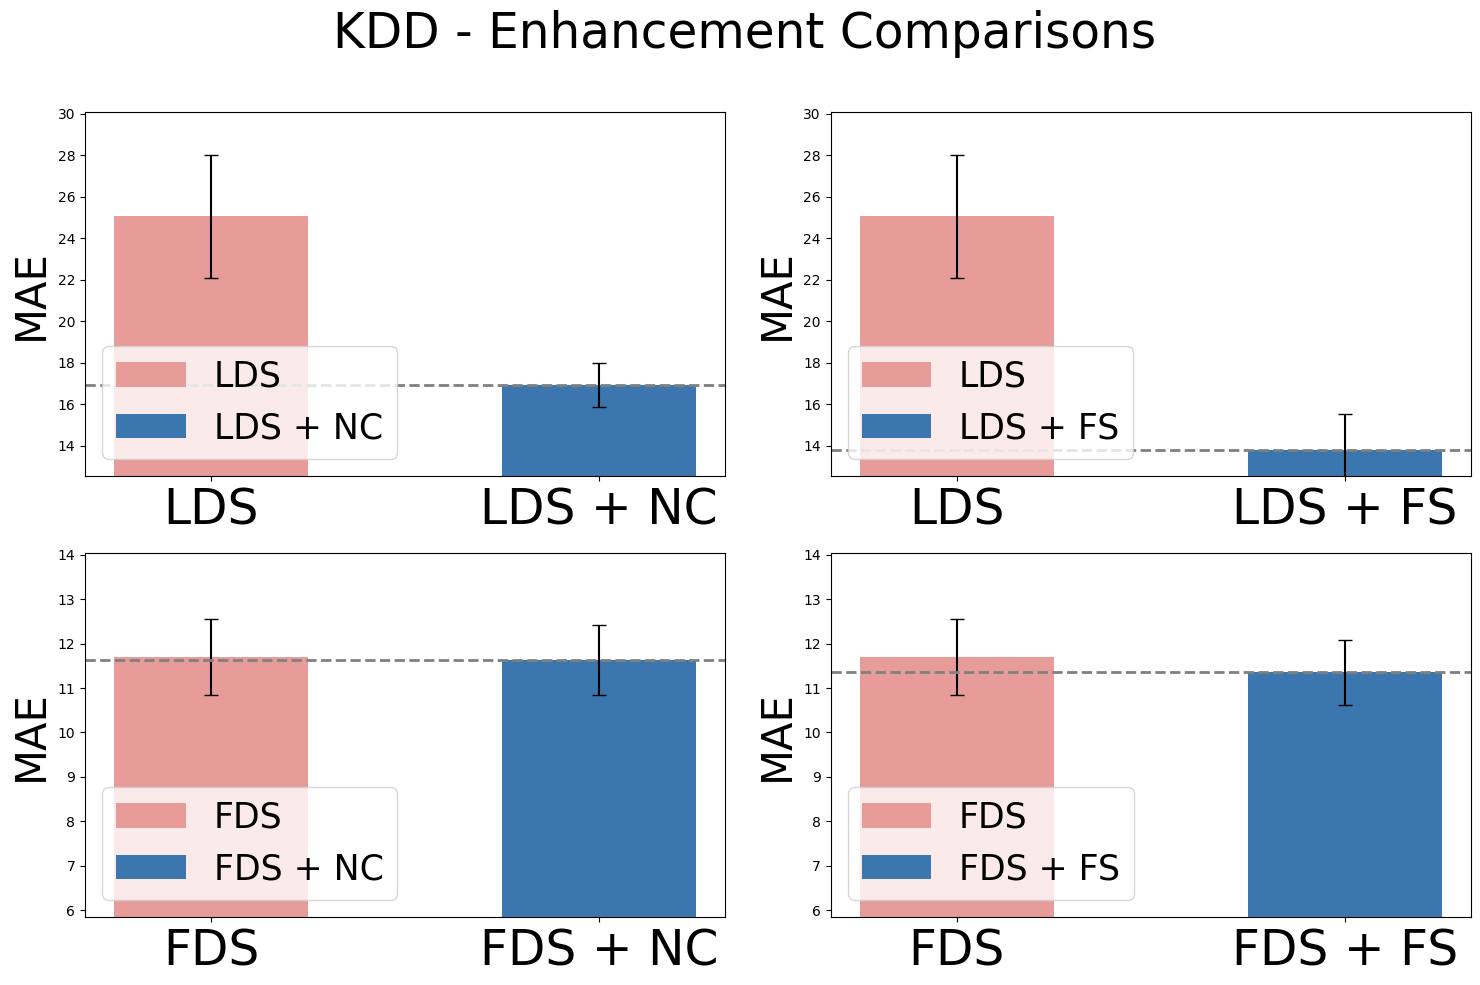

In [374]:
def main():
    iterations = 5
    results = []

    for iteration in range(iterations):
        X, y = df.drop([actual_col], axis=1).dropna().reset_index(drop=True).values, df[actual_col].dropna().reset_index(drop=True).values
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        input_features = X_train.shape[1]

        # Scenario 1: Original Dataset
        models_original = train_models(X_train, y_train)
        evaluations_original = evaluate_models(models_original, X_test, y_test)
        print(f"evaluations_original: {evaluations_original}")  # Debugging print statement
        if not isinstance(evaluations_original, dict):
            print(f"Error: evaluations_original is not a dictionary")
            continue
        
        # Scenario 4: LDS (Label Distribution Smoothing)
        X, y = df1.drop([actual_col, target_col, 'high_range', 'low_range'], axis=1).dropna().reset_index(drop=True).values, df1[actual_col].dropna().reset_index(drop=True).values
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        train_weights = prepare_weights(labels=y_train.astype(int), reweight=None, max_target=int(max(y_train)))
        test_weights = prepare_weights(labels=y_test.astype(int), reweight=None, max_target=int(max(y_test)))
        models_lds = train_models(X_train, y_train, lds=True, weights=train_weights)
        evaluations_lds = evaluate_models(models_lds, X_test, y_test, lds=True, weights=test_weights)
        print(f"evaluations_lds: {evaluations_lds}")  # Debugging print statement
        if not isinstance(evaluations_lds, dict):
            print(f"Error: evaluations_lds is not a dictionary")
            continue

        # Scenario 7: FDS (Feature Distribution Smoothing)
        X, y = df1.drop([actual_col, target_col, 'low_range', 'high_range'], axis=1).dropna().reset_index(drop=True).values, df1[actual_col].dropna().reset_index(drop=True).values
        X_train_fds, X_test_fds, y_train_fds, y_test_fds = train_test_split(X, y, test_size=0.3, random_state=42)
        models_fds = train_models(X_train_fds, y_train_fds, fds=True)
        evaluations_fds = evaluate_models(models_fds, X_test_fds, y_test_fds)
        print(f"evaluations_fds: {evaluations_fds}")  # Debugging print statement
        if not isinstance(evaluations_fds, dict):
            print(f"Error: evaluations_fds is not a dictionary")
            continue

        # Scenario 2: NC+LDS
        final_df_nc_raking = pd.read_csv('/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/kdd_final_df_nc_raking.csv')
        X_train_nc, X_test_nc, y_train_nc, y_test_nc = custom_train_test_split(final_df_nc_raking, df, actual_col, test_size=0.3, random_state=42)
        train_weights = prepare_weights(labels=y_train_nc.astype(int), reweight=None, max_target=int(max(y_train_nc)))
        test_weights = prepare_weights(labels=y_test_nc.astype(int), reweight=None, max_target=int(max(y_test_nc)))
        models_nc_lds = train_models(X_train_nc, y_train_nc, lds=True, weights=train_weights)
        evaluations_nc_lds = evaluate_models(models_nc_lds, X_test_nc, y_test_nc, lds=True, weights=test_weights)
        print(f"evaluations_nc_lds: {evaluations_nc_lds}")  # Debugging print statement
        if not isinstance(evaluations_nc_lds, dict):
            print(f"Error: evaluations_nc_lds is not a dictionary")
            continue

        # Scenario 3: NC+FDS
        X_train_nc, X_test_nc, y_train_nc, y_test_nc = custom_train_test_split(final_df_nc_raking, df, actual_col, test_size=0.3, random_state=42)
        models_nc_fds = train_models(X_train_nc, y_train_nc, fds=True)
        evaluations_nc_fds = evaluate_models(models_nc_fds, X_test_nc, y_test_nc)
        print(f"evaluations_nc_fds: {evaluations_nc_fds}")  # Debugging print statement
        if not isinstance(evaluations_nc_fds, dict):
            print(f"Error: evaluations_nc_fds is not a dictionary")
            continue

        # Scenario 4: FS+LDS
        final_df_sn_raking = pd.read_csv('/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/kdd_final_df_sn_raking.csv')
        X_train_sn_raking, X_test_sn_raking, y_train_sn_raking, y_test_sn_raking = custom_train_test_split(final_df_sn_raking, df, actual_col, test_size=0.3, random_state=42)
        train_weights = prepare_weights(labels=y_train_sn_raking.astype(int), reweight=None, max_target=int(max(y_train_sn_raking)))
        test_weights = prepare_weights(labels=y_test_sn_raking.astype(int), reweight=None, max_target=int(max(y_test_sn_raking)))
        models_fs_lds = train_models(X_train_sn_raking, y_train_sn_raking, lds=True, weights=train_weights)
        evaluations_fs_lds = evaluate_models(models_fs_lds, X_test_sn_raking, y_test_sn_raking, lds=True, weights=test_weights)
        print(f"evaluations_fs_lds: {evaluations_fs_lds}")  # Debugging print statement
        if not isinstance(evaluations_fs_lds, dict):
            print(f"Error: evaluations_fs_lds is not a dictionary")
            continue

        # Scenario 5: FS+FDS
        X_train_sn_raking, X_test_sn_raking, y_train_sn_raking, y_test_sn_raking = custom_train_test_split(final_df_sn_raking, df, actual_col, test_size=0.3, random_state=42)
        models_fs_fds = train_models(X_train_sn_raking, y_train_sn_raking, fds=True)
        evaluations_fs_fds = evaluate_models(models_fs_fds, X_test_sn_raking, y_test_sn_raking)
        print(f"evaluations_fs_fds: {evaluations_fs_fds}")  # Debugging print statement
        if not isinstance(evaluations_fs_fds, dict):
            print(f"Error: evaluations_fs_fds is not a dictionary")
            continue

        # Save all the results for the current iteration
        evaluations_dict = {
            'LDS': evaluations_lds,
            'nc_lds': evaluations_nc_lds,
            'fs_lds': evaluations_fs_lds,
            'FDS': evaluations_fds,
            'nc_fds': evaluations_nc_fds,
            'fs_fds': evaluations_fs_fds
        }

        for key, evaluations in evaluations_dict.items():
            average_metrics = calculate_averages2(evaluations, is_ranksim=False, select_best=False)
            if not isinstance(average_metrics, dict):
                print(f"Error: average_metrics for {key} is not a dictionary")
                continue
            for metric, value in average_metrics.items():
                result = {'iteration': iteration, 'scenario': key, 'metric': metric, 'value': value}
                print(f"Appending result: {result}")  # Debugging print statement
                results.append(result)
                    
    # Convert results to DataFrame and save
    results_df = pd.DataFrame(results)
    print(f"Results DataFrame:\n{results_df}")  # Debugging print statement

    # Calculate averages for each sampling method
    average_dict = {}
    std_dict = {}
    for key, group in results_df.groupby('scenario'):
        group_metrics = group.pivot_table(values='value', index='iteration', columns='metric').mean().to_dict()
        average_metrics = {metric: group_metrics.get('MAE', float('nan')) for metric in ['MAE']}
        std_metrics = {metric: group.pivot_table(values='value', index='iteration', columns='metric').std().to_dict().get('MAE', float('nan')) for metric in ['MAE']}
        average_dict[key] = average_metrics
        std_dict[key] = std_metrics

    # Plot comparisons
    plot_enhancement_comparisons(average_dict, std_dict, dataset_name='KDD', save_path_prefix='/home/Imbalanced_Regression/Results/Enhancement')

if __name__ == "__main__":
    main()


### 7 - Run lung cancer

#### 9-1 - main training

In [934]:
class LungDataset(Dataset):
    def __init__(self, features, targets, weights, lds=False):
        self.features = features
        self.targets = targets
        self.weights = weights
        self.lds = lds

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
          feature = self.features[idx]
          target = self.targets[idx]
          weight = self.weights[idx]
          return feature, target, weight

Metrics for mlp: RMSE=2.94, MAE=2.28, MSE=8.64, G-mean=2.86
original dataset: {'mlp': {'RMSE': 2.9395943551384986, 'MAE': 2.277250375078435, 'MSE': 8.641214972762125, 'G-mean': 2.8637104173189423}}
Metrics for mlp: RMSE=2.55, MAE=2.19, MSE=6.48, G-mean=2.94
Nearest Cell dataset: {'mlp': {'RMSE': 2.5454195, 'MAE': 2.1910226, 'MSE': 6.4791603, 'G-mean': 2.9405203}}
Metrics for mlp: RMSE=2.90, MAE=2.48, MSE=8.41, G-mean=3.17
Features Similarity dataset: {'mlp': {'RMSE': 2.9001627, 'MAE': 2.4803946, 'MSE': 8.410944, 'G-mean': 3.169214}}
Using LDS: [GAUSSIAN] (5/2)
Using LDS: [GAUSSIAN] (5/2)
Metrics for mlp: RMSE=5.18, MAE=4.62, MSE=26.87, G-mean=5.05
LDS dataset: {'mlp': {'RMSE': 5.183630881280573, 'MAE': 4.619873876930179, 'MSE': 26.870029113365607, 'G-mean': 5.053544210721608}}
Using LDS: [GAUSSIAN] (5/2)
Using LDS: [GAUSSIAN] (5/2)
Metrics for mlp: RMSE=2.80, MAE=2.18, MSE=7.82, G-mean=2.77
NC + LDS dataset: {'mlp': {'RMSE': 2.795896498184469, 'MAE': 2.1793470620810904, 'MSE': 7.817037

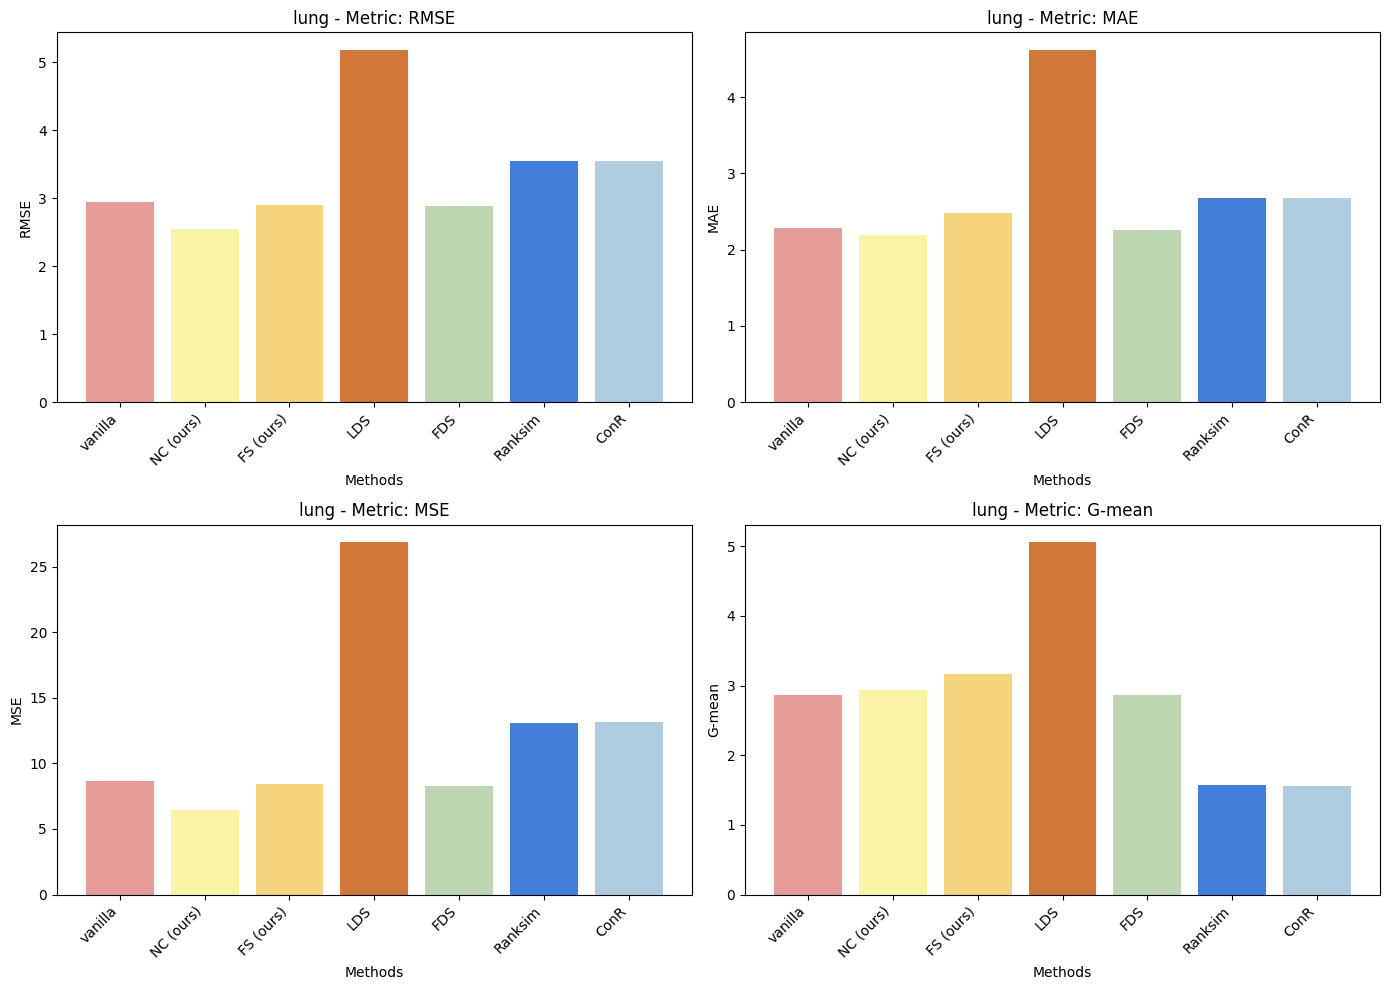

In [256]:
def main():

    X, y = df.drop([actual_col], axis=1).dropna().reset_index(drop=True).values, df[actual_col].dropna().reset_index(drop=True).values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    # Correct model instantiation
    input_features = X_train.shape[1]


    # Scenario 1: Original Dataset
    models_original = train_models(X_train, y_train)
    evaluations_original = evaluate_models(models_original, X_test, y_test)
    print("original dataset:", evaluations_original)

    # Scenario 2: Samples of nearest cells: Calibration Method
    final_df_nc_raking = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/lung_final_df_nc_raking.csv")
    X_train_nc, X_test_nc, y_train_nc, y_test_nc = custom_train_test_split(final_df_nc_raking, df, actual_col, test_size=0.3, random_state=42)
    y_combined = np.concatenate([y_train_nc, y_test_nc]) # for plotting
    models_nc = train_models(X_train_nc, y_train_nc)
    evaluations_nc_raking = evaluate_models(models_nc, X_test_nc, y_test_nc)
    print("Nearest Cell dataset:", evaluations_nc_raking)

    # Scenario 3: Samples of Features Similarity: Calibration Method
    final_df_fs_raking = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/lung_final_df_sn_raking.csv")
    X_train_fs_raking, X_test_fs_raking, y_train_fs_raking, y_test_fs_raking = custom_train_test_split(final_df_fs_raking, df, actual_col, test_size=0.3, random_state=42)
    y_combined = np.concatenate([y_train_fs_raking, y_test_fs_raking]) # for plotting
    models_fs_raking = train_models(X_train_fs_raking, y_train_fs_raking)
    evaluations_fs_raking = evaluate_models(models_fs_raking, X_test_fs_raking, y_test_fs_raking)
    print("Features Similarity dataset:", evaluations_fs_raking)
    
    # Scenario 4: LDS (Label Distribution Smoothing)
    X, y = df1.drop([actual_col, target_col, 'high_range', 'low_range'], axis=1).dropna().reset_index(drop=True).values, df1[actual_col].dropna().reset_index(drop=True).values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    train_weights = prepare_weights(labels=y_train.astype(int), reweight=None, max_target=int(max(y_train)))
    test_weights = prepare_weights(labels=y_test.astype(int), reweight=None, max_target=int(max(y_test)))
    models_lds = train_models(X_train, y_train, lds=True, weights=train_weights)
    evaluations_lds = evaluate_models(models_lds, X_test, y_test, lds=True, weights=test_weights)
    print("LDS dataset:", evaluations_lds)

    # Scenario 4: NC + LDS (Label Distribution Smoothing)
    df_nc = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/lung_final_df_nc_raking.csv")
    X, y = df_nc.drop([actual_col], axis=1).dropna().reset_index(drop=True).values, df_nc[actual_col].dropna().reset_index(drop=True).values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    train_weights = prepare_weights(labels=y_train.astype(int), reweight=None, max_target=int(max(y_train)))
    test_weights = prepare_weights(labels=y_test.astype(int), reweight=None, max_target=int(max(y_test)))
    models_nc_lds = train_models(X_train, y_train, lds=True, weights=train_weights)
    evaluations_nc_lds = evaluate_models(models_nc_lds, X_test, y_test, lds=True, weights=test_weights)
    print("NC + LDS dataset:", evaluations_nc_lds)

    # Scenario 4: FS + LDS (Label Distribution Smoothing)
    df_fs = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/lung_final_df_sn_raking.csv")
    X, y = df_fs.drop([actual_col], axis=1).dropna().reset_index(drop=True).values, df_fs[actual_col].dropna().reset_index(drop=True).values  
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    train_weights = prepare_weights(labels=y_train.astype(int), reweight=None, max_target=int(max(y_train)))
    test_weights = prepare_weights(labels=y_test.astype(int), reweight=None, max_target=int(max(y_test)))
    models_fs_lds = train_models(X_train, y_train, lds=True, weights=train_weights)
    evaluations_fs_lds = evaluate_models(models_fs_lds, X_test, y_test, lds=True, weights=test_weights)
    print("FS + LDS dataset:", evaluations_fs_lds)

    # Scenario 5: FDS (Feature Distribution Smoothing)
    X, y = df1.drop([actual_col, target_col, 'high_range', 'low_range'], axis=1).dropna().reset_index(drop=True).values, df1[actual_col].dropna().reset_index(drop=True).values
    X_train_fds, X_test_fds, y_train_fds, y_test_fds = train_test_split(X, y, test_size=0.3, random_state=42)
    models_fds = train_models(X_train_fds, y_train_fds, fds=True)
    evaluations_fds = evaluate_models(models_fds, X_test_fds, y_test_fds)
    print("FDS dataset:", evaluations_fds)

    # Scenario 5: NC + FDS (Feature Distribution Smoothing)
    df_nc = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/lung_final_df_nc_raking.csv")
    X, y = df_nc.drop([actual_col], axis=1).dropna().reset_index(drop=True).values, df_nc[actual_col].dropna().reset_index(drop=True).values
    X_train_fds, X_test_fds, y_train_fds, y_test_fds = train_test_split(X, y, test_size=0.3, random_state=42)
    models_nc_fds = train_models(X_train_fds, y_train_fds, fds=True)
    evaluations_nc_fds = evaluate_models(models_nc_fds, X_test_fds, y_test_fds)
    print("NC + FDS dataset:", evaluations_nc_fds)

    # Scenario 5: FS + FDS (Feature Distribution Smoothing)
    df_fs = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/lung_final_df_sn_raking.csv")
    X, y = df_fs.drop([actual_col], axis=1).dropna().reset_index(drop=True).values, df_fs[actual_col].dropna().reset_index(drop=True).values
    X_train_fds, X_test_fds, y_train_fds, y_test_fds = train_test_split(X, y, test_size=0.3, random_state=42)
    models_fs_fds = train_models(X_train_fds, y_train_fds, fds=True)
    evaluations_fs_fds = evaluate_models(models_fs_fds, X_test_fds, y_test_fds)
    print("FS + FDS dataset:", evaluations_fs_fds)

    # Scenario 6: LDS + FDS
    X, y = df1.drop([actual_col, target_col, 'high_range', 'low_range'], axis=1).dropna().reset_index(drop=True).values, df1[actual_col].dropna().reset_index(drop=True).values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    train_weights = prepare_weights(labels=y_train.astype(int), reweight=None, max_target=int(max(y_train)))
    test_weights = prepare_weights(labels=y_test.astype(int), reweight=None, max_target=int(max(y_test)))
    models_lds_fds = train_models(X_train, y_train, lds=True, fds=True, weights=train_weights)
    evaluations_lds_fds = evaluate_models(models_lds_fds, X_test, y_test, lds=True, weights=test_weights)
    print("LDS + FDS dataset:", evaluations_lds_fds)

    # Scenario 6: NC + LDS + FDS
    df_nc = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/lung_final_df_nc_raking.csv")
    X, y = df_nc.drop([actual_col], axis=1).dropna().reset_index(drop=True).values, df_nc[actual_col].dropna().reset_index(drop=True).values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    train_weights = prepare_weights(labels=y_train.astype(int), reweight=None, max_target=int(max(y_train)))
    test_weights = prepare_weights(labels=y_test.astype(int), reweight=None, max_target=int(max(y_test)))
    models_nc_lds_fds = train_models(X_train, y_train, lds=True, fds=True, weights=train_weights)
    evaluations_nc_lds_fds = evaluate_models(models_nc_lds_fds, X_test, y_test, lds=True, weights=test_weights)
    print("NC + LDS + FDS dataset:", evaluations_nc_lds_fds)

    # Scenario 6: FS + LDS + FDS
    df_fs = pd.read_csv("/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/lung_final_df_sn_raking.csv")
    X, y = df_fs.drop([actual_col], axis=1).dropna().reset_index(drop=True).values, df_fs[actual_col].dropna().reset_index(drop=True).values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    train_weights = prepare_weights(labels=y_train.astype(int), reweight=None, max_target=int(max(y_train)))
    test_weights = prepare_weights(labels=y_test.astype(int), reweight=None, max_target=int(max(y_test)))
    models_fs_lds_fds = train_models(X_train, y_train, lds=True, fds=True, weights=train_weights)
    evaluations_fs_lds_fds = evaluate_models(models_fs_lds_fds, X_test, y_test, lds=True, weights=test_weights)
    print("FS + LDS + FDS dataset:", evaluations_fs_lds_fds)

    # Scenario 7: Ranksim
    ranksim_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_lung_regression_model.pth'
    reg_model.load_state_dict(torch.load(ranksim_path))
    _, val_indices = train_test_split(np.arange(len(df)), test_size=0.3, random_state=42)
    X_orig = df.drop([actual_col], axis=1).dropna().reset_index(drop=True).values
    y_orig = df[actual_col].dropna().reset_index(drop=True).values
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = LungDataset(X_orig[val_indices], y_orig[val_indices], weights=val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_ranksim = validate_ranksim(val_loader, reg_model, lds=False, train_labels=None, prefix='Val')
    print("Ranksim dataset:", evaluations_ranksim)

    # Scenario 7: NC + Ranksim
    ranksim_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_lung_nc_regression_model.pth'
    reg_model.load_state_dict(torch.load(ranksim_path))
    _, val_indices = train_test_split(np.arange(len(df)), test_size=0.3, random_state=42)
    X_orig = df.drop([actual_col], axis=1).dropna().reset_index(drop=True).values
    y_orig = df[actual_col].dropna().reset_index(drop=True).values
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = LungDataset(X_orig[val_indices], y_orig[val_indices], weights=val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_nc_ranksim = validate_ranksim(val_loader, reg_model, lds=False, train_labels=None, prefix='Val')
    print("NC + Ranksim dataset:", evaluations_nc_ranksim)

    # Scenario 7: NC + Ranksim
    ranksim_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_lung_fs_regression_model.pth'
    reg_model.load_state_dict(torch.load(ranksim_path))
    _, val_indices = train_test_split(np.arange(len(df)), test_size=0.3, random_state=42)
    X_orig = df.drop([actual_col], axis=1).dropna().reset_index(drop=True).values
    y_orig = df[actual_col].dropna().reset_index(drop=True).values
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = LungDataset(X_orig[val_indices], y_orig[val_indices], weights=val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_fs_ranksim = validate_ranksim(val_loader, reg_model, lds=False, train_labels=None, prefix='Val')
    print("FS + Ranksim dataset:", evaluations_fs_ranksim)

    # Scenario 8: Ranksim + LDS Validation
    ranksim_lds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_lung_regression_model_with_LDS.pth'
    reg_model.load_state_dict(torch.load(ranksim_lds_path))
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = LungDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_ranksim_lds = validate_ranksim(val_loader, reg_model, lds=True, train_labels=None, prefix='Val')
    print("Ranksim + LDS dataset:", evaluations_ranksim_lds)

    # Scenario 8: NC + Ranksim + LDS Validation
    ranksim_lds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_lung_nc_regression_model_with_LDS.pth'
    reg_model.load_state_dict(torch.load(ranksim_lds_path))
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = LungDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_nc_ranksim_lds = validate_ranksim(val_loader, reg_model, lds=True, train_labels=None, prefix='Val')
    print("NC + Ranksim + LDS dataset:", evaluations_nc_ranksim_lds)

    # Scenario 8: FS + Ranksim + LDS Validation
    ranksim_lds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_lung_fs_regression_model_with_LDS.pth'
    reg_model.load_state_dict(torch.load(ranksim_lds_path))
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = LungDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_fs_ranksim_lds = validate_ranksim(val_loader, reg_model, lds=True, train_labels=None, prefix='Val')
    print("FS+ Ranksim + LDS dataset:", evaluations_fs_ranksim_lds)

    # Scenario 9: Ranksim + FDS Validation
    ranksim_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_lung_regression_model_with_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(ranksim_fds_path))
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = LungDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_ranksim_fds = validate_ranksim(val_loader, reg_model_fds, lds=False, train_labels=None, prefix='Val')
    print("Ranksim + FDS dataset:", evaluations_ranksim_fds)

    # Scenario 9: NC + Ranksim + FDS Validation
    ranksim_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_lung_nc_regression_model_with_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(ranksim_fds_path))
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = LungDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_nc_ranksim_fds = validate_ranksim(val_loader, reg_model_fds, lds=False, train_labels=None, prefix='Val')
    print("NC + Ranksim + FDS dataset:", evaluations_nc_ranksim_fds)

    # Scenario 9: FS + Ranksim + FDS Validation
    ranksim_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_lung_fs_regression_model_with_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(ranksim_fds_path))
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = LungDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_fs_ranksim_fds = validate_ranksim(val_loader, reg_model_fds, lds=False, train_labels=None, prefix='Val')
    print("FS + Ranksim + FDS dataset:", evaluations_fs_ranksim_fds)
    
    # Scenario 10: Ranksim+ LDS + FDS Validation
    ranksim_lds_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_lung_regression_model_with_LDS_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(ranksim_lds_fds_path))
    # Split dataset into training and validation sets
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = LungDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_ranksim_lds_fds = validate_ranksim(val_loader, reg_model_fds, lds=True, train_labels=None, prefix='Val')
    print("Ranksim + LDS + FDS dataset:", evaluations_ranksim_lds_fds)

    # Scenario 10: NC + Ranksim + LDS + FDS Validation
    ranksim_lds_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_lung_nc_regression_model_with_LDS_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(ranksim_lds_fds_path))
    # Split dataset into training and validation sets
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = LungDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_nc_ranksim_lds_fds = validate_ranksim(val_loader, reg_model_fds, lds=True, train_labels=None, prefix='Val')
    print("NC + Ranksim + LDS + FDS dataset:", evaluations_nc_ranksim_lds_fds)

    # Scenario 10: FS + Ranksim + LDS + FDS Validation
    ranksim_lds_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_ranksim/best_lung_fs_regression_model_with_LDS_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(ranksim_lds_fds_path))
    # Split dataset into training and validation sets
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = LungDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_fs_ranksim_lds_fds = validate_ranksim(val_loader, reg_model_fds, lds=True, train_labels=None, prefix='Val')
    print("FS + Ranksim + LDS + FDS dataset:", evaluations_fs_ranksim_lds_fds)

    # Scenario 11: ConR
    conr_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_lung_regression_model_ConR.pth'
    reg_model.load_state_dict(torch.load(conr_path))
    _, val_indices = train_test_split(np.arange(len(df)), test_size=0.3, random_state=42)
    X_orig = df.drop([actual_col], axis=1).dropna().reset_index(drop=True).values
    y_orig = df[actual_col].dropna().reset_index(drop=True).values
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = LungDataset(X_orig[val_indices], y_orig[val_indices], weights=val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_conr = validate_ranksim(val_loader, reg_model, lds=False, train_labels=None, prefix='Val')
    print("ConR dataset:", evaluations_conr)

    # Scenario 11: NC + ConR
    conr_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_lung_nc_regression_model_ConR.pth'
    reg_model.load_state_dict(torch.load(conr_path))
    _, val_indices = train_test_split(np.arange(len(df)), test_size=0.3, random_state=42)
    X_orig = df.drop([actual_col], axis=1).dropna().reset_index(drop=True).values
    y_orig = df[actual_col].dropna().reset_index(drop=True).values
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = LungDataset(X_orig[val_indices], y_orig[val_indices], weights=val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_nc_conr = validate_ranksim(val_loader, reg_model, lds=False, train_labels=None, prefix='Val')
    print("NC + ConR dataset:", evaluations_nc_conr)
    
    # Scenario 11: FS + ConR
    conr_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_lung_fs_regression_model_ConR.pth'
    reg_model.load_state_dict(torch.load(conr_path))
    _, val_indices = train_test_split(np.arange(len(df)), test_size=0.3, random_state=42)
    X_orig = df.drop([actual_col], axis=1).dropna().reset_index(drop=True).values
    y_orig = df[actual_col].dropna().reset_index(drop=True).values
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = LungDataset(X_orig[val_indices], y_orig[val_indices], weights=val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_fs_conr = validate_ranksim(val_loader, reg_model, lds=False, train_labels=None, prefix='Val')
    print("FS + ConR dataset:", evaluations_fs_conr)
            
    # Scenario 12: ConR + LDS Validation
    conr_lds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_lung_regression_model_ConR_with_LDS.pth'
    reg_model.load_state_dict(torch.load(conr_lds_path))
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = LungDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_conr_lds = validate_ranksim(val_loader, reg_model, lds=True, train_labels=None, prefix='Val')
    print("ConR + LDS dataset:", evaluations_conr_lds)

    # Scenario 12: NC + ConR + LDS Validation
    conr_lds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_lung_nc_regression_model_ConR_with_LDS.pth'
    reg_model.load_state_dict(torch.load(conr_lds_path))
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = LungDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_nc_conr_lds = validate_ranksim(val_loader, reg_model, lds=True, train_labels=None, prefix='Val')
    print("NC + ConR + LDS dataset:", evaluations_nc_conr_lds)

    # Scenario 12: FS + ConR + LDS Validation
    conr_lds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_lung_fs_regression_model_ConR_with_LDS.pth'
    reg_model.load_state_dict(torch.load(conr_lds_path))
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = LungDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_fs_conr_lds = validate_ranksim(val_loader, reg_model, lds=True, train_labels=None, prefix='Val')
    print("FS + ConR + LDS dataset:", evaluations_fs_conr_lds)

    # Scenario 13: ConR + FDS Validation
    conr_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_lung_regression_model_ConR_with_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(conr_fds_path))
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = LungDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_conr_fds = validate_ranksim(val_loader, reg_model_fds, lds=False, train_labels=None, prefix='Val')
    print("ConR + FDS dataset:", evaluations_conr_fds)

    # Scenario 13: NC + ConR + FDS Validation
    conr_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_lung_nc_regression_model_ConR_with_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(conr_fds_path))
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = LungDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_nc_conr_fds = validate_ranksim(val_loader, reg_model_fds, lds=False, train_labels=None, prefix='Val')
    print("NC + ConR + FDS dataset:", evaluations_nc_conr_fds)

    # Scenario 13: FS + ConR + FDS Validation
    conr_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_lung_nc_regression_model_ConR_with_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(conr_fds_path))
    val_weights = 99 * np.ones(len(y_orig[val_indices]))
    val_dataset = LungDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_fs_conr_fds = validate_ranksim(val_loader, reg_model_fds, lds=False, train_labels=None, prefix='Val')
    print("FS + ConR + FDS dataset:", evaluations_fs_conr_fds)
    
    # Scenario 14: ConR + LDS + FDS Validation
    conr_lds_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_lung_regression_model_ConR_with_LDS_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(conr_lds_fds_path))
    # Split dataset into training and validation sets
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = LungDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_conr_lds_fds = validate_ranksim(val_loader, reg_model_fds, lds=True, train_labels=None, prefix='Val')
    print("Ranksim + LDS + FDS dataset:", evaluations_conr_lds_fds)

    # Scenario 14: NC + ConR + LDS + FDS Validation
    conr_lds_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_lung_nc_regression_model_ConR_with_LDS_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(conr_lds_fds_path))
    # Split dataset into training and validation sets
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = LungDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_nc_conr_lds_fds = validate_ranksim(val_loader, reg_model_fds, lds=True, train_labels=None, prefix='Val')
    print("NC + Ranksim + LDS + FDS dataset:", evaluations_nc_conr_lds_fds)

    # Scenario 14: FS + ConR + LDS + FDS Validation
    conr_lds_fds_path = '/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/saved_models_conr/best_lung_fs_regression_model_ConR_with_LDS_FDS.pth'
    reg_model_fds.load_state_dict(torch.load(conr_lds_fds_path))
    # Split dataset into training and validation sets
    val_weights = prepare_weights(labels=y_orig[val_indices].astype(int), reweight=None, max_target=int(max(y_orig)))
    val_dataset = LungDataset(X_orig[val_indices], y_orig[val_indices], val_weights, lds=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    evaluations_fs_conr_lds_fds = validate_ranksim(val_loader, reg_model_fds, lds=True, train_labels=None, prefix='Val')
    print("FS + Ranksim + LDS + FDS dataset:", evaluations_fs_conr_lds_fds)

    # Calculate averages for each sampling method
    evaluations_dict = {
        'vanilla': evaluations_original,
        'NC (ours)': evaluations_nc_raking,
        'FS (ours)': evaluations_fs_raking,
        'LDS': evaluations_lds,
        'NC + LDS': evaluations_nc_lds,
        'FS + LDS': evaluations_fs_lds,
        'FDS': evaluations_fds,
        'NC + FDS': evaluations_nc_fds,
        'FS + FDS': evaluations_fs_fds,
        'LDS + FDS': evaluations_lds_fds,
        'NC + LDS + FDS': evaluations_nc_lds_fds,
        'FS + LDS + FDS': evaluations_nc_lds_fds,
        'Ranksim': evaluations_ranksim,
        'NC + Ranksim': evaluations_nc_ranksim,
        'FS + Ranksim': evaluations_fs_ranksim,
        'Ranksim + LDS': evaluations_ranksim_lds, 
        'NC + Ranksim + LDS': evaluations_nc_ranksim_lds, 
        'FS + Ranksim + LDS': evaluations_fs_ranksim_lds, 
        'Ranksim + FDS': evaluations_ranksim_fds,
        'NC + Ranksim + FDS': evaluations_nc_ranksim_fds,
        'FS + Ranksim + FDS': evaluations_fs_ranksim_fds,
        'Ranksim + LDS + FDS': evaluations_ranksim_lds_fds,  
        'NC + Ranksim + LDS + FDS': evaluations_nc_ranksim_lds_fds, 
        'FS + Ranksim + LDS + FDS': evaluations_fs_ranksim_lds_fds, 
        'ConR': evaluations_conr,
        'NC + ConR': evaluations_nc_conr,
        'FS + ConR': evaluations_fs_conr,
        "ConR + LDS": evaluations_conr_lds,
        "NC + ConR + LDS": evaluations_nc_conr_lds,
        "FS + ConR + LDS": evaluations_fs_conr_lds,
        "ConR + FDS": evaluations_conr_fds,
        "NC + ConR + FDS": evaluations_nc_conr_fds,
        "FS + ConR + FDS": evaluations_fs_conr_fds,
        "ConR + LDS + FDS": evaluations_conr_lds_fds,
        "NC + ConR + LDS + FDS": evaluations_nc_conr_lds_fds,
        "FS + ConR + LDS + FDS": evaluations_fs_conr_lds_fds
    }

    average_dict = {}
    for key, evaluations in evaluations_dict.items():
        average_dict[key] = calculate_averages(evaluations, is_ranksim=(key in ['Ranksim', 'ConR','Ranksim + LDS','Ranksim + FDS','Ranksim + LDS + FDS',
                                                                                "ConR + LDS","ConR + FDS","ConR + LDS + FDS", 'NC + Ranksim', 'FS + Ranksim', 
                                                                                'NC + Ranksim + LDS', 'FS + Ranksim + LDS', 'NC + Ranksim + FDS', 'FS + Ranksim + FDS', 
                                                                                'NC + Ranksim + LDS + FDS', 'FS + Ranksim + LDS + FDS', 'NC + ConR', 'FS + ConR', 
                                                                                "NC + ConR + LDS", "FS + ConR + LDS", "NC + ConR + FDS", "FS + ConR + FDS", 
                                                                                "NC + ConR + LDS + FDS", "FS + ConR + LDS + FDS"]), 
                                               select_best=False) #(key in ['NC_calibration', 'FS_calibration'])

     # Transform the dictionaries to match the expected structure for plotting
    average_dict_transformed = {method: {metric: average_dict[method][metric] for metric in ['RMSE', 'MAE', 'MSE', 'G-mean']} for method in evaluations_dict.keys()}

    # Create DataFrames for the averages
    average_df = pd.DataFrame(average_dict_transformed).T
    print(average_df)

    # Plot average comparisons
    methods = ['vanilla', 'NC (ours)', 'FS (ours)', 'LDS', 'FDS', 'Ranksim','ConR']
    plot_average_comparisons(average_dict, methods, dataset_name='lung',
                             save_path='/home/Imbalanced_Regression/Results/lung_average_comparisons.png')
    
    # plot_distribution_comparison(y, y_combined, K, dataset_name='Boston', 
    #                              save_path='/home/Imbalanced_Regression/Results/Boston_dist_comparisons.png')
    
    # Export the DataFrame to a CSV file
    average_df.to_csv(f'/home/Imbalanced_Regression/Results/lung_K_{K}_mj_{mj}_average_evaluations.csv')
    # save_combined_evaluations_to_csv(evaluations_dict, f'/home/Imbalanced_Regression/Results/lung_K_{K}_mj_{mj}_combined_evaluations.csv')
    # files.download(f'Boston_K_{K}_mj_{mj}_average_evaluations.csv')


    # download the balanced dataset
    # final_df_nc_raking.to_csv('/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/Boston_final_df_nc_raking.csv', index=False)
    # final_df_sn_raking.to_csv('/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/Boston_final_df_sn_raking.csv', index=False)


if __name__ == "__main__":
    main()


#### 9-2 - iterations

Metrics for mlp: RMSE=2.87, MAE=2.25, MSE=8.24, G-mean=2.85
evaluations_original: {'mlp': {'RMSE': 2.8696872742450306, 'MAE': 2.246067890487517, 'MSE': 8.235105051963874, 'G-mean': 2.852384680391954}}
Using LDS: [GAUSSIAN] (5/2)
Using LDS: [GAUSSIAN] (5/2)
Metrics for mlp: RMSE=6.16, MAE=5.55, MSE=37.92, G-mean=5.86
evaluations_lds: {'mlp': {'RMSE': 6.157755044853762, 'MAE': 5.553735447838192, 'MSE': 37.917947192421956, 'G-mean': 5.864980914732615}}
Metrics for mlp: RMSE=2.88, MAE=2.28, MSE=8.29, G-mean=2.88
evaluations_fds: {'mlp': {'RMSE': 2.8788110496844084, 'MAE': 2.2780866847599954, 'MSE': 8.287553059785045, 'G-mean': 2.8822341848855273}}
Using LDS: [GAUSSIAN] (5/2)
Using LDS: [GAUSSIAN] (5/2)
Metrics for mlp: RMSE=2.76, MAE=2.43, MSE=7.59, G-mean=3.17
evaluations_nc_lds: {'mlp': {'RMSE': 2.7553499, 'MAE': 2.4285264, 'MSE': 7.5919533, 'G-mean': 3.1705115}}
Metrics for mlp: RMSE=2.74, MAE=2.44, MSE=7.51, G-mean=3.19
evaluations_nc_fds: {'mlp': {'RMSE': 2.7407646, 'MAE': 2.4395926, 

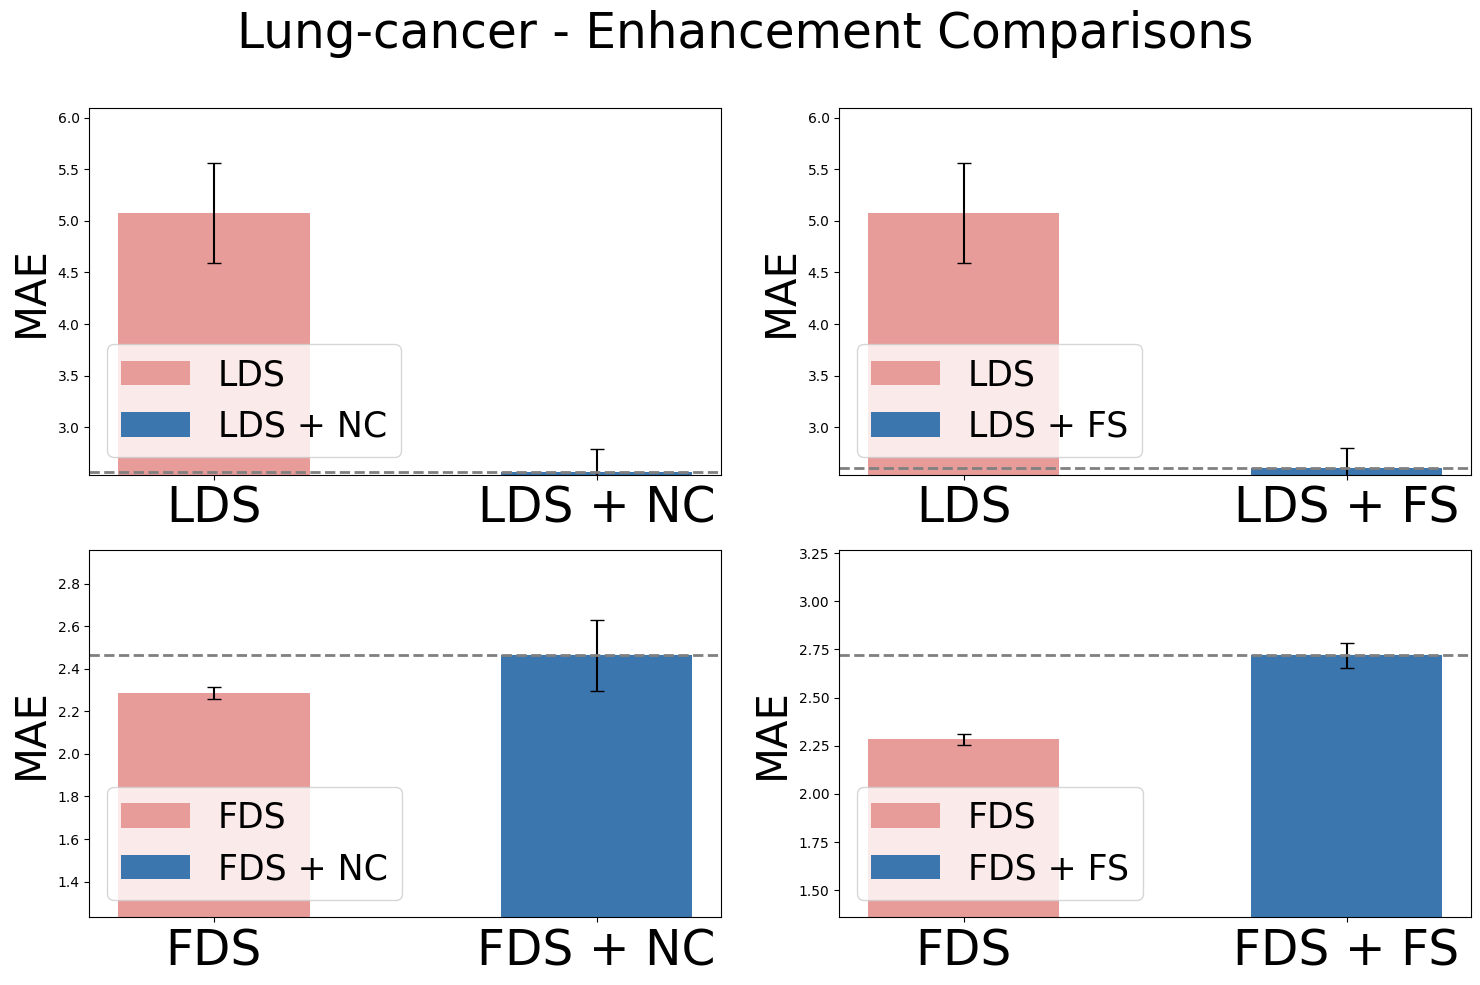

In [387]:
def main():
    iterations = 5
    results = []

    for iteration in range(iterations):
        X, y = df.drop([actual_col], axis=1).dropna().reset_index(drop=True).values, df[actual_col].dropna().reset_index(drop=True).values
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        input_features = X_train.shape[1]

        # Scenario 1: Original Dataset
        models_original = train_models(X_train, y_train)
        evaluations_original = evaluate_models(models_original, X_test, y_test)
        print(f"evaluations_original: {evaluations_original}")  # Debugging print statement
        if not isinstance(evaluations_original, dict):
            print(f"Error: evaluations_original is not a dictionary")
            continue
        
        # Scenario 4: LDS (Label Distribution Smoothing)
        X, y = df1.drop([actual_col, target_col, 'high_range', 'low_range'], axis=1).dropna().reset_index(drop=True).values, df1[actual_col].dropna().reset_index(drop=True).values
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        train_weights = prepare_weights(labels=y_train.astype(int), reweight=None, max_target=int(max(y_train)))
        test_weights = prepare_weights(labels=y_test.astype(int), reweight=None, max_target=int(max(y_test)))
        models_lds = train_models(X_train, y_train, lds=True, weights=train_weights)
        evaluations_lds = evaluate_models(models_lds, X_test, y_test, lds=True, weights=test_weights)
        print(f"evaluations_lds: {evaluations_lds}")  # Debugging print statement
        if not isinstance(evaluations_lds, dict):
            print(f"Error: evaluations_lds is not a dictionary")
            continue

        # Scenario 7: FDS (Feature Distribution Smoothing)
        X, y = df1.drop([actual_col, target_col, 'low_range', 'high_range'], axis=1).dropna().reset_index(drop=True).values, df1[actual_col].dropna().reset_index(drop=True).values
        X_train_fds, X_test_fds, y_train_fds, y_test_fds = train_test_split(X, y, test_size=0.3, random_state=42)
        models_fds = train_models(X_train_fds, y_train_fds, fds=True)
        evaluations_fds = evaluate_models(models_fds, X_test_fds, y_test_fds)
        print(f"evaluations_fds: {evaluations_fds}")  # Debugging print statement
        if not isinstance(evaluations_fds, dict):
            print(f"Error: evaluations_fds is not a dictionary")
            continue

        # Scenario 2: NC+LDS
        final_df_nc_raking = pd.read_csv('/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/lung_final_df_nc_raking.csv')
        X_train_nc, X_test_nc, y_train_nc, y_test_nc = custom_train_test_split(final_df_nc_raking, df, actual_col, test_size=0.3, random_state=42)
        train_weights = prepare_weights(labels=y_train_nc.astype(int), reweight=None, max_target=int(max(y_train_nc)))
        test_weights = prepare_weights(labels=y_test_nc.astype(int), reweight=None, max_target=int(max(y_test_nc)))
        models_nc_lds = train_models(X_train_nc, y_train_nc, lds=True, weights=train_weights)
        evaluations_nc_lds = evaluate_models(models_nc_lds, X_test_nc, y_test_nc, lds=True, weights=test_weights)
        print(f"evaluations_nc_lds: {evaluations_nc_lds}")  # Debugging print statement
        if not isinstance(evaluations_nc_lds, dict):
            print(f"Error: evaluations_nc_lds is not a dictionary")
            continue

        # Scenario 3: NC+FDS
        X_train_nc, X_test_nc, y_train_nc, y_test_nc = custom_train_test_split(final_df_nc_raking, df, actual_col, test_size=0.3, random_state=42)
        models_nc_fds = train_models(X_train_nc, y_train_nc, fds=True)
        evaluations_nc_fds = evaluate_models(models_nc_fds, X_test_nc, y_test_nc)
        print(f"evaluations_nc_fds: {evaluations_nc_fds}")  # Debugging print statement
        if not isinstance(evaluations_nc_fds, dict):
            print(f"Error: evaluations_nc_fds is not a dictionary")
            continue

        # Scenario 4: FS+LDS
        final_df_sn_raking = pd.read_csv('/home/Imbalanced_Regression/imbalanced_imdb-wiki/Dataset/lung_final_df_sn_raking.csv')
        X_train_sn_raking, X_test_sn_raking, y_train_sn_raking, y_test_sn_raking = custom_train_test_split(final_df_sn_raking, df, actual_col, test_size=0.3, random_state=42)
        train_weights = prepare_weights(labels=y_train_sn_raking.astype(int), reweight=None, max_target=int(max(y_train_sn_raking)))
        test_weights = prepare_weights(labels=y_test_sn_raking.astype(int), reweight=None, max_target=int(max(y_test_sn_raking)))
        models_fs_lds = train_models(X_train_sn_raking, y_train_sn_raking, lds=True, weights=train_weights)
        evaluations_fs_lds = evaluate_models(models_fs_lds, X_test_sn_raking, y_test_sn_raking, lds=True, weights=test_weights)
        print(f"evaluations_fs_lds: {evaluations_fs_lds}")  # Debugging print statement
        if not isinstance(evaluations_fs_lds, dict):
            print(f"Error: evaluations_fs_lds is not a dictionary")
            continue

        # Scenario 5: FS+FDS
        X_train_sn_raking, X_test_sn_raking, y_train_sn_raking, y_test_sn_raking = custom_train_test_split(final_df_sn_raking, df, actual_col, test_size=0.3, random_state=42)
        models_fs_fds = train_models(X_train_sn_raking, y_train_sn_raking, fds=True)
        evaluations_fs_fds = evaluate_models(models_fs_fds, X_test_sn_raking, y_test_sn_raking)
        print(f"evaluations_fs_fds: {evaluations_fs_fds}")  # Debugging print statement
        if not isinstance(evaluations_fs_fds, dict):
            print(f"Error: evaluations_fs_fds is not a dictionary")
            continue

        # Save all the results for the current iteration
        evaluations_dict = {
            'LDS': evaluations_lds,
            'nc_lds': evaluations_nc_lds,
            'fs_lds': evaluations_fs_lds,
            'FDS': evaluations_fds,
            'nc_fds': evaluations_nc_fds,
            'fs_fds': evaluations_fs_fds
        }

        for key, evaluations in evaluations_dict.items():
            average_metrics = calculate_averages2(evaluations, is_ranksim=False, select_best=False)
            if not isinstance(average_metrics, dict):
                print(f"Error: average_metrics for {key} is not a dictionary")
                continue
            for metric, value in average_metrics.items():
                result = {'iteration': iteration, 'scenario': key, 'metric': metric, 'value': value}
                print(f"Appending result: {result}")  # Debugging print statement
                results.append(result)
                    
    # Convert results to DataFrame and save
    results_df = pd.DataFrame(results)
    print(f"Results DataFrame:\n{results_df}")  # Debugging print statement

    # Calculate averages for each sampling method
    average_dict = {}
    std_dict = {}
    for key, group in results_df.groupby('scenario'):
        group_metrics = group.pivot_table(values='value', index='iteration', columns='metric').mean().to_dict()
        average_metrics = {metric: group_metrics.get('MAE', float('nan')) for metric in ['MAE']}
        std_metrics = {metric: group.pivot_table(values='value', index='iteration', columns='metric').std().to_dict().get('MAE', float('nan')) for metric in ['MAE']}
        average_dict[key] = average_metrics
        std_dict[key] = std_metrics

    # Plot comparisons
    plot_enhancement_comparisons(average_dict, std_dict, dataset_name='Lung-cancer', save_path_prefix='/home/Imbalanced_Regression/Results/Enhancement')

if __name__ == "__main__":
    main()
